In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os

%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn
import utils

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:01<00:00, 189.54it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

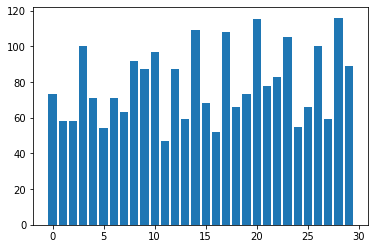

In [8]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [9]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

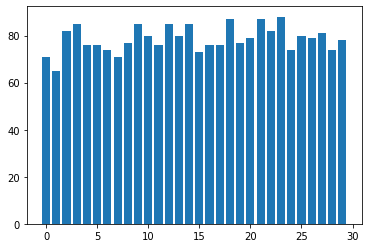

In [10]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [13]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [12]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [13]:
from tensorflow.keras.layers import Conv2D
from utils import MySequential, ConfusionMatrixMetric, PeriodicPaddingConv2D

In [14]:
ConvLayer=Conv2D

In [15]:
class ConvBlock(keras.layers.Layer):
    
    def __init__(self,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.max_pool=kwargs.pop('max_pool',None)
        self.dropout=kwargs.pop('dropout',None)
        self.zero_padding=kwargs.pop('zero_padding',None)
        self.args=args
        self.kwargs=kwargs
        
        
    def build(self,input_shape):
        layers=[tf.keras.layers.Input(shape=input_shape[1:])]
        if self.zero_padding is not None:
            layers.append(tf.keras.layers.ZeroPadding2D(padding=self.zero_padding))
        layers.extend([
            ConvLayer(*self.args,**self.kwargs),
            keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
            keras.layers.BatchNormalization(axis=[3]), # batch normalization on everything but last dimension
        ])
        if self.max_pool is not None:
            layers.append(keras.layers.MaxPool2D(self.max_pool))
        if self.dropout is not None:
            layers.append(keras.layers.Dropout(self.dropout))
        self.model=keras.Sequential(layers)
        
    def call(self,x):
        return self.model(x)

In [16]:
from tensorflow.keras import Sequential

In [17]:
class OnlyTimeConvolution(tf.keras.layers.Layer):
    
    def __init__(self,num_filters,filter_size,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.tr1=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.tr2=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.c=tf.keras.layers.Conv1D(num_filters,
                               filter_size,
                               data_format='channels_last',*args,**kwargs)
    
    def build(self,input_shape):
        self.num_channels=input_shape[1]
        
    def call(self,x):
        
        x=self.tr1(x)
        x=tf.stack([self.c(x[:,:,i]) for i in range(self.num_channels)],2)
        x=self.tr2(x)
        return x

In [18]:
120/1500*15

1.2

In [19]:
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2
initial_time_only_conv=Sequential([
    OnlyTimeConvolution(100,100,strides=5,name='only_time_convolution',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
    keras.layers.BatchNormalization(axis=[3]),
    keras.layers.MaxPool2D((1,2)),
    Conv2D(1,(1,1),padding='same'),
],name='initial_time_only_conv_encoder')
model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    initial_time_only_conv
]).summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
initial_time_only_conv_encod (None, 12, 140, 1)        10601     
Total params: 10,605
Trainable params: 10,403
Non-trainable params: 202
_________________________________________________________________


In [20]:
dropout_prob=0.3
PADDING_TYPE='valid'

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    initial_time_only_conv,
    #
    ConvBlock(64,(3,3),
              name='conv_block_1',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(128,(3,3),
              name='conv_block_2',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,3),
              dropout=dropout_prob,
             ),
    ConvBlock(150,(3,3),
              name='conv_block_3',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(200,(3,3),
              name='conv_block_4',
              padding='same',
              kernel_initializer=kernel_initializer,
             ),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
initial_time_only_conv_encod (None, 12, 140, 1)        10601     
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 10, 70, 64)        896       
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 8, 23, 128)        74368     
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 6, 11, 150)        173550    
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 6, 11, 200)    

In [29]:
def make_and_run_model(num_epochs=50):
    kernel_initializer='he_uniform'
    leaky_relu_parameter=1e-2
    initial_time_only_conv=Sequential([
        OnlyTimeConvolution(100,100,strides=5,name='only_time_convolution',kernel_initializer=kernel_initializer),
        keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
        keras.layers.BatchNormalization(axis=[3]),
        keras.layers.MaxPool2D((1,2)),
        Conv2D(1,(1,1),padding='same'),
    ],name='initial_time_only_conv_encoder')
    
    dropout_prob=0.3
    PADDING_TYPE='valid'

    model=MySequential([
        keras.layers.Input(shape=(12,1500)),
        keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
        keras.layers.BatchNormalization(axis=[3],name='norm0'),
        #
        initial_time_only_conv,
        #
        ConvBlock(64,(3,3),
                  name='conv_block_1',
                  zero_padding=(0,1),
                  padding=PADDING_TYPE,
                  kernel_initializer=kernel_initializer,
                  max_pool=(1,2),
                  dropout=dropout_prob,
                 ),
        ConvBlock(128,(3,3),
                  name='conv_block_2',
                  zero_padding=(0,1),
                  padding=PADDING_TYPE,
                  kernel_initializer=kernel_initializer,
                  max_pool=(1,3),
                  dropout=dropout_prob,
                 ),
        ConvBlock(150,(3,3),
                  name='conv_block_3',
                  zero_padding=(0,1),
                  padding=PADDING_TYPE,
                  kernel_initializer=kernel_initializer,
                  max_pool=(1,2),
                  dropout=dropout_prob,
                 ),
        ConvBlock(200,(3,3),
                  name='conv_block_4',
                  padding='same',
                  kernel_initializer=kernel_initializer,
                 ),
        keras.layers.GlobalAveragePooling2D(name='gba'),
        keras.layers.Dropout(dropout_prob,name='drop4'),
        #
        keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

    ])
    
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])
    
    history=model.fit(train_data,
                      validation_data=val_data,
                      epochs=num_epochs,
                      steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)
    return history, model

In [30]:
import time

In [31]:
histories=[]
models=[]
NUM_TRIALS=10
NUM_EPOCHS=100
for j in range(NUM_TRIALS):
    t0=time.time()
    history, model=make_and_run_model(NUM_EPOCHS)
    t1=time.time()
    print('*'*10,j,':',(t1-t0)/60,'*'*10)
    histories.append(history)
    models.append(model)

Epoch 1/100
73/73 [==============================] - 4s 58ms/step - loss: 3.4302 - accuracy: 0.0625 - F1_0: 0.0495 - F1_1: 0.0951 - F1_2: 0.0753 - F1_3: 0.0182 - F1_4: 0.0078 - F1_5: 0.0368 - F1_6: 0.0852 - F1_7: 0.0347 - F1_8: 0.1019 - F1_9: 0.0482 - F1_10: 0.0299 - F1_11: 0.0389 - F1_12: 0.0539 - F1_13: 0.0435 - F1_14: 0.0020 - F1_15: 0.0644 - F1_16: 0.0170 - F1_17: 0.0592 - F1_18: 0.0000e+00 - F1_19: 0.0433 - F1_20: 0.0806 - F1_21: 0.1007 - F1_22: 0.0211 - F1_23: 0.0438 - F1_24: 0.0532 - F1_25: 0.0000e+00 - F1_26: 0.0310 - F1_27: 0.0668 - F1_28: 0.0054 - F1_29: 5.1975e-04 - val_loss: 3.8375 - val_accuracy: 0.0231 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0451 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0000e+00 - val_

Epoch 14/100
73/73 [==============================] - 4s 50ms/step - loss: 1.1725 - accuracy: 0.6485 - F1_0: 0.5507 - F1_1: 0.6203 - F1_2: 0.7751 - F1_3: 0.4898 - F1_4: 0.6419 - F1_5: 0.6579 - F1_6: 0.7957 - F1_7: 0.6900 - F1_8: 0.7167 - F1_9: 0.6567 - F1_10: 0.6773 - F1_11: 0.5093 - F1_12: 0.5496 - F1_13: 0.5671 - F1_14: 0.6582 - F1_15: 0.7683 - F1_16: 0.7062 - F1_17: 0.5865 - F1_18: 0.6529 - F1_19: 0.6717 - F1_20: 0.6758 - F1_21: 0.6205 - F1_22: 0.5827 - F1_23: 0.5321 - F1_24: 0.6469 - F1_25: 0.4615 - F1_26: 0.6691 - F1_27: 0.4677 - F1_28: 0.7093 - F1_29: 0.5847 - val_loss: 2.3404 - val_accuracy: 0.3885 - val_F1_0: 0.3509 - val_F1_1: 0.1290 - val_F1_2: 0.1538 - val_F1_3: 0.5455 - val_F1_4: 0.7879 - val_F1_5: 0.6296 - val_F1_6: 0.5161 - val_F1_7: 0.6667 - val_F1_8: 0.3059 - val_F1_9: 0.2857 - val_F1_10: 0.4776 - val_F1_11: 0.4000 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3125 - val_F1_14: 0.1311 - val_F1_15: 0.5200 - val_F1_16: 0.2143 - val_F1_17: 0.0000e+00 - val_F1_18: 0.3509 - val_F1_

Epoch 21/100
73/73 [==============================] - 4s 50ms/step - loss: 0.8057 - accuracy: 0.7697 - F1_0: 0.8174 - F1_1: 0.6832 - F1_2: 0.7732 - F1_3: 0.5591 - F1_4: 0.9044 - F1_5: 0.7185 - F1_6: 0.7225 - F1_7: 0.8411 - F1_8: 0.7531 - F1_9: 0.8207 - F1_10: 0.8563 - F1_11: 0.7166 - F1_12: 0.7012 - F1_13: 0.8317 - F1_14: 0.7724 - F1_15: 0.8926 - F1_16: 0.7833 - F1_17: 0.6471 - F1_18: 0.7178 - F1_19: 0.8447 - F1_20: 0.7683 - F1_21: 0.8187 - F1_22: 0.6582 - F1_23: 0.7566 - F1_24: 0.7104 - F1_25: 0.5951 - F1_26: 0.7155 - F1_27: 0.7793 - F1_28: 0.6967 - F1_29: 0.7508 - val_loss: 2.0335 - val_accuracy: 0.4526 - val_F1_0: 0.5128 - val_F1_1: 0.4545 - val_F1_2: 0.3500 - val_F1_3: 0.6452 - val_F1_4: 0.8387 - val_F1_5: 0.4571 - val_F1_6: 0.5625 - val_F1_7: 0.7407 - val_F1_8: 0.3291 - val_F1_9: 0.4103 - val_F1_10: 0.6053 - val_F1_11: 0.4000 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1111 - val_F1_14: 0.2456 - val_F1_15: 0.5946 - val_F1_16: 0.3810 - val_F1_17: 0.3265 - val_F1_18: 0.4000 - val_F1_19: 

Epoch 28/100
73/73 [==============================] - 4s 51ms/step - loss: 0.6372 - accuracy: 0.8172 - F1_0: 0.8099 - F1_1: 0.7466 - F1_2: 0.7696 - F1_3: 0.8081 - F1_4: 0.8735 - F1_5: 0.8694 - F1_6: 0.8529 - F1_7: 0.7839 - F1_8: 0.8409 - F1_9: 0.7931 - F1_10: 0.8485 - F1_11: 0.7213 - F1_12: 0.7650 - F1_13: 0.7422 - F1_14: 0.8625 - F1_15: 0.8735 - F1_16: 0.7479 - F1_17: 0.7179 - F1_18: 0.8752 - F1_19: 0.8955 - F1_20: 0.8085 - F1_21: 0.7422 - F1_22: 0.8221 - F1_23: 0.7265 - F1_24: 0.8534 - F1_25: 0.7627 - F1_26: 0.8400 - F1_27: 0.7482 - F1_28: 0.7441 - F1_29: 0.8043 - val_loss: 1.9591 - val_accuracy: 0.4526 - val_F1_0: 0.4706 - val_F1_1: 0.4727 - val_F1_2: 0.2353 - val_F1_3: 0.4889 - val_F1_4: 0.6667 - val_F1_5: 0.5161 - val_F1_6: 0.4828 - val_F1_7: 0.6575 - val_F1_8: 0.4478 - val_F1_9: 0.2222 - val_F1_10: 0.5205 - val_F1_11: 0.2727 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1053 - val_F1_14: 0.3265 - val_F1_15: 0.6047 - val_F1_16: 0.1714 - val_F1_17: 0.4561 - val_F1_18: 0.5909 - val_F1_19: 

Epoch 35/100
73/73 [==============================] - 4s 50ms/step - loss: 0.4939 - accuracy: 0.8519 - F1_0: 0.8570 - F1_1: 0.7903 - F1_2: 0.8824 - F1_3: 0.8391 - F1_4: 0.9401 - F1_5: 0.7958 - F1_6: 0.9012 - F1_7: 0.8718 - F1_8: 0.8431 - F1_9: 0.8882 - F1_10: 0.9052 - F1_11: 0.7338 - F1_12: 0.8241 - F1_13: 0.8693 - F1_14: 0.8719 - F1_15: 0.9132 - F1_16: 0.8668 - F1_17: 0.8290 - F1_18: 0.8917 - F1_19: 0.8722 - F1_20: 0.8724 - F1_21: 0.6964 - F1_22: 0.8848 - F1_23: 0.8234 - F1_24: 0.8761 - F1_25: 0.7965 - F1_26: 0.8067 - F1_27: 0.8646 - F1_28: 0.8679 - F1_29: 0.7855 - val_loss: 1.9787 - val_accuracy: 0.4910 - val_F1_0: 0.4407 - val_F1_1: 0.5000 - val_F1_2: 0.2353 - val_F1_3: 0.4651 - val_F1_4: 0.7647 - val_F1_5: 0.3019 - val_F1_6: 0.5185 - val_F1_7: 0.7536 - val_F1_8: 0.4706 - val_F1_9: 0.5517 - val_F1_10: 0.7126 - val_F1_11: 0.1379 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3810 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6341 - val_F1_16: 0.3404 - val_F1_17: 0.1143 - val_F1_18: 0.5652 - val_F1_

Epoch 42/100
73/73 [==============================] - 4s 51ms/step - loss: 0.3863 - accuracy: 0.8853 - F1_0: 0.7573 - F1_1: 0.8682 - F1_2: 0.9210 - F1_3: 0.8808 - F1_4: 0.9201 - F1_5: 0.9221 - F1_6: 0.9438 - F1_7: 0.8287 - F1_8: 0.8491 - F1_9: 0.8949 - F1_10: 0.8940 - F1_11: 0.9053 - F1_12: 0.8517 - F1_13: 0.8396 - F1_14: 0.7932 - F1_15: 0.9398 - F1_16: 0.8742 - F1_17: 0.8845 - F1_18: 0.9616 - F1_19: 0.9166 - F1_20: 0.8844 - F1_21: 0.8946 - F1_22: 0.8954 - F1_23: 0.8557 - F1_24: 0.8892 - F1_25: 0.8712 - F1_26: 0.8484 - F1_27: 0.8651 - F1_28: 0.7971 - F1_29: 0.8074 - val_loss: 2.0331 - val_accuracy: 0.4936 - val_F1_0: 0.5714 - val_F1_1: 0.4889 - val_F1_2: 0.2857 - val_F1_3: 0.6786 - val_F1_4: 0.9333 - val_F1_5: 0.3415 - val_F1_6: 0.5806 - val_F1_7: 0.7692 - val_F1_8: 0.5161 - val_F1_9: 0.5333 - val_F1_10: 0.7111 - val_F1_11: 0.4082 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1538 - val_F1_14: 0.2500 - val_F1_15: 0.5455 - val_F1_16: 0.2500 - val_F1_17: 0.4590 - val_F1_18: 0.4194 - val_F1_19: 

Epoch 49/100
73/73 [==============================] - 4s 53ms/step - loss: 0.2866 - accuracy: 0.9229 - F1_0: 0.9607 - F1_1: 0.9073 - F1_2: 0.9585 - F1_3: 0.8649 - F1_4: 0.9620 - F1_5: 0.9615 - F1_6: 0.9369 - F1_7: 0.9195 - F1_8: 0.9237 - F1_9: 0.9260 - F1_10: 0.9362 - F1_11: 0.9281 - F1_12: 0.8909 - F1_13: 0.9487 - F1_14: 0.9446 - F1_15: 0.9829 - F1_16: 0.8971 - F1_17: 0.8575 - F1_18: 0.8999 - F1_19: 0.8748 - F1_20: 0.9001 - F1_21: 0.9511 - F1_22: 0.9271 - F1_23: 0.9608 - F1_24: 0.9671 - F1_25: 0.9056 - F1_26: 0.8710 - F1_27: 0.8844 - F1_28: 0.8642 - F1_29: 0.9383 - val_loss: 2.1223 - val_accuracy: 0.4833 - val_F1_0: 0.4074 - val_F1_1: 0.4906 - val_F1_2: 0.2162 - val_F1_3: 0.6071 - val_F1_4: 0.7368 - val_F1_5: 0.3889 - val_F1_6: 0.4000 - val_F1_7: 0.7463 - val_F1_8: 0.3590 - val_F1_9: 0.4444 - val_F1_10: 0.7447 - val_F1_11: 0.3429 - val_F1_12: 0.1154 - val_F1_13: 0.2857 - val_F1_14: 0.1379 - val_F1_15: 0.4889 - val_F1_16: 0.4571 - val_F1_17: 0.2857 - val_F1_18: 0.5417 - val_F1_19: 0.32

Epoch 56/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2735 - accuracy: 0.9187 - F1_0: 0.9130 - F1_1: 0.8399 - F1_2: 0.9764 - F1_3: 0.9082 - F1_4: 0.9359 - F1_5: 0.8562 - F1_6: 0.9610 - F1_7: 0.9311 - F1_8: 0.9258 - F1_9: 0.9443 - F1_10: 0.9336 - F1_11: 0.8767 - F1_12: 0.8985 - F1_13: 0.9111 - F1_14: 0.9058 - F1_15: 0.9180 - F1_16: 0.8800 - F1_17: 0.7486 - F1_18: 0.9297 - F1_19: 0.9388 - F1_20: 0.8964 - F1_21: 0.9210 - F1_22: 0.8713 - F1_23: 0.8480 - F1_24: 0.9289 - F1_25: 0.9583 - F1_26: 0.8861 - F1_27: 0.9156 - F1_28: 0.8700 - F1_29: 0.8202 - val_loss: 1.9804 - val_accuracy: 0.5397 - val_F1_0: 0.5652 - val_F1_1: 0.5778 - val_F1_2: 0.3265 - val_F1_3: 0.7368 - val_F1_4: 0.9655 - val_F1_5: 0.4138 - val_F1_6: 0.4706 - val_F1_7: 0.7797 - val_F1_8: 0.3562 - val_F1_9: 0.5882 - val_F1_10: 0.7640 - val_F1_11: 0.3636 - val_F1_12: 0.0000e+00 - val_F1_13: 0.4286 - val_F1_14: 0.3590 - val_F1_15: 0.6000 - val_F1_16: 0.3243 - val_F1_17: 0.3667 - val_F1_18: 0.8800 - val_F1_19: 

Epoch 63/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2430 - accuracy: 0.9277 - F1_0: 0.9723 - F1_1: 0.9176 - F1_2: 0.9560 - F1_3: 0.8768 - F1_4: 0.9209 - F1_5: 0.9380 - F1_6: 0.9173 - F1_7: 0.9263 - F1_8: 0.9104 - F1_9: 0.8128 - F1_10: 0.9348 - F1_11: 0.9017 - F1_12: 0.8814 - F1_13: 0.9638 - F1_14: 0.9401 - F1_15: 0.9594 - F1_16: 0.8946 - F1_17: 0.9343 - F1_18: 0.9138 - F1_19: 0.9424 - F1_20: 0.9299 - F1_21: 0.9581 - F1_22: 0.9834 - F1_23: 0.9024 - F1_24: 0.9451 - F1_25: 0.8733 - F1_26: 0.9149 - F1_27: 0.9134 - F1_28: 0.9356 - F1_29: 0.9110 - val_loss: 1.9695 - val_accuracy: 0.5359 - val_F1_0: 0.6341 - val_F1_1: 0.4643 - val_F1_2: 0.2857 - val_F1_3: 0.6885 - val_F1_4: 0.8750 - val_F1_5: 0.5946 - val_F1_6: 0.5714 - val_F1_7: 0.7000 - val_F1_8: 0.5778 - val_F1_9: 0.5455 - val_F1_10: 0.7955 - val_F1_11: 0.4118 - val_F1_12: 0.0526 - val_F1_13: 0.2581 - val_F1_14: 0.4444 - val_F1_15: 0.6522 - val_F1_16: 0.4390 - val_F1_17: 0.3871 - val_F1_18: 0.6667 - val_F1_19: 0.38

Epoch 70/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2161 - accuracy: 0.9358 - F1_0: 0.9479 - F1_1: 0.9158 - F1_2: 0.9385 - F1_3: 0.8771 - F1_4: 0.9888 - F1_5: 0.8674 - F1_6: 0.9379 - F1_7: 0.9559 - F1_8: 0.9299 - F1_9: 0.9318 - F1_10: 0.8198 - F1_11: 0.9347 - F1_12: 0.9491 - F1_13: 0.9606 - F1_14: 0.9850 - F1_15: 0.9641 - F1_16: 0.9446 - F1_17: 0.9071 - F1_18: 0.8435 - F1_19: 0.9234 - F1_20: 0.9063 - F1_21: 0.9591 - F1_22: 0.9474 - F1_23: 0.8333 - F1_24: 0.9158 - F1_25: 0.9369 - F1_26: 0.8969 - F1_27: 0.8798 - F1_28: 0.9068 - F1_29: 0.9322 - val_loss: 2.2316 - val_accuracy: 0.5333 - val_F1_0: 0.6286 - val_F1_1: 0.4651 - val_F1_2: 0.3333 - val_F1_3: 0.7297 - val_F1_4: 0.8966 - val_F1_5: 0.4000 - val_F1_6: 0.5185 - val_F1_7: 0.7333 - val_F1_8: 0.4906 - val_F1_9: 0.4667 - val_F1_10: 0.7126 - val_F1_11: 0.3030 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2857 - val_F1_14: 0.3333 - val_F1_15: 0.6486 - val_F1_16: 0.4407 - val_F1_17: 0.4167 - val_F1_18: 0.5098 - val_F1_19: 

Epoch 77/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1877 - accuracy: 0.9469 - F1_0: 0.8835 - F1_1: 0.9120 - F1_2: 0.8906 - F1_3: 0.9395 - F1_4: 0.9895 - F1_5: 0.9536 - F1_6: 0.9569 - F1_7: 0.9128 - F1_8: 0.9696 - F1_9: 0.9150 - F1_10: 0.9438 - F1_11: 0.9086 - F1_12: 0.9079 - F1_13: 0.9807 - F1_14: 0.9219 - F1_15: 0.9253 - F1_16: 0.9116 - F1_17: 0.9295 - F1_18: 0.9558 - F1_19: 0.9752 - F1_20: 0.9486 - F1_21: 0.9489 - F1_22: 0.9088 - F1_23: 0.9075 - F1_24: 0.9442 - F1_25: 0.9661 - F1_26: 0.9521 - F1_27: 0.9781 - F1_28: 0.9485 - F1_29: 0.9151 - val_loss: 2.5125 - val_accuracy: 0.5282 - val_F1_0: 0.6316 - val_F1_1: 0.5455 - val_F1_2: 0.2778 - val_F1_3: 0.5217 - val_F1_4: 0.8667 - val_F1_5: 0.5238 - val_F1_6: 0.5926 - val_F1_7: 0.7429 - val_F1_8: 0.4912 - val_F1_9: 0.5625 - val_F1_10: 0.8478 - val_F1_11: 0.2500 - val_F1_12: 0.1562 - val_F1_13: 0.2069 - val_F1_14: 0.0769 - val_F1_15: 0.6818 - val_F1_16: 0.3704 - val_F1_17: 0.2857 - val_F1_18: 0.8387 - val_F1_19: 0.35

Epoch 84/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1905 - accuracy: 0.9426 - F1_0: 0.9345 - F1_1: 0.9194 - F1_2: 0.9731 - F1_3: 0.9820 - F1_4: 0.9576 - F1_5: 0.9694 - F1_6: 0.9312 - F1_7: 0.9430 - F1_8: 0.9401 - F1_9: 0.8711 - F1_10: 0.9337 - F1_11: 0.9077 - F1_12: 0.9206 - F1_13: 0.9851 - F1_14: 0.9127 - F1_15: 0.9829 - F1_16: 0.9689 - F1_17: 0.9563 - F1_18: 0.9325 - F1_19: 0.9049 - F1_20: 0.9082 - F1_21: 0.9274 - F1_22: 0.9058 - F1_23: 0.9368 - F1_24: 0.9200 - F1_25: 0.9532 - F1_26: 0.9165 - F1_27: 0.9387 - F1_28: 0.9166 - F1_29: 0.8972 - val_loss: 2.4216 - val_accuracy: 0.5103 - val_F1_0: 0.6111 - val_F1_1: 0.3500 - val_F1_2: 0.2857 - val_F1_3: 0.6038 - val_F1_4: 0.9286 - val_F1_5: 0.4118 - val_F1_6: 0.4848 - val_F1_7: 0.7429 - val_F1_8: 0.6087 - val_F1_9: 0.5283 - val_F1_10: 0.7342 - val_F1_11: 0.2000 - val_F1_12: 0.0444 - val_F1_13: 0.3030 - val_F1_14: 0.0769 - val_F1_15: 0.6122 - val_F1_16: 0.1538 - val_F1_17: 0.4590 - val_F1_18: 0.7879 - val_F1_19: 0.44

Epoch 91/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1516 - accuracy: 0.9508 - F1_0: 0.9010 - F1_1: 0.9837 - F1_2: 0.9730 - F1_3: 0.9544 - F1_4: 0.9618 - F1_5: 0.9947 - F1_6: 0.9837 - F1_7: 0.9222 - F1_8: 0.9466 - F1_9: 0.9619 - F1_10: 0.8995 - F1_11: 0.9757 - F1_12: 0.9578 - F1_13: 0.9712 - F1_14: 0.9278 - F1_15: 0.9155 - F1_16: 0.9597 - F1_17: 0.9086 - F1_18: 0.8843 - F1_19: 0.9358 - F1_20: 0.9378 - F1_21: 0.9661 - F1_22: 0.9340 - F1_23: 0.9054 - F1_24: 0.9436 - F1_25: 0.9429 - F1_26: 0.9113 - F1_27: 0.9359 - F1_28: 0.9477 - F1_29: 0.9331 - val_loss: 2.2594 - val_accuracy: 0.5436 - val_F1_0: 0.6667 - val_F1_1: 0.5833 - val_F1_2: 0.4000 - val_F1_3: 0.6557 - val_F1_4: 0.9286 - val_F1_5: 0.5000 - val_F1_6: 0.5385 - val_F1_7: 0.7458 - val_F1_8: 0.5600 - val_F1_9: 0.5263 - val_F1_10: 0.7500 - val_F1_11: 0.5455 - val_F1_12: 0.1154 - val_F1_13: 0.2941 - val_F1_14: 0.2941 - val_F1_15: 0.5424 - val_F1_16: 0.4571 - val_F1_17: 0.3704 - val_F1_18: 0.7429 - val_F1_19: 0.37

Epoch 98/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1674 - accuracy: 0.9495 - F1_0: 0.8982 - F1_1: 0.9308 - F1_2: 0.9414 - F1_3: 0.9521 - F1_4: 0.9065 - F1_5: 0.9546 - F1_6: 0.9900 - F1_7: 0.9093 - F1_8: 0.9163 - F1_9: 0.9351 - F1_10: 0.9327 - F1_11: 0.9350 - F1_12: 0.9551 - F1_13: 0.9233 - F1_14: 0.9593 - F1_15: 0.9865 - F1_16: 0.9344 - F1_17: 0.9302 - F1_18: 0.9504 - F1_19: 0.9804 - F1_20: 0.9541 - F1_21: 0.9453 - F1_22: 0.9529 - F1_23: 0.8372 - F1_24: 0.9515 - F1_25: 0.9565 - F1_26: 0.9423 - F1_27: 0.9751 - F1_28: 0.9161 - F1_29: 0.9137 - val_loss: 2.4872 - val_accuracy: 0.5154 - val_F1_0: 0.5778 - val_F1_1: 0.5532 - val_F1_2: 0.2609 - val_F1_3: 0.7419 - val_F1_4: 0.9333 - val_F1_5: 0.4348 - val_F1_6: 0.5600 - val_F1_7: 0.8000 - val_F1_8: 0.4490 - val_F1_9: 0.3571 - val_F1_10: 0.7901 - val_F1_11: 0.3673 - val_F1_12: 0.0588 - val_F1_13: 0.3158 - val_F1_14: 0.1818 - val_F1_15: 0.5000 - val_F1_16: 0.3500 - val_F1_17: 0.2857 - val_F1_18: 0.6857 - val_F1_19: 0.37

Epoch 5/100
73/73 [==============================] - 4s 51ms/step - loss: 1.9833 - accuracy: 0.4157 - F1_0: 0.2561 - F1_1: 0.1169 - F1_2: 0.2283 - F1_3: 0.2478 - F1_4: 0.6293 - F1_5: 0.2962 - F1_6: 0.5212 - F1_7: 0.5179 - F1_8: 0.4547 - F1_9: 0.3949 - F1_10: 0.4860 - F1_11: 0.2578 - F1_12: 0.2622 - F1_13: 0.3345 - F1_14: 0.5647 - F1_15: 0.6223 - F1_16: 0.4381 - F1_17: 0.1287 - F1_18: 0.4470 - F1_19: 0.6175 - F1_20: 0.5783 - F1_21: 0.3157 - F1_22: 0.3430 - F1_23: 0.1054 - F1_24: 0.3204 - F1_25: 0.2302 - F1_26: 0.4970 - F1_27: 0.3001 - F1_28: 0.5234 - F1_29: 0.2753 - val_loss: 2.5095 - val_accuracy: 0.2846 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0571 - val_F1_2: 0.1111 - val_F1_3: 0.3519 - val_F1_4: 0.7429 - val_F1_5: 0.4615 - val_F1_6: 0.2553 - val_F1_7: 0.5672 - val_F1_8: 0.1905 - val_F1_9: 0.1818 - val_F1_10: 0.0000e+00 - val_F1_11: 0.1379 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.2778 - val_F1_16: 0.1333 - val_F1_17: 0.1143 - val_F1_18: 0.421

Epoch 12/100
73/73 [==============================] - 4s 50ms/step - loss: 1.2156 - accuracy: 0.6374 - F1_0: 0.6923 - F1_1: 0.6585 - F1_2: 0.5605 - F1_3: 0.5944 - F1_4: 0.7751 - F1_5: 0.5539 - F1_6: 0.7819 - F1_7: 0.6838 - F1_8: 0.6977 - F1_9: 0.7028 - F1_10: 0.6435 - F1_11: 0.5018 - F1_12: 0.5635 - F1_13: 0.5592 - F1_14: 0.7020 - F1_15: 0.6974 - F1_16: 0.6880 - F1_17: 0.4919 - F1_18: 0.6278 - F1_19: 0.7411 - F1_20: 0.6095 - F1_21: 0.6332 - F1_22: 0.6449 - F1_23: 0.4236 - F1_24: 0.6040 - F1_25: 0.4927 - F1_26: 0.6843 - F1_27: 0.6156 - F1_28: 0.5935 - F1_29: 0.5389 - val_loss: 2.0323 - val_accuracy: 0.3962 - val_F1_0: 0.4286 - val_F1_1: 0.4390 - val_F1_2: 0.0526 - val_F1_3: 0.5965 - val_F1_4: 0.8966 - val_F1_5: 0.2000 - val_F1_6: 0.5333 - val_F1_7: 0.6571 - val_F1_8: 0.4000 - val_F1_9: 0.2927 - val_F1_10: 0.5577 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1600 - val_F1_14: 0.1739 - val_F1_15: 0.6667 - val_F1_16: 0.2273 - val_F1_17: 0.0976 - val_F1_18: 0.4615 - val_F1_

Epoch 19/100
73/73 [==============================] - 4s 50ms/step - loss: 0.8463 - accuracy: 0.7453 - F1_0: 0.7822 - F1_1: 0.6822 - F1_2: 0.7008 - F1_3: 0.7417 - F1_4: 0.8933 - F1_5: 0.7410 - F1_6: 0.6468 - F1_7: 0.8828 - F1_8: 0.7119 - F1_9: 0.6487 - F1_10: 0.6916 - F1_11: 0.6914 - F1_12: 0.6416 - F1_13: 0.7940 - F1_14: 0.7326 - F1_15: 0.7585 - F1_16: 0.7335 - F1_17: 0.5623 - F1_18: 0.8479 - F1_19: 0.8304 - F1_20: 0.7698 - F1_21: 0.6813 - F1_22: 0.7602 - F1_23: 0.7814 - F1_24: 0.7186 - F1_25: 0.7272 - F1_26: 0.7241 - F1_27: 0.7585 - F1_28: 0.6854 - F1_29: 0.7623 - val_loss: 1.9787 - val_accuracy: 0.4641 - val_F1_0: 0.5641 - val_F1_1: 0.5957 - val_F1_2: 0.2162 - val_F1_3: 0.6753 - val_F1_4: 0.6087 - val_F1_5: 0.4516 - val_F1_6: 0.5806 - val_F1_7: 0.8254 - val_F1_8: 0.5581 - val_F1_9: 0.1481 - val_F1_10: 0.5714 - val_F1_11: 0.3333 - val_F1_12: 0.1364 - val_F1_13: 0.1538 - val_F1_14: 0.2500 - val_F1_15: 0.7442 - val_F1_16: 0.3529 - val_F1_17: 0.2857 - val_F1_18: 0.4615 - val_F1_19: 0.42

Epoch 26/100
73/73 [==============================] - 4s 50ms/step - loss: 0.6181 - accuracy: 0.8146 - F1_0: 0.8149 - F1_1: 0.6896 - F1_2: 0.8500 - F1_3: 0.8270 - F1_4: 0.8838 - F1_5: 0.8348 - F1_6: 0.7897 - F1_7: 0.7696 - F1_8: 0.7727 - F1_9: 0.8315 - F1_10: 0.7994 - F1_11: 0.7022 - F1_12: 0.8135 - F1_13: 0.8001 - F1_14: 0.8368 - F1_15: 0.9377 - F1_16: 0.8520 - F1_17: 0.7553 - F1_18: 0.9207 - F1_19: 0.7891 - F1_20: 0.8259 - F1_21: 0.7413 - F1_22: 0.8965 - F1_23: 0.6726 - F1_24: 0.8176 - F1_25: 0.6702 - F1_26: 0.7531 - F1_27: 0.8167 - F1_28: 0.6940 - F1_29: 0.6469 - val_loss: 1.7649 - val_accuracy: 0.5205 - val_F1_0: 0.4681 - val_F1_1: 0.5217 - val_F1_2: 0.3415 - val_F1_3: 0.6486 - val_F1_4: 0.9655 - val_F1_5: 0.4324 - val_F1_6: 0.5000 - val_F1_7: 0.7429 - val_F1_8: 0.4561 - val_F1_9: 0.3030 - val_F1_10: 0.7158 - val_F1_11: 0.1739 - val_F1_12: 0.0556 - val_F1_13: 0.0909 - val_F1_14: 0.4286 - val_F1_15: 0.6522 - val_F1_16: 0.3556 - val_F1_17: 0.5517 - val_F1_18: 0.8276 - val_F1_19: 0.36

Epoch 33/100
73/73 [==============================] - 4s 50ms/step - loss: 0.4663 - accuracy: 0.8639 - F1_0: 0.7928 - F1_1: 0.8678 - F1_2: 0.8589 - F1_3: 0.7283 - F1_4: 0.8805 - F1_5: 0.7554 - F1_6: 0.8471 - F1_7: 0.8547 - F1_8: 0.8581 - F1_9: 0.8816 - F1_10: 0.8149 - F1_11: 0.7193 - F1_12: 0.7593 - F1_13: 0.9352 - F1_14: 0.9167 - F1_15: 0.9408 - F1_16: 0.8454 - F1_17: 0.8295 - F1_18: 0.7673 - F1_19: 0.8881 - F1_20: 0.7981 - F1_21: 0.8412 - F1_22: 0.8414 - F1_23: 0.8327 - F1_24: 0.9112 - F1_25: 0.8264 - F1_26: 0.9114 - F1_27: 0.8073 - F1_28: 0.9159 - F1_29: 0.7837 - val_loss: 2.0176 - val_accuracy: 0.4910 - val_F1_0: 0.3636 - val_F1_1: 0.4800 - val_F1_2: 0.0000e+00 - val_F1_3: 0.5618 - val_F1_4: 0.9333 - val_F1_5: 0.4528 - val_F1_6: 0.5294 - val_F1_7: 0.7436 - val_F1_8: 0.4561 - val_F1_9: 0.3448 - val_F1_10: 0.6947 - val_F1_11: 0.2927 - val_F1_12: 0.1111 - val_F1_13: 0.1333 - val_F1_14: 0.3200 - val_F1_15: 0.5143 - val_F1_16: 0.2917 - val_F1_17: 0.4000 - val_F1_18: 0.6429 - val_F1_19: 

Epoch 40/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3799 - accuracy: 0.8900 - F1_0: 0.8971 - F1_1: 0.8933 - F1_2: 0.8615 - F1_3: 0.8541 - F1_4: 0.9071 - F1_5: 0.8962 - F1_6: 0.9271 - F1_7: 0.8872 - F1_8: 0.8638 - F1_9: 0.7967 - F1_10: 0.8102 - F1_11: 0.8754 - F1_12: 0.9252 - F1_13: 0.9230 - F1_14: 0.9158 - F1_15: 0.9138 - F1_16: 0.8781 - F1_17: 0.8168 - F1_18: 0.8352 - F1_19: 0.9462 - F1_20: 0.9178 - F1_21: 0.8258 - F1_22: 0.8609 - F1_23: 0.8573 - F1_24: 0.8600 - F1_25: 0.8330 - F1_26: 0.8571 - F1_27: 0.8553 - F1_28: 0.9362 - F1_29: 0.7128 - val_loss: 1.8733 - val_accuracy: 0.5308 - val_F1_0: 0.4091 - val_F1_1: 0.4889 - val_F1_2: 0.4186 - val_F1_3: 0.7619 - val_F1_4: 0.6667 - val_F1_5: 0.4737 - val_F1_6: 0.4848 - val_F1_7: 0.8333 - val_F1_8: 0.5417 - val_F1_9: 0.2000 - val_F1_10: 0.6905 - val_F1_11: 0.3721 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0800 - val_F1_14: 0.4444 - val_F1_15: 0.6383 - val_F1_16: 0.5128 - val_F1_17: 0.4375 - val_F1_18: 0.6111 - val_F1_19: 

Epoch 47/100
73/73 [==============================] - 4s 51ms/step - loss: 0.3099 - accuracy: 0.9054 - F1_0: 0.8835 - F1_1: 0.8942 - F1_2: 0.8340 - F1_3: 0.9048 - F1_4: 0.9590 - F1_5: 0.9023 - F1_6: 0.9497 - F1_7: 0.9547 - F1_8: 0.7916 - F1_9: 0.9288 - F1_10: 0.9376 - F1_11: 0.9481 - F1_12: 0.9047 - F1_13: 0.9197 - F1_14: 0.9014 - F1_15: 0.9560 - F1_16: 0.9312 - F1_17: 0.8016 - F1_18: 0.9196 - F1_19: 0.9151 - F1_20: 0.9241 - F1_21: 0.9333 - F1_22: 0.9418 - F1_23: 0.8835 - F1_24: 0.8642 - F1_25: 0.9077 - F1_26: 0.8986 - F1_27: 0.9160 - F1_28: 0.8624 - F1_29: 0.7273 - val_loss: 1.8962 - val_accuracy: 0.5321 - val_F1_0: 0.4444 - val_F1_1: 0.5306 - val_F1_2: 0.2500 - val_F1_3: 0.7123 - val_F1_4: 0.9032 - val_F1_5: 0.5161 - val_F1_6: 0.5161 - val_F1_7: 0.7869 - val_F1_8: 0.4839 - val_F1_9: 0.4865 - val_F1_10: 0.7551 - val_F1_11: 0.1500 - val_F1_12: 0.2000 - val_F1_13: 0.0000e+00 - val_F1_14: 0.3704 - val_F1_15: 0.6667 - val_F1_16: 0.4783 - val_F1_17: 0.2439 - val_F1_18: 0.6667 - val_F1_19: 

Epoch 54/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2355 - accuracy: 0.9298 - F1_0: 0.9622 - F1_1: 0.9796 - F1_2: 0.9552 - F1_3: 0.9438 - F1_4: 0.9591 - F1_5: 0.9231 - F1_6: 0.9254 - F1_7: 0.9377 - F1_8: 0.9402 - F1_9: 0.8339 - F1_10: 0.8441 - F1_11: 0.9397 - F1_12: 0.9094 - F1_13: 0.9360 - F1_14: 0.9008 - F1_15: 0.9713 - F1_16: 0.9541 - F1_17: 0.9125 - F1_18: 0.9237 - F1_19: 0.9502 - F1_20: 0.8765 - F1_21: 0.9471 - F1_22: 0.9666 - F1_23: 0.9266 - F1_24: 0.9722 - F1_25: 0.9214 - F1_26: 0.9232 - F1_27: 0.9729 - F1_28: 0.8926 - F1_29: 0.9226 - val_loss: 1.8609 - val_accuracy: 0.5564 - val_F1_0: 0.5714 - val_F1_1: 0.5283 - val_F1_2: 0.3000 - val_F1_3: 0.7246 - val_F1_4: 0.8387 - val_F1_5: 0.3889 - val_F1_6: 0.4737 - val_F1_7: 0.7941 - val_F1_8: 0.5714 - val_F1_9: 0.4571 - val_F1_10: 0.7708 - val_F1_11: 0.4800 - val_F1_12: 0.1887 - val_F1_13: 0.1667 - val_F1_14: 0.2581 - val_F1_15: 0.7273 - val_F1_16: 0.5000 - val_F1_17: 0.4242 - val_F1_18: 0.6667 - val_F1_19: 0.40

Epoch 61/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2166 - accuracy: 0.9336 - F1_0: 0.9348 - F1_1: 0.9625 - F1_2: 0.9415 - F1_3: 0.9171 - F1_4: 0.9344 - F1_5: 0.9192 - F1_6: 0.9877 - F1_7: 0.9265 - F1_8: 0.9219 - F1_9: 0.9244 - F1_10: 0.9502 - F1_11: 0.9209 - F1_12: 0.9347 - F1_13: 0.9620 - F1_14: 0.8986 - F1_15: 0.9399 - F1_16: 0.9303 - F1_17: 0.9208 - F1_18: 0.9234 - F1_19: 0.9236 - F1_20: 0.9317 - F1_21: 0.9328 - F1_22: 0.9203 - F1_23: 0.9250 - F1_24: 0.8827 - F1_25: 0.8786 - F1_26: 0.8941 - F1_27: 0.8663 - F1_28: 0.9224 - F1_29: 0.8446 - val_loss: 1.9850 - val_accuracy: 0.5436 - val_F1_0: 0.4706 - val_F1_1: 0.5238 - val_F1_2: 0.2909 - val_F1_3: 0.6970 - val_F1_4: 0.9286 - val_F1_5: 0.3077 - val_F1_6: 0.5714 - val_F1_7: 0.8889 - val_F1_8: 0.5333 - val_F1_9: 0.4571 - val_F1_10: 0.8211 - val_F1_11: 0.4615 - val_F1_12: 0.0571 - val_F1_13: 0.0000e+00 - val_F1_14: 0.3750 - val_F1_15: 0.6667 - val_F1_16: 0.2941 - val_F1_17: 0.5660 - val_F1_18: 0.8276 - val_F1_19: 

Epoch 68/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1769 - accuracy: 0.9473 - F1_0: 0.9388 - F1_1: 0.9210 - F1_2: 0.9197 - F1_3: 0.9652 - F1_4: 0.9460 - F1_5: 0.9709 - F1_6: 0.9475 - F1_7: 0.9187 - F1_8: 0.9608 - F1_9: 0.8900 - F1_10: 0.9516 - F1_11: 0.9234 - F1_12: 0.9284 - F1_13: 0.8936 - F1_14: 0.9831 - F1_15: 0.9705 - F1_16: 0.9324 - F1_17: 0.9107 - F1_18: 0.9480 - F1_19: 0.9849 - F1_20: 0.9416 - F1_21: 0.9117 - F1_22: 0.9800 - F1_23: 0.8902 - F1_24: 0.9635 - F1_25: 0.9265 - F1_26: 0.9128 - F1_27: 0.9504 - F1_28: 0.9123 - F1_29: 0.9383 - val_loss: 2.2436 - val_accuracy: 0.5487 - val_F1_0: 0.5294 - val_F1_1: 0.4878 - val_F1_2: 0.0000e+00 - val_F1_3: 0.7297 - val_F1_4: 0.8667 - val_F1_5: 0.3600 - val_F1_6: 0.5714 - val_F1_7: 0.7429 - val_F1_8: 0.4507 - val_F1_9: 0.2703 - val_F1_10: 0.7609 - val_F1_11: 0.4390 - val_F1_12: 0.0645 - val_F1_13: 0.1053 - val_F1_14: 0.4848 - val_F1_15: 0.7111 - val_F1_16: 0.6190 - val_F1_17: 0.4375 - val_F1_18: 0.7027 - val_F1_19: 

Epoch 75/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1689 - accuracy: 0.9491 - F1_0: 0.9657 - F1_1: 0.9266 - F1_2: 0.9609 - F1_3: 0.9169 - F1_4: 0.9875 - F1_5: 0.9535 - F1_6: 0.9129 - F1_7: 0.9661 - F1_8: 0.9170 - F1_9: 0.9322 - F1_10: 0.9424 - F1_11: 0.9369 - F1_12: 0.9563 - F1_13: 0.9500 - F1_14: 0.9595 - F1_15: 0.9859 - F1_16: 0.9521 - F1_17: 0.9100 - F1_18: 0.9148 - F1_19: 0.9441 - F1_20: 0.9191 - F1_21: 0.9462 - F1_22: 0.9204 - F1_23: 0.9649 - F1_24: 0.9630 - F1_25: 0.9399 - F1_26: 0.8971 - F1_27: 0.9508 - F1_28: 0.9396 - F1_29: 0.8755 - val_loss: 2.0990 - val_accuracy: 0.5295 - val_F1_0: 0.4500 - val_F1_1: 0.5200 - val_F1_2: 0.2632 - val_F1_3: 0.6885 - val_F1_4: 0.8387 - val_F1_5: 0.2667 - val_F1_6: 0.5161 - val_F1_7: 0.8060 - val_F1_8: 0.5085 - val_F1_9: 0.2439 - val_F1_10: 0.7451 - val_F1_11: 0.3226 - val_F1_12: 0.0645 - val_F1_13: 0.1111 - val_F1_14: 0.5714 - val_F1_15: 0.6818 - val_F1_16: 0.3636 - val_F1_17: 0.5789 - val_F1_18: 0.6875 - val_F1_19: 0.46

Epoch 82/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1609 - accuracy: 0.9516 - F1_0: 0.9249 - F1_1: 0.9703 - F1_2: 0.9788 - F1_3: 0.9420 - F1_4: 0.9859 - F1_5: 0.8954 - F1_6: 0.9212 - F1_7: 0.9335 - F1_8: 0.9402 - F1_9: 0.9265 - F1_10: 0.9522 - F1_11: 0.8594 - F1_12: 0.8059 - F1_13: 0.9830 - F1_14: 0.9693 - F1_15: 0.9400 - F1_16: 0.9537 - F1_17: 0.9707 - F1_18: 0.9783 - F1_19: 0.9993 - F1_20: 0.9860 - F1_21: 0.9349 - F1_22: 0.9479 - F1_23: 0.9471 - F1_24: 0.8558 - F1_25: 0.9181 - F1_26: 0.9233 - F1_27: 0.9614 - F1_28: 0.9809 - F1_29: 0.8771 - val_loss: 2.4272 - val_accuracy: 0.4987 - val_F1_0: 0.3636 - val_F1_1: 0.6038 - val_F1_2: 0.2162 - val_F1_3: 0.5915 - val_F1_4: 0.8485 - val_F1_5: 0.4839 - val_F1_6: 0.5000 - val_F1_7: 0.7222 - val_F1_8: 0.5000 - val_F1_9: 0.0800 - val_F1_10: 0.7174 - val_F1_11: 0.3902 - val_F1_12: 0.0541 - val_F1_13: 0.0833 - val_F1_14: 0.3478 - val_F1_15: 0.5641 - val_F1_16: 0.3913 - val_F1_17: 0.4516 - val_F1_18: 0.7826 - val_F1_19: 0.44

Epoch 89/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1254 - accuracy: 0.9632 - F1_0: 0.9510 - F1_1: 0.9557 - F1_2: 0.9768 - F1_3: 0.9776 - F1_4: 0.9904 - F1_5: 0.9443 - F1_6: 0.9614 - F1_7: 0.9729 - F1_8: 0.9078 - F1_9: 0.9387 - F1_10: 0.9515 - F1_11: 0.9728 - F1_12: 0.9271 - F1_13: 0.9542 - F1_14: 0.9487 - F1_15: 0.9969 - F1_16: 0.9763 - F1_17: 0.9507 - F1_18: 0.9755 - F1_19: 0.9624 - F1_20: 0.9546 - F1_21: 0.9390 - F1_22: 0.9330 - F1_23: 0.9408 - F1_24: 0.9526 - F1_25: 0.9351 - F1_26: 0.9408 - F1_27: 0.9867 - F1_28: 0.9461 - F1_29: 0.9402 - val_loss: 2.1737 - val_accuracy: 0.5244 - val_F1_0: 0.2069 - val_F1_1: 0.5200 - val_F1_2: 0.2222 - val_F1_3: 0.6829 - val_F1_4: 0.8387 - val_F1_5: 0.3590 - val_F1_6: 0.4706 - val_F1_7: 0.6667 - val_F1_8: 0.5000 - val_F1_9: 0.5161 - val_F1_10: 0.7255 - val_F1_11: 0.3846 - val_F1_12: 0.0952 - val_F1_13: 0.2083 - val_F1_14: 0.4286 - val_F1_15: 0.7179 - val_F1_16: 0.3333 - val_F1_17: 0.6000 - val_F1_18: 0.8000 - val_F1_19: 0.40

Epoch 96/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1282 - accuracy: 0.9563 - F1_0: 0.8952 - F1_1: 0.9088 - F1_2: 0.9607 - F1_3: 0.9293 - F1_4: 0.9539 - F1_5: 0.9823 - F1_6: 0.9645 - F1_7: 0.9919 - F1_8: 0.9759 - F1_9: 0.9718 - F1_10: 0.9401 - F1_11: 0.9610 - F1_12: 0.9646 - F1_13: 0.9115 - F1_14: 0.9501 - F1_15: 0.9506 - F1_16: 0.9335 - F1_17: 0.8940 - F1_18: 0.8842 - F1_19: 0.9420 - F1_20: 0.9509 - F1_21: 0.9437 - F1_22: 0.9630 - F1_23: 0.9547 - F1_24: 0.9708 - F1_25: 0.9520 - F1_26: 0.9304 - F1_27: 0.9526 - F1_28: 0.9285 - F1_29: 0.9323 - val_loss: 2.1809 - val_accuracy: 0.5795 - val_F1_0: 0.4667 - val_F1_1: 0.4186 - val_F1_2: 0.3810 - val_F1_3: 0.7632 - val_F1_4: 0.8966 - val_F1_5: 0.3125 - val_F1_6: 0.5926 - val_F1_7: 0.8065 - val_F1_8: 0.3953 - val_F1_9: 0.4000 - val_F1_10: 0.7767 - val_F1_11: 0.3556 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3000 - val_F1_14: 0.4706 - val_F1_15: 0.7179 - val_F1_16: 0.5116 - val_F1_17: 0.5714 - val_F1_18: 0.8000 - val_F1_19: 

Epoch 3/100
73/73 [==============================] - 4s 50ms/step - loss: 2.5528 - accuracy: 0.2539 - F1_0: 0.1274 - F1_1: 0.1201 - F1_2: 0.0463 - F1_3: 0.0836 - F1_4: 0.2889 - F1_5: 0.2445 - F1_6: 0.2824 - F1_7: 0.2232 - F1_8: 0.3845 - F1_9: 0.1938 - F1_10: 0.2083 - F1_11: 0.0741 - F1_12: 0.2396 - F1_13: 0.1540 - F1_14: 0.1172 - F1_15: 0.5076 - F1_16: 0.2959 - F1_17: 0.1490 - F1_18: 0.2700 - F1_19: 0.3625 - F1_20: 0.2125 - F1_21: 0.3227 - F1_22: 0.1594 - F1_23: 0.0646 - F1_24: 0.2105 - F1_25: 0.0000e+00 - F1_26: 0.1994 - F1_27: 0.1687 - F1_28: 0.2207 - F1_29: 0.1381 - val_loss: 3.0092 - val_accuracy: 0.1654 - val_F1_0: 0.2462 - val_F1_1: 0.1875 - val_F1_2: 0.2188 - val_F1_3: 0.0000e+00 - val_F1_4: 0.4912 - val_F1_5: 0.1579 - val_F1_6: 0.1053 - val_F1_7: 0.3011 - val_F1_8: 0.1408 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0909 - val_F1_14: 0.0645 - val_F1_15: 0.4308 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 - val_

Epoch 10/100
73/73 [==============================] - 4s 50ms/step - loss: 1.3941 - accuracy: 0.5801 - F1_0: 0.7113 - F1_1: 0.5106 - F1_2: 0.5358 - F1_3: 0.5480 - F1_4: 0.7351 - F1_5: 0.5892 - F1_6: 0.5331 - F1_7: 0.6248 - F1_8: 0.6715 - F1_9: 0.6627 - F1_10: 0.6212 - F1_11: 0.3520 - F1_12: 0.5375 - F1_13: 0.4321 - F1_14: 0.6865 - F1_15: 0.7394 - F1_16: 0.6066 - F1_17: 0.4577 - F1_18: 0.6598 - F1_19: 0.6194 - F1_20: 0.4177 - F1_21: 0.5613 - F1_22: 0.5469 - F1_23: 0.4216 - F1_24: 0.5872 - F1_25: 0.4963 - F1_26: 0.6560 - F1_27: 0.4867 - F1_28: 0.4838 - F1_29: 0.5887 - val_loss: 2.3121 - val_accuracy: 0.3538 - val_F1_0: 0.3333 - val_F1_1: 0.3429 - val_F1_2: 0.3721 - val_F1_3: 0.5091 - val_F1_4: 0.7857 - val_F1_5: 0.4262 - val_F1_6: 0.4706 - val_F1_7: 0.7246 - val_F1_8: 0.3182 - val_F1_9: 0.1429 - val_F1_10: 0.0377 - val_F1_11: 0.0976 - val_F1_12: 0.2105 - val_F1_13: 0.2105 - val_F1_14: 0.0000e+00 - val_F1_15: 0.5333 - val_F1_16: 0.2581 - val_F1_17: 0.3673 - val_F1_18: 0.5000 - val_F1_19: 

Epoch 17/100
73/73 [==============================] - 4s 50ms/step - loss: 0.9593 - accuracy: 0.7080 - F1_0: 0.5978 - F1_1: 0.7526 - F1_2: 0.7075 - F1_3: 0.6256 - F1_4: 0.8406 - F1_5: 0.7832 - F1_6: 0.6797 - F1_7: 0.8413 - F1_8: 0.7861 - F1_9: 0.6585 - F1_10: 0.6953 - F1_11: 0.6282 - F1_12: 0.7202 - F1_13: 0.7958 - F1_14: 0.7626 - F1_15: 0.8084 - F1_16: 0.6172 - F1_17: 0.4776 - F1_18: 0.8447 - F1_19: 0.7758 - F1_20: 0.7455 - F1_21: 0.8083 - F1_22: 0.6990 - F1_23: 0.6574 - F1_24: 0.7370 - F1_25: 0.5098 - F1_26: 0.7633 - F1_27: 0.5639 - F1_28: 0.6694 - F1_29: 0.6859 - val_loss: 1.8465 - val_accuracy: 0.4577 - val_F1_0: 0.5532 - val_F1_1: 0.5106 - val_F1_2: 0.1569 - val_F1_3: 0.7059 - val_F1_4: 0.9333 - val_F1_5: 0.4390 - val_F1_6: 0.4667 - val_F1_7: 0.7368 - val_F1_8: 0.4074 - val_F1_9: 0.1600 - val_F1_10: 0.5429 - val_F1_11: 0.2456 - val_F1_12: 0.1765 - val_F1_13: 0.0833 - val_F1_14: 0.0000e+00 - val_F1_15: 0.4286 - val_F1_16: 0.3500 - val_F1_17: 0.3939 - val_F1_18: 0.7273 - val_F1_19: 

Epoch 24/100
73/73 [==============================] - 4s 50ms/step - loss: 0.7041 - accuracy: 0.7949 - F1_0: 0.8379 - F1_1: 0.7372 - F1_2: 0.7778 - F1_3: 0.7400 - F1_4: 0.7892 - F1_5: 0.7699 - F1_6: 0.8106 - F1_7: 0.8649 - F1_8: 0.8965 - F1_9: 0.7475 - F1_10: 0.7607 - F1_11: 0.7468 - F1_12: 0.7746 - F1_13: 0.8479 - F1_14: 0.8619 - F1_15: 0.8692 - F1_16: 0.7213 - F1_17: 0.6805 - F1_18: 0.8907 - F1_19: 0.8631 - F1_20: 0.8398 - F1_21: 0.7283 - F1_22: 0.7374 - F1_23: 0.7769 - F1_24: 0.7249 - F1_25: 0.7652 - F1_26: 0.8100 - F1_27: 0.7181 - F1_28: 0.8054 - F1_29: 0.6885 - val_loss: 1.9132 - val_accuracy: 0.5090 - val_F1_0: 0.5217 - val_F1_1: 0.4444 - val_F1_2: 0.4444 - val_F1_3: 0.7385 - val_F1_4: 0.8667 - val_F1_5: 0.5532 - val_F1_6: 0.4706 - val_F1_7: 0.7667 - val_F1_8: 0.5079 - val_F1_9: 0.1429 - val_F1_10: 0.6753 - val_F1_11: 0.1463 - val_F1_12: 0.1053 - val_F1_13: 0.0690 - val_F1_14: 0.0690 - val_F1_15: 0.5263 - val_F1_16: 0.3704 - val_F1_17: 0.3860 - val_F1_18: 0.7879 - val_F1_19: 0.43

Epoch 31/100
73/73 [==============================] - 4s 50ms/step - loss: 0.5272 - accuracy: 0.8416 - F1_0: 0.8875 - F1_1: 0.7984 - F1_2: 0.8114 - F1_3: 0.7537 - F1_4: 0.8230 - F1_5: 0.8738 - F1_6: 0.9007 - F1_7: 0.9082 - F1_8: 0.9011 - F1_9: 0.8200 - F1_10: 0.8433 - F1_11: 0.7321 - F1_12: 0.8084 - F1_13: 0.8247 - F1_14: 0.9211 - F1_15: 0.8676 - F1_16: 0.8764 - F1_17: 0.6752 - F1_18: 0.8415 - F1_19: 0.8049 - F1_20: 0.8293 - F1_21: 0.8237 - F1_22: 0.8607 - F1_23: 0.7404 - F1_24: 0.8957 - F1_25: 0.8183 - F1_26: 0.7601 - F1_27: 0.8205 - F1_28: 0.7734 - F1_29: 0.6578 - val_loss: 1.8722 - val_accuracy: 0.4962 - val_F1_0: 0.4444 - val_F1_1: 0.4390 - val_F1_2: 0.4103 - val_F1_3: 0.6377 - val_F1_4: 0.8966 - val_F1_5: 0.5600 - val_F1_6: 0.6452 - val_F1_7: 0.5660 - val_F1_8: 0.5854 - val_F1_9: 0.4091 - val_F1_10: 0.6216 - val_F1_11: 0.3117 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1143 - val_F1_14: 0.1481 - val_F1_15: 0.6538 - val_F1_16: 0.5000 - val_F1_17: 0.4194 - val_F1_18: 0.6000 - val_F1_19: 

Epoch 38/100
73/73 [==============================] - 4s 50ms/step - loss: 0.4436 - accuracy: 0.8617 - F1_0: 0.8269 - F1_1: 0.9317 - F1_2: 0.9223 - F1_3: 0.8228 - F1_4: 0.9652 - F1_5: 0.8330 - F1_6: 0.8789 - F1_7: 0.8769 - F1_8: 0.8896 - F1_9: 0.8018 - F1_10: 0.8529 - F1_11: 0.8275 - F1_12: 0.7673 - F1_13: 0.8634 - F1_14: 0.9207 - F1_15: 0.8135 - F1_16: 0.8300 - F1_17: 0.8120 - F1_18: 0.8772 - F1_19: 0.9071 - F1_20: 0.9111 - F1_21: 0.8455 - F1_22: 0.8426 - F1_23: 0.7470 - F1_24: 0.8287 - F1_25: 0.8120 - F1_26: 0.8778 - F1_27: 0.8042 - F1_28: 0.7783 - F1_29: 0.7608 - val_loss: 1.9830 - val_accuracy: 0.4974 - val_F1_0: 0.6286 - val_F1_1: 0.5000 - val_F1_2: 0.3889 - val_F1_3: 0.6780 - val_F1_4: 0.7647 - val_F1_5: 0.4186 - val_F1_6: 0.4211 - val_F1_7: 0.8308 - val_F1_8: 0.6531 - val_F1_9: 0.4138 - val_F1_10: 0.6818 - val_F1_11: 0.2308 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3333 - val_F1_14: 0.2759 - val_F1_15: 0.6190 - val_F1_16: 0.3846 - val_F1_17: 0.4314 - val_F1_18: 0.5652 - val_F1_19: 

Epoch 45/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3394 - accuracy: 0.9015 - F1_0: 0.9131 - F1_1: 0.7794 - F1_2: 0.8506 - F1_3: 0.9284 - F1_4: 0.9626 - F1_5: 0.8723 - F1_6: 0.9526 - F1_7: 0.8227 - F1_8: 0.8682 - F1_9: 0.8482 - F1_10: 0.8386 - F1_11: 0.9259 - F1_12: 0.8721 - F1_13: 0.9101 - F1_14: 0.8961 - F1_15: 0.9432 - F1_16: 0.8650 - F1_17: 0.9206 - F1_18: 0.9489 - F1_19: 0.9765 - F1_20: 0.8769 - F1_21: 0.8790 - F1_22: 0.9147 - F1_23: 0.8721 - F1_24: 0.9019 - F1_25: 0.7972 - F1_26: 0.9274 - F1_27: 0.8686 - F1_28: 0.9069 - F1_29: 0.7654 - val_loss: 2.0346 - val_accuracy: 0.5000 - val_F1_0: 0.5172 - val_F1_1: 0.4815 - val_F1_2: 0.0588 - val_F1_3: 0.6197 - val_F1_4: 0.6829 - val_F1_5: 0.4681 - val_F1_6: 0.5926 - val_F1_7: 0.6747 - val_F1_8: 0.5000 - val_F1_9: 0.2727 - val_F1_10: 0.7045 - val_F1_11: 0.4103 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1818 - val_F1_14: 0.4324 - val_F1_15: 0.5714 - val_F1_16: 0.2727 - val_F1_17: 0.4800 - val_F1_18: 0.6047 - val_F1_19: 

Epoch 52/100
73/73 [==============================] - 4s 51ms/step - loss: 0.2958 - accuracy: 0.9144 - F1_0: 0.9436 - F1_1: 0.9071 - F1_2: 0.9468 - F1_3: 0.8811 - F1_4: 0.9514 - F1_5: 0.9211 - F1_6: 0.8918 - F1_7: 0.9417 - F1_8: 0.9279 - F1_9: 0.8782 - F1_10: 0.9067 - F1_11: 0.9404 - F1_12: 0.9775 - F1_13: 0.9148 - F1_14: 0.9284 - F1_15: 0.9330 - F1_16: 0.9126 - F1_17: 0.8847 - F1_18: 0.8774 - F1_19: 0.9582 - F1_20: 0.9292 - F1_21: 0.8534 - F1_22: 0.9274 - F1_23: 0.9157 - F1_24: 0.9594 - F1_25: 0.8995 - F1_26: 0.9382 - F1_27: 0.9063 - F1_28: 0.9001 - F1_29: 0.8865 - val_loss: 1.8082 - val_accuracy: 0.5538 - val_F1_0: 0.3846 - val_F1_1: 0.5283 - val_F1_2: 0.3077 - val_F1_3: 0.6933 - val_F1_4: 0.8750 - val_F1_5: 0.6842 - val_F1_6: 0.5000 - val_F1_7: 0.7606 - val_F1_8: 0.4923 - val_F1_9: 0.5333 - val_F1_10: 0.7229 - val_F1_11: 0.3448 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3000 - val_F1_14: 0.4211 - val_F1_15: 0.6486 - val_F1_16: 0.5333 - val_F1_17: 0.4407 - val_F1_18: 0.7027 - val_F1_19: 

Epoch 59/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2527 - accuracy: 0.9272 - F1_0: 0.9453 - F1_1: 0.9059 - F1_2: 0.9480 - F1_3: 0.9180 - F1_4: 0.9516 - F1_5: 0.9416 - F1_6: 0.8527 - F1_7: 0.9898 - F1_8: 0.9486 - F1_9: 0.8488 - F1_10: 0.9641 - F1_11: 0.8682 - F1_12: 0.9096 - F1_13: 0.9760 - F1_14: 0.9455 - F1_15: 0.9626 - F1_16: 0.9470 - F1_17: 0.8580 - F1_18: 0.8475 - F1_19: 0.9588 - F1_20: 0.9455 - F1_21: 0.8829 - F1_22: 0.9862 - F1_23: 0.9023 - F1_24: 0.9540 - F1_25: 0.9285 - F1_26: 0.9336 - F1_27: 0.8598 - F1_28: 0.8537 - F1_29: 0.8611 - val_loss: 1.9520 - val_accuracy: 0.5359 - val_F1_0: 0.3125 - val_F1_1: 0.4898 - val_F1_2: 0.4091 - val_F1_3: 0.6667 - val_F1_4: 0.9032 - val_F1_5: 0.5366 - val_F1_6: 0.3667 - val_F1_7: 0.7097 - val_F1_8: 0.5455 - val_F1_9: 0.3043 - val_F1_10: 0.7692 - val_F1_11: 0.3922 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2000 - val_F1_14: 0.1290 - val_F1_15: 0.5714 - val_F1_16: 0.4000 - val_F1_17: 0.5600 - val_F1_18: 0.8276 - val_F1_19: 

Epoch 66/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1877 - accuracy: 0.9491 - F1_0: 0.9143 - F1_1: 0.9125 - F1_2: 0.8706 - F1_3: 0.9310 - F1_4: 0.9360 - F1_5: 0.8773 - F1_6: 0.9647 - F1_7: 0.9933 - F1_8: 0.9257 - F1_9: 0.9736 - F1_10: 0.9865 - F1_11: 0.9268 - F1_12: 0.9072 - F1_13: 0.9817 - F1_14: 0.9670 - F1_15: 0.9962 - F1_16: 0.9386 - F1_17: 0.9780 - F1_18: 0.9937 - F1_19: 0.9602 - F1_20: 0.8439 - F1_21: 0.9820 - F1_22: 0.9395 - F1_23: 0.9436 - F1_24: 0.8889 - F1_25: 0.9494 - F1_26: 0.9127 - F1_27: 0.9464 - F1_28: 0.9400 - F1_29: 0.9195 - val_loss: 2.0346 - val_accuracy: 0.5269 - val_F1_0: 0.5882 - val_F1_1: 0.4103 - val_F1_2: 0.2941 - val_F1_3: 0.6316 - val_F1_4: 0.9286 - val_F1_5: 0.3333 - val_F1_6: 0.4242 - val_F1_7: 0.6400 - val_F1_8: 0.4923 - val_F1_9: 0.6286 - val_F1_10: 0.6914 - val_F1_11: 0.4583 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1778 - val_F1_14: 0.0909 - val_F1_15: 0.6667 - val_F1_16: 0.4082 - val_F1_17: 0.7077 - val_F1_18: 0.8148 - val_F1_19: 

Epoch 73/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1881 - accuracy: 0.9482 - F1_0: 0.9653 - F1_1: 0.9436 - F1_2: 0.9236 - F1_3: 0.9414 - F1_4: 0.9675 - F1_5: 0.9597 - F1_6: 0.9699 - F1_7: 0.9598 - F1_8: 0.9398 - F1_9: 0.9301 - F1_10: 0.9035 - F1_11: 0.9434 - F1_12: 0.9583 - F1_13: 0.9899 - F1_14: 0.9966 - F1_15: 0.9402 - F1_16: 0.8868 - F1_17: 0.9067 - F1_18: 0.9770 - F1_19: 0.9684 - F1_20: 0.9319 - F1_21: 0.9184 - F1_22: 0.9555 - F1_23: 0.9446 - F1_24: 0.9516 - F1_25: 0.9484 - F1_26: 0.9715 - F1_27: 0.9639 - F1_28: 0.8558 - F1_29: 0.9479 - val_loss: 2.1223 - val_accuracy: 0.5385 - val_F1_0: 0.1111 - val_F1_1: 0.5581 - val_F1_2: 0.3077 - val_F1_3: 0.6588 - val_F1_4: 0.9032 - val_F1_5: 0.6667 - val_F1_6: 0.5517 - val_F1_7: 0.6780 - val_F1_8: 0.6222 - val_F1_9: 0.4848 - val_F1_10: 0.8049 - val_F1_11: 0.4583 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1500 - val_F1_14: 0.0714 - val_F1_15: 0.7027 - val_F1_16: 0.5366 - val_F1_17: 0.5000 - val_F1_18: 0.6190 - val_F1_19: 

Epoch 80/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1816 - accuracy: 0.9418 - F1_0: 0.9775 - F1_1: 0.9334 - F1_2: 0.9051 - F1_3: 0.9314 - F1_4: 0.9663 - F1_5: 0.8722 - F1_6: 0.9846 - F1_7: 0.9364 - F1_8: 0.9657 - F1_9: 0.9013 - F1_10: 0.9436 - F1_11: 0.8533 - F1_12: 0.9193 - F1_13: 0.9495 - F1_14: 0.9140 - F1_15: 0.9680 - F1_16: 0.9131 - F1_17: 0.9773 - F1_18: 0.9229 - F1_19: 0.9510 - F1_20: 0.9206 - F1_21: 0.9914 - F1_22: 0.9329 - F1_23: 0.9513 - F1_24: 0.9624 - F1_25: 0.9294 - F1_26: 0.9452 - F1_27: 0.8840 - F1_28: 0.9177 - F1_29: 0.9714 - val_loss: 2.0716 - val_accuracy: 0.5269 - val_F1_0: 0.5556 - val_F1_1: 0.4898 - val_F1_2: 0.4681 - val_F1_3: 0.6102 - val_F1_4: 0.8667 - val_F1_5: 0.4762 - val_F1_6: 0.4000 - val_F1_7: 0.5652 - val_F1_8: 0.4211 - val_F1_9: 0.4746 - val_F1_10: 0.6329 - val_F1_11: 0.3030 - val_F1_12: 0.1000 - val_F1_13: 0.3333 - val_F1_14: 0.2424 - val_F1_15: 0.6522 - val_F1_16: 0.3673 - val_F1_17: 0.5902 - val_F1_18: 0.7500 - val_F1_19: 0.36

Epoch 87/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1364 - accuracy: 0.9593 - F1_0: 0.8847 - F1_1: 0.9789 - F1_2: 0.9358 - F1_3: 0.9824 - F1_4: 0.9881 - F1_5: 0.9683 - F1_6: 0.9690 - F1_7: 0.9252 - F1_8: 0.9894 - F1_9: 0.9631 - F1_10: 0.9596 - F1_11: 0.9334 - F1_12: 0.9501 - F1_13: 0.9090 - F1_14: 0.9689 - F1_15: 0.9706 - F1_16: 0.9213 - F1_17: 0.9738 - F1_18: 0.9650 - F1_19: 0.9558 - F1_20: 0.9712 - F1_21: 0.8790 - F1_22: 0.9833 - F1_23: 0.9573 - F1_24: 0.9682 - F1_25: 0.9568 - F1_26: 0.9553 - F1_27: 0.8913 - F1_28: 0.9209 - F1_29: 0.8936 - val_loss: 1.9576 - val_accuracy: 0.5423 - val_F1_0: 0.5000 - val_F1_1: 0.4727 - val_F1_2: 0.2941 - val_F1_3: 0.6032 - val_F1_4: 0.8235 - val_F1_5: 0.5217 - val_F1_6: 0.5185 - val_F1_7: 0.6667 - val_F1_8: 0.6250 - val_F1_9: 0.5283 - val_F1_10: 0.6889 - val_F1_11: 0.2927 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2500 - val_F1_14: 0.1290 - val_F1_15: 0.6857 - val_F1_16: 0.5091 - val_F1_17: 0.4681 - val_F1_18: 0.7500 - val_F1_19: 

Epoch 94/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1272 - accuracy: 0.9593 - F1_0: 0.9660 - F1_1: 0.9669 - F1_2: 0.9465 - F1_3: 0.9347 - F1_4: 0.9962 - F1_5: 0.9821 - F1_6: 0.9609 - F1_7: 0.9087 - F1_8: 0.9237 - F1_9: 0.9037 - F1_10: 0.9560 - F1_11: 0.9626 - F1_12: 0.9164 - F1_13: 0.9467 - F1_14: 0.9570 - F1_15: 0.9690 - F1_16: 0.9205 - F1_17: 0.8488 - F1_18: 0.9584 - F1_19: 0.9898 - F1_20: 0.9155 - F1_21: 0.9620 - F1_22: 0.9755 - F1_23: 0.9496 - F1_24: 0.8836 - F1_25: 0.8891 - F1_26: 0.9704 - F1_27: 0.9708 - F1_28: 0.9621 - F1_29: 0.9411 - val_loss: 2.1636 - val_accuracy: 0.5654 - val_F1_0: 0.5714 - val_F1_1: 0.5333 - val_F1_2: 0.4571 - val_F1_3: 0.7385 - val_F1_4: 0.8667 - val_F1_5: 0.6522 - val_F1_6: 0.5806 - val_F1_7: 0.6909 - val_F1_8: 0.5769 - val_F1_9: 0.7222 - val_F1_10: 0.7160 - val_F1_11: 0.3810 - val_F1_12: 0.0513 - val_F1_13: 0.2222 - val_F1_14: 0.0833 - val_F1_15: 0.6275 - val_F1_16: 0.5581 - val_F1_17: 0.4091 - val_F1_18: 0.6190 - val_F1_19: 0.41

********** 6.334823215007782 **********
73/73 [==============================] - 4s 50ms/step - loss: 0.4895 - accuracy: 0.8510 - F1_0: 0.8961 - F1_1: 0.8487 - F1_2: 0.7704 - F1_3: 0.8249 - F1_4: 0.9045 - F1_5: 0.7292 - F1_6: 0.8878 - F1_7: 0.8664 - F1_8: 0.8380 - F1_9: 0.8123 - F1_10: 0.8816 - F1_11: 0.8130 - F1_12: 0.8284 - F1_13: 0.8908 - F1_14: 0.9439 - F1_15: 0.8497 - F1_16: 0.8275 - F1_17: 0.7902 - F1_18: 0.8401 - F1_19: 0.8643 - F1_20: 0.9508 - F1_21: 0.8629 - F1_22: 0.8653 - F1_23: 0.7916 - F1_24: 0.8187 - F1_25: 0.8097 - F1_26: 0.8447 - F1_27: 0.7942 - F1_28: 0.8612 - F1_29: 0.7811 - val_loss: 1.8892 - val_accuracy: 0.4808 - val_F1_0: 0.2667 - val_F1_1: 0.5778 - val_F1_2: 0.2941 - val_F1_3: 0.6027 - val_F1_4: 0.8750 - val_F1_5: 0.4865 - val_F1_6: 0.5455 - val_F1_7: 0.5424 - val_F1_8: 0.5417 - val_F1_9: 0.3030 - val_F1_10: 0.6897 - val_F1_11: 0.3871 - val_F1_12: 0.0541 - val_F1_13: 0.1212 - val_F1_14: 0.1034 - val_F1_15: 0.5600 - val_F1_16: 0.3077 - val_F1_17: 0.4000 - val_F1_1

Epoch 39/100
73/73 [==============================] - 4s 51ms/step - loss: 0.3926 - accuracy: 0.8878 - F1_0: 0.8054 - F1_1: 0.9138 - F1_2: 0.9170 - F1_3: 0.8216 - F1_4: 0.9120 - F1_5: 0.8689 - F1_6: 0.9078 - F1_7: 0.8200 - F1_8: 0.8867 - F1_9: 0.8291 - F1_10: 0.8533 - F1_11: 0.8924 - F1_12: 0.8548 - F1_13: 0.8285 - F1_14: 0.8595 - F1_15: 0.8506 - F1_16: 0.9095 - F1_17: 0.9017 - F1_18: 0.9301 - F1_19: 0.9078 - F1_20: 0.8795 - F1_21: 0.8702 - F1_22: 0.8476 - F1_23: 0.8158 - F1_24: 0.8457 - F1_25: 0.8314 - F1_26: 0.8395 - F1_27: 0.9123 - F1_28: 0.8740 - F1_29: 0.8095 - val_loss: 1.9156 - val_accuracy: 0.4897 - val_F1_0: 0.4444 - val_F1_1: 0.5600 - val_F1_2: 0.4186 - val_F1_3: 0.6230 - val_F1_4: 0.9333 - val_F1_5: 0.4375 - val_F1_6: 0.4500 - val_F1_7: 0.7500 - val_F1_8: 0.6415 - val_F1_9: 0.3429 - val_F1_10: 0.6750 - val_F1_11: 0.2500 - val_F1_12: 0.1622 - val_F1_13: 0.1500 - val_F1_14: 0.3721 - val_F1_15: 0.6829 - val_F1_16: 0.3922 - val_F1_17: 0.3492 - val_F1_18: 0.5000 - val_F1_19: 0.29

Epoch 46/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3141 - accuracy: 0.9088 - F1_0: 0.8897 - F1_1: 0.8749 - F1_2: 0.9254 - F1_3: 0.9076 - F1_4: 0.9080 - F1_5: 0.8657 - F1_6: 0.9000 - F1_7: 0.8987 - F1_8: 0.9086 - F1_9: 0.8874 - F1_10: 0.9248 - F1_11: 0.9277 - F1_12: 0.9122 - F1_13: 0.8954 - F1_14: 0.9204 - F1_15: 0.9447 - F1_16: 0.8849 - F1_17: 0.9066 - F1_18: 0.8232 - F1_19: 0.9026 - F1_20: 0.8982 - F1_21: 0.8733 - F1_22: 0.9071 - F1_23: 0.8556 - F1_24: 0.8940 - F1_25: 0.9409 - F1_26: 0.9148 - F1_27: 0.9125 - F1_28: 0.9431 - F1_29: 0.7788 - val_loss: 2.0374 - val_accuracy: 0.5128 - val_F1_0: 0.2500 - val_F1_1: 0.4815 - val_F1_2: 0.1176 - val_F1_3: 0.6234 - val_F1_4: 0.8485 - val_F1_5: 0.4151 - val_F1_6: 0.5000 - val_F1_7: 0.7000 - val_F1_8: 0.4314 - val_F1_9: 0.3704 - val_F1_10: 0.7327 - val_F1_11: 0.3103 - val_F1_12: 0.0556 - val_F1_13: 0.2128 - val_F1_14: 0.0870 - val_F1_15: 0.5455 - val_F1_16: 0.5652 - val_F1_17: 0.3019 - val_F1_18: 0.7059 - val_F1_19: 0.38

Epoch 53/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3019 - accuracy: 0.9020 - F1_0: 0.9515 - F1_1: 0.9038 - F1_2: 0.9117 - F1_3: 0.8793 - F1_4: 0.8915 - F1_5: 0.9128 - F1_6: 0.9084 - F1_7: 0.9158 - F1_8: 0.8920 - F1_9: 0.9356 - F1_10: 0.8489 - F1_11: 0.8420 - F1_12: 0.8566 - F1_13: 0.8601 - F1_14: 0.9361 - F1_15: 0.9795 - F1_16: 0.8765 - F1_17: 0.8616 - F1_18: 0.9247 - F1_19: 0.9350 - F1_20: 0.8439 - F1_21: 0.9350 - F1_22: 0.9284 - F1_23: 0.8098 - F1_24: 0.9206 - F1_25: 0.8402 - F1_26: 0.9362 - F1_27: 0.7970 - F1_28: 0.8875 - F1_29: 0.8150 - val_loss: 2.0568 - val_accuracy: 0.5256 - val_F1_0: 0.6061 - val_F1_1: 0.5714 - val_F1_2: 0.2500 - val_F1_3: 0.4615 - val_F1_4: 0.8966 - val_F1_5: 0.2759 - val_F1_6: 0.5294 - val_F1_7: 0.7385 - val_F1_8: 0.6154 - val_F1_9: 0.6250 - val_F1_10: 0.7071 - val_F1_11: 0.3810 - val_F1_12: 0.1463 - val_F1_13: 0.1622 - val_F1_14: 0.1481 - val_F1_15: 0.6667 - val_F1_16: 0.4000 - val_F1_17: 0.5161 - val_F1_18: 0.8148 - val_F1_19: 0.44

Epoch 60/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2342 - accuracy: 0.9277 - F1_0: 0.9141 - F1_1: 0.8767 - F1_2: 0.9498 - F1_3: 0.8967 - F1_4: 0.9907 - F1_5: 0.9199 - F1_6: 0.9437 - F1_7: 0.8938 - F1_8: 0.9243 - F1_9: 0.9291 - F1_10: 0.9024 - F1_11: 0.8924 - F1_12: 0.8595 - F1_13: 0.9306 - F1_14: 0.9556 - F1_15: 0.9725 - F1_16: 0.9594 - F1_17: 0.8916 - F1_18: 0.9742 - F1_19: 0.9715 - F1_20: 0.9050 - F1_21: 0.9354 - F1_22: 0.8757 - F1_23: 0.8638 - F1_24: 0.9654 - F1_25: 0.8236 - F1_26: 0.8859 - F1_27: 0.8817 - F1_28: 0.9188 - F1_29: 0.8803 - val_loss: 2.0079 - val_accuracy: 0.5333 - val_F1_0: 0.5161 - val_F1_1: 0.4490 - val_F1_2: 0.3830 - val_F1_3: 0.6957 - val_F1_4: 0.8750 - val_F1_5: 0.3704 - val_F1_6: 0.6207 - val_F1_7: 0.6909 - val_F1_8: 0.5818 - val_F1_9: 0.4324 - val_F1_10: 0.7765 - val_F1_11: 0.4615 - val_F1_12: 0.0500 - val_F1_13: 0.1622 - val_F1_14: 0.2174 - val_F1_15: 0.6842 - val_F1_16: 0.3043 - val_F1_17: 0.2917 - val_F1_18: 0.6667 - val_F1_19: 0.40

Epoch 67/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2004 - accuracy: 0.9431 - F1_0: 0.9894 - F1_1: 0.9304 - F1_2: 0.9048 - F1_3: 0.9103 - F1_4: 0.8987 - F1_5: 0.9024 - F1_6: 0.9587 - F1_7: 0.9675 - F1_8: 0.8568 - F1_9: 0.9580 - F1_10: 0.9131 - F1_11: 0.9485 - F1_12: 0.9509 - F1_13: 0.9611 - F1_14: 0.9688 - F1_15: 0.9186 - F1_16: 0.9368 - F1_17: 0.9207 - F1_18: 0.9223 - F1_19: 0.9470 - F1_20: 0.9293 - F1_21: 0.8887 - F1_22: 0.8919 - F1_23: 0.8578 - F1_24: 0.9751 - F1_25: 0.9095 - F1_26: 0.9525 - F1_27: 0.9336 - F1_28: 0.9251 - F1_29: 0.9069 - val_loss: 2.0812 - val_accuracy: 0.4885 - val_F1_0: 0.4906 - val_F1_1: 0.4800 - val_F1_2: 0.3256 - val_F1_3: 0.5769 - val_F1_4: 0.9286 - val_F1_5: 0.4138 - val_F1_6: 0.5517 - val_F1_7: 0.6667 - val_F1_8: 0.6038 - val_F1_9: 0.4783 - val_F1_10: 0.6000 - val_F1_11: 0.1111 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1333 - val_F1_14: 0.1463 - val_F1_15: 0.5818 - val_F1_16: 0.4186 - val_F1_17: 0.3721 - val_F1_18: 0.8571 - val_F1_19: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



73/73 [==============================] - 4s 50ms/step - loss: 0.1482 - accuracy: 0.9585 - F1_0: 0.9453 - F1_1: 0.9600 - F1_2: 0.9565 - F1_3: 0.9688 - F1_4: 0.9785 - F1_5: 0.9697 - F1_6: 0.9664 - F1_7: 0.9696 - F1_8: 0.9495 - F1_9: 0.9559 - F1_10: 0.9615 - F1_11: 0.9315 - F1_12: 0.9714 - F1_13: 0.9301 - F1_14: 0.9754 - F1_15: 0.9843 - F1_16: 0.9033 - F1_17: 0.9710 - F1_18: 0.9134 - F1_19: 0.9598 - F1_20: 0.9959 - F1_21: 0.9558 - F1_22: 0.9460 - F1_23: 0.9463 - F1_24: 0.9449 - F1_25: 0.9886 - F1_26: 0.9168 - F1_27: 0.9495 - F1_28: 0.9482 - F1_29: 0.9189 - val_loss: 2.0696 - val_accuracy: 0.5423 - val_F1_0: 0.2857 - val_F1_1: 0.5357 - val_F1_2: 0.1290 - val_F1_3: 0.5111 - val_F1_4: 0.9375 - val_F1_5: 0.5000 - val_F1_6: 0.5926 - val_F1_7: 0.7500 - val_F1_8: 0.6222 - val_F1_9: 0.5000 - val_F1_10: 0.6813 - val_F1_11: 0.3125 - val_F1_12: 0.1429 - val_F1_13: 0.2500 - val_F1_14: 0.3636 - val_F1_15: 0.6842 - val_F1_16: 0.4889 - val_F1_17: 0.4583 - val_F1_18: 0.9231 - val_F1_19: 0.4762 - val_F1_2

Epoch 98/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1415 - accuracy: 0.9551 - F1_0: 0.9813 - F1_1: 0.9415 - F1_2: 0.9826 - F1_3: 0.9426 - F1_4: 0.9798 - F1_5: 0.9289 - F1_6: 0.9931 - F1_7: 0.9374 - F1_8: 0.9610 - F1_9: 0.9637 - F1_10: 0.8701 - F1_11: 0.9707 - F1_12: 0.9190 - F1_13: 0.9701 - F1_14: 0.9491 - F1_15: 0.8925 - F1_16: 0.9227 - F1_17: 0.9795 - F1_18: 0.9891 - F1_19: 0.9848 - F1_20: 0.9423 - F1_21: 0.9218 - F1_22: 0.9686 - F1_23: 0.9402 - F1_24: 0.9500 - F1_25: 0.9619 - F1_26: 0.9439 - F1_27: 0.9597 - F1_28: 0.9560 - F1_29: 0.9178 - val_loss: 2.2992 - val_accuracy: 0.5064 - val_F1_0: 0.2703 - val_F1_1: 0.5283 - val_F1_2: 0.3226 - val_F1_3: 0.6197 - val_F1_4: 0.9333 - val_F1_5: 0.4138 - val_F1_6: 0.5517 - val_F1_7: 0.7143 - val_F1_8: 0.6296 - val_F1_9: 0.4545 - val_F1_10: 0.7253 - val_F1_11: 0.1250 - val_F1_12: 0.0571 - val_F1_13: 0.1176 - val_F1_14: 0.3750 - val_F1_15: 0.6977 - val_F1_16: 0.4444 - val_F1_17: 0.4528 - val_F1_18: 0.7143 - val_F1_19: 0.48

Epoch 11/100
73/73 [==============================] - 4s 50ms/step - loss: 1.3453 - accuracy: 0.5989 - F1_0: 0.6499 - F1_1: 0.5566 - F1_2: 0.6213 - F1_3: 0.4259 - F1_4: 0.7922 - F1_5: 0.5473 - F1_6: 0.5151 - F1_7: 0.7572 - F1_8: 0.6113 - F1_9: 0.7145 - F1_10: 0.6388 - F1_11: 0.3209 - F1_12: 0.3616 - F1_13: 0.5023 - F1_14: 0.6582 - F1_15: 0.7374 - F1_16: 0.6153 - F1_17: 0.4662 - F1_18: 0.5511 - F1_19: 0.7646 - F1_20: 0.5879 - F1_21: 0.6057 - F1_22: 0.5888 - F1_23: 0.4152 - F1_24: 0.6254 - F1_25: 0.2647 - F1_26: 0.6634 - F1_27: 0.3904 - F1_28: 0.5819 - F1_29: 0.5672 - val_loss: 2.1924 - val_accuracy: 0.3936 - val_F1_0: 0.3333 - val_F1_1: 0.4103 - val_F1_2: 0.3590 - val_F1_3: 0.4583 - val_F1_4: 0.7879 - val_F1_5: 0.2687 - val_F1_6: 0.4000 - val_F1_7: 0.7368 - val_F1_8: 0.2892 - val_F1_9: 0.1739 - val_F1_10: 0.4062 - val_F1_11: 0.2667 - val_F1_12: 0.0889 - val_F1_13: 0.0000e+00 - val_F1_14: 0.1818 - val_F1_15: 0.4839 - val_F1_16: 0.4286 - val_F1_17: 0.3922 - val_F1_18: 0.3200 - val_F1_19: 

Epoch 18/100
73/73 [==============================] - 4s 50ms/step - loss: 0.9280 - accuracy: 0.7346 - F1_0: 0.7544 - F1_1: 0.5717 - F1_2: 0.6746 - F1_3: 0.6964 - F1_4: 0.7777 - F1_5: 0.7871 - F1_6: 0.7887 - F1_7: 0.7137 - F1_8: 0.5992 - F1_9: 0.6463 - F1_10: 0.7159 - F1_11: 0.6811 - F1_12: 0.6846 - F1_13: 0.7724 - F1_14: 0.7355 - F1_15: 0.9036 - F1_16: 0.7425 - F1_17: 0.6556 - F1_18: 0.8171 - F1_19: 0.7793 - F1_20: 0.8335 - F1_21: 0.7356 - F1_22: 0.7797 - F1_23: 0.6916 - F1_24: 0.7198 - F1_25: 0.5733 - F1_26: 0.7129 - F1_27: 0.6311 - F1_28: 0.7485 - F1_29: 0.5971 - val_loss: 1.9000 - val_accuracy: 0.4769 - val_F1_0: 0.4000 - val_F1_1: 0.3673 - val_F1_2: 0.2500 - val_F1_3: 0.5429 - val_F1_4: 0.8667 - val_F1_5: 0.3562 - val_F1_6: 0.4500 - val_F1_7: 0.7895 - val_F1_8: 0.3529 - val_F1_9: 0.2857 - val_F1_10: 0.6582 - val_F1_11: 0.3415 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0833 - val_F1_15: 0.6190 - val_F1_16: 0.3704 - val_F1_17: 0.2927 - val_F1_18: 0.6452 - val_F1_

Epoch 25/100
73/73 [==============================] - 4s 51ms/step - loss: 0.6699 - accuracy: 0.8001 - F1_0: 0.8146 - F1_1: 0.8518 - F1_2: 0.7692 - F1_3: 0.7543 - F1_4: 0.9127 - F1_5: 0.6859 - F1_6: 0.8642 - F1_7: 0.8188 - F1_8: 0.8192 - F1_9: 0.6553 - F1_10: 0.8749 - F1_11: 0.7781 - F1_12: 0.6374 - F1_13: 0.8313 - F1_14: 0.8658 - F1_15: 0.9082 - F1_16: 0.8402 - F1_17: 0.6640 - F1_18: 0.7922 - F1_19: 0.8329 - F1_20: 0.8904 - F1_21: 0.6711 - F1_22: 0.7588 - F1_23: 0.8134 - F1_24: 0.7543 - F1_25: 0.8275 - F1_26: 0.7893 - F1_27: 0.8150 - F1_28: 0.6593 - F1_29: 0.7050 - val_loss: 2.1824 - val_accuracy: 0.4372 - val_F1_0: 0.3860 - val_F1_1: 0.3462 - val_F1_2: 0.3692 - val_F1_3: 0.3000 - val_F1_4: 0.8000 - val_F1_5: 0.4651 - val_F1_6: 0.4848 - val_F1_7: 0.6667 - val_F1_8: 0.3944 - val_F1_9: 0.2927 - val_F1_10: 0.6250 - val_F1_11: 0.0800 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1429 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6000 - val_F1_16: 0.1613 - val_F1_17: 0.4211 - val_F1_18: 0.8148 - val_F1_

Epoch 32/100
73/73 [==============================] - 4s 50ms/step - loss: 0.4925 - accuracy: 0.8562 - F1_0: 0.9067 - F1_1: 0.7626 - F1_2: 0.9070 - F1_3: 0.7602 - F1_4: 0.9423 - F1_5: 0.8708 - F1_6: 0.8389 - F1_7: 0.8418 - F1_8: 0.8653 - F1_9: 0.8963 - F1_10: 0.8281 - F1_11: 0.7347 - F1_12: 0.7789 - F1_13: 0.9274 - F1_14: 0.8569 - F1_15: 0.9268 - F1_16: 0.7425 - F1_17: 0.7918 - F1_18: 0.8488 - F1_19: 0.8807 - F1_20: 0.8384 - F1_21: 0.8487 - F1_22: 0.7716 - F1_23: 0.7415 - F1_24: 0.8723 - F1_25: 0.9114 - F1_26: 0.7680 - F1_27: 0.8670 - F1_28: 0.8058 - F1_29: 0.7169 - val_loss: 2.0485 - val_accuracy: 0.4910 - val_F1_0: 0.5161 - val_F1_1: 0.5366 - val_F1_2: 0.3556 - val_F1_3: 0.5263 - val_F1_4: 0.8000 - val_F1_5: 0.3500 - val_F1_6: 0.5806 - val_F1_7: 0.8065 - val_F1_8: 0.4444 - val_F1_9: 0.4444 - val_F1_10: 0.6739 - val_F1_11: 0.0909 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3750 - val_F1_14: 0.0930 - val_F1_15: 0.6061 - val_F1_16: 0.3158 - val_F1_17: 0.3182 - val_F1_18: 0.8276 - val_F1_19: 

Epoch 39/100
73/73 [==============================] - 4s 51ms/step - loss: 0.3762 - accuracy: 0.8921 - F1_0: 0.8697 - F1_1: 0.9153 - F1_2: 0.8735 - F1_3: 0.8300 - F1_4: 0.9597 - F1_5: 0.8685 - F1_6: 0.8894 - F1_7: 0.8800 - F1_8: 0.7922 - F1_9: 0.8469 - F1_10: 0.8655 - F1_11: 0.8780 - F1_12: 0.8228 - F1_13: 0.9529 - F1_14: 0.9204 - F1_15: 0.8711 - F1_16: 0.9066 - F1_17: 0.8451 - F1_18: 0.9268 - F1_19: 0.9167 - F1_20: 0.8650 - F1_21: 0.8708 - F1_22: 0.9152 - F1_23: 0.7768 - F1_24: 0.8327 - F1_25: 0.8425 - F1_26: 0.9031 - F1_27: 0.7767 - F1_28: 0.8617 - F1_29: 0.8381 - val_loss: 1.8981 - val_accuracy: 0.5513 - val_F1_0: 0.5385 - val_F1_1: 0.5455 - val_F1_2: 0.1818 - val_F1_3: 0.7164 - val_F1_4: 0.8750 - val_F1_5: 0.3243 - val_F1_6: 0.4865 - val_F1_7: 0.5926 - val_F1_8: 0.5714 - val_F1_9: 0.4848 - val_F1_10: 0.7209 - val_F1_11: 0.4667 - val_F1_12: 0.1333 - val_F1_13: 0.2286 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6383 - val_F1_16: 0.3500 - val_F1_17: 0.6111 - val_F1_18: 0.5217 - val_F1_19: 

Epoch 46/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3312 - accuracy: 0.9041 - F1_0: 0.9400 - F1_1: 0.8635 - F1_2: 0.9517 - F1_3: 0.8833 - F1_4: 0.9683 - F1_5: 0.9142 - F1_6: 0.9199 - F1_7: 0.8645 - F1_8: 0.8390 - F1_9: 0.8373 - F1_10: 0.8885 - F1_11: 0.9122 - F1_12: 0.8097 - F1_13: 0.9318 - F1_14: 0.9164 - F1_15: 0.8875 - F1_16: 0.9350 - F1_17: 0.8353 - F1_18: 0.9180 - F1_19: 0.9427 - F1_20: 0.9323 - F1_21: 0.9056 - F1_22: 0.8944 - F1_23: 0.7891 - F1_24: 0.8972 - F1_25: 0.9241 - F1_26: 0.9327 - F1_27: 0.9244 - F1_28: 0.8425 - F1_29: 0.8236 - val_loss: 1.9408 - val_accuracy: 0.5359 - val_F1_0: 0.4706 - val_F1_1: 0.5238 - val_F1_2: 0.3333 - val_F1_3: 0.5500 - val_F1_4: 0.9286 - val_F1_5: 0.3429 - val_F1_6: 0.6429 - val_F1_7: 0.6182 - val_F1_8: 0.5490 - val_F1_9: 0.5806 - val_F1_10: 0.7097 - val_F1_11: 0.2500 - val_F1_12: 0.2553 - val_F1_13: 0.2222 - val_F1_14: 0.4375 - val_F1_15: 0.6512 - val_F1_16: 0.2000 - val_F1_17: 0.4545 - val_F1_18: 0.5000 - val_F1_19: 0.48

Epoch 53/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2655 - accuracy: 0.9195 - F1_0: 0.8999 - F1_1: 0.9242 - F1_2: 0.8667 - F1_3: 0.8328 - F1_4: 0.9032 - F1_5: 0.9240 - F1_6: 0.9089 - F1_7: 0.9006 - F1_8: 0.8728 - F1_9: 0.9393 - F1_10: 0.9522 - F1_11: 0.8800 - F1_12: 0.9039 - F1_13: 0.9101 - F1_14: 0.9186 - F1_15: 0.9669 - F1_16: 0.8893 - F1_17: 0.8978 - F1_18: 0.9027 - F1_19: 0.9140 - F1_20: 0.8737 - F1_21: 0.8720 - F1_22: 0.9263 - F1_23: 0.8210 - F1_24: 0.9082 - F1_25: 0.9364 - F1_26: 0.9308 - F1_27: 0.9431 - F1_28: 0.9194 - F1_29: 0.8280 - val_loss: 1.9301 - val_accuracy: 0.5667 - val_F1_0: 0.5143 - val_F1_1: 0.5000 - val_F1_2: 0.4762 - val_F1_3: 0.6000 - val_F1_4: 0.9286 - val_F1_5: 0.4681 - val_F1_6: 0.5806 - val_F1_7: 0.7931 - val_F1_8: 0.5000 - val_F1_9: 0.4375 - val_F1_10: 0.7447 - val_F1_11: 0.2857 - val_F1_12: 0.2414 - val_F1_13: 0.2500 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6071 - val_F1_16: 0.4444 - val_F1_17: 0.4839 - val_F1_18: 0.7273 - val_F1_19: 

Epoch 60/100
73/73 [==============================] - 4s 52ms/step - loss: 0.2200 - accuracy: 0.9358 - F1_0: 0.9702 - F1_1: 0.8848 - F1_2: 0.9839 - F1_3: 0.9413 - F1_4: 0.9573 - F1_5: 0.9313 - F1_6: 0.9419 - F1_7: 0.9064 - F1_8: 0.8948 - F1_9: 0.9624 - F1_10: 0.9490 - F1_11: 0.9817 - F1_12: 0.9475 - F1_13: 0.9449 - F1_14: 0.9337 - F1_15: 0.9768 - F1_16: 0.9074 - F1_17: 0.8894 - F1_18: 0.9309 - F1_19: 0.9898 - F1_20: 0.9161 - F1_21: 0.9233 - F1_22: 0.9329 - F1_23: 0.9554 - F1_24: 0.9002 - F1_25: 0.8572 - F1_26: 0.9318 - F1_27: 0.9376 - F1_28: 0.9491 - F1_29: 0.8800 - val_loss: 2.0210 - val_accuracy: 0.5397 - val_F1_0: 0.6667 - val_F1_1: 0.4390 - val_F1_2: 0.3333 - val_F1_3: 0.6552 - val_F1_4: 0.8966 - val_F1_5: 0.5417 - val_F1_6: 0.5625 - val_F1_7: 0.6429 - val_F1_8: 0.4571 - val_F1_9: 0.4000 - val_F1_10: 0.6582 - val_F1_11: 0.2143 - val_F1_12: 0.2609 - val_F1_13: 0.1538 - val_F1_14: 0.1379 - val_F1_15: 0.6250 - val_F1_16: 0.3934 - val_F1_17: 0.4615 - val_F1_18: 0.7742 - val_F1_19: 0.53

Epoch 67/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1773 - accuracy: 0.9495 - F1_0: 0.9083 - F1_1: 0.9023 - F1_2: 0.9743 - F1_3: 0.9474 - F1_4: 0.9571 - F1_5: 0.9359 - F1_6: 0.9057 - F1_7: 0.9565 - F1_8: 0.9775 - F1_9: 0.9466 - F1_10: 0.9488 - F1_11: 0.9367 - F1_12: 0.8592 - F1_13: 0.9682 - F1_14: 0.9497 - F1_15: 0.9854 - F1_16: 0.9573 - F1_17: 0.8934 - F1_18: 0.9573 - F1_19: 0.9140 - F1_20: 0.9925 - F1_21: 0.9517 - F1_22: 0.9806 - F1_23: 0.9261 - F1_24: 0.9669 - F1_25: 0.9135 - F1_26: 0.9574 - F1_27: 0.9624 - F1_28: 0.9147 - F1_29: 0.9424 - val_loss: 2.1253 - val_accuracy: 0.5346 - val_F1_0: 0.3750 - val_F1_1: 0.4000 - val_F1_2: 0.2353 - val_F1_3: 0.6557 - val_F1_4: 0.8125 - val_F1_5: 0.5385 - val_F1_6: 0.6207 - val_F1_7: 0.5385 - val_F1_8: 0.4928 - val_F1_9: 0.2727 - val_F1_10: 0.6420 - val_F1_11: 0.2581 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2500 - val_F1_14: 0.4848 - val_F1_15: 0.6122 - val_F1_16: 0.4000 - val_F1_17: 0.5542 - val_F1_18: 0.8667 - val_F1_19: 

Epoch 74/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1885 - accuracy: 0.9426 - F1_0: 0.9485 - F1_1: 0.9680 - F1_2: 0.9790 - F1_3: 0.9333 - F1_4: 0.9929 - F1_5: 0.9218 - F1_6: 0.9767 - F1_7: 0.9522 - F1_8: 0.9503 - F1_9: 0.8979 - F1_10: 0.9403 - F1_11: 0.9244 - F1_12: 0.9454 - F1_13: 0.9079 - F1_14: 0.9778 - F1_15: 0.9194 - F1_16: 0.9416 - F1_17: 0.9318 - F1_18: 0.9582 - F1_19: 0.9577 - F1_20: 0.9376 - F1_21: 0.9487 - F1_22: 0.9686 - F1_23: 0.9000 - F1_24: 0.9423 - F1_25: 0.9210 - F1_26: 0.9263 - F1_27: 0.9595 - F1_28: 0.8741 - F1_29: 0.9142 - val_loss: 1.9970 - val_accuracy: 0.5487 - val_F1_0: 0.5143 - val_F1_1: 0.5532 - val_F1_2: 0.3243 - val_F1_3: 0.6061 - val_F1_4: 0.8387 - val_F1_5: 0.4681 - val_F1_6: 0.5294 - val_F1_7: 0.7143 - val_F1_8: 0.5000 - val_F1_9: 0.3750 - val_F1_10: 0.7126 - val_F1_11: 0.3243 - val_F1_12: 0.1600 - val_F1_13: 0.2727 - val_F1_14: 0.3030 - val_F1_15: 0.6364 - val_F1_16: 0.3913 - val_F1_17: 0.6250 - val_F1_18: 0.8387 - val_F1_19: 0.39

Epoch 81/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1512 - accuracy: 0.9551 - F1_0: 0.9358 - F1_1: 0.9362 - F1_2: 0.9005 - F1_3: 0.9318 - F1_4: 0.9865 - F1_5: 0.9858 - F1_6: 0.9780 - F1_7: 0.9033 - F1_8: 0.9570 - F1_9: 0.9747 - F1_10: 0.9556 - F1_11: 0.9479 - F1_12: 0.9297 - F1_13: 0.9560 - F1_14: 0.9246 - F1_15: 0.9699 - F1_16: 0.9764 - F1_17: 0.9335 - F1_18: 0.9792 - F1_19: 0.9513 - F1_20: 0.9350 - F1_21: 0.9316 - F1_22: 0.9657 - F1_23: 0.9441 - F1_24: 0.9893 - F1_25: 0.9318 - F1_26: 0.9168 - F1_27: 0.9447 - F1_28: 0.9452 - F1_29: 0.8855 - val_loss: 2.1423 - val_accuracy: 0.5526 - val_F1_0: 0.5882 - val_F1_1: 0.5581 - val_F1_2: 0.3158 - val_F1_3: 0.6769 - val_F1_4: 0.8235 - val_F1_5: 0.3684 - val_F1_6: 0.6000 - val_F1_7: 0.7143 - val_F1_8: 0.5667 - val_F1_9: 0.3429 - val_F1_10: 0.7708 - val_F1_11: 0.3704 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2105 - val_F1_14: 0.2353 - val_F1_15: 0.6829 - val_F1_16: 0.4000 - val_F1_17: 0.6364 - val_F1_18: 0.8667 - val_F1_19: 

Epoch 88/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1376 - accuracy: 0.9598 - F1_0: 0.9701 - F1_1: 0.9464 - F1_2: 0.9675 - F1_3: 0.9480 - F1_4: 0.9479 - F1_5: 0.8631 - F1_6: 0.9412 - F1_7: 0.9626 - F1_8: 0.9912 - F1_9: 0.9556 - F1_10: 0.9041 - F1_11: 0.9471 - F1_12: 0.9624 - F1_13: 0.9504 - F1_14: 0.8919 - F1_15: 0.9583 - F1_16: 0.8973 - F1_17: 0.9442 - F1_18: 0.9920 - F1_19: 0.9954 - F1_20: 0.9304 - F1_21: 0.9476 - F1_22: 0.9250 - F1_23: 0.9229 - F1_24: 0.9693 - F1_25: 0.9621 - F1_26: 0.9552 - F1_27: 0.9970 - F1_28: 0.9774 - F1_29: 0.8844 - val_loss: 2.1915 - val_accuracy: 0.5577 - val_F1_0: 0.5714 - val_F1_1: 0.6047 - val_F1_2: 0.2857 - val_F1_3: 0.6207 - val_F1_4: 0.9655 - val_F1_5: 0.5263 - val_F1_6: 0.5143 - val_F1_7: 0.6400 - val_F1_8: 0.6809 - val_F1_9: 0.2778 - val_F1_10: 0.8043 - val_F1_11: 0.3243 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2727 - val_F1_14: 0.2581 - val_F1_15: 0.7368 - val_F1_16: 0.4444 - val_F1_17: 0.7222 - val_F1_18: 0.6061 - val_F1_19: 

Epoch 95/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1368 - accuracy: 0.9589 - F1_0: 0.9693 - F1_1: 0.9368 - F1_2: 0.9763 - F1_3: 0.9642 - F1_4: 0.9962 - F1_5: 0.9208 - F1_6: 0.9699 - F1_7: 0.9364 - F1_8: 0.9646 - F1_9: 0.8742 - F1_10: 0.9870 - F1_11: 0.9776 - F1_12: 0.9173 - F1_13: 0.9653 - F1_14: 0.9284 - F1_15: 0.9820 - F1_16: 0.9478 - F1_17: 0.9422 - F1_18: 0.9634 - F1_19: 0.9588 - F1_20: 0.9401 - F1_21: 0.9421 - F1_22: 0.9615 - F1_23: 0.9817 - F1_24: 0.9185 - F1_25: 0.9262 - F1_26: 0.9337 - F1_27: 0.9990 - F1_28: 0.9580 - F1_29: 0.8330 - val_loss: 2.0119 - val_accuracy: 0.5910 - val_F1_0: 0.4615 - val_F1_1: 0.6087 - val_F1_2: 0.3784 - val_F1_3: 0.7059 - val_F1_4: 0.7778 - val_F1_5: 0.4444 - val_F1_6: 0.6000 - val_F1_7: 0.7500 - val_F1_8: 0.6222 - val_F1_9: 0.4118 - val_F1_10: 0.7789 - val_F1_11: 0.2703 - val_F1_12: 0.0513 - val_F1_13: 0.2609 - val_F1_14: 0.3571 - val_F1_15: 0.6250 - val_F1_16: 0.3500 - val_F1_17: 0.6389 - val_F1_18: 0.7097 - val_F1_19: 0.56

Epoch 2/100
73/73 [==============================] - 4s 50ms/step - loss: 3.0080 - accuracy: 0.1310 - F1_0: 0.0305 - F1_1: 0.1169 - F1_2: 0.1028 - F1_3: 0.0000e+00 - F1_4: 0.0176 - F1_5: 0.0919 - F1_6: 0.1208 - F1_7: 0.2186 - F1_8: 0.0677 - F1_9: 0.1059 - F1_10: 0.1184 - F1_11: 0.0947 - F1_12: 0.1581 - F1_13: 0.0709 - F1_14: 0.0664 - F1_15: 0.1596 - F1_16: 0.1744 - F1_17: 0.0996 - F1_18: 0.0407 - F1_19: 0.1147 - F1_20: 0.1228 - F1_21: 0.1370 - F1_22: 0.0649 - F1_23: 0.0496 - F1_24: 0.0688 - F1_25: 0.0210 - F1_26: 0.2317 - F1_27: 0.0072 - F1_28: 0.1860 - F1_29: 0.0786 - val_loss: 3.5781 - val_accuracy: 0.1026 - val_F1_0: 0.0000e+00 - val_F1_1: 0.4286 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.1714 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0207 - val_F1_15: 0.0000e+00 - val_F1_16: 0.0000e+0

Epoch 9/100
73/73 [==============================] - 4s 50ms/step - loss: 1.5003 - accuracy: 0.5522 - F1_0: 0.4725 - F1_1: 0.5170 - F1_2: 0.5524 - F1_3: 0.4874 - F1_4: 0.7301 - F1_5: 0.5841 - F1_6: 0.5486 - F1_7: 0.4933 - F1_8: 0.4534 - F1_9: 0.4571 - F1_10: 0.4882 - F1_11: 0.4891 - F1_12: 0.5401 - F1_13: 0.5630 - F1_14: 0.6478 - F1_15: 0.7044 - F1_16: 0.4668 - F1_17: 0.2794 - F1_18: 0.5815 - F1_19: 0.6097 - F1_20: 0.5455 - F1_21: 0.5099 - F1_22: 0.4978 - F1_23: 0.4222 - F1_24: 0.5682 - F1_25: 0.4885 - F1_26: 0.5426 - F1_27: 0.2845 - F1_28: 0.5771 - F1_29: 0.3766 - val_loss: 2.2276 - val_accuracy: 0.3526 - val_F1_0: 0.2759 - val_F1_1: 0.0645 - val_F1_2: 0.3243 - val_F1_3: 0.2424 - val_F1_4: 0.5000 - val_F1_5: 0.4286 - val_F1_6: 0.5161 - val_F1_7: 0.1622 - val_F1_8: 0.2000 - val_F1_9: 0.1667 - val_F1_10: 0.4800 - val_F1_11: 0.3750 - val_F1_12: 0.2381 - val_F1_13: 0.1538 - val_F1_14: 0.0000e+00 - val_F1_15: 0.4483 - val_F1_16: 0.1176 - val_F1_17: 0.0556 - val_F1_18: 0.4000 - val_F1_19: 0

Epoch 16/100
73/73 [==============================] - 4s 50ms/step - loss: 1.0241 - accuracy: 0.6884 - F1_0: 0.7822 - F1_1: 0.6247 - F1_2: 0.6883 - F1_3: 0.4987 - F1_4: 0.8243 - F1_5: 0.6217 - F1_6: 0.7461 - F1_7: 0.7715 - F1_8: 0.6685 - F1_9: 0.7060 - F1_10: 0.7456 - F1_11: 0.5943 - F1_12: 0.5991 - F1_13: 0.6426 - F1_14: 0.7494 - F1_15: 0.7611 - F1_16: 0.7282 - F1_17: 0.5221 - F1_18: 0.7028 - F1_19: 0.8452 - F1_20: 0.7785 - F1_21: 0.7387 - F1_22: 0.6881 - F1_23: 0.5611 - F1_24: 0.6326 - F1_25: 0.6561 - F1_26: 0.6801 - F1_27: 0.4983 - F1_28: 0.6871 - F1_29: 0.5757 - val_loss: 2.0296 - val_accuracy: 0.4179 - val_F1_0: 0.3704 - val_F1_1: 0.4390 - val_F1_2: 0.2857 - val_F1_3: 0.4561 - val_F1_4: 0.9655 - val_F1_5: 0.4082 - val_F1_6: 0.4667 - val_F1_7: 0.5769 - val_F1_8: 0.3768 - val_F1_9: 0.4000 - val_F1_10: 0.6265 - val_F1_11: 0.0667 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0755 - val_F1_14: 0.0800 - val_F1_15: 0.6667 - val_F1_16: 0.3333 - val_F1_17: 0.4062 - val_F1_18: 0.3043 - val_F1_19: 

Epoch 23/100
73/73 [==============================] - 4s 50ms/step - loss: 0.7669 - accuracy: 0.7680 - F1_0: 0.7892 - F1_1: 0.7798 - F1_2: 0.7942 - F1_3: 0.7023 - F1_4: 0.9114 - F1_5: 0.8109 - F1_6: 0.7087 - F1_7: 0.8350 - F1_8: 0.8105 - F1_9: 0.7985 - F1_10: 0.8033 - F1_11: 0.7322 - F1_12: 0.7237 - F1_13: 0.6825 - F1_14: 0.8035 - F1_15: 0.8155 - F1_16: 0.8047 - F1_17: 0.7104 - F1_18: 0.8629 - F1_19: 0.8154 - F1_20: 0.7964 - F1_21: 0.6654 - F1_22: 0.7808 - F1_23: 0.6320 - F1_24: 0.6991 - F1_25: 0.6467 - F1_26: 0.7780 - F1_27: 0.6620 - F1_28: 0.7077 - F1_29: 0.6582 - val_loss: 2.0773 - val_accuracy: 0.4474 - val_F1_0: 0.4889 - val_F1_1: 0.4545 - val_F1_2: 0.2941 - val_F1_3: 0.3000 - val_F1_4: 0.9032 - val_F1_5: 0.4800 - val_F1_6: 0.5333 - val_F1_7: 0.7187 - val_F1_8: 0.3448 - val_F1_9: 0.3556 - val_F1_10: 0.6316 - val_F1_11: 0.0833 - val_F1_12: 0.0526 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0714 - val_F1_15: 0.7179 - val_F1_16: 0.3279 - val_F1_17: 0.2500 - val_F1_18: 0.3000 - val_F1_19: 

Epoch 30/100
73/73 [==============================] - 4s 50ms/step - loss: 0.5693 - accuracy: 0.8266 - F1_0: 0.8651 - F1_1: 0.7996 - F1_2: 0.8243 - F1_3: 0.8013 - F1_4: 0.9037 - F1_5: 0.7265 - F1_6: 0.8071 - F1_7: 0.8887 - F1_8: 0.8543 - F1_9: 0.7419 - F1_10: 0.7900 - F1_11: 0.6531 - F1_12: 0.7878 - F1_13: 0.8635 - F1_14: 0.8166 - F1_15: 0.8651 - F1_16: 0.8537 - F1_17: 0.7923 - F1_18: 0.8118 - F1_19: 0.8778 - F1_20: 0.7577 - F1_21: 0.7869 - F1_22: 0.8012 - F1_23: 0.8079 - F1_24: 0.7329 - F1_25: 0.8071 - F1_26: 0.7646 - F1_27: 0.8401 - F1_28: 0.8803 - F1_29: 0.8144 - val_loss: 1.9296 - val_accuracy: 0.4987 - val_F1_0: 0.6000 - val_F1_1: 0.4762 - val_F1_2: 0.4167 - val_F1_3: 0.4727 - val_F1_4: 0.9032 - val_F1_5: 0.3226 - val_F1_6: 0.6000 - val_F1_7: 0.8254 - val_F1_8: 0.3824 - val_F1_9: 0.4138 - val_F1_10: 0.7143 - val_F1_11: 0.3214 - val_F1_12: 0.1579 - val_F1_13: 0.1538 - val_F1_14: 0.2105 - val_F1_15: 0.6829 - val_F1_16: 0.3056 - val_F1_17: 0.4478 - val_F1_18: 0.6857 - val_F1_19: 0.39

Epoch 37/100
73/73 [==============================] - 4s 50ms/step - loss: 0.4730 - accuracy: 0.8506 - F1_0: 0.8942 - F1_1: 0.8194 - F1_2: 0.8745 - F1_3: 0.8383 - F1_4: 0.8988 - F1_5: 0.8978 - F1_6: 0.9441 - F1_7: 0.8098 - F1_8: 0.8330 - F1_9: 0.7982 - F1_10: 0.8665 - F1_11: 0.8195 - F1_12: 0.8226 - F1_13: 0.8227 - F1_14: 0.8667 - F1_15: 0.9340 - F1_16: 0.8669 - F1_17: 0.7594 - F1_18: 0.9085 - F1_19: 0.9043 - F1_20: 0.8211 - F1_21: 0.8570 - F1_22: 0.8301 - F1_23: 0.8117 - F1_24: 0.8187 - F1_25: 0.8517 - F1_26: 0.7181 - F1_27: 0.8757 - F1_28: 0.7085 - F1_29: 0.8090 - val_loss: 2.0472 - val_accuracy: 0.4692 - val_F1_0: 0.4762 - val_F1_1: 0.4286 - val_F1_2: 0.3600 - val_F1_3: 0.4314 - val_F1_4: 0.9032 - val_F1_5: 0.4151 - val_F1_6: 0.5333 - val_F1_7: 0.7813 - val_F1_8: 0.4444 - val_F1_9: 0.4000 - val_F1_10: 0.7778 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1481 - val_F1_14: 0.3182 - val_F1_15: 0.6667 - val_F1_16: 0.1132 - val_F1_17: 0.4255 - val_F1_18: 0.5217 - val_F1_

Epoch 44/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3758 - accuracy: 0.8913 - F1_0: 0.9459 - F1_1: 0.8253 - F1_2: 0.9347 - F1_3: 0.8839 - F1_4: 0.9574 - F1_5: 0.8498 - F1_6: 0.8977 - F1_7: 0.8635 - F1_8: 0.8910 - F1_9: 0.9013 - F1_10: 0.8771 - F1_11: 0.8157 - F1_12: 0.8884 - F1_13: 0.9376 - F1_14: 0.9100 - F1_15: 0.9875 - F1_16: 0.8676 - F1_17: 0.7603 - F1_18: 0.9069 - F1_19: 0.9060 - F1_20: 0.9176 - F1_21: 0.8863 - F1_22: 0.8454 - F1_23: 0.8105 - F1_24: 0.8259 - F1_25: 0.8695 - F1_26: 0.8712 - F1_27: 0.8919 - F1_28: 0.7896 - F1_29: 0.8386 - val_loss: 1.8716 - val_accuracy: 0.5141 - val_F1_0: 0.5000 - val_F1_1: 0.4706 - val_F1_2: 0.2632 - val_F1_3: 0.4186 - val_F1_4: 0.8125 - val_F1_5: 0.3636 - val_F1_6: 0.5333 - val_F1_7: 0.7164 - val_F1_8: 0.4194 - val_F1_9: 0.4324 - val_F1_10: 0.8000 - val_F1_11: 0.2143 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1905 - val_F1_14: 0.2564 - val_F1_15: 0.6341 - val_F1_16: 0.2414 - val_F1_17: 0.5000 - val_F1_18: 0.6667 - val_F1_19: 

Epoch 51/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2849 - accuracy: 0.9204 - F1_0: 0.9260 - F1_1: 0.9206 - F1_2: 0.9498 - F1_3: 0.8963 - F1_4: 0.9573 - F1_5: 0.8442 - F1_6: 0.9703 - F1_7: 0.8616 - F1_8: 0.9630 - F1_9: 0.9369 - F1_10: 0.9650 - F1_11: 0.8527 - F1_12: 0.8846 - F1_13: 0.8883 - F1_14: 0.9633 - F1_15: 0.9572 - F1_16: 0.9151 - F1_17: 0.9170 - F1_18: 0.9125 - F1_19: 0.9382 - F1_20: 0.9211 - F1_21: 0.9122 - F1_22: 0.9706 - F1_23: 0.8296 - F1_24: 0.8434 - F1_25: 0.8665 - F1_26: 0.9528 - F1_27: 0.8842 - F1_28: 0.9410 - F1_29: 0.8939 - val_loss: 2.1020 - val_accuracy: 0.5064 - val_F1_0: 0.5333 - val_F1_1: 0.4561 - val_F1_2: 0.2857 - val_F1_3: 0.6875 - val_F1_4: 0.8000 - val_F1_5: 0.4651 - val_F1_6: 0.5333 - val_F1_7: 0.7879 - val_F1_8: 0.4262 - val_F1_9: 0.2857 - val_F1_10: 0.6897 - val_F1_11: 0.3429 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3200 - val_F1_14: 0.0741 - val_F1_15: 0.6000 - val_F1_16: 0.3043 - val_F1_17: 0.4444 - val_F1_18: 0.7586 - val_F1_19: 

Epoch 58/100
73/73 [==============================] - 4s 51ms/step - loss: 0.2863 - accuracy: 0.9191 - F1_0: 0.9205 - F1_1: 0.9156 - F1_2: 0.9148 - F1_3: 0.9260 - F1_4: 0.9707 - F1_5: 0.9051 - F1_6: 0.9151 - F1_7: 0.9217 - F1_8: 0.9439 - F1_9: 0.9387 - F1_10: 0.8944 - F1_11: 0.9340 - F1_12: 0.8606 - F1_13: 0.8774 - F1_14: 0.9402 - F1_15: 0.9083 - F1_16: 0.9436 - F1_17: 0.8484 - F1_18: 0.9552 - F1_19: 0.8896 - F1_20: 0.9353 - F1_21: 0.9141 - F1_22: 0.8896 - F1_23: 0.8299 - F1_24: 0.9182 - F1_25: 0.8801 - F1_26: 0.8780 - F1_27: 0.8501 - F1_28: 0.8722 - F1_29: 0.9179 - val_loss: 1.9573 - val_accuracy: 0.5538 - val_F1_0: 0.4583 - val_F1_1: 0.4912 - val_F1_2: 0.4000 - val_F1_3: 0.4815 - val_F1_4: 0.9333 - val_F1_5: 0.4889 - val_F1_6: 0.6429 - val_F1_7: 0.7647 - val_F1_8: 0.5091 - val_F1_9: 0.4800 - val_F1_10: 0.8000 - val_F1_11: 0.2424 - val_F1_12: 0.1200 - val_F1_13: 0.1000 - val_F1_14: 0.2500 - val_F1_15: 0.6122 - val_F1_16: 0.3158 - val_F1_17: 0.5217 - val_F1_18: 0.7222 - val_F1_19: 0.37

Epoch 65/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2272 - accuracy: 0.9294 - F1_0: 0.9396 - F1_1: 0.9351 - F1_2: 0.9119 - F1_3: 0.9482 - F1_4: 0.9608 - F1_5: 0.9403 - F1_6: 0.9881 - F1_7: 0.9527 - F1_8: 0.9292 - F1_9: 0.9718 - F1_10: 0.8753 - F1_11: 0.9574 - F1_12: 0.7543 - F1_13: 0.9415 - F1_14: 0.9352 - F1_15: 0.9150 - F1_16: 0.9259 - F1_17: 0.8930 - F1_18: 0.9529 - F1_19: 0.9747 - F1_20: 0.9353 - F1_21: 0.8283 - F1_22: 0.9528 - F1_23: 0.9295 - F1_24: 0.9080 - F1_25: 0.9282 - F1_26: 0.7984 - F1_27: 0.9332 - F1_28: 0.9381 - F1_29: 0.8746 - val_loss: 2.1418 - val_accuracy: 0.5308 - val_F1_0: 0.5556 - val_F1_1: 0.5091 - val_F1_2: 0.3333 - val_F1_3: 0.5517 - val_F1_4: 0.8276 - val_F1_5: 0.4231 - val_F1_6: 0.5926 - val_F1_7: 0.7213 - val_F1_8: 0.3721 - val_F1_9: 0.4000 - val_F1_10: 0.7551 - val_F1_11: 0.3158 - val_F1_12: 0.1081 - val_F1_13: 0.2105 - val_F1_14: 0.1212 - val_F1_15: 0.6842 - val_F1_16: 0.3824 - val_F1_17: 0.5902 - val_F1_18: 0.4667 - val_F1_19: 0.45

Epoch 72/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2037 - accuracy: 0.9405 - F1_0: 0.9386 - F1_1: 0.9664 - F1_2: 0.9744 - F1_3: 0.9787 - F1_4: 0.9906 - F1_5: 0.8825 - F1_6: 0.9692 - F1_7: 0.9705 - F1_8: 0.9077 - F1_9: 0.9406 - F1_10: 0.9177 - F1_11: 0.9333 - F1_12: 0.9163 - F1_13: 0.9390 - F1_14: 0.9397 - F1_15: 0.9943 - F1_16: 0.9131 - F1_17: 0.9428 - F1_18: 0.9165 - F1_19: 0.9501 - F1_20: 0.9091 - F1_21: 0.9625 - F1_22: 0.9664 - F1_23: 0.8699 - F1_24: 0.9038 - F1_25: 0.9478 - F1_26: 0.8936 - F1_27: 0.9550 - F1_28: 0.9253 - F1_29: 0.9294 - val_loss: 2.0214 - val_accuracy: 0.5372 - val_F1_0: 0.5641 - val_F1_1: 0.4762 - val_F1_2: 0.2286 - val_F1_3: 0.6557 - val_F1_4: 0.8667 - val_F1_5: 0.3509 - val_F1_6: 0.5385 - val_F1_7: 0.7931 - val_F1_8: 0.4231 - val_F1_9: 0.5652 - val_F1_10: 0.7907 - val_F1_11: 0.0909 - val_F1_12: 0.1132 - val_F1_13: 0.3125 - val_F1_14: 0.1481 - val_F1_15: 0.6667 - val_F1_16: 0.3256 - val_F1_17: 0.5556 - val_F1_18: 0.7500 - val_F1_19: 0.44

Epoch 79/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1655 - accuracy: 0.9503 - F1_0: 0.9846 - F1_1: 0.9464 - F1_2: 0.9099 - F1_3: 0.9288 - F1_4: 0.9907 - F1_5: 0.9479 - F1_6: 0.9517 - F1_7: 0.9596 - F1_8: 0.9705 - F1_9: 0.9041 - F1_10: 0.9541 - F1_11: 0.9691 - F1_12: 0.9858 - F1_13: 0.9844 - F1_14: 0.9546 - F1_15: 0.9282 - F1_16: 0.9654 - F1_17: 0.9213 - F1_18: 0.9463 - F1_19: 0.9928 - F1_20: 0.9132 - F1_21: 0.9466 - F1_22: 0.9793 - F1_23: 0.9756 - F1_24: 0.9451 - F1_25: 0.9481 - F1_26: 0.9353 - F1_27: 0.8962 - F1_28: 0.8461 - F1_29: 0.9454 - val_loss: 2.2337 - val_accuracy: 0.5231 - val_F1_0: 0.4615 - val_F1_1: 0.5098 - val_F1_2: 0.3529 - val_F1_3: 0.7353 - val_F1_4: 0.7742 - val_F1_5: 0.3600 - val_F1_6: 0.6154 - val_F1_7: 0.7647 - val_F1_8: 0.4839 - val_F1_9: 0.4706 - val_F1_10: 0.7342 - val_F1_11: 0.2759 - val_F1_12: 0.1000 - val_F1_13: 0.3243 - val_F1_14: 0.3913 - val_F1_15: 0.6190 - val_F1_16: 0.2545 - val_F1_17: 0.5769 - val_F1_18: 0.8276 - val_F1_19: 0.42

Epoch 86/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1691 - accuracy: 0.9486 - F1_0: 0.9397 - F1_1: 0.9142 - F1_2: 0.9373 - F1_3: 0.9484 - F1_4: 0.9682 - F1_5: 0.9274 - F1_6: 0.9584 - F1_7: 0.9745 - F1_8: 0.9225 - F1_9: 0.9385 - F1_10: 0.9503 - F1_11: 0.9686 - F1_12: 0.9279 - F1_13: 0.9194 - F1_14: 0.9477 - F1_15: 0.9428 - F1_16: 0.9231 - F1_17: 0.8545 - F1_18: 0.9566 - F1_19: 0.9732 - F1_20: 0.8981 - F1_21: 0.9163 - F1_22: 0.9558 - F1_23: 0.9358 - F1_24: 0.9039 - F1_25: 0.9448 - F1_26: 0.9049 - F1_27: 0.9475 - F1_28: 0.9347 - F1_29: 0.9386 - val_loss: 2.0147 - val_accuracy: 0.5564 - val_F1_0: 0.5778 - val_F1_1: 0.5333 - val_F1_2: 0.3590 - val_F1_3: 0.6000 - val_F1_4: 0.8485 - val_F1_5: 0.3750 - val_F1_6: 0.5385 - val_F1_7: 0.7458 - val_F1_8: 0.4500 - val_F1_9: 0.3333 - val_F1_10: 0.7872 - val_F1_11: 0.3030 - val_F1_12: 0.0889 - val_F1_13: 0.2857 - val_F1_14: 0.4324 - val_F1_15: 0.6182 - val_F1_16: 0.3509 - val_F1_17: 0.5000 - val_F1_18: 0.7742 - val_F1_19: 0.48

Epoch 93/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1273 - accuracy: 0.9619 - F1_0: 0.9507 - F1_1: 0.9468 - F1_2: 0.9810 - F1_3: 0.9527 - F1_4: 0.9701 - F1_5: 0.9634 - F1_6: 0.9684 - F1_7: 0.9488 - F1_8: 0.9897 - F1_9: 0.9915 - F1_10: 0.9679 - F1_11: 0.9608 - F1_12: 0.9447 - F1_13: 0.9675 - F1_14: 0.9659 - F1_15: 0.9469 - F1_16: 0.9453 - F1_17: 0.9729 - F1_18: 0.9695 - F1_19: 0.9712 - F1_20: 0.9410 - F1_21: 0.9716 - F1_22: 0.9381 - F1_23: 0.9617 - F1_24: 0.9280 - F1_25: 0.9871 - F1_26: 0.9366 - F1_27: 0.9435 - F1_28: 0.9363 - F1_29: 0.9566 - val_loss: 2.1550 - val_accuracy: 0.5321 - val_F1_0: 0.3750 - val_F1_1: 0.5106 - val_F1_2: 0.3429 - val_F1_3: 0.6000 - val_F1_4: 0.8125 - val_F1_5: 0.3600 - val_F1_6: 0.5926 - val_F1_7: 0.5902 - val_F1_8: 0.4898 - val_F1_9: 0.4615 - val_F1_10: 0.6947 - val_F1_11: 0.3750 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1818 - val_F1_14: 0.3333 - val_F1_15: 0.6829 - val_F1_16: 0.3019 - val_F1_17: 0.5915 - val_F1_18: 0.6667 - val_F1_19: 

Epoch 100/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1237 - accuracy: 0.9658 - F1_0: 0.9138 - F1_1: 0.9238 - F1_2: 0.9710 - F1_3: 0.9526 - F1_4: 0.9743 - F1_5: 0.9549 - F1_6: 0.9564 - F1_7: 0.8718 - F1_8: 0.9923 - F1_9: 0.9383 - F1_10: 0.9581 - F1_11: 0.9656 - F1_12: 0.8930 - F1_13: 0.9419 - F1_14: 0.9915 - F1_15: 0.9927 - F1_16: 0.8862 - F1_17: 0.9584 - F1_18: 0.9770 - F1_19: 0.9811 - F1_20: 0.9830 - F1_21: 0.9783 - F1_22: 0.9801 - F1_23: 0.9831 - F1_24: 0.9732 - F1_25: 0.9571 - F1_26: 0.9725 - F1_27: 0.9590 - F1_28: 0.9729 - F1_29: 0.8941 - val_loss: 2.3576 - val_accuracy: 0.5321 - val_F1_0: 0.5455 - val_F1_1: 0.5000 - val_F1_2: 0.0000e+00 - val_F1_3: 0.6866 - val_F1_4: 0.9333 - val_F1_5: 0.3784 - val_F1_6: 0.5926 - val_F1_7: 0.6970 - val_F1_8: 0.4615 - val_F1_9: 0.5946 - val_F1_10: 0.7170 - val_F1_11: 0.3704 - val_F1_12: 0.0702 - val_F1_13: 0.2439 - val_F1_14: 0.2500 - val_F1_15: 0.6923 - val_F1_16: 0.2500 - val_F1_17: 0.4490 - val_F1_18: 0.4286 - val_F1_19:

Epoch 13/100
73/73 [==============================] - 4s 51ms/step - loss: 1.2467 - accuracy: 0.6301 - F1_0: 0.6061 - F1_1: 0.6124 - F1_2: 0.4936 - F1_3: 0.6627 - F1_4: 0.8065 - F1_5: 0.5643 - F1_6: 0.6970 - F1_7: 0.7401 - F1_8: 0.6289 - F1_9: 0.6923 - F1_10: 0.7245 - F1_11: 0.6778 - F1_12: 0.5502 - F1_13: 0.6858 - F1_14: 0.6103 - F1_15: 0.7129 - F1_16: 0.5056 - F1_17: 0.4392 - F1_18: 0.6311 - F1_19: 0.6449 - F1_20: 0.6549 - F1_21: 0.5311 - F1_22: 0.6291 - F1_23: 0.5369 - F1_24: 0.5001 - F1_25: 0.2875 - F1_26: 0.5695 - F1_27: 0.5654 - F1_28: 0.6528 - F1_29: 0.4397 - val_loss: 2.0306 - val_accuracy: 0.4321 - val_F1_0: 0.4583 - val_F1_1: 0.3548 - val_F1_2: 0.3333 - val_F1_3: 0.5965 - val_F1_4: 0.9032 - val_F1_5: 0.5455 - val_F1_6: 0.5333 - val_F1_7: 0.7692 - val_F1_8: 0.3590 - val_F1_9: 0.2581 - val_F1_10: 0.6842 - val_F1_11: 0.1143 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1429 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6316 - val_F1_16: 0.2927 - val_F1_17: 0.1622 - val_F1_18: 0.3571 - val_F1_

Epoch 20/100
73/73 [==============================] - 4s 51ms/step - loss: 0.8464 - accuracy: 0.7414 - F1_0: 0.7341 - F1_1: 0.6003 - F1_2: 0.6247 - F1_3: 0.7572 - F1_4: 0.9078 - F1_5: 0.6669 - F1_6: 0.7430 - F1_7: 0.7781 - F1_8: 0.7351 - F1_9: 0.7009 - F1_10: 0.8073 - F1_11: 0.7496 - F1_12: 0.6345 - F1_13: 0.7442 - F1_14: 0.8004 - F1_15: 0.8026 - F1_16: 0.6271 - F1_17: 0.5821 - F1_18: 0.8848 - F1_19: 0.8304 - F1_20: 0.7664 - F1_21: 0.7602 - F1_22: 0.7144 - F1_23: 0.5814 - F1_24: 0.7526 - F1_25: 0.6050 - F1_26: 0.7231 - F1_27: 0.6093 - F1_28: 0.6116 - F1_29: 0.6029 - val_loss: 2.0591 - val_accuracy: 0.4462 - val_F1_0: 0.3529 - val_F1_1: 0.5714 - val_F1_2: 0.3030 - val_F1_3: 0.5769 - val_F1_4: 0.9655 - val_F1_5: 0.3529 - val_F1_6: 0.3636 - val_F1_7: 0.6667 - val_F1_8: 0.4762 - val_F1_9: 0.3333 - val_F1_10: 0.6316 - val_F1_11: 0.3333 - val_F1_12: 0.0476 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.4571 - val_F1_16: 0.3636 - val_F1_17: 0.2500 - val_F1_18: 0.4516 - val_F1_

Epoch 27/100
73/73 [==============================] - 4s 50ms/step - loss: 0.6633 - accuracy: 0.8039 - F1_0: 0.7826 - F1_1: 0.7681 - F1_2: 0.8504 - F1_3: 0.7290 - F1_4: 0.8697 - F1_5: 0.8398 - F1_6: 0.8896 - F1_7: 0.7044 - F1_8: 0.7813 - F1_9: 0.7817 - F1_10: 0.8779 - F1_11: 0.7185 - F1_12: 0.8035 - F1_13: 0.8369 - F1_14: 0.7821 - F1_15: 0.8829 - F1_16: 0.8237 - F1_17: 0.6891 - F1_18: 0.8724 - F1_19: 0.7257 - F1_20: 0.8721 - F1_21: 0.8266 - F1_22: 0.7435 - F1_23: 0.6829 - F1_24: 0.8006 - F1_25: 0.7037 - F1_26: 0.8354 - F1_27: 0.8092 - F1_28: 0.7225 - F1_29: 0.7754 - val_loss: 1.8146 - val_accuracy: 0.4923 - val_F1_0: 0.5405 - val_F1_1: 0.5926 - val_F1_2: 0.2667 - val_F1_3: 0.6275 - val_F1_4: 0.9333 - val_F1_5: 0.5484 - val_F1_6: 0.4516 - val_F1_7: 0.8060 - val_F1_8: 0.5385 - val_F1_9: 0.4324 - val_F1_10: 0.7312 - val_F1_11: 0.3158 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1333 - val_F1_14: 0.0000e+00 - val_F1_15: 0.4800 - val_F1_16: 0.4000 - val_F1_17: 0.1778 - val_F1_18: 0.4889 - val_F1_

Epoch 34/100
73/73 [==============================] - 4s 50ms/step - loss: 0.4774 - accuracy: 0.8664 - F1_0: 0.8631 - F1_1: 0.8529 - F1_2: 0.8210 - F1_3: 0.7366 - F1_4: 0.9394 - F1_5: 0.8986 - F1_6: 0.8490 - F1_7: 0.8390 - F1_8: 0.8398 - F1_9: 0.8173 - F1_10: 0.8591 - F1_11: 0.7626 - F1_12: 0.7654 - F1_13: 0.8724 - F1_14: 0.8012 - F1_15: 0.9325 - F1_16: 0.8029 - F1_17: 0.8100 - F1_18: 0.8872 - F1_19: 0.9098 - F1_20: 0.8837 - F1_21: 0.8041 - F1_22: 0.8472 - F1_23: 0.8501 - F1_24: 0.8449 - F1_25: 0.7772 - F1_26: 0.8292 - F1_27: 0.8765 - F1_28: 0.8953 - F1_29: 0.7905 - val_loss: 2.0035 - val_accuracy: 0.4821 - val_F1_0: 0.4545 - val_F1_1: 0.4651 - val_F1_2: 0.4324 - val_F1_3: 0.6333 - val_F1_4: 0.9333 - val_F1_5: 0.3500 - val_F1_6: 0.4615 - val_F1_7: 0.8387 - val_F1_8: 0.3614 - val_F1_9: 0.3333 - val_F1_10: 0.6667 - val_F1_11: 0.4167 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2353 - val_F1_14: 0.2439 - val_F1_15: 0.5714 - val_F1_16: 0.4151 - val_F1_17: 0.2593 - val_F1_18: 0.6429 - val_F1_19: 

Epoch 41/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3817 - accuracy: 0.8930 - F1_0: 0.9415 - F1_1: 0.8435 - F1_2: 0.8811 - F1_3: 0.9011 - F1_4: 0.9361 - F1_5: 0.9182 - F1_6: 0.9292 - F1_7: 0.8705 - F1_8: 0.8548 - F1_9: 0.9175 - F1_10: 0.8616 - F1_11: 0.9035 - F1_12: 0.9137 - F1_13: 0.9228 - F1_14: 0.8343 - F1_15: 0.9333 - F1_16: 0.8574 - F1_17: 0.9029 - F1_18: 0.9246 - F1_19: 0.9180 - F1_20: 0.8672 - F1_21: 0.9117 - F1_22: 0.9509 - F1_23: 0.8267 - F1_24: 0.8994 - F1_25: 0.8913 - F1_26: 0.9180 - F1_27: 0.9221 - F1_28: 0.9012 - F1_29: 0.8298 - val_loss: 1.7793 - val_accuracy: 0.5308 - val_F1_0: 0.5098 - val_F1_1: 0.6296 - val_F1_2: 0.2857 - val_F1_3: 0.5778 - val_F1_4: 0.8485 - val_F1_5: 0.4375 - val_F1_6: 0.6207 - val_F1_7: 0.6545 - val_F1_8: 0.6275 - val_F1_9: 0.4400 - val_F1_10: 0.6977 - val_F1_11: 0.3704 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1818 - val_F1_14: 0.2308 - val_F1_15: 0.6275 - val_F1_16: 0.3333 - val_F1_17: 0.3265 - val_F1_18: 0.7027 - val_F1_19: 

Epoch 48/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3179 - accuracy: 0.9062 - F1_0: 0.8298 - F1_1: 0.9161 - F1_2: 0.8970 - F1_3: 0.8624 - F1_4: 0.9885 - F1_5: 0.9049 - F1_6: 0.9177 - F1_7: 0.8835 - F1_8: 0.8974 - F1_9: 0.8781 - F1_10: 0.8560 - F1_11: 0.9453 - F1_12: 0.8793 - F1_13: 0.9004 - F1_14: 0.9113 - F1_15: 0.9638 - F1_16: 0.9115 - F1_17: 0.8997 - F1_18: 0.9516 - F1_19: 0.9836 - F1_20: 0.8794 - F1_21: 0.8796 - F1_22: 0.8509 - F1_23: 0.8850 - F1_24: 0.8409 - F1_25: 0.9288 - F1_26: 0.8628 - F1_27: 0.9588 - F1_28: 0.9486 - F1_29: 0.7779 - val_loss: 1.9676 - val_accuracy: 0.5205 - val_F1_0: 0.5455 - val_F1_1: 0.4545 - val_F1_2: 0.2500 - val_F1_3: 0.6129 - val_F1_4: 0.9286 - val_F1_5: 0.5357 - val_F1_6: 0.4706 - val_F1_7: 0.8182 - val_F1_8: 0.4384 - val_F1_9: 0.6429 - val_F1_10: 0.7750 - val_F1_11: 0.3279 - val_F1_12: 0.1111 - val_F1_13: 0.2857 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6667 - val_F1_16: 0.3448 - val_F1_17: 0.4478 - val_F1_18: 0.8800 - val_F1_19: 

Epoch 55/100
73/73 [==============================] - 4s 52ms/step - loss: 0.2522 - accuracy: 0.9281 - F1_0: 0.8968 - F1_1: 0.9086 - F1_2: 0.9725 - F1_3: 0.8854 - F1_4: 0.9848 - F1_5: 0.9485 - F1_6: 0.9641 - F1_7: 0.8890 - F1_8: 0.9194 - F1_9: 0.8936 - F1_10: 0.8883 - F1_11: 0.9067 - F1_12: 0.8911 - F1_13: 0.9613 - F1_14: 0.9479 - F1_15: 0.9226 - F1_16: 0.9126 - F1_17: 0.9118 - F1_18: 0.9375 - F1_19: 0.9585 - F1_20: 0.9243 - F1_21: 0.8852 - F1_22: 0.9788 - F1_23: 0.8954 - F1_24: 0.9544 - F1_25: 0.9720 - F1_26: 0.8695 - F1_27: 0.9590 - F1_28: 0.9089 - F1_29: 0.8852 - val_loss: 1.9312 - val_accuracy: 0.5449 - val_F1_0: 0.5581 - val_F1_1: 0.5000 - val_F1_2: 0.2564 - val_F1_3: 0.6000 - val_F1_4: 0.8966 - val_F1_5: 0.6316 - val_F1_6: 0.5556 - val_F1_7: 0.8571 - val_F1_8: 0.6296 - val_F1_9: 0.6207 - val_F1_10: 0.7561 - val_F1_11: 0.4706 - val_F1_12: 0.0435 - val_F1_13: 0.1290 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6122 - val_F1_16: 0.3902 - val_F1_17: 0.4255 - val_F1_18: 0.6667 - val_F1_19: 

Epoch 62/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2219 - accuracy: 0.9349 - F1_0: 0.9411 - F1_1: 0.9397 - F1_2: 0.9303 - F1_3: 0.9081 - F1_4: 0.9763 - F1_5: 0.9234 - F1_6: 0.9905 - F1_7: 0.9305 - F1_8: 0.9273 - F1_9: 0.9049 - F1_10: 0.8836 - F1_11: 0.9332 - F1_12: 0.9199 - F1_13: 0.9705 - F1_14: 0.9508 - F1_15: 0.9104 - F1_16: 0.9026 - F1_17: 0.8600 - F1_18: 0.9426 - F1_19: 0.9699 - F1_20: 0.8526 - F1_21: 0.8811 - F1_22: 0.9791 - F1_23: 0.8595 - F1_24: 0.9303 - F1_25: 0.8415 - F1_26: 0.9369 - F1_27: 0.8929 - F1_28: 0.9139 - F1_29: 0.8928 - val_loss: 1.8923 - val_accuracy: 0.5397 - val_F1_0: 0.4762 - val_F1_1: 0.5532 - val_F1_2: 0.2000 - val_F1_3: 0.6552 - val_F1_4: 0.9333 - val_F1_5: 0.3846 - val_F1_6: 0.5714 - val_F1_7: 0.8387 - val_F1_8: 0.4091 - val_F1_9: 0.6452 - val_F1_10: 0.7529 - val_F1_11: 0.4000 - val_F1_12: 0.0541 - val_F1_13: 0.4545 - val_F1_14: 0.4848 - val_F1_15: 0.4906 - val_F1_16: 0.2807 - val_F1_17: 0.4375 - val_F1_18: 0.8667 - val_F1_19: 0.38

Epoch 69/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1859 - accuracy: 0.9495 - F1_0: 0.9588 - F1_1: 0.9390 - F1_2: 0.9707 - F1_3: 0.9287 - F1_4: 0.9471 - F1_5: 0.9405 - F1_6: 0.9796 - F1_7: 0.9357 - F1_8: 0.9541 - F1_9: 0.9227 - F1_10: 0.9382 - F1_11: 0.9259 - F1_12: 0.9552 - F1_13: 0.8781 - F1_14: 0.9703 - F1_15: 0.9902 - F1_16: 0.9022 - F1_17: 0.8974 - F1_18: 0.9837 - F1_19: 0.9867 - F1_20: 0.9323 - F1_21: 0.9313 - F1_22: 0.9493 - F1_23: 0.9344 - F1_24: 0.9736 - F1_25: 0.9241 - F1_26: 0.9326 - F1_27: 0.9530 - F1_28: 0.9140 - F1_29: 0.9055 - val_loss: 2.0445 - val_accuracy: 0.5346 - val_F1_0: 0.5116 - val_F1_1: 0.5306 - val_F1_2: 0.3590 - val_F1_3: 0.6769 - val_F1_4: 0.9333 - val_F1_5: 0.6829 - val_F1_6: 0.5333 - val_F1_7: 0.8182 - val_F1_8: 0.4762 - val_F1_9: 0.4762 - val_F1_10: 0.7955 - val_F1_11: 0.4828 - val_F1_12: 0.1250 - val_F1_13: 0.3478 - val_F1_14: 0.1250 - val_F1_15: 0.5152 - val_F1_16: 0.3478 - val_F1_17: 0.4819 - val_F1_18: 0.8387 - val_F1_19: 0.41

Epoch 76/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1505 - accuracy: 0.9546 - F1_0: 0.9597 - F1_1: 0.9541 - F1_2: 0.9305 - F1_3: 0.8802 - F1_4: 0.9846 - F1_5: 0.9192 - F1_6: 0.9764 - F1_7: 0.9749 - F1_8: 0.9301 - F1_9: 0.9351 - F1_10: 0.9542 - F1_11: 0.9659 - F1_12: 0.9334 - F1_13: 0.9789 - F1_14: 0.9623 - F1_15: 0.9601 - F1_16: 0.9600 - F1_17: 0.9521 - F1_18: 0.9937 - F1_19: 0.9698 - F1_20: 0.9389 - F1_21: 0.9402 - F1_22: 0.9669 - F1_23: 0.9304 - F1_24: 0.9674 - F1_25: 0.9378 - F1_26: 0.9379 - F1_27: 0.9302 - F1_28: 0.9730 - F1_29: 0.8671 - val_loss: 1.8496 - val_accuracy: 0.5538 - val_F1_0: 0.5581 - val_F1_1: 0.6538 - val_F1_2: 0.3019 - val_F1_3: 0.6786 - val_F1_4: 0.8387 - val_F1_5: 0.5778 - val_F1_6: 0.5161 - val_F1_7: 0.8182 - val_F1_8: 0.5397 - val_F1_9: 0.6923 - val_F1_10: 0.7826 - val_F1_11: 0.3889 - val_F1_12: 0.1212 - val_F1_13: 0.4000 - val_F1_14: 0.4737 - val_F1_15: 0.6071 - val_F1_16: 0.1463 - val_F1_17: 0.5172 - val_F1_18: 0.7027 - val_F1_19: 0.43

Epoch 83/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1438 - accuracy: 0.9568 - F1_0: 0.9735 - F1_1: 0.8737 - F1_2: 0.9893 - F1_3: 0.9527 - F1_4: 0.9894 - F1_5: 0.9252 - F1_6: 0.9574 - F1_7: 0.9712 - F1_8: 0.9805 - F1_9: 0.9793 - F1_10: 0.9062 - F1_11: 0.9411 - F1_12: 0.9506 - F1_13: 0.9656 - F1_14: 0.9137 - F1_15: 0.9574 - F1_16: 0.9031 - F1_17: 0.9184 - F1_18: 0.9725 - F1_19: 0.9634 - F1_20: 0.9732 - F1_21: 0.9919 - F1_22: 0.9324 - F1_23: 0.9501 - F1_24: 0.9662 - F1_25: 0.9529 - F1_26: 0.8963 - F1_27: 0.9461 - F1_28: 0.9223 - F1_29: 0.8496 - val_loss: 1.8641 - val_accuracy: 0.5731 - val_F1_0: 0.5000 - val_F1_1: 0.6557 - val_F1_2: 0.2979 - val_F1_3: 0.7241 - val_F1_4: 0.9655 - val_F1_5: 0.6667 - val_F1_6: 0.4706 - val_F1_7: 0.8750 - val_F1_8: 0.6275 - val_F1_9: 0.6452 - val_F1_10: 0.8000 - val_F1_11: 0.4444 - val_F1_12: 0.0500 - val_F1_13: 0.2667 - val_F1_14: 0.1818 - val_F1_15: 0.7111 - val_F1_16: 0.3137 - val_F1_17: 0.4000 - val_F1_18: 0.7857 - val_F1_19: 0.50

Epoch 90/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1442 - accuracy: 0.9529 - F1_0: 0.9568 - F1_1: 0.9713 - F1_2: 0.9711 - F1_3: 0.9024 - F1_4: 0.9805 - F1_5: 0.9438 - F1_6: 0.9757 - F1_7: 0.9458 - F1_8: 0.9728 - F1_9: 0.9446 - F1_10: 0.9596 - F1_11: 0.9348 - F1_12: 0.9451 - F1_13: 0.8591 - F1_14: 0.9719 - F1_15: 0.9486 - F1_16: 0.9377 - F1_17: 0.9166 - F1_18: 0.9659 - F1_19: 0.9768 - F1_20: 0.9493 - F1_21: 0.9397 - F1_22: 0.9445 - F1_23: 0.9489 - F1_24: 0.9548 - F1_25: 0.9704 - F1_26: 0.9247 - F1_27: 0.9538 - F1_28: 0.9496 - F1_29: 0.9288 - val_loss: 1.9878 - val_accuracy: 0.5551 - val_F1_0: 0.5909 - val_F1_1: 0.6316 - val_F1_2: 0.3273 - val_F1_3: 0.7458 - val_F1_4: 0.9032 - val_F1_5: 0.5106 - val_F1_6: 0.4324 - val_F1_7: 0.8485 - val_F1_8: 0.4324 - val_F1_9: 0.5405 - val_F1_10: 0.8090 - val_F1_11: 0.4375 - val_F1_12: 0.0526 - val_F1_13: 0.3158 - val_F1_14: 0.2857 - val_F1_15: 0.6818 - val_F1_16: 0.2927 - val_F1_17: 0.5152 - val_F1_18: 0.8462 - val_F1_19: 0.43

Epoch 97/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1396 - accuracy: 0.9499 - F1_0: 0.8928 - F1_1: 0.9469 - F1_2: 0.9581 - F1_3: 0.9217 - F1_4: 0.9795 - F1_5: 0.9435 - F1_6: 0.9795 - F1_7: 0.9868 - F1_8: 0.9665 - F1_9: 0.8891 - F1_10: 0.8987 - F1_11: 0.9606 - F1_12: 0.9236 - F1_13: 0.9886 - F1_14: 0.9828 - F1_15: 0.9716 - F1_16: 0.9746 - F1_17: 0.9376 - F1_18: 0.9572 - F1_19: 0.9598 - F1_20: 0.9494 - F1_21: 0.9634 - F1_22: 0.9128 - F1_23: 0.8939 - F1_24: 0.9624 - F1_25: 0.9485 - F1_26: 0.9004 - F1_27: 0.8581 - F1_28: 0.9507 - F1_29: 0.9557 - val_loss: 2.0731 - val_accuracy: 0.5321 - val_F1_0: 0.4737 - val_F1_1: 0.5833 - val_F1_2: 0.3684 - val_F1_3: 0.6897 - val_F1_4: 0.9032 - val_F1_5: 0.4375 - val_F1_6: 0.4865 - val_F1_7: 0.7797 - val_F1_8: 0.5806 - val_F1_9: 0.6667 - val_F1_10: 0.8081 - val_F1_11: 0.4118 - val_F1_12: 0.0625 - val_F1_13: 0.2857 - val_F1_14: 0.4255 - val_F1_15: 0.6250 - val_F1_16: 0.3636 - val_F1_17: 0.6111 - val_F1_18: 0.5500 - val_F1_19: 0.33

Epoch 4/100
73/73 [==============================] - 4s 52ms/step - loss: 2.2822 - accuracy: 0.3228 - F1_0: 0.3743 - F1_1: 0.1674 - F1_2: 0.3193 - F1_3: 0.2291 - F1_4: 0.3906 - F1_5: 0.2805 - F1_6: 0.4175 - F1_7: 0.4301 - F1_8: 0.3755 - F1_9: 0.2916 - F1_10: 0.2447 - F1_11: 0.1819 - F1_12: 0.2632 - F1_13: 0.1411 - F1_14: 0.3151 - F1_15: 0.5252 - F1_16: 0.4055 - F1_17: 0.2054 - F1_18: 0.3040 - F1_19: 0.5086 - F1_20: 0.4157 - F1_21: 0.2825 - F1_22: 0.3119 - F1_23: 0.1700 - F1_24: 0.2477 - F1_25: 0.1336 - F1_26: 0.4674 - F1_27: 0.1608 - F1_28: 0.2601 - F1_29: 0.1911 - val_loss: 2.9158 - val_accuracy: 0.1885 - val_F1_0: 0.2381 - val_F1_1: 0.0000e+00 - val_F1_2: 0.2113 - val_F1_3: 0.1176 - val_F1_4: 0.1000 - val_F1_5: 0.1667 - val_F1_6: 0.0000e+00 - val_F1_7: 0.1500 - val_F1_8: 0.1481 - val_F1_9: 0.0000e+00 - val_F1_10: 0.1455 - val_F1_11: 0.1250 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0294 - val_F1_15: 0.2500 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 - val_F1_1

Epoch 11/100
73/73 [==============================] - 4s 50ms/step - loss: 1.3498 - accuracy: 0.5873 - F1_0: 0.3846 - F1_1: 0.5576 - F1_2: 0.6482 - F1_3: 0.4368 - F1_4: 0.7094 - F1_5: 0.5982 - F1_6: 0.5358 - F1_7: 0.6508 - F1_8: 0.5479 - F1_9: 0.5448 - F1_10: 0.6186 - F1_11: 0.4134 - F1_12: 0.4945 - F1_13: 0.5488 - F1_14: 0.7624 - F1_15: 0.6458 - F1_16: 0.5696 - F1_17: 0.4112 - F1_18: 0.7240 - F1_19: 0.6984 - F1_20: 0.7262 - F1_21: 0.6390 - F1_22: 0.3565 - F1_23: 0.3118 - F1_24: 0.5957 - F1_25: 0.4409 - F1_26: 0.5788 - F1_27: 0.5883 - F1_28: 0.5118 - F1_29: 0.4541 - val_loss: 2.1726 - val_accuracy: 0.3731 - val_F1_0: 0.4516 - val_F1_1: 0.2353 - val_F1_2: 0.3704 - val_F1_3: 0.5000 - val_F1_4: 0.8148 - val_F1_5: 0.4545 - val_F1_6: 0.4667 - val_F1_7: 0.7838 - val_F1_8: 0.3279 - val_F1_9: 0.1905 - val_F1_10: 0.5405 - val_F1_11: 0.2642 - val_F1_12: 0.1081 - val_F1_13: 0.1333 - val_F1_14: 0.0000e+00 - val_F1_15: 0.4898 - val_F1_16: 0.2545 - val_F1_17: 0.3182 - val_F1_18: 0.3429 - val_F1_19: 

Epoch 18/100
73/73 [==============================] - 4s 51ms/step - loss: 0.9578 - accuracy: 0.7153 - F1_0: 0.6820 - F1_1: 0.7257 - F1_2: 0.6728 - F1_3: 0.6786 - F1_4: 0.8649 - F1_5: 0.8007 - F1_6: 0.7860 - F1_7: 0.6805 - F1_8: 0.8272 - F1_9: 0.6459 - F1_10: 0.7520 - F1_11: 0.6742 - F1_12: 0.5011 - F1_13: 0.7513 - F1_14: 0.7295 - F1_15: 0.8005 - F1_16: 0.7651 - F1_17: 0.5554 - F1_18: 0.8098 - F1_19: 0.8932 - F1_20: 0.7665 - F1_21: 0.7245 - F1_22: 0.6509 - F1_23: 0.6556 - F1_24: 0.7687 - F1_25: 0.6232 - F1_26: 0.7715 - F1_27: 0.6115 - F1_28: 0.6368 - F1_29: 0.5614 - val_loss: 2.1069 - val_accuracy: 0.4013 - val_F1_0: 0.4478 - val_F1_1: 0.3784 - val_F1_2: 0.2667 - val_F1_3: 0.6182 - val_F1_4: 0.7586 - val_F1_5: 0.3377 - val_F1_6: 0.4865 - val_F1_7: 0.6747 - val_F1_8: 0.2991 - val_F1_9: 0.2759 - val_F1_10: 0.4923 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0714 - val_F1_14: 0.1290 - val_F1_15: 0.5556 - val_F1_16: 0.1395 - val_F1_17: 0.3385 - val_F1_18: 0.6000 - val_F1_

Epoch 25/100
73/73 [==============================] - 4s 50ms/step - loss: 0.7022 - accuracy: 0.7817 - F1_0: 0.8603 - F1_1: 0.6838 - F1_2: 0.8216 - F1_3: 0.7048 - F1_4: 0.8696 - F1_5: 0.8516 - F1_6: 0.8159 - F1_7: 0.8250 - F1_8: 0.7334 - F1_9: 0.8030 - F1_10: 0.7662 - F1_11: 0.6966 - F1_12: 0.6392 - F1_13: 0.8822 - F1_14: 0.7589 - F1_15: 0.7907 - F1_16: 0.8804 - F1_17: 0.7824 - F1_18: 0.9110 - F1_19: 0.8291 - F1_20: 0.7973 - F1_21: 0.7812 - F1_22: 0.7563 - F1_23: 0.7011 - F1_24: 0.8922 - F1_25: 0.6450 - F1_26: 0.8091 - F1_27: 0.6049 - F1_28: 0.8306 - F1_29: 0.6698 - val_loss: 2.1118 - val_accuracy: 0.4526 - val_F1_0: 0.5000 - val_F1_1: 0.5128 - val_F1_2: 0.4211 - val_F1_3: 0.6857 - val_F1_4: 0.6000 - val_F1_5: 0.5000 - val_F1_6: 0.4444 - val_F1_7: 0.7246 - val_F1_8: 0.3030 - val_F1_9: 0.3636 - val_F1_10: 0.7000 - val_F1_11: 0.2424 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1667 - val_F1_14: 0.2162 - val_F1_15: 0.2222 - val_F1_16: 0.3600 - val_F1_17: 0.3030 - val_F1_18: 0.5455 - val_F1_19: 

Epoch 32/100
73/73 [==============================] - 4s 50ms/step - loss: 0.5444 - accuracy: 0.8386 - F1_0: 0.8704 - F1_1: 0.8598 - F1_2: 0.8350 - F1_3: 0.8767 - F1_4: 0.9135 - F1_5: 0.8138 - F1_6: 0.9056 - F1_7: 0.7475 - F1_8: 0.9042 - F1_9: 0.8435 - F1_10: 0.8155 - F1_11: 0.8715 - F1_12: 0.7663 - F1_13: 0.8477 - F1_14: 0.8379 - F1_15: 0.9461 - F1_16: 0.7640 - F1_17: 0.8131 - F1_18: 0.8698 - F1_19: 0.8899 - F1_20: 0.8518 - F1_21: 0.7042 - F1_22: 0.8681 - F1_23: 0.8119 - F1_24: 0.8788 - F1_25: 0.8247 - F1_26: 0.8130 - F1_27: 0.8442 - F1_28: 0.8260 - F1_29: 0.7571 - val_loss: 1.9041 - val_accuracy: 0.5192 - val_F1_0: 0.5641 - val_F1_1: 0.5366 - val_F1_2: 0.3871 - val_F1_3: 0.6111 - val_F1_4: 0.9032 - val_F1_5: 0.4286 - val_F1_6: 0.5625 - val_F1_7: 0.7077 - val_F1_8: 0.5455 - val_F1_9: 0.2632 - val_F1_10: 0.7470 - val_F1_11: 0.1935 - val_F1_12: 0.1053 - val_F1_13: 0.2143 - val_F1_14: 0.0645 - val_F1_15: 0.5641 - val_F1_16: 0.5333 - val_F1_17: 0.6667 - val_F1_18: 0.6286 - val_F1_19: 0.40

Epoch 39/100
73/73 [==============================] - 4s 50ms/step - loss: 0.4055 - accuracy: 0.8840 - F1_0: 0.8933 - F1_1: 0.8963 - F1_2: 0.9032 - F1_3: 0.8387 - F1_4: 0.9170 - F1_5: 0.7951 - F1_6: 0.8533 - F1_7: 0.9351 - F1_8: 0.9501 - F1_9: 0.8769 - F1_10: 0.9055 - F1_11: 0.8775 - F1_12: 0.8294 - F1_13: 0.9373 - F1_14: 0.9189 - F1_15: 0.9395 - F1_16: 0.9041 - F1_17: 0.8971 - F1_18: 0.9032 - F1_19: 0.9500 - F1_20: 0.8651 - F1_21: 0.8229 - F1_22: 0.7979 - F1_23: 0.8308 - F1_24: 0.8826 - F1_25: 0.8376 - F1_26: 0.8408 - F1_27: 0.7748 - F1_28: 0.8377 - F1_29: 0.8280 - val_loss: 1.9884 - val_accuracy: 0.5077 - val_F1_0: 0.5161 - val_F1_1: 0.5532 - val_F1_2: 0.3590 - val_F1_3: 0.6957 - val_F1_4: 0.8966 - val_F1_5: 0.3111 - val_F1_6: 0.5625 - val_F1_7: 0.7636 - val_F1_8: 0.4688 - val_F1_9: 0.5333 - val_F1_10: 0.7126 - val_F1_11: 0.3704 - val_F1_12: 0.1053 - val_F1_13: 0.0870 - val_F1_14: 0.2000 - val_F1_15: 0.6512 - val_F1_16: 0.3846 - val_F1_17: 0.6914 - val_F1_18: 0.6250 - val_F1_19: 0.42

Epoch 46/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3185 - accuracy: 0.9114 - F1_0: 0.9675 - F1_1: 0.8912 - F1_2: 0.9179 - F1_3: 0.9307 - F1_4: 0.9660 - F1_5: 0.9018 - F1_6: 0.9033 - F1_7: 0.9363 - F1_8: 0.8774 - F1_9: 0.9076 - F1_10: 0.9630 - F1_11: 0.8797 - F1_12: 0.7421 - F1_13: 0.9579 - F1_14: 0.9375 - F1_15: 0.9055 - F1_16: 0.9469 - F1_17: 0.9133 - F1_18: 0.9377 - F1_19: 0.8922 - F1_20: 0.9408 - F1_21: 0.8283 - F1_22: 0.9230 - F1_23: 0.8813 - F1_24: 0.9136 - F1_25: 0.8823 - F1_26: 0.9438 - F1_27: 0.9091 - F1_28: 0.8899 - F1_29: 0.8536 - val_loss: 1.9250 - val_accuracy: 0.5077 - val_F1_0: 0.3830 - val_F1_1: 0.5818 - val_F1_2: 0.3684 - val_F1_3: 0.5424 - val_F1_4: 0.9333 - val_F1_5: 0.4651 - val_F1_6: 0.5294 - val_F1_7: 0.7719 - val_F1_8: 0.4667 - val_F1_9: 0.3448 - val_F1_10: 0.7111 - val_F1_11: 0.2963 - val_F1_12: 0.1333 - val_F1_13: 0.1333 - val_F1_14: 0.2222 - val_F1_15: 0.5185 - val_F1_16: 0.4800 - val_F1_17: 0.5714 - val_F1_18: 0.6923 - val_F1_19: 0.30

Epoch 53/100
73/73 [==============================] - 4s 51ms/step - loss: 0.2899 - accuracy: 0.9144 - F1_0: 0.8991 - F1_1: 0.9063 - F1_2: 0.8996 - F1_3: 0.8521 - F1_4: 0.9499 - F1_5: 0.9421 - F1_6: 0.8521 - F1_7: 0.8779 - F1_8: 0.9048 - F1_9: 0.8077 - F1_10: 0.8146 - F1_11: 0.9478 - F1_12: 0.8644 - F1_13: 0.9789 - F1_14: 0.9816 - F1_15: 0.9809 - F1_16: 0.9271 - F1_17: 0.8417 - F1_18: 0.8761 - F1_19: 0.9781 - F1_20: 0.9144 - F1_21: 0.9678 - F1_22: 0.8310 - F1_23: 0.9166 - F1_24: 0.9365 - F1_25: 0.8573 - F1_26: 0.9037 - F1_27: 0.9536 - F1_28: 0.8899 - F1_29: 0.8972 - val_loss: 1.9567 - val_accuracy: 0.5269 - val_F1_0: 0.5263 - val_F1_1: 0.5556 - val_F1_2: 0.3556 - val_F1_3: 0.5538 - val_F1_4: 0.9333 - val_F1_5: 0.3429 - val_F1_6: 0.4286 - val_F1_7: 0.6275 - val_F1_8: 0.5714 - val_F1_9: 0.4375 - val_F1_10: 0.7292 - val_F1_11: 0.3200 - val_F1_12: 0.1587 - val_F1_13: 0.2553 - val_F1_14: 0.2400 - val_F1_15: 0.6000 - val_F1_16: 0.2963 - val_F1_17: 0.6333 - val_F1_18: 0.7586 - val_F1_19: 0.48

Epoch 60/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2593 - accuracy: 0.9259 - F1_0: 0.9599 - F1_1: 0.9358 - F1_2: 0.9379 - F1_3: 0.9170 - F1_4: 0.9323 - F1_5: 0.8227 - F1_6: 0.9278 - F1_7: 0.9637 - F1_8: 0.9302 - F1_9: 0.9136 - F1_10: 0.9223 - F1_11: 0.9709 - F1_12: 0.9268 - F1_13: 0.9579 - F1_14: 0.9271 - F1_15: 0.9515 - F1_16: 0.9040 - F1_17: 0.8422 - F1_18: 0.9352 - F1_19: 0.9337 - F1_20: 0.9783 - F1_21: 0.8798 - F1_22: 0.9222 - F1_23: 0.9353 - F1_24: 0.8557 - F1_25: 0.9207 - F1_26: 0.8937 - F1_27: 0.9513 - F1_28: 0.9122 - F1_29: 0.7712 - val_loss: 1.9262 - val_accuracy: 0.5179 - val_F1_0: 0.5161 - val_F1_1: 0.5357 - val_F1_2: 0.2500 - val_F1_3: 0.4706 - val_F1_4: 0.8276 - val_F1_5: 0.4848 - val_F1_6: 0.6000 - val_F1_7: 0.7879 - val_F1_8: 0.5778 - val_F1_9: 0.2941 - val_F1_10: 0.7021 - val_F1_11: 0.3636 - val_F1_12: 0.0851 - val_F1_13: 0.1429 - val_F1_14: 0.2308 - val_F1_15: 0.5000 - val_F1_16: 0.4444 - val_F1_17: 0.7077 - val_F1_18: 0.5789 - val_F1_19: 0.39

Epoch 67/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2066 - accuracy: 0.9388 - F1_0: 0.9554 - F1_1: 0.9623 - F1_2: 0.9502 - F1_3: 0.8988 - F1_4: 0.9396 - F1_5: 0.9128 - F1_6: 0.8689 - F1_7: 0.9611 - F1_8: 0.9601 - F1_9: 0.9543 - F1_10: 0.9247 - F1_11: 0.8973 - F1_12: 0.8721 - F1_13: 0.9767 - F1_14: 0.9394 - F1_15: 0.9538 - F1_16: 0.9331 - F1_17: 0.9284 - F1_18: 0.9693 - F1_19: 0.9553 - F1_20: 0.9316 - F1_21: 0.9000 - F1_22: 0.9619 - F1_23: 0.9367 - F1_24: 0.9034 - F1_25: 0.8937 - F1_26: 0.9157 - F1_27: 0.9406 - F1_28: 0.9751 - F1_29: 0.8950 - val_loss: 2.0782 - val_accuracy: 0.5128 - val_F1_0: 0.3913 - val_F1_1: 0.5490 - val_F1_2: 0.2581 - val_F1_3: 0.7353 - val_F1_4: 0.8125 - val_F1_5: 0.5128 - val_F1_6: 0.4706 - val_F1_7: 0.6829 - val_F1_8: 0.5085 - val_F1_9: 0.2500 - val_F1_10: 0.6667 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0816 - val_F1_13: 0.0000e+00 - val_F1_14: 0.1290 - val_F1_15: 0.6667 - val_F1_16: 0.4615 - val_F1_17: 0.6479 - val_F1_18: 0.6400 - val_F1_

Epoch 74/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1940 - accuracy: 0.9409 - F1_0: 0.9384 - F1_1: 0.9618 - F1_2: 0.9363 - F1_3: 0.8764 - F1_4: 0.9580 - F1_5: 0.9380 - F1_6: 0.9769 - F1_7: 0.9854 - F1_8: 0.9420 - F1_9: 0.9428 - F1_10: 0.9241 - F1_11: 0.9363 - F1_12: 0.9008 - F1_13: 0.9173 - F1_14: 0.9240 - F1_15: 0.9438 - F1_16: 0.9404 - F1_17: 0.8042 - F1_18: 0.9061 - F1_19: 0.9893 - F1_20: 0.9629 - F1_21: 0.9694 - F1_22: 0.9577 - F1_23: 0.8188 - F1_24: 0.9794 - F1_25: 0.9232 - F1_26: 0.9158 - F1_27: 0.8779 - F1_28: 0.9189 - F1_29: 0.9306 - val_loss: 2.3144 - val_accuracy: 0.5205 - val_F1_0: 0.4800 - val_F1_1: 0.4390 - val_F1_2: 0.2424 - val_F1_3: 0.6129 - val_F1_4: 0.8125 - val_F1_5: 0.3929 - val_F1_6: 0.5143 - val_F1_7: 0.7532 - val_F1_8: 0.3944 - val_F1_9: 0.3226 - val_F1_10: 0.7416 - val_F1_11: 0.2857 - val_F1_12: 0.1818 - val_F1_13: 0.1667 - val_F1_14: 0.3571 - val_F1_15: 0.6977 - val_F1_16: 0.3529 - val_F1_17: 0.6154 - val_F1_18: 0.7692 - val_F1_19: 0.42

Epoch 81/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1666 - accuracy: 0.9503 - F1_0: 0.9409 - F1_1: 0.9338 - F1_2: 0.9721 - F1_3: 0.9839 - F1_4: 0.9933 - F1_5: 0.9504 - F1_6: 0.9580 - F1_7: 0.9489 - F1_8: 0.8942 - F1_9: 0.9088 - F1_10: 0.9363 - F1_11: 0.9333 - F1_12: 0.9650 - F1_13: 0.9324 - F1_14: 0.9771 - F1_15: 0.9854 - F1_16: 0.9034 - F1_17: 0.9552 - F1_18: 0.9483 - F1_19: 0.9957 - F1_20: 0.9870 - F1_21: 0.9832 - F1_22: 0.9140 - F1_23: 0.9398 - F1_24: 0.9084 - F1_25: 0.8739 - F1_26: 0.9213 - F1_27: 0.9316 - F1_28: 0.9383 - F1_29: 0.9757 - val_loss: 2.1459 - val_accuracy: 0.5064 - val_F1_0: 0.4516 - val_F1_1: 0.5532 - val_F1_2: 0.3158 - val_F1_3: 0.5714 - val_F1_4: 0.9655 - val_F1_5: 0.5455 - val_F1_6: 0.5714 - val_F1_7: 0.6792 - val_F1_8: 0.4898 - val_F1_9: 0.3111 - val_F1_10: 0.6809 - val_F1_11: 0.4000 - val_F1_12: 0.1277 - val_F1_13: 0.1818 - val_F1_14: 0.3889 - val_F1_15: 0.5455 - val_F1_16: 0.3429 - val_F1_17: 0.5867 - val_F1_18: 0.5500 - val_F1_19: 0.41

Epoch 88/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1531 - accuracy: 0.9521 - F1_0: 0.9028 - F1_1: 0.9042 - F1_2: 1.0000 - F1_3: 0.9755 - F1_4: 0.9637 - F1_5: 0.9942 - F1_6: 0.9386 - F1_7: 0.9738 - F1_8: 0.9500 - F1_9: 0.8938 - F1_10: 0.9305 - F1_11: 0.9077 - F1_12: 0.9614 - F1_13: 0.9728 - F1_14: 0.9846 - F1_15: 0.9513 - F1_16: 0.9299 - F1_17: 0.9121 - F1_18: 0.9493 - F1_19: 0.9171 - F1_20: 0.9665 - F1_21: 0.9298 - F1_22: 0.9518 - F1_23: 0.9297 - F1_24: 0.9766 - F1_25: 0.9523 - F1_26: 0.8967 - F1_27: 0.9650 - F1_28: 0.9465 - F1_29: 0.9406 - val_loss: 2.0666 - val_accuracy: 0.5359 - val_F1_0: 0.5366 - val_F1_1: 0.4528 - val_F1_2: 0.4444 - val_F1_3: 0.6087 - val_F1_4: 0.9333 - val_F1_5: 0.4286 - val_F1_6: 0.5926 - val_F1_7: 0.7458 - val_F1_8: 0.4762 - val_F1_9: 0.3158 - val_F1_10: 0.7727 - val_F1_11: 0.2500 - val_F1_12: 0.1091 - val_F1_13: 0.1176 - val_F1_14: 0.2963 - val_F1_15: 0.6667 - val_F1_16: 0.3256 - val_F1_17: 0.4706 - val_F1_18: 0.7742 - val_F1_19: 0.45

Epoch 95/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1369 - accuracy: 0.9572 - F1_0: 0.9853 - F1_1: 0.9101 - F1_2: 0.9712 - F1_3: 0.9619 - F1_4: 0.9537 - F1_5: 0.9570 - F1_6: 0.9643 - F1_7: 0.9530 - F1_8: 0.9849 - F1_9: 0.9545 - F1_10: 0.9329 - F1_11: 0.9486 - F1_12: 0.8863 - F1_13: 0.9914 - F1_14: 0.9541 - F1_15: 0.9708 - F1_16: 0.9670 - F1_17: 0.9900 - F1_18: 0.9623 - F1_19: 0.9619 - F1_20: 0.9437 - F1_21: 0.9566 - F1_22: 0.9587 - F1_23: 0.9606 - F1_24: 0.9495 - F1_25: 0.9047 - F1_26: 0.9428 - F1_27: 0.9469 - F1_28: 0.9290 - F1_29: 0.9501 - val_loss: 2.1106 - val_accuracy: 0.5526 - val_F1_0: 0.5106 - val_F1_1: 0.6383 - val_F1_2: 0.3529 - val_F1_3: 0.6275 - val_F1_4: 0.8387 - val_F1_5: 0.5405 - val_F1_6: 0.4615 - val_F1_7: 0.7458 - val_F1_8: 0.5490 - val_F1_9: 0.3077 - val_F1_10: 0.7677 - val_F1_11: 0.4651 - val_F1_12: 0.1509 - val_F1_13: 0.1212 - val_F1_14: 0.0541 - val_F1_15: 0.6000 - val_F1_16: 0.3913 - val_F1_17: 0.5625 - val_F1_18: 0.8276 - val_F1_19: 0.40

Epoch 2/100
73/73 [==============================] - 4s 50ms/step - loss: 2.9796 - accuracy: 0.1464 - F1_0: 0.0933 - F1_1: 0.0615 - F1_2: 0.0649 - F1_3: 0.1138 - F1_4: 0.1043 - F1_5: 0.1364 - F1_6: 0.1545 - F1_7: 0.1290 - F1_8: 0.1846 - F1_9: 0.0665 - F1_10: 0.1412 - F1_11: 0.1811 - F1_12: 0.0827 - F1_13: 0.0212 - F1_14: 0.1517 - F1_15: 0.3501 - F1_16: 0.0776 - F1_17: 0.1858 - F1_18: 0.0959 - F1_19: 0.1564 - F1_20: 0.0251 - F1_21: 0.0639 - F1_22: 0.1110 - F1_23: 0.0487 - F1_24: 0.0852 - F1_25: 0.0467 - F1_26: 0.0466 - F1_27: 0.0754 - F1_28: 0.1426 - F1_29: 0.0218 - val_loss: 3.3015 - val_accuracy: 0.0897 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0513 - val_F1_4: 0.4706 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.1053 - val_F1_8: 0.0665 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.2177 - val_F1_16: 0.0000e+00 - val_F1_1

Epoch 9/100
73/73 [==============================] - 4s 50ms/step - loss: 1.5696 - accuracy: 0.5248 - F1_0: 0.4366 - F1_1: 0.4547 - F1_2: 0.5002 - F1_3: 0.3573 - F1_4: 0.8488 - F1_5: 0.5203 - F1_6: 0.5670 - F1_7: 0.5833 - F1_8: 0.5915 - F1_9: 0.4292 - F1_10: 0.5266 - F1_11: 0.4606 - F1_12: 0.3371 - F1_13: 0.6120 - F1_14: 0.5845 - F1_15: 0.5126 - F1_16: 0.4225 - F1_17: 0.3412 - F1_18: 0.5092 - F1_19: 0.5534 - F1_20: 0.5411 - F1_21: 0.6482 - F1_22: 0.5212 - F1_23: 0.3786 - F1_24: 0.5287 - F1_25: 0.3994 - F1_26: 0.5352 - F1_27: 0.3815 - F1_28: 0.4738 - F1_29: 0.4847 - val_loss: 2.0848 - val_accuracy: 0.3846 - val_F1_0: 0.3889 - val_F1_1: 0.2041 - val_F1_2: 0.3509 - val_F1_3: 0.4255 - val_F1_4: 0.6842 - val_F1_5: 0.2564 - val_F1_6: 0.2609 - val_F1_7: 0.7500 - val_F1_8: 0.2899 - val_F1_9: 0.0714 - val_F1_10: 0.5510 - val_F1_11: 0.1333 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.5660 - val_F1_16: 0.2500 - val_F1_17: 0.3279 - val_F1_18: 0.1333 - val_

Epoch 16/100
73/73 [==============================] - 4s 51ms/step - loss: 1.0130 - accuracy: 0.6986 - F1_0: 0.6769 - F1_1: 0.6922 - F1_2: 0.5345 - F1_3: 0.7819 - F1_4: 0.8916 - F1_5: 0.7359 - F1_6: 0.7400 - F1_7: 0.6557 - F1_8: 0.8057 - F1_9: 0.7484 - F1_10: 0.7427 - F1_11: 0.5561 - F1_12: 0.6431 - F1_13: 0.7217 - F1_14: 0.5959 - F1_15: 0.7489 - F1_16: 0.6770 - F1_17: 0.4795 - F1_18: 0.7467 - F1_19: 0.7673 - F1_20: 0.7192 - F1_21: 0.6825 - F1_22: 0.5438 - F1_23: 0.5981 - F1_24: 0.6865 - F1_25: 0.5798 - F1_26: 0.7833 - F1_27: 0.5956 - F1_28: 0.7555 - F1_29: 0.6385 - val_loss: 2.0646 - val_accuracy: 0.3897 - val_F1_0: 0.3830 - val_F1_1: 0.4211 - val_F1_2: 0.2000 - val_F1_3: 0.5902 - val_F1_4: 0.8000 - val_F1_5: 0.4000 - val_F1_6: 0.4667 - val_F1_7: 0.6341 - val_F1_8: 0.3662 - val_F1_9: 0.2424 - val_F1_10: 0.5946 - val_F1_11: 0.0909 - val_F1_12: 0.0526 - val_F1_13: 0.0800 - val_F1_14: 0.0000e+00 - val_F1_15: 0.4615 - val_F1_16: 0.3810 - val_F1_17: 0.4407 - val_F1_18: 0.3889 - val_F1_19: 

Epoch 23/100
73/73 [==============================] - 4s 50ms/step - loss: 0.7569 - accuracy: 0.7718 - F1_0: 0.7843 - F1_1: 0.7504 - F1_2: 0.8600 - F1_3: 0.7368 - F1_4: 0.8301 - F1_5: 0.7313 - F1_6: 0.8063 - F1_7: 0.7765 - F1_8: 0.6882 - F1_9: 0.7145 - F1_10: 0.8150 - F1_11: 0.7523 - F1_12: 0.6544 - F1_13: 0.8501 - F1_14: 0.7889 - F1_15: 0.7836 - F1_16: 0.7909 - F1_17: 0.7131 - F1_18: 0.7518 - F1_19: 0.8744 - F1_20: 0.7626 - F1_21: 0.7400 - F1_22: 0.8005 - F1_23: 0.5377 - F1_24: 0.7242 - F1_25: 0.6119 - F1_26: 0.7421 - F1_27: 0.7571 - F1_28: 0.7409 - F1_29: 0.8480 - val_loss: 1.9618 - val_accuracy: 0.4397 - val_F1_0: 0.3784 - val_F1_1: 0.4889 - val_F1_2: 0.2642 - val_F1_3: 0.6667 - val_F1_4: 0.9286 - val_F1_5: 0.3429 - val_F1_6: 0.5000 - val_F1_7: 0.6133 - val_F1_8: 0.4507 - val_F1_9: 0.4167 - val_F1_10: 0.6667 - val_F1_11: 0.1250 - val_F1_12: 0.1633 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0513 - val_F1_15: 0.6364 - val_F1_16: 0.3438 - val_F1_17: 0.3273 - val_F1_18: 0.2963 - val_F1_19: 

Epoch 30/100
73/73 [==============================] - 4s 50ms/step - loss: 0.5497 - accuracy: 0.8365 - F1_0: 0.8759 - F1_1: 0.8816 - F1_2: 0.8260 - F1_3: 0.7408 - F1_4: 0.9142 - F1_5: 0.8031 - F1_6: 0.8480 - F1_7: 0.7447 - F1_8: 0.7757 - F1_9: 0.7644 - F1_10: 0.8231 - F1_11: 0.8536 - F1_12: 0.8511 - F1_13: 0.8401 - F1_14: 0.8675 - F1_15: 0.9020 - F1_16: 0.8295 - F1_17: 0.7425 - F1_18: 0.9060 - F1_19: 0.8614 - F1_20: 0.8484 - F1_21: 0.8099 - F1_22: 0.7887 - F1_23: 0.7317 - F1_24: 0.8948 - F1_25: 0.7874 - F1_26: 0.8460 - F1_27: 0.8177 - F1_28: 0.8225 - F1_29: 0.7506 - val_loss: 1.8592 - val_accuracy: 0.4974 - val_F1_0: 0.4783 - val_F1_1: 0.4400 - val_F1_2: 0.4000 - val_F1_3: 0.6415 - val_F1_4: 0.8485 - val_F1_5: 0.4783 - val_F1_6: 0.5333 - val_F1_7: 0.6588 - val_F1_8: 0.3441 - val_F1_9: 0.2609 - val_F1_10: 0.7619 - val_F1_11: 0.3256 - val_F1_12: 0.2128 - val_F1_13: 0.3750 - val_F1_14: 0.1951 - val_F1_15: 0.6047 - val_F1_16: 0.2609 - val_F1_17: 0.4545 - val_F1_18: 0.6061 - val_F1_19: 0.46

Epoch 37/100
73/73 [==============================] - 4s 50ms/step - loss: 0.4160 - accuracy: 0.8784 - F1_0: 0.9071 - F1_1: 0.8345 - F1_2: 0.9386 - F1_3: 0.8704 - F1_4: 0.9172 - F1_5: 0.8453 - F1_6: 0.9185 - F1_7: 0.8421 - F1_8: 0.8560 - F1_9: 0.8684 - F1_10: 0.9099 - F1_11: 0.9045 - F1_12: 0.9013 - F1_13: 0.9036 - F1_14: 0.7565 - F1_15: 0.9195 - F1_16: 0.8112 - F1_17: 0.7050 - F1_18: 0.8626 - F1_19: 0.9402 - F1_20: 0.8997 - F1_21: 0.8200 - F1_22: 0.8615 - F1_23: 0.8033 - F1_24: 0.8707 - F1_25: 0.7940 - F1_26: 0.8887 - F1_27: 0.9218 - F1_28: 0.8160 - F1_29: 0.8074 - val_loss: 1.8844 - val_accuracy: 0.5038 - val_F1_0: 0.5366 - val_F1_1: 0.5000 - val_F1_2: 0.2500 - val_F1_3: 0.6102 - val_F1_4: 0.8966 - val_F1_5: 0.4889 - val_F1_6: 0.4138 - val_F1_7: 0.8000 - val_F1_8: 0.2991 - val_F1_9: 0.4390 - val_F1_10: 0.7013 - val_F1_11: 0.3750 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3158 - val_F1_14: 0.2857 - val_F1_15: 0.6809 - val_F1_16: 0.4643 - val_F1_17: 0.4407 - val_F1_18: 0.5625 - val_F1_19: 

Epoch 44/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3544 - accuracy: 0.8943 - F1_0: 0.8531 - F1_1: 0.8640 - F1_2: 0.8721 - F1_3: 0.8602 - F1_4: 0.9046 - F1_5: 0.8156 - F1_6: 0.9624 - F1_7: 0.8332 - F1_8: 0.8796 - F1_9: 0.8886 - F1_10: 0.8627 - F1_11: 0.7993 - F1_12: 0.8512 - F1_13: 0.9175 - F1_14: 0.8809 - F1_15: 0.9615 - F1_16: 0.8567 - F1_17: 0.7610 - F1_18: 0.9453 - F1_19: 0.9020 - F1_20: 0.9266 - F1_21: 0.8532 - F1_22: 0.8709 - F1_23: 0.8476 - F1_24: 0.8934 - F1_25: 0.9069 - F1_26: 0.8754 - F1_27: 0.8508 - F1_28: 0.8902 - F1_29: 0.8626 - val_loss: 1.8888 - val_accuracy: 0.5141 - val_F1_0: 0.4255 - val_F1_1: 0.5000 - val_F1_2: 0.1667 - val_F1_3: 0.7353 - val_F1_4: 0.9286 - val_F1_5: 0.5854 - val_F1_6: 0.5000 - val_F1_7: 0.7397 - val_F1_8: 0.4051 - val_F1_9: 0.5185 - val_F1_10: 0.6154 - val_F1_11: 0.4186 - val_F1_12: 0.0488 - val_F1_13: 0.2273 - val_F1_14: 0.2857 - val_F1_15: 0.6829 - val_F1_16: 0.3529 - val_F1_17: 0.5455 - val_F1_18: 0.4138 - val_F1_19: 0.54

Epoch 51/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2838 - accuracy: 0.9165 - F1_0: 0.9244 - F1_1: 0.8885 - F1_2: 0.8846 - F1_3: 0.9407 - F1_4: 0.9673 - F1_5: 0.9013 - F1_6: 0.9195 - F1_7: 0.8748 - F1_8: 0.9291 - F1_9: 0.8701 - F1_10: 0.9306 - F1_11: 0.9516 - F1_12: 0.9008 - F1_13: 0.8973 - F1_14: 0.8301 - F1_15: 0.9591 - F1_16: 0.9054 - F1_17: 0.9091 - F1_18: 0.8789 - F1_19: 0.9682 - F1_20: 0.8973 - F1_21: 0.8859 - F1_22: 0.9254 - F1_23: 0.8278 - F1_24: 0.9368 - F1_25: 0.9079 - F1_26: 0.9201 - F1_27: 0.9126 - F1_28: 0.9289 - F1_29: 0.8782 - val_loss: 1.7250 - val_accuracy: 0.5769 - val_F1_0: 0.5405 - val_F1_1: 0.6102 - val_F1_2: 0.3478 - val_F1_3: 0.7241 - val_F1_4: 0.8750 - val_F1_5: 0.4000 - val_F1_6: 0.4375 - val_F1_7: 0.7692 - val_F1_8: 0.4923 - val_F1_9: 0.4138 - val_F1_10: 0.7368 - val_F1_11: 0.4286 - val_F1_12: 0.1463 - val_F1_13: 0.2727 - val_F1_14: 0.2857 - val_F1_15: 0.6038 - val_F1_16: 0.3750 - val_F1_17: 0.6000 - val_F1_18: 0.7143 - val_F1_19: 0.38

Epoch 58/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2242 - accuracy: 0.9324 - F1_0: 0.9388 - F1_1: 0.9586 - F1_2: 0.9653 - F1_3: 0.8818 - F1_4: 0.9853 - F1_5: 0.8666 - F1_6: 0.9658 - F1_7: 0.9651 - F1_8: 0.9556 - F1_9: 0.8879 - F1_10: 0.9248 - F1_11: 0.9360 - F1_12: 0.8962 - F1_13: 0.9570 - F1_14: 0.9003 - F1_15: 0.9530 - F1_16: 0.9277 - F1_17: 0.9459 - F1_18: 0.9571 - F1_19: 0.9682 - F1_20: 0.9458 - F1_21: 0.8625 - F1_22: 0.9683 - F1_23: 0.8432 - F1_24: 0.9040 - F1_25: 0.8636 - F1_26: 0.8898 - F1_27: 0.9401 - F1_28: 0.9200 - F1_29: 0.8886 - val_loss: 1.8015 - val_accuracy: 0.5449 - val_F1_0: 0.5455 - val_F1_1: 0.3881 - val_F1_2: 0.4390 - val_F1_3: 0.7105 - val_F1_4: 0.8824 - val_F1_5: 0.2941 - val_F1_6: 0.4000 - val_F1_7: 0.8182 - val_F1_8: 0.4776 - val_F1_9: 0.5789 - val_F1_10: 0.7216 - val_F1_11: 0.3704 - val_F1_12: 0.0976 - val_F1_13: 0.3333 - val_F1_14: 0.3902 - val_F1_15: 0.6829 - val_F1_16: 0.3111 - val_F1_17: 0.3704 - val_F1_18: 0.7500 - val_F1_19: 0.48

Epoch 65/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1999 - accuracy: 0.9422 - F1_0: 0.9657 - F1_1: 0.8935 - F1_2: 0.8750 - F1_3: 0.9074 - F1_4: 0.9721 - F1_5: 0.9392 - F1_6: 0.8878 - F1_7: 0.9361 - F1_8: 0.9189 - F1_9: 0.9700 - F1_10: 0.9080 - F1_11: 0.9687 - F1_12: 0.9392 - F1_13: 0.9060 - F1_14: 0.9255 - F1_15: 0.9776 - F1_16: 0.9150 - F1_17: 0.9191 - F1_18: 0.9727 - F1_19: 0.9915 - F1_20: 0.8594 - F1_21: 0.9629 - F1_22: 0.9833 - F1_23: 0.9295 - F1_24: 0.9400 - F1_25: 0.9697 - F1_26: 0.9491 - F1_27: 0.9625 - F1_28: 0.9626 - F1_29: 0.8676 - val_loss: 1.8740 - val_accuracy: 0.5564 - val_F1_0: 0.5789 - val_F1_1: 0.4681 - val_F1_2: 0.4000 - val_F1_3: 0.7869 - val_F1_4: 0.9032 - val_F1_5: 0.3830 - val_F1_6: 0.3810 - val_F1_7: 0.7143 - val_F1_8: 0.4638 - val_F1_9: 0.6000 - val_F1_10: 0.7907 - val_F1_11: 0.4706 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2308 - val_F1_14: 0.2759 - val_F1_15: 0.6500 - val_F1_16: 0.5500 - val_F1_17: 0.4706 - val_F1_18: 0.7143 - val_F1_19: 

Epoch 72/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1810 - accuracy: 0.9473 - F1_0: 0.9735 - F1_1: 0.9455 - F1_2: 0.9359 - F1_3: 0.9387 - F1_4: 0.9595 - F1_5: 0.9557 - F1_6: 0.9197 - F1_7: 0.9508 - F1_8: 0.9916 - F1_9: 0.8954 - F1_10: 0.9589 - F1_11: 0.9588 - F1_12: 0.8476 - F1_13: 0.9194 - F1_14: 0.9128 - F1_15: 0.9811 - F1_16: 0.9083 - F1_17: 0.8323 - F1_18: 0.9504 - F1_19: 0.9783 - F1_20: 0.9511 - F1_21: 0.9779 - F1_22: 0.9501 - F1_23: 0.9460 - F1_24: 0.9332 - F1_25: 0.9311 - F1_26: 0.9694 - F1_27: 0.9279 - F1_28: 0.8753 - F1_29: 0.9391 - val_loss: 1.8948 - val_accuracy: 0.5397 - val_F1_0: 0.4839 - val_F1_1: 0.5000 - val_F1_2: 0.3256 - val_F1_3: 0.6087 - val_F1_4: 0.8571 - val_F1_5: 0.5128 - val_F1_6: 0.5000 - val_F1_7: 0.7536 - val_F1_8: 0.5574 - val_F1_9: 0.5333 - val_F1_10: 0.6977 - val_F1_11: 0.4242 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1739 - val_F1_14: 0.2963 - val_F1_15: 0.5818 - val_F1_16: 0.3265 - val_F1_17: 0.6269 - val_F1_18: 0.7826 - val_F1_19: 

Epoch 79/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1630 - accuracy: 0.9503 - F1_0: 0.9344 - F1_1: 0.9421 - F1_2: 0.9109 - F1_3: 0.9124 - F1_4: 0.9671 - F1_5: 0.8700 - F1_6: 0.9361 - F1_7: 0.9665 - F1_8: 0.8718 - F1_9: 0.9615 - F1_10: 0.9746 - F1_11: 0.9329 - F1_12: 0.9737 - F1_13: 0.9941 - F1_14: 0.9162 - F1_15: 0.9653 - F1_16: 0.8791 - F1_17: 0.9327 - F1_18: 0.9657 - F1_19: 0.9843 - F1_20: 0.9793 - F1_21: 0.9325 - F1_22: 0.9333 - F1_23: 0.9682 - F1_24: 0.9650 - F1_25: 0.9629 - F1_26: 0.9782 - F1_27: 0.9432 - F1_28: 0.9520 - F1_29: 0.8947 - val_loss: 1.9756 - val_accuracy: 0.5654 - val_F1_0: 0.6111 - val_F1_1: 0.4000 - val_F1_2: 0.3030 - val_F1_3: 0.7887 - val_F1_4: 0.8387 - val_F1_5: 0.4571 - val_F1_6: 0.4286 - val_F1_7: 0.8571 - val_F1_8: 0.4918 - val_F1_9: 0.5854 - val_F1_10: 0.7556 - val_F1_11: 0.5000 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3158 - val_F1_14: 0.2500 - val_F1_15: 0.6000 - val_F1_16: 0.4500 - val_F1_17: 0.6667 - val_F1_18: 0.6364 - val_F1_19: 

Epoch 86/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1383 - accuracy: 0.9606 - F1_0: 0.9678 - F1_1: 0.9519 - F1_2: 0.9903 - F1_3: 0.9823 - F1_4: 0.9801 - F1_5: 0.9402 - F1_6: 0.9739 - F1_7: 0.9254 - F1_8: 0.9668 - F1_9: 0.9775 - F1_10: 0.9441 - F1_11: 0.9133 - F1_12: 0.9639 - F1_13: 0.9752 - F1_14: 0.9594 - F1_15: 0.9449 - F1_16: 0.9433 - F1_17: 0.9437 - F1_18: 0.9744 - F1_19: 0.9870 - F1_20: 0.9077 - F1_21: 0.9045 - F1_22: 0.9390 - F1_23: 0.9545 - F1_24: 0.9587 - F1_25: 0.9453 - F1_26: 0.9563 - F1_27: 0.8392 - F1_28: 0.9909 - F1_29: 0.8682 - val_loss: 2.1062 - val_accuracy: 0.5577 - val_F1_0: 0.5946 - val_F1_1: 0.4783 - val_F1_2: 0.2500 - val_F1_3: 0.7458 - val_F1_4: 0.9333 - val_F1_5: 0.4651 - val_F1_6: 0.4000 - val_F1_7: 0.7119 - val_F1_8: 0.5862 - val_F1_9: 0.5714 - val_F1_10: 0.7674 - val_F1_11: 0.4444 - val_F1_12: 0.2432 - val_F1_13: 0.1951 - val_F1_14: 0.3333 - val_F1_15: 0.6667 - val_F1_16: 0.4324 - val_F1_17: 0.4400 - val_F1_18: 0.6250 - val_F1_19: 0.51

Epoch 93/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1503 - accuracy: 0.9538 - F1_0: 0.9194 - F1_1: 0.9360 - F1_2: 0.9445 - F1_3: 0.9609 - F1_4: 0.9562 - F1_5: 0.9689 - F1_6: 0.9509 - F1_7: 0.9482 - F1_8: 0.8785 - F1_9: 0.8922 - F1_10: 0.8882 - F1_11: 0.9239 - F1_12: 0.9507 - F1_13: 0.9613 - F1_14: 0.9703 - F1_15: 0.9292 - F1_16: 0.9561 - F1_17: 0.9092 - F1_18: 0.9550 - F1_19: 0.9817 - F1_20: 0.9639 - F1_21: 0.9051 - F1_22: 0.9624 - F1_23: 0.9526 - F1_24: 0.9879 - F1_25: 0.9428 - F1_26: 0.9792 - F1_27: 0.9578 - F1_28: 0.9512 - F1_29: 0.9144 - val_loss: 1.9066 - val_accuracy: 0.5487 - val_F1_0: 0.5106 - val_F1_1: 0.5172 - val_F1_2: 0.4082 - val_F1_3: 0.6875 - val_F1_4: 0.9333 - val_F1_5: 0.6154 - val_F1_6: 0.4242 - val_F1_7: 0.7500 - val_F1_8: 0.4828 - val_F1_9: 0.6207 - val_F1_10: 0.6988 - val_F1_11: 0.4444 - val_F1_12: 0.0889 - val_F1_13: 0.3333 - val_F1_14: 0.3200 - val_F1_15: 0.6977 - val_F1_16: 0.3913 - val_F1_17: 0.5000 - val_F1_18: 0.8276 - val_F1_19: 0.53

Epoch 100/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1354 - accuracy: 0.9585 - F1_0: 0.9168 - F1_1: 0.9271 - F1_2: 0.9682 - F1_3: 0.9640 - F1_4: 0.9856 - F1_5: 0.9646 - F1_6: 0.9752 - F1_7: 0.9648 - F1_8: 0.9539 - F1_9: 0.9597 - F1_10: 0.9730 - F1_11: 0.9544 - F1_12: 0.9572 - F1_13: 0.9968 - F1_14: 0.9116 - F1_15: 0.9583 - F1_16: 0.9350 - F1_17: 0.9519 - F1_18: 0.9544 - F1_19: 0.9613 - F1_20: 0.9662 - F1_21: 0.9249 - F1_22: 0.9691 - F1_23: 0.9367 - F1_24: 0.9842 - F1_25: 0.8958 - F1_26: 0.9283 - F1_27: 0.8594 - F1_28: 0.9827 - F1_29: 0.9639 - val_loss: 2.1489 - val_accuracy: 0.5500 - val_F1_0: 0.7097 - val_F1_1: 0.5306 - val_F1_2: 0.3429 - val_F1_3: 0.7213 - val_F1_4: 0.9032 - val_F1_5: 0.4000 - val_F1_6: 0.5161 - val_F1_7: 0.6122 - val_F1_8: 0.5357 - val_F1_9: 0.4762 - val_F1_10: 0.7333 - val_F1_11: 0.5294 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1455 - val_F1_14: 0.2727 - val_F1_15: 0.7027 - val_F1_16: 0.5000 - val_F1_17: 0.4722 - val_F1_18: 0.7692 - val_F1_19:

Epoch 13/100
73/73 [==============================] - 4s 50ms/step - loss: 1.8817 - accuracy: 0.4426 - F1_0: 0.4620 - F1_1: 0.3701 - F1_2: 0.4567 - F1_3: 0.1361 - F1_4: 0.4673 - F1_5: 0.4203 - F1_6: 0.6082 - F1_7: 0.4361 - F1_8: 0.4564 - F1_9: 0.5261 - F1_10: 0.4805 - F1_11: 0.4144 - F1_12: 0.4306 - F1_13: 0.5247 - F1_14: 0.5391 - F1_15: 0.6336 - F1_16: 0.5172 - F1_17: 0.2399 - F1_18: 0.2701 - F1_19: 0.3119 - F1_20: 0.4028 - F1_21: 0.4824 - F1_22: 0.3903 - F1_23: 0.2422 - F1_24: 0.4667 - F1_25: 0.0757 - F1_26: 0.5686 - F1_27: 0.3136 - F1_28: 0.3100 - F1_29: 0.3220 - val_loss: 2.6883 - val_accuracy: 0.2859 - val_F1_0: 0.3529 - val_F1_1: 0.3137 - val_F1_2: 0.3590 - val_F1_3: 0.0000e+00 - val_F1_4: 0.4390 - val_F1_5: 0.3333 - val_F1_6: 0.0000e+00 - val_F1_7: 0.2769 - val_F1_8: 0.2118 - val_F1_9: 0.2105 - val_F1_10: 0.3333 - val_F1_11: 0.5556 - val_F1_12: 0.2308 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0328 - val_F1_15: 0.2881 - val_F1_16: 0.0625 - val_F1_17: 0.2258 - val_F1_18: 0.2778 - val

Epoch 20/100
73/73 [==============================] - 4s 50ms/step - loss: 1.1631 - accuracy: 0.6404 - F1_0: 0.6192 - F1_1: 0.6272 - F1_2: 0.6220 - F1_3: 0.6225 - F1_4: 0.7701 - F1_5: 0.6588 - F1_6: 0.6209 - F1_7: 0.6121 - F1_8: 0.6327 - F1_9: 0.5055 - F1_10: 0.6624 - F1_11: 0.5926 - F1_12: 0.5385 - F1_13: 0.6660 - F1_14: 0.5486 - F1_15: 0.8271 - F1_16: 0.6477 - F1_17: 0.5115 - F1_18: 0.6300 - F1_19: 0.6208 - F1_20: 0.5498 - F1_21: 0.7383 - F1_22: 0.7354 - F1_23: 0.5308 - F1_24: 0.5652 - F1_25: 0.6197 - F1_26: 0.5135 - F1_27: 0.6745 - F1_28: 0.7130 - F1_29: 0.6098 - val_loss: 2.4214 - val_accuracy: 0.3410 - val_F1_0: 0.4118 - val_F1_1: 0.3810 - val_F1_2: 0.2637 - val_F1_3: 0.4167 - val_F1_4: 0.4000 - val_F1_5: 0.2759 - val_F1_6: 0.1000 - val_F1_7: 0.4800 - val_F1_8: 0.2041 - val_F1_9: 0.3043 - val_F1_10: 0.2182 - val_F1_11: 0.3750 - val_F1_12: 0.1714 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0312 - val_F1_15: 0.5641 - val_F1_16: 0.1579 - val_F1_17: 0.1951 - val_F1_18: 0.2400 - val_F1_19: 

Epoch 27/100
73/73 [==============================] - 4s 50ms/step - loss: 0.8659 - accuracy: 0.7427 - F1_0: 0.7413 - F1_1: 0.7626 - F1_2: 0.7607 - F1_3: 0.6458 - F1_4: 0.7948 - F1_5: 0.7970 - F1_6: 0.7316 - F1_7: 0.8154 - F1_8: 0.7978 - F1_9: 0.6289 - F1_10: 0.7525 - F1_11: 0.7037 - F1_12: 0.6751 - F1_13: 0.8014 - F1_14: 0.7179 - F1_15: 0.8766 - F1_16: 0.6046 - F1_17: 0.5407 - F1_18: 0.7623 - F1_19: 0.7368 - F1_20: 0.6938 - F1_21: 0.7001 - F1_22: 0.7883 - F1_23: 0.6519 - F1_24: 0.7641 - F1_25: 0.6060 - F1_26: 0.6765 - F1_27: 0.7602 - F1_28: 0.6873 - F1_29: 0.7111 - val_loss: 2.1167 - val_accuracy: 0.4090 - val_F1_0: 0.4000 - val_F1_1: 0.4068 - val_F1_2: 0.2632 - val_F1_3: 0.2449 - val_F1_4: 0.6667 - val_F1_5: 0.1081 - val_F1_6: 0.2609 - val_F1_7: 0.5926 - val_F1_8: 0.2703 - val_F1_9: 0.2963 - val_F1_10: 0.3279 - val_F1_11: 0.4186 - val_F1_12: 0.1053 - val_F1_13: 0.2222 - val_F1_14: 0.0851 - val_F1_15: 0.5667 - val_F1_16: 0.2759 - val_F1_17: 0.2581 - val_F1_18: 0.5946 - val_F1_19: 0.35

Epoch 34/100
73/73 [==============================] - 4s 50ms/step - loss: 0.6205 - accuracy: 0.8146 - F1_0: 0.7711 - F1_1: 0.8061 - F1_2: 0.8865 - F1_3: 0.7781 - F1_4: 0.8930 - F1_5: 0.8178 - F1_6: 0.9114 - F1_7: 0.8052 - F1_8: 0.8073 - F1_9: 0.8163 - F1_10: 0.7690 - F1_11: 0.8704 - F1_12: 0.8039 - F1_13: 0.8929 - F1_14: 0.7892 - F1_15: 0.8986 - F1_16: 0.8630 - F1_17: 0.7007 - F1_18: 0.7979 - F1_19: 0.8175 - F1_20: 0.7765 - F1_21: 0.8658 - F1_22: 0.7520 - F1_23: 0.6864 - F1_24: 0.7463 - F1_25: 0.7512 - F1_26: 0.9042 - F1_27: 0.8355 - F1_28: 0.8033 - F1_29: 0.6958 - val_loss: 2.1041 - val_accuracy: 0.4526 - val_F1_0: 0.2564 - val_F1_1: 0.3256 - val_F1_2: 0.2581 - val_F1_3: 0.4138 - val_F1_4: 0.7000 - val_F1_5: 0.4706 - val_F1_6: 0.2308 - val_F1_7: 0.5581 - val_F1_8: 0.3333 - val_F1_9: 0.3889 - val_F1_10: 0.6190 - val_F1_11: 0.5000 - val_F1_12: 0.1667 - val_F1_13: 0.0870 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6667 - val_F1_16: 0.1429 - val_F1_17: 0.2857 - val_F1_18: 0.3846 - val_F1_19: 

Epoch 41/100
73/73 [==============================] - 4s 50ms/step - loss: 0.5199 - accuracy: 0.8459 - F1_0: 0.8616 - F1_1: 0.8022 - F1_2: 0.8353 - F1_3: 0.7254 - F1_4: 0.9148 - F1_5: 0.8623 - F1_6: 0.8665 - F1_7: 0.7992 - F1_8: 0.8170 - F1_9: 0.8091 - F1_10: 0.8142 - F1_11: 0.8445 - F1_12: 0.6927 - F1_13: 0.8419 - F1_14: 0.7836 - F1_15: 0.9435 - F1_16: 0.8738 - F1_17: 0.7910 - F1_18: 0.8704 - F1_19: 0.8600 - F1_20: 0.8204 - F1_21: 0.8757 - F1_22: 0.8917 - F1_23: 0.8150 - F1_24: 0.8822 - F1_25: 0.7736 - F1_26: 0.8425 - F1_27: 0.8504 - F1_28: 0.7973 - F1_29: 0.7434 - val_loss: 2.0264 - val_accuracy: 0.4769 - val_F1_0: 0.5217 - val_F1_1: 0.4638 - val_F1_2: 0.4242 - val_F1_3: 0.5195 - val_F1_4: 0.7879 - val_F1_5: 0.5000 - val_F1_6: 0.3333 - val_F1_7: 0.6667 - val_F1_8: 0.3415 - val_F1_9: 0.5000 - val_F1_10: 0.5797 - val_F1_11: 0.4000 - val_F1_12: 0.2800 - val_F1_13: 0.3636 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6977 - val_F1_16: 0.0690 - val_F1_17: 0.4045 - val_F1_18: 0.6875 - val_F1_19: 

Epoch 48/100
73/73 [==============================] - 4s 51ms/step - loss: 0.4091 - accuracy: 0.8784 - F1_0: 0.8447 - F1_1: 0.8631 - F1_2: 0.8952 - F1_3: 0.9335 - F1_4: 0.9243 - F1_5: 0.9660 - F1_6: 0.8763 - F1_7: 0.8345 - F1_8: 0.8810 - F1_9: 0.9081 - F1_10: 0.8832 - F1_11: 0.9202 - F1_12: 0.8152 - F1_13: 0.9410 - F1_14: 0.7828 - F1_15: 0.9485 - F1_16: 0.8938 - F1_17: 0.8386 - F1_18: 0.8966 - F1_19: 0.9371 - F1_20: 0.7322 - F1_21: 0.8637 - F1_22: 0.8983 - F1_23: 0.7593 - F1_24: 0.9298 - F1_25: 0.8656 - F1_26: 0.9314 - F1_27: 0.9047 - F1_28: 0.7770 - F1_29: 0.7211 - val_loss: 2.2410 - val_accuracy: 0.4628 - val_F1_0: 0.4000 - val_F1_1: 0.5079 - val_F1_2: 0.2632 - val_F1_3: 0.5373 - val_F1_4: 0.7647 - val_F1_5: 0.4706 - val_F1_6: 0.2759 - val_F1_7: 0.6780 - val_F1_8: 0.4776 - val_F1_9: 0.6286 - val_F1_10: 0.6027 - val_F1_11: 0.2353 - val_F1_12: 0.1364 - val_F1_13: 0.0000e+00 - val_F1_14: 0.2273 - val_F1_15: 0.5313 - val_F1_16: 0.1961 - val_F1_17: 0.2128 - val_F1_18: 0.5238 - val_F1_19: 

Epoch 55/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3537 - accuracy: 0.9007 - F1_0: 0.9327 - F1_1: 0.8440 - F1_2: 0.9169 - F1_3: 0.8629 - F1_4: 0.9049 - F1_5: 0.8700 - F1_6: 0.8758 - F1_7: 0.8440 - F1_8: 0.9343 - F1_9: 0.8981 - F1_10: 0.9218 - F1_11: 0.9155 - F1_12: 0.9420 - F1_13: 0.8384 - F1_14: 0.8159 - F1_15: 0.9697 - F1_16: 0.9210 - F1_17: 0.8817 - F1_18: 0.8854 - F1_19: 0.8543 - F1_20: 0.9127 - F1_21: 0.8400 - F1_22: 0.8244 - F1_23: 0.8245 - F1_24: 0.8728 - F1_25: 0.8694 - F1_26: 0.9262 - F1_27: 0.9299 - F1_28: 0.9244 - F1_29: 0.9094 - val_loss: 2.1224 - val_accuracy: 0.4782 - val_F1_0: 0.5625 - val_F1_1: 0.5200 - val_F1_2: 0.4186 - val_F1_3: 0.6286 - val_F1_4: 0.7222 - val_F1_5: 0.5500 - val_F1_6: 0.3333 - val_F1_7: 0.6857 - val_F1_8: 0.6087 - val_F1_9: 0.6061 - val_F1_10: 0.5429 - val_F1_11: 0.4091 - val_F1_12: 0.2500 - val_F1_13: 0.1739 - val_F1_14: 0.1013 - val_F1_15: 0.5789 - val_F1_16: 0.3529 - val_F1_17: 0.2449 - val_F1_18: 0.6667 - val_F1_19: 0.25

Epoch 62/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2882 - accuracy: 0.9097 - F1_0: 0.9342 - F1_1: 0.9019 - F1_2: 0.9272 - F1_3: 0.8684 - F1_4: 0.9278 - F1_5: 0.7716 - F1_6: 0.9262 - F1_7: 0.8639 - F1_8: 0.8982 - F1_9: 0.9356 - F1_10: 0.8900 - F1_11: 0.8750 - F1_12: 0.8658 - F1_13: 0.9168 - F1_14: 0.9163 - F1_15: 0.9671 - F1_16: 0.8582 - F1_17: 0.8735 - F1_18: 0.9420 - F1_19: 0.8812 - F1_20: 0.9164 - F1_21: 0.8616 - F1_22: 0.9385 - F1_23: 0.8630 - F1_24: 0.9025 - F1_25: 0.9296 - F1_26: 0.9134 - F1_27: 0.8906 - F1_28: 0.9015 - F1_29: 0.8500 - val_loss: 2.3173 - val_accuracy: 0.4436 - val_F1_0: 0.4324 - val_F1_1: 0.5217 - val_F1_2: 0.3902 - val_F1_3: 0.5000 - val_F1_4: 0.7879 - val_F1_5: 0.3636 - val_F1_6: 0.3243 - val_F1_7: 0.5333 - val_F1_8: 0.4179 - val_F1_9: 0.4324 - val_F1_10: 0.3934 - val_F1_11: 0.5185 - val_F1_12: 0.1622 - val_F1_13: 0.2222 - val_F1_14: 0.0526 - val_F1_15: 0.6667 - val_F1_16: 0.2222 - val_F1_17: 0.3200 - val_F1_18: 0.5405 - val_F1_19: 0.32

Epoch 69/100
73/73 [==============================] - 4s 51ms/step - loss: 0.2537 - accuracy: 0.9238 - F1_0: 0.9084 - F1_1: 0.9278 - F1_2: 0.9236 - F1_3: 0.9040 - F1_4: 0.9255 - F1_5: 0.8785 - F1_6: 0.9780 - F1_7: 0.8858 - F1_8: 0.9638 - F1_9: 0.9542 - F1_10: 0.8966 - F1_11: 0.9211 - F1_12: 0.8891 - F1_13: 0.9032 - F1_14: 0.9135 - F1_15: 0.9493 - F1_16: 0.9183 - F1_17: 0.8810 - F1_18: 0.9108 - F1_19: 0.9690 - F1_20: 0.8438 - F1_21: 0.9460 - F1_22: 0.9265 - F1_23: 0.9412 - F1_24: 0.9424 - F1_25: 0.8508 - F1_26: 0.9619 - F1_27: 0.9512 - F1_28: 0.8571 - F1_29: 0.7892 - val_loss: 2.2328 - val_accuracy: 0.5077 - val_F1_0: 0.5000 - val_F1_1: 0.3158 - val_F1_2: 0.3396 - val_F1_3: 0.5294 - val_F1_4: 0.6667 - val_F1_5: 0.6316 - val_F1_6: 0.3871 - val_F1_7: 0.6118 - val_F1_8: 0.4545 - val_F1_9: 0.7200 - val_F1_10: 0.7073 - val_F1_11: 0.3913 - val_F1_12: 0.1860 - val_F1_13: 0.2667 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6667 - val_F1_16: 0.2703 - val_F1_17: 0.2174 - val_F1_18: 0.4615 - val_F1_19: 

Epoch 76/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2460 - accuracy: 0.9268 - F1_0: 0.8768 - F1_1: 0.9193 - F1_2: 0.9332 - F1_3: 0.8765 - F1_4: 0.9167 - F1_5: 0.8980 - F1_6: 0.9666 - F1_7: 0.9599 - F1_8: 0.9354 - F1_9: 0.8572 - F1_10: 0.9179 - F1_11: 0.8804 - F1_12: 0.9480 - F1_13: 0.9634 - F1_14: 0.9258 - F1_15: 0.9664 - F1_16: 0.9302 - F1_17: 0.9412 - F1_18: 0.8534 - F1_19: 0.9202 - F1_20: 0.9440 - F1_21: 0.9232 - F1_22: 0.8961 - F1_23: 0.8981 - F1_24: 0.9004 - F1_25: 0.8707 - F1_26: 0.8754 - F1_27: 0.9131 - F1_28: 0.9293 - F1_29: 0.8555 - val_loss: 2.2999 - val_accuracy: 0.5077 - val_F1_0: 0.2857 - val_F1_1: 0.4348 - val_F1_2: 0.2667 - val_F1_3: 0.5055 - val_F1_4: 0.8966 - val_F1_5: 0.6047 - val_F1_6: 0.4444 - val_F1_7: 0.7123 - val_F1_8: 0.5238 - val_F1_9: 0.5806 - val_F1_10: 0.7356 - val_F1_11: 0.4364 - val_F1_12: 0.2174 - val_F1_13: 0.1667 - val_F1_14: 0.0606 - val_F1_15: 0.7143 - val_F1_16: 0.4286 - val_F1_17: 0.3750 - val_F1_18: 0.5641 - val_F1_19: 0.34

Epoch 83/100
73/73 [==============================] - 4s 51ms/step - loss: 0.2315 - accuracy: 0.9285 - F1_0: 0.9350 - F1_1: 0.9035 - F1_2: 0.8758 - F1_3: 0.9272 - F1_4: 0.9571 - F1_5: 0.9540 - F1_6: 0.8981 - F1_7: 0.9489 - F1_8: 0.9384 - F1_9: 0.9187 - F1_10: 0.9082 - F1_11: 0.8690 - F1_12: 0.9594 - F1_13: 0.9525 - F1_14: 0.9412 - F1_15: 0.9569 - F1_16: 0.8925 - F1_17: 0.9118 - F1_18: 0.9297 - F1_19: 0.9246 - F1_20: 0.8955 - F1_21: 0.9151 - F1_22: 0.9242 - F1_23: 0.8785 - F1_24: 0.8978 - F1_25: 0.8832 - F1_26: 0.8654 - F1_27: 0.8861 - F1_28: 0.9248 - F1_29: 0.9460 - val_loss: 2.5178 - val_accuracy: 0.4667 - val_F1_0: 0.2500 - val_F1_1: 0.5000 - val_F1_2: 0.2581 - val_F1_3: 0.4130 - val_F1_4: 0.8966 - val_F1_5: 0.5000 - val_F1_6: 0.4167 - val_F1_7: 0.6154 - val_F1_8: 0.3000 - val_F1_9: 0.4783 - val_F1_10: 0.5753 - val_F1_11: 0.3667 - val_F1_12: 0.3051 - val_F1_13: 0.3333 - val_F1_14: 0.0556 - val_F1_15: 0.5455 - val_F1_16: 0.4651 - val_F1_17: 0.3729 - val_F1_18: 0.6154 - val_F1_19: 0.46

Epoch 90/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1583 - accuracy: 0.9538 - F1_0: 0.9549 - F1_1: 0.9538 - F1_2: 0.9585 - F1_3: 0.9266 - F1_4: 0.9624 - F1_5: 0.9918 - F1_6: 0.9617 - F1_7: 0.9506 - F1_8: 0.9566 - F1_9: 0.9775 - F1_10: 0.9846 - F1_11: 0.9876 - F1_12: 0.9145 - F1_13: 0.9272 - F1_14: 0.9446 - F1_15: 0.9477 - F1_16: 0.9496 - F1_17: 0.9562 - F1_18: 0.9855 - F1_19: 0.9601 - F1_20: 0.9596 - F1_21: 0.8733 - F1_22: 0.9479 - F1_23: 0.8847 - F1_24: 0.9772 - F1_25: 0.9655 - F1_26: 0.9075 - F1_27: 0.8704 - F1_28: 0.9205 - F1_29: 0.8886 - val_loss: 2.3915 - val_accuracy: 0.5090 - val_F1_0: 0.3529 - val_F1_1: 0.4746 - val_F1_2: 0.4324 - val_F1_3: 0.5217 - val_F1_4: 0.7027 - val_F1_5: 0.4848 - val_F1_6: 0.4286 - val_F1_7: 0.7813 - val_F1_8: 0.5185 - val_F1_9: 0.6667 - val_F1_10: 0.6389 - val_F1_11: 0.5128 - val_F1_12: 0.2500 - val_F1_13: 0.3333 - val_F1_14: 0.0351 - val_F1_15: 0.5517 - val_F1_16: 0.4865 - val_F1_17: 0.4314 - val_F1_18: 0.5455 - val_F1_19: 0.42

Epoch 97/100
73/73 [==============================] - 4s 51ms/step - loss: 0.2002 - accuracy: 0.9396 - F1_0: 0.9644 - F1_1: 0.9668 - F1_2: 0.8747 - F1_3: 0.8353 - F1_4: 0.9986 - F1_5: 0.9225 - F1_6: 0.9729 - F1_7: 0.8989 - F1_8: 0.9183 - F1_9: 0.9420 - F1_10: 0.9208 - F1_11: 0.9206 - F1_12: 0.9005 - F1_13: 0.9644 - F1_14: 0.9309 - F1_15: 0.9905 - F1_16: 0.9165 - F1_17: 0.8574 - F1_18: 0.9463 - F1_19: 0.9679 - F1_20: 0.9045 - F1_21: 0.9129 - F1_22: 0.9294 - F1_23: 0.9327 - F1_24: 0.9361 - F1_25: 0.8526 - F1_26: 0.9517 - F1_27: 0.9643 - F1_28: 0.8667 - F1_29: 0.9155 - val_loss: 2.2874 - val_accuracy: 0.5397 - val_F1_0: 0.4000 - val_F1_1: 0.4583 - val_F1_2: 0.3333 - val_F1_3: 0.6575 - val_F1_4: 0.8966 - val_F1_5: 0.6286 - val_F1_6: 0.3704 - val_F1_7: 0.7187 - val_F1_8: 0.4262 - val_F1_9: 0.4348 - val_F1_10: 0.7250 - val_F1_11: 0.4000 - val_F1_12: 0.2222 - val_F1_13: 0.3750 - val_F1_14: 0.0000e+00 - val_F1_15: 0.6087 - val_F1_16: 0.4118 - val_F1_17: 0.5231 - val_F1_18: 0.5926 - val_F1_19: 

In [32]:
len(histories)

10

In [33]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

In [36]:
import pandas as pd
import seaborn as sns

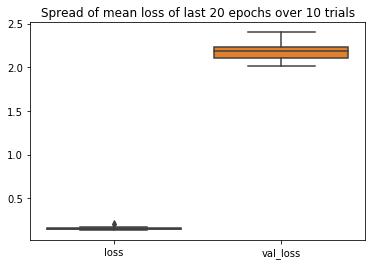

In [38]:
sns.boxplot(data=pd.DataFrame({'loss':[np.mean(h.history['loss'][-20:]) for h in histories],
                               'val_loss':[np.mean(h.history['val_loss'][-20:]) for h in histories]
                              }))
plt.title('Spread of mean loss of last 20 epochs over {} trials'.format(NUM_TRIALS))
plt.show()

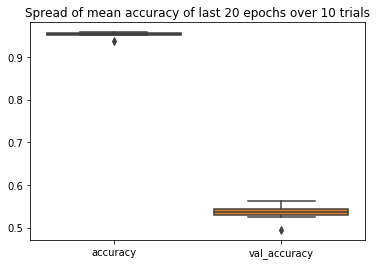

In [39]:
sns.boxplot(data=pd.DataFrame({'accuracy':[np.mean(h.history['accuracy'][-20:]) for h in histories],
                               'val_accuracy':[np.mean(h.history['val_accuracy'][-20:]) for h in histories]
                              }))
plt.title('Spread of mean accuracy of last 20 epochs over {} trials'.format(NUM_TRIALS))
plt.show()

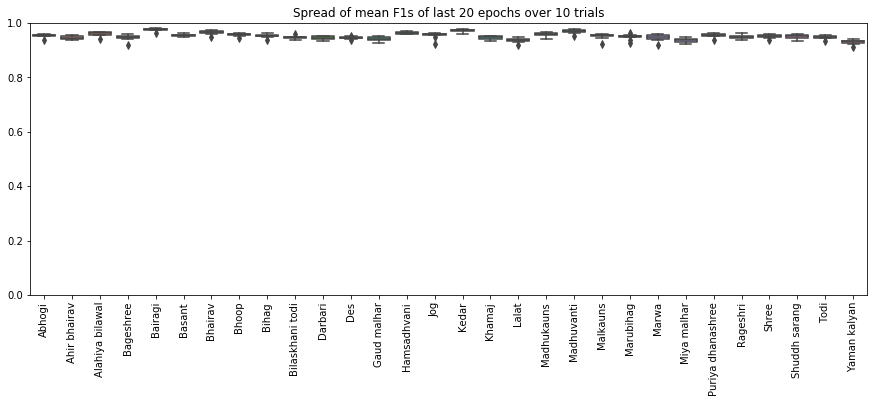

In [43]:
import seaborn as sns
fig=plt.figure(figsize=(15,5))
df=pd.DataFrame({ragas_reverse_idx[i]:[np.mean(h.history['F1_{}'.format(i)][-20:]) for h in histories] for i in range(30)})
ax=sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Spread of mean F1s of last 20 epochs over {} trials'.format(NUM_TRIALS))
plt.ylim(0,1)
plt.show()


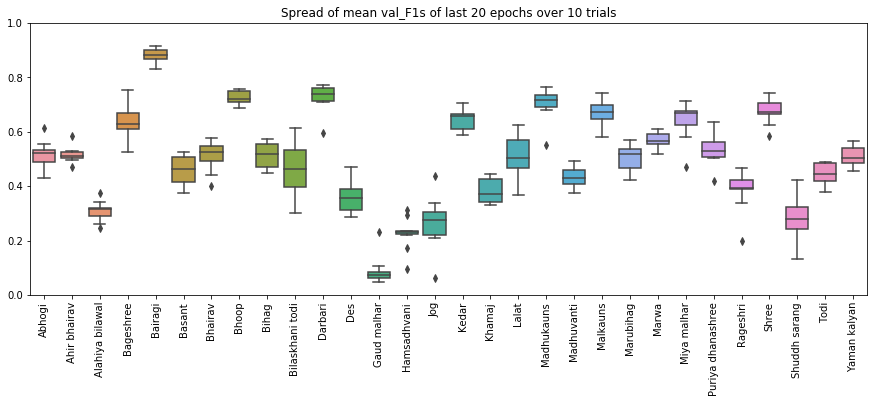

In [44]:
import seaborn as sns
fig=plt.figure(figsize=(15,5))
df=pd.DataFrame({ragas_reverse_idx[i]:[np.mean(h.history['val_F1_{}'.format(i)][-20:]) for h in histories] for i in range(30)})
ax=sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Spread of mean val_F1s of last 20 epochs over {} trials'.format(NUM_TRIALS))
plt.ylim(0,1)
plt.show()


In [47]:
cms=np.zeros(shape=(NUM_TRIALS,30,30))
for j,model in enumerate(models):
    y_pred=np.argmax(model.predict(X_val),axis=-1)
    y_true=y_val
    cms[j]=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)

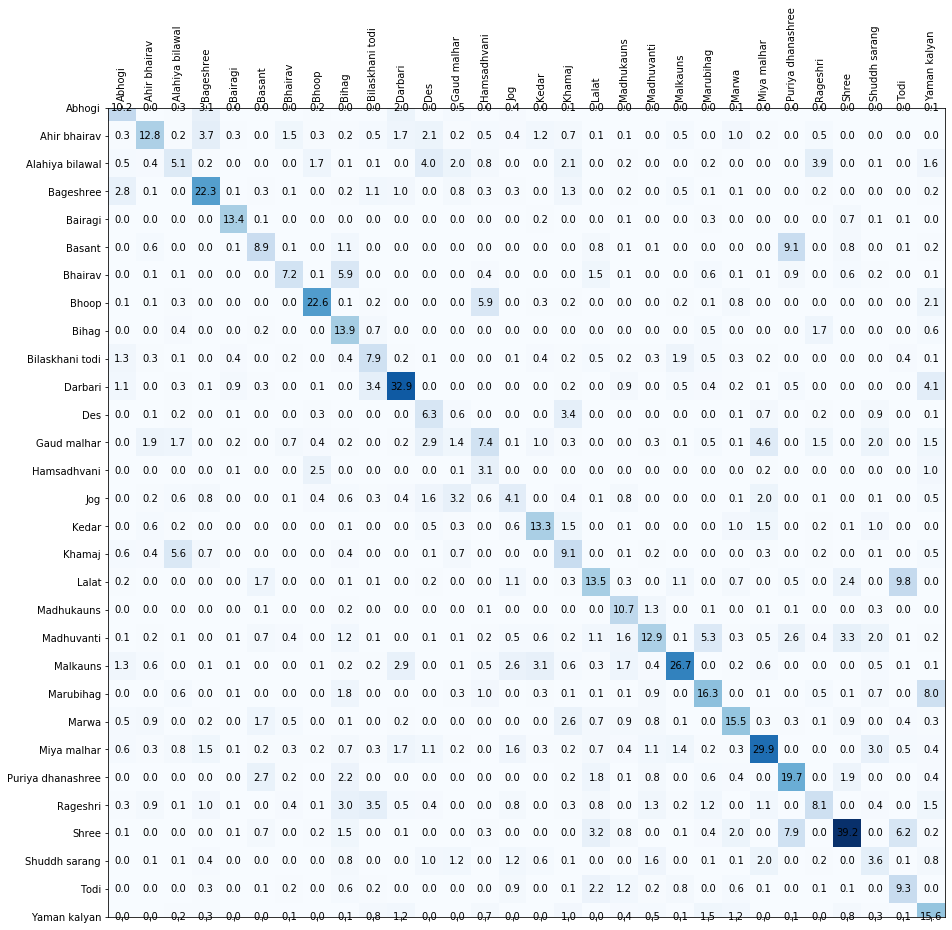

In [48]:
fig, ax = plt.subplots(figsize=(15,15))

cm_matrix=cms.mean(0)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, '{:.1f}'.format(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()


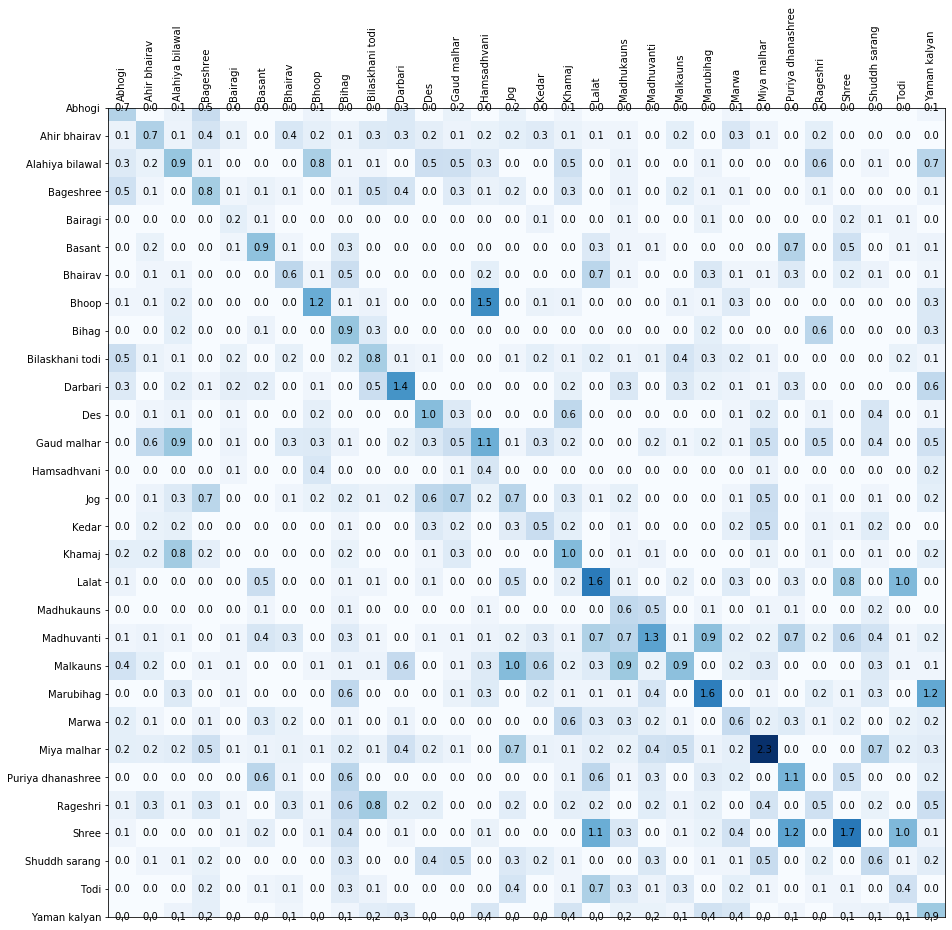

In [49]:
fig, ax = plt.subplots(figsize=(15,15))

cm_matrix=cms.std(0)/np.sqrt(NUM_TRIALS)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, '{:.1f}'.format(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()


# different data sets

In [6]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [8]:
sys.path.append('../')

In [9]:
import phononet as pn
import utils

In [10]:
from tensorflow.keras.layers import Conv2D
from utils import MySequential, \
    ConfusionMatrixMetric, \
    PeriodicPaddingConv2D, \
    gen, \
    OnlyTimeConvolution

In [11]:
chunk_size=1500
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=chunk_size)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=chunk_size)

X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,chunk_size]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 1843.77it/s]


In [12]:
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

In [13]:
def make_and_run_model(num_epochs=50, random_seed=42):
    
    train, test = cd.train_test_split(train_size=0.75,
                                      random_state=random_seed)  # split training and test sets from "full song" chromagrams
    train = pn.ChromaChunkDataset(train, chunk_size=chunk_size)  # divide training set into chunks of width 150
    test = pn.ChromaChunkDataset(test, chunk_size=chunk_size)

    X_train=train.X.numpy()
    y_train=np.array(train.y).astype(np.int8)

    X_val=test.X.numpy()
    y_val=np.array(test.y).astype(np.int8)

    BATCH_SIZE=32
    AUGMENT=True
    BALANCED=True
    train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                               output_shapes=(tf.TensorShape([12,chunk_size]),tf.TensorShape([])),
                                               output_types=(tf.float32,tf.int8)
                                              ).repeat().batch(BATCH_SIZE)
    val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

    kernel_initializer='he_uniform'
    leaky_relu_parameter=1e-2
    initial_time_only_conv=Sequential([
        OnlyTimeConvolution(100,100,strides=5,name='only_time_convolution',kernel_initializer=kernel_initializer),
        keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
        keras.layers.BatchNormalization(axis=[3]),
        keras.layers.MaxPool2D((1,2)),
        Conv2D(1,(1,1),padding='same'),
    ],name='initial_time_only_conv_encoder')
    
    dropout_prob=0.3
    PADDING_TYPE='valid'

    model=MySequential([
        keras.layers.Input(shape=(12,chunk_size)),
        keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
        keras.layers.BatchNormalization(axis=[3],name='norm0'),
        #
        initial_time_only_conv,
        #
        ConvBlock(64,(3,3),
                  name='conv_block_1',
                  zero_padding=(0,1),
                  padding=PADDING_TYPE,
                  kernel_initializer=kernel_initializer,
                  max_pool=(1,2),
                  dropout=dropout_prob,
                 ),
        ConvBlock(128,(3,3),
                  name='conv_block_2',
                  zero_padding=(0,1),
                  padding=PADDING_TYPE,
                  kernel_initializer=kernel_initializer,
                  max_pool=(1,3),
                  dropout=dropout_prob,
                 ),
        ConvBlock(150,(3,3),
                  name='conv_block_3',
                  zero_padding=(0,1),
                  padding=PADDING_TYPE,
                  kernel_initializer=kernel_initializer,
                  max_pool=(1,2),
                  dropout=dropout_prob,
                 ),
        ConvBlock(200,(3,3),
                  name='conv_block_4',
                  padding='same',
                  kernel_initializer=kernel_initializer,
                 ),
        keras.layers.GlobalAveragePooling2D(name='gba'),
        keras.layers.Dropout(dropout_prob,name='drop4'),
        #
        keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

    ])
    
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])
    
    history=model.fit(train_data,
                      validation_data=val_data,
                      epochs=num_epochs,
                      steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)
    return history, model

In [14]:
import time
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

ConvLayer=Conv2D

In [15]:
class ConvBlock(keras.layers.Layer):
    
    def __init__(self,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.max_pool=kwargs.pop('max_pool',None)
        self.dropout=kwargs.pop('dropout',None)
        self.zero_padding=kwargs.pop('zero_padding',None)
        self.args=args
        self.kwargs=kwargs
        
        
    def build(self,input_shape):
        layers=[tf.keras.layers.Input(shape=input_shape[1:])]
        if self.zero_padding is not None:
            layers.append(tf.keras.layers.ZeroPadding2D(padding=self.zero_padding))
        layers.extend([
            ConvLayer(*self.args,**self.kwargs),
            keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
            keras.layers.BatchNormalization(axis=[3]), # batch normalization on everything but last dimension
        ])
        if self.max_pool is not None:
            layers.append(keras.layers.MaxPool2D(self.max_pool))
        if self.dropout is not None:
            layers.append(keras.layers.Dropout(self.dropout))
        self.model=keras.Sequential(layers)
        
    def call(self,x):
        return self.model(x)

In [17]:
histories=[]
models=[]
NUM_TRIALS=10
NUM_EPOCHS=100
for j in range(NUM_TRIALS):
    t0=time.time()
    history, model=make_and_run_model(NUM_EPOCHS,random_seed=j)
    t1=time.time()
    print('*'*10,j,':',(t1-t0)/60,'*'*10)
    histories.append(history)
    models.append(model)

Epoch 1/100
74/74 [==============================] - 5s 62ms/step - loss: 3.4204 - accuracy: 0.0570 - F1_0: 0.0049 - F1_1: 0.0553 - F1_2: 0.0624 - F1_3: 0.1110 - F1_4: 0.0027 - F1_5: 0.0448 - F1_6: 0.0539 - F1_7: 0.0406 - F1_8: 6.9946e-04 - F1_9: 0.0146 - F1_10: 0.0020 - F1_11: 0.0502 - F1_12: 0.1393 - F1_13: 0.0231 - F1_14: 0.1185 - F1_15: 0.0310 - F1_16: 0.0561 - F1_17: 0.0000e+00 - F1_18: 0.0052 - F1_19: 0.0411 - F1_20: 0.0169 - F1_21: 0.0886 - F1_22: 0.0107 - F1_23: 0.0000e+00 - F1_24: 0.0184 - F1_25: 0.0623 - F1_26: 0.0187 - F1_27: 0.0520 - F1_28: 0.0289 - F1_29: 0.0000e+00 - val_loss: 3.3400 - val_accuracy: 0.0443 - val_F1_0: 0.0444 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1000 - val_F1_4: 0.0870 - val_F1_5: 0.2791 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0482 - val_F1_9: 0.0400 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0662 - val_F1_15: 0.0000e+00 - val_F1_16: 0.0000e+00 - 

74/74 [==============================] - 4s 50ms/step - loss: 1.7931 - accuracy: 0.4704 - F1_0: 0.4037 - F1_1: 0.2713 - F1_2: 0.3695 - F1_3: 0.3644 - F1_4: 0.5832 - F1_5: 0.4408 - F1_6: 0.6001 - F1_7: 0.5884 - F1_8: 0.4867 - F1_9: 0.3590 - F1_10: 0.5970 - F1_11: 0.3438 - F1_12: 0.3382 - F1_13: 0.4254 - F1_14: 0.5459 - F1_15: 0.6736 - F1_16: 0.4335 - F1_17: 0.3800 - F1_18: 0.4952 - F1_19: 0.4252 - F1_20: 0.4666 - F1_21: 0.3959 - F1_22: 0.4563 - F1_23: 0.2137 - F1_24: 0.4459 - F1_25: 0.2385 - F1_26: 0.4961 - F1_27: 0.2138 - F1_28: 0.3426 - F1_29: 0.5364 - val_loss: 2.8496 - val_accuracy: 0.2266 - val_F1_0: 0.2727 - val_F1_1: 0.1000 - val_F1_2: 0.2069 - val_F1_3: 0.1333 - val_F1_4: 0.6667 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0833 - val_F1_7: 0.4286 - val_F1_8: 0.2857 - val_F1_9: 0.1860 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.1333 - val_F1_13: 0.0000e+00 - val_F1_14: 0.2308 - val_F1_15: 0.3864 - val_F1_16: 0.1690 - val_F1_17: 0.1923 - val_F1_18: 0.1429 - val_F1_19: 0

Epoch 14/100
74/74 [==============================] - 4s 51ms/step - loss: 1.1021 - accuracy: 0.6681 - F1_0: 0.6950 - F1_1: 0.4910 - F1_2: 0.5754 - F1_3: 0.6846 - F1_4: 0.7170 - F1_5: 0.6521 - F1_6: 0.7001 - F1_7: 0.7655 - F1_8: 0.6878 - F1_9: 0.6173 - F1_10: 0.7293 - F1_11: 0.6463 - F1_12: 0.6099 - F1_13: 0.6469 - F1_14: 0.7726 - F1_15: 0.7495 - F1_16: 0.6114 - F1_17: 0.5254 - F1_18: 0.7831 - F1_19: 0.7335 - F1_20: 0.7631 - F1_21: 0.4852 - F1_22: 0.7152 - F1_23: 0.5756 - F1_24: 0.4717 - F1_25: 0.5258 - F1_26: 0.6316 - F1_27: 0.4988 - F1_28: 0.7418 - F1_29: 0.5671 - val_loss: 2.1911 - val_accuracy: 0.3997 - val_F1_0: 0.5294 - val_F1_1: 0.6389 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2687 - val_F1_4: 0.8163 - val_F1_5: 0.3793 - val_F1_6: 0.5000 - val_F1_7: 0.5098 - val_F1_8: 0.2400 - val_F1_9: 0.5000 - val_F1_10: 0.6531 - val_F1_11: 0.0952 - val_F1_12: 0.2222 - val_F1_13: 0.0000e+00 - val_F1_14: 0.3582 - val_F1_15: 0.4928 - val_F1_16: 0.1290 - val_F1_17: 0.2745 - val_F1_18: 0.1081 - val_F1_

Epoch 21/100
74/74 [==============================] - 4s 51ms/step - loss: 0.7625 - accuracy: 0.7703 - F1_0: 0.7231 - F1_1: 0.7476 - F1_2: 0.6446 - F1_3: 0.7934 - F1_4: 0.8608 - F1_5: 0.6996 - F1_6: 0.8069 - F1_7: 0.8585 - F1_8: 0.7675 - F1_9: 0.8973 - F1_10: 0.8474 - F1_11: 0.7704 - F1_12: 0.6980 - F1_13: 0.7951 - F1_14: 0.7964 - F1_15: 0.8506 - F1_16: 0.6277 - F1_17: 0.6659 - F1_18: 0.8275 - F1_19: 0.7211 - F1_20: 0.7284 - F1_21: 0.7232 - F1_22: 0.7798 - F1_23: 0.7693 - F1_24: 0.7290 - F1_25: 0.8084 - F1_26: 0.7537 - F1_27: 0.7004 - F1_28: 0.7087 - F1_29: 0.7811 - val_loss: 2.0513 - val_accuracy: 0.4492 - val_F1_0: 0.5517 - val_F1_1: 0.5352 - val_F1_2: 0.3333 - val_F1_3: 0.3750 - val_F1_4: 0.8276 - val_F1_5: 0.3103 - val_F1_6: 0.3077 - val_F1_7: 0.3667 - val_F1_8: 0.5484 - val_F1_9: 0.5333 - val_F1_10: 0.7692 - val_F1_11: 0.0968 - val_F1_12: 0.2927 - val_F1_13: 0.0000e+00 - val_F1_14: 0.2000 - val_F1_15: 0.6000 - val_F1_16: 0.3243 - val_F1_17: 0.3750 - val_F1_18: 0.3000 - val_F1_19: 

Epoch 28/100
74/74 [==============================] - 4s 52ms/step - loss: 0.5601 - accuracy: 0.8383 - F1_0: 0.7961 - F1_1: 0.8059 - F1_2: 0.7258 - F1_3: 0.7802 - F1_4: 0.9737 - F1_5: 0.8139 - F1_6: 0.8517 - F1_7: 0.8794 - F1_8: 0.7972 - F1_9: 0.7891 - F1_10: 0.8529 - F1_11: 0.8414 - F1_12: 0.7932 - F1_13: 0.9144 - F1_14: 0.8436 - F1_15: 0.9254 - F1_16: 0.7541 - F1_17: 0.7677 - F1_18: 0.9268 - F1_19: 0.7825 - F1_20: 0.8870 - F1_21: 0.8197 - F1_22: 0.8152 - F1_23: 0.7973 - F1_24: 0.7408 - F1_25: 0.7841 - F1_26: 0.8542 - F1_27: 0.8152 - F1_28: 0.8744 - F1_29: 0.7627 - val_loss: 2.1022 - val_accuracy: 0.4844 - val_F1_0: 0.6667 - val_F1_1: 0.5000 - val_F1_2: 0.2581 - val_F1_3: 0.5283 - val_F1_4: 0.9091 - val_F1_5: 0.2821 - val_F1_6: 0.1667 - val_F1_7: 0.4074 - val_F1_8: 0.3529 - val_F1_9: 0.5333 - val_F1_10: 0.7917 - val_F1_11: 0.1304 - val_F1_12: 0.5217 - val_F1_13: 0.2000 - val_F1_14: 0.3913 - val_F1_15: 0.6437 - val_F1_16: 0.4286 - val_F1_17: 0.4691 - val_F1_18: 0.4242 - val_F1_19: 0.80

Epoch 35/100
74/74 [==============================] - 4s 51ms/step - loss: 0.4282 - accuracy: 0.8720 - F1_0: 0.8118 - F1_1: 0.8023 - F1_2: 0.7879 - F1_3: 0.9139 - F1_4: 0.8913 - F1_5: 0.7762 - F1_6: 0.8469 - F1_7: 0.9666 - F1_8: 0.8401 - F1_9: 0.8960 - F1_10: 0.8446 - F1_11: 0.8938 - F1_12: 0.8766 - F1_13: 0.9523 - F1_14: 0.8481 - F1_15: 0.9437 - F1_16: 0.8416 - F1_17: 0.8116 - F1_18: 0.9285 - F1_19: 0.9153 - F1_20: 0.8852 - F1_21: 0.8995 - F1_22: 0.7925 - F1_23: 0.8318 - F1_24: 0.8226 - F1_25: 0.8487 - F1_26: 0.7118 - F1_27: 0.8454 - F1_28: 0.8095 - F1_29: 0.8050 - val_loss: 2.0292 - val_accuracy: 0.4987 - val_F1_0: 0.8205 - val_F1_1: 0.5294 - val_F1_2: 0.1538 - val_F1_3: 0.4746 - val_F1_4: 0.9057 - val_F1_5: 0.4091 - val_F1_6: 0.3333 - val_F1_7: 0.4746 - val_F1_8: 0.4815 - val_F1_9: 0.5231 - val_F1_10: 0.7143 - val_F1_11: 0.1429 - val_F1_12: 0.3846 - val_F1_13: 0.1667 - val_F1_14: 0.2000 - val_F1_15: 0.6829 - val_F1_16: 0.3429 - val_F1_17: 0.4590 - val_F1_18: 0.2609 - val_F1_19: 0.82

Epoch 42/100
74/74 [==============================] - 4s 51ms/step - loss: 0.3389 - accuracy: 0.9016 - F1_0: 0.9393 - F1_1: 0.8998 - F1_2: 0.8594 - F1_3: 0.8860 - F1_4: 0.9572 - F1_5: 0.8586 - F1_6: 0.9645 - F1_7: 0.8505 - F1_8: 0.8974 - F1_9: 0.9221 - F1_10: 0.8912 - F1_11: 0.9119 - F1_12: 0.8330 - F1_13: 0.8683 - F1_14: 0.9086 - F1_15: 0.9089 - F1_16: 0.9242 - F1_17: 0.8362 - F1_18: 0.9382 - F1_19: 0.8566 - F1_20: 0.8612 - F1_21: 0.8613 - F1_22: 0.9055 - F1_23: 0.8874 - F1_24: 0.8800 - F1_25: 0.9221 - F1_26: 0.9233 - F1_27: 0.8736 - F1_28: 0.9010 - F1_29: 0.8263 - val_loss: 1.9581 - val_accuracy: 0.5143 - val_F1_0: 0.8421 - val_F1_1: 0.5526 - val_F1_2: 0.1739 - val_F1_3: 0.4222 - val_F1_4: 0.8621 - val_F1_5: 0.3810 - val_F1_6: 0.3704 - val_F1_7: 0.4898 - val_F1_8: 0.5000 - val_F1_9: 0.5000 - val_F1_10: 0.7907 - val_F1_11: 0.0909 - val_F1_12: 0.5185 - val_F1_13: 0.2500 - val_F1_14: 0.0952 - val_F1_15: 0.6667 - val_F1_16: 0.2500 - val_F1_17: 0.5974 - val_F1_18: 0.3846 - val_F1_19: 0.78

Epoch 49/100
74/74 [==============================] - 4s 52ms/step - loss: 0.2888 - accuracy: 0.9210 - F1_0: 0.8945 - F1_1: 0.9091 - F1_2: 0.9152 - F1_3: 0.8688 - F1_4: 0.9828 - F1_5: 0.9260 - F1_6: 0.9433 - F1_7: 0.9561 - F1_8: 0.9390 - F1_9: 0.9407 - F1_10: 0.8264 - F1_11: 0.9678 - F1_12: 0.9165 - F1_13: 0.9081 - F1_14: 0.9260 - F1_15: 0.9907 - F1_16: 0.8923 - F1_17: 0.8756 - F1_18: 0.9138 - F1_19: 0.9176 - F1_20: 0.9600 - F1_21: 0.9604 - F1_22: 0.9401 - F1_23: 0.9343 - F1_24: 0.8645 - F1_25: 0.8926 - F1_26: 0.9363 - F1_27: 0.9569 - F1_28: 0.9589 - F1_29: 0.8940 - val_loss: 2.1604 - val_accuracy: 0.5117 - val_F1_0: 0.7500 - val_F1_1: 0.5263 - val_F1_2: 0.1875 - val_F1_3: 0.5231 - val_F1_4: 0.8571 - val_F1_5: 0.4528 - val_F1_6: 0.4286 - val_F1_7: 0.4675 - val_F1_8: 0.5116 - val_F1_9: 0.4375 - val_F1_10: 0.5846 - val_F1_11: 0.2034 - val_F1_12: 0.5263 - val_F1_13: 0.4444 - val_F1_14: 0.1961 - val_F1_15: 0.7368 - val_F1_16: 0.4615 - val_F1_17: 0.3509 - val_F1_18: 0.4138 - val_F1_19: 0.88

Epoch 56/100
74/74 [==============================] - 4s 50ms/step - loss: 0.2622 - accuracy: 0.9215 - F1_0: 0.8899 - F1_1: 0.9211 - F1_2: 0.9017 - F1_3: 0.9447 - F1_4: 0.9784 - F1_5: 0.9372 - F1_6: 0.9131 - F1_7: 0.9640 - F1_8: 0.8646 - F1_9: 0.8884 - F1_10: 0.8489 - F1_11: 0.9275 - F1_12: 0.9090 - F1_13: 0.9389 - F1_14: 0.8612 - F1_15: 0.9508 - F1_16: 0.8762 - F1_17: 0.8350 - F1_18: 0.9774 - F1_19: 0.8718 - F1_20: 0.8970 - F1_21: 0.9169 - F1_22: 0.9033 - F1_23: 0.8733 - F1_24: 0.9116 - F1_25: 0.9594 - F1_26: 0.8972 - F1_27: 0.9139 - F1_28: 0.9048 - F1_29: 0.8840 - val_loss: 2.1628 - val_accuracy: 0.5352 - val_F1_0: 0.7333 - val_F1_1: 0.5484 - val_F1_2: 0.2581 - val_F1_3: 0.4912 - val_F1_4: 0.8929 - val_F1_5: 0.2143 - val_F1_6: 0.3704 - val_F1_7: 0.4762 - val_F1_8: 0.6038 - val_F1_9: 0.5833 - val_F1_10: 0.6800 - val_F1_11: 0.1333 - val_F1_12: 0.4912 - val_F1_13: 0.1667 - val_F1_14: 0.3077 - val_F1_15: 0.7123 - val_F1_16: 0.3871 - val_F1_17: 0.4483 - val_F1_18: 0.3158 - val_F1_19: 0.71

Epoch 63/100
74/74 [==============================] - 4s 51ms/step - loss: 0.2129 - accuracy: 0.9350 - F1_0: 0.9221 - F1_1: 0.8766 - F1_2: 0.8903 - F1_3: 0.9216 - F1_4: 0.9665 - F1_5: 0.8655 - F1_6: 0.9707 - F1_7: 0.9756 - F1_8: 0.9474 - F1_9: 0.9607 - F1_10: 0.9001 - F1_11: 0.9861 - F1_12: 0.9347 - F1_13: 0.9649 - F1_14: 0.9620 - F1_15: 0.9482 - F1_16: 0.9165 - F1_17: 0.9062 - F1_18: 0.9598 - F1_19: 0.9093 - F1_20: 0.9474 - F1_21: 0.9251 - F1_22: 0.9453 - F1_23: 0.9761 - F1_24: 0.8619 - F1_25: 0.9106 - F1_26: 0.9294 - F1_27: 0.9772 - F1_28: 0.9348 - F1_29: 0.8944 - val_loss: 2.0900 - val_accuracy: 0.5495 - val_F1_0: 0.8649 - val_F1_1: 0.5429 - val_F1_2: 0.0909 - val_F1_3: 0.4828 - val_F1_4: 0.8333 - val_F1_5: 0.4324 - val_F1_6: 0.3448 - val_F1_7: 0.4286 - val_F1_8: 0.5000 - val_F1_9: 0.5538 - val_F1_10: 0.7234 - val_F1_11: 0.1053 - val_F1_12: 0.4643 - val_F1_13: 0.1429 - val_F1_14: 0.4000 - val_F1_15: 0.6506 - val_F1_16: 0.4571 - val_F1_17: 0.5435 - val_F1_18: 0.3636 - val_F1_19: 0.82

Epoch 70/100
74/74 [==============================] - 4s 51ms/step - loss: 0.1926 - accuracy: 0.9383 - F1_0: 0.9727 - F1_1: 0.9125 - F1_2: 0.9447 - F1_3: 0.9830 - F1_4: 0.9258 - F1_5: 0.9716 - F1_6: 0.9800 - F1_7: 0.8565 - F1_8: 0.9272 - F1_9: 0.9647 - F1_10: 0.9265 - F1_11: 0.9066 - F1_12: 0.9378 - F1_13: 0.9611 - F1_14: 0.9273 - F1_15: 0.9477 - F1_16: 0.8942 - F1_17: 0.9124 - F1_18: 0.9881 - F1_19: 0.9082 - F1_20: 0.9055 - F1_21: 0.8474 - F1_22: 0.9366 - F1_23: 0.9418 - F1_24: 0.9291 - F1_25: 0.9801 - F1_26: 0.9414 - F1_27: 0.9109 - F1_28: 0.9495 - F1_29: 0.8857 - val_loss: 2.1197 - val_accuracy: 0.5365 - val_F1_0: 0.8095 - val_F1_1: 0.5897 - val_F1_2: 0.1053 - val_F1_3: 0.4643 - val_F1_4: 0.8621 - val_F1_5: 0.2400 - val_F1_6: 0.4000 - val_F1_7: 0.4528 - val_F1_8: 0.3704 - val_F1_9: 0.4727 - val_F1_10: 0.6977 - val_F1_11: 0.0000e+00 - val_F1_12: 0.4800 - val_F1_13: 0.1538 - val_F1_14: 0.3235 - val_F1_15: 0.7209 - val_F1_16: 0.2609 - val_F1_17: 0.4286 - val_F1_18: 0.4000 - val_F1_19: 

Epoch 77/100
74/74 [==============================] - 4s 51ms/step - loss: 0.1825 - accuracy: 0.9459 - F1_0: 0.9502 - F1_1: 0.9207 - F1_2: 0.9606 - F1_3: 0.9282 - F1_4: 0.9698 - F1_5: 0.9494 - F1_6: 0.8858 - F1_7: 0.9617 - F1_8: 0.9077 - F1_9: 0.9448 - F1_10: 0.9536 - F1_11: 0.9805 - F1_12: 0.9316 - F1_13: 0.9073 - F1_14: 0.9064 - F1_15: 0.9801 - F1_16: 0.9301 - F1_17: 0.9399 - F1_18: 0.9442 - F1_19: 0.9464 - F1_20: 0.9829 - F1_21: 0.8985 - F1_22: 0.9684 - F1_23: 0.9042 - F1_24: 0.9488 - F1_25: 0.9220 - F1_26: 0.9328 - F1_27: 0.9202 - F1_28: 0.9167 - F1_29: 0.9460 - val_loss: 2.2774 - val_accuracy: 0.5260 - val_F1_0: 0.7727 - val_F1_1: 0.5479 - val_F1_2: 0.1600 - val_F1_3: 0.5000 - val_F1_4: 0.8727 - val_F1_5: 0.1212 - val_F1_6: 0.3256 - val_F1_7: 0.4407 - val_F1_8: 0.5000 - val_F1_9: 0.5397 - val_F1_10: 0.7826 - val_F1_11: 0.0667 - val_F1_12: 0.5769 - val_F1_13: 0.1667 - val_F1_14: 0.2000 - val_F1_15: 0.7250 - val_F1_16: 0.3750 - val_F1_17: 0.3226 - val_F1_18: 0.4800 - val_F1_19: 0.83

Epoch 84/100
74/74 [==============================] - 4s 51ms/step - loss: 0.1453 - accuracy: 0.9535 - F1_0: 0.9487 - F1_1: 0.8309 - F1_2: 0.8914 - F1_3: 0.9273 - F1_4: 0.9960 - F1_5: 0.9814 - F1_6: 0.9673 - F1_7: 0.9368 - F1_8: 0.9327 - F1_9: 0.9623 - F1_10: 0.9785 - F1_11: 0.9619 - F1_12: 0.9030 - F1_13: 0.9726 - F1_14: 0.8373 - F1_15: 0.9508 - F1_16: 0.9003 - F1_17: 0.9549 - F1_18: 0.9766 - F1_19: 0.9136 - F1_20: 0.9445 - F1_21: 0.9365 - F1_22: 0.9865 - F1_23: 0.9208 - F1_24: 0.9788 - F1_25: 0.9796 - F1_26: 0.9450 - F1_27: 0.9521 - F1_28: 0.9187 - F1_29: 0.8913 - val_loss: 2.4176 - val_accuracy: 0.4987 - val_F1_0: 0.7097 - val_F1_1: 0.5484 - val_F1_2: 0.1860 - val_F1_3: 0.4667 - val_F1_4: 0.8621 - val_F1_5: 0.3019 - val_F1_6: 0.5455 - val_F1_7: 0.4583 - val_F1_8: 0.4727 - val_F1_9: 0.5231 - val_F1_10: 0.7179 - val_F1_11: 0.2703 - val_F1_12: 0.4231 - val_F1_13: 0.0000e+00 - val_F1_14: 0.1481 - val_F1_15: 0.6761 - val_F1_16: 0.2745 - val_F1_17: 0.4478 - val_F1_18: 0.2222 - val_F1_19: 

Epoch 91/100
74/74 [==============================] - 4s 50ms/step - loss: 0.1352 - accuracy: 0.9603 - F1_0: 0.9520 - F1_1: 0.8636 - F1_2: 0.9289 - F1_3: 0.9691 - F1_4: 0.9908 - F1_5: 0.9419 - F1_6: 0.9389 - F1_7: 0.9744 - F1_8: 0.9748 - F1_9: 0.9561 - F1_10: 0.9830 - F1_11: 0.9557 - F1_12: 0.9598 - F1_13: 0.9461 - F1_14: 0.9429 - F1_15: 0.9599 - F1_16: 0.8902 - F1_17: 0.9581 - F1_18: 0.9947 - F1_19: 0.9162 - F1_20: 0.9533 - F1_21: 0.9699 - F1_22: 0.9154 - F1_23: 0.9510 - F1_24: 0.9190 - F1_25: 0.9022 - F1_26: 0.9456 - F1_27: 0.9110 - F1_28: 0.9689 - F1_29: 0.9620 - val_loss: 2.2660 - val_accuracy: 0.5430 - val_F1_0: 0.4615 - val_F1_1: 0.6176 - val_F1_2: 0.1538 - val_F1_3: 0.4324 - val_F1_4: 0.8333 - val_F1_5: 0.4706 - val_F1_6: 0.5000 - val_F1_7: 0.5366 - val_F1_8: 0.5070 - val_F1_9: 0.5667 - val_F1_10: 0.7234 - val_F1_11: 0.1538 - val_F1_12: 0.4419 - val_F1_13: 0.0000e+00 - val_F1_14: 0.3662 - val_F1_15: 0.6118 - val_F1_16: 0.2143 - val_F1_17: 0.4800 - val_F1_18: 0.3846 - val_F1_19: 

Epoch 98/100
74/74 [==============================] - 4s 51ms/step - loss: 0.1132 - accuracy: 0.9649 - F1_0: 0.9995 - F1_1: 0.9463 - F1_2: 0.8775 - F1_3: 0.9777 - F1_4: 0.9952 - F1_5: 0.9073 - F1_6: 0.9665 - F1_7: 0.9579 - F1_8: 0.9435 - F1_9: 0.9971 - F1_10: 0.9567 - F1_11: 0.9802 - F1_12: 0.9234 - F1_13: 0.9965 - F1_14: 0.9833 - F1_15: 0.9526 - F1_16: 0.8537 - F1_17: 0.9463 - F1_18: 0.9696 - F1_19: 0.9798 - F1_20: 0.9577 - F1_21: 0.9424 - F1_22: 0.9613 - F1_23: 0.9656 - F1_24: 0.9437 - F1_25: 0.9794 - F1_26: 0.9235 - F1_27: 0.9690 - F1_28: 0.9462 - F1_29: 0.9642 - val_loss: 2.3923 - val_accuracy: 0.5247 - val_F1_0: 0.6316 - val_F1_1: 0.4872 - val_F1_2: 0.2000 - val_F1_3: 0.4789 - val_F1_4: 0.8065 - val_F1_5: 0.3125 - val_F1_6: 0.2857 - val_F1_7: 0.4407 - val_F1_8: 0.4444 - val_F1_9: 0.5313 - val_F1_10: 0.6486 - val_F1_11: 0.0690 - val_F1_12: 0.5957 - val_F1_13: 0.1818 - val_F1_14: 0.4058 - val_F1_15: 0.7568 - val_F1_16: 0.3429 - val_F1_17: 0.2222 - val_F1_18: 0.5000 - val_F1_19: 0.93

73/73 [==============================] - 4s 50ms/step - loss: 3.1435 - accuracy: 0.1122 - F1_0: 0.0714 - F1_1: 0.0661 - F1_2: 0.0533 - F1_3: 0.0545 - F1_4: 0.0608 - F1_5: 0.2227 - F1_6: 0.0170 - F1_7: 0.0195 - F1_8: 0.1305 - F1_9: 0.0484 - F1_10: 0.0744 - F1_11: 0.0435 - F1_12: 0.0253 - F1_13: 0.1924 - F1_14: 0.0210 - F1_15: 0.0971 - F1_16: 0.1462 - F1_17: 0.0355 - F1_18: 0.0464 - F1_19: 0.0000e+00 - F1_20: 0.0138 - F1_21: 0.1021 - F1_22: 0.0988 - F1_23: 0.0241 - F1_24: 0.1774 - F1_25: 0.1019 - F1_26: 0.1694 - F1_27: 0.0204 - F1_28: 0.0957 - F1_29: 0.0333 - val_loss: 3.9276 - val_accuracy: 0.0585 - val_F1_0: 0.0000e+00 - val_F1_1: 0.1081 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1000 - val_F1_4: 0.0000e+00 - val_F1_5: 0.1212 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0741 - val_F1_8: 0.2222 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0308 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0976 - val_F1_14: 0.0000e+00 - val_F1_15: 0.1017 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 - val_

Epoch 11/100
73/73 [==============================] - 4s 50ms/step - loss: 1.8423 - accuracy: 0.4645 - F1_0: 0.5298 - F1_1: 0.3561 - F1_2: 0.3873 - F1_3: 0.3748 - F1_4: 0.5403 - F1_5: 0.5625 - F1_6: 0.4875 - F1_7: 0.4404 - F1_8: 0.3656 - F1_9: 0.2841 - F1_10: 0.4896 - F1_11: 0.5061 - F1_12: 0.2715 - F1_13: 0.7102 - F1_14: 0.3253 - F1_15: 0.5080 - F1_16: 0.4232 - F1_17: 0.3516 - F1_18: 0.5465 - F1_19: 0.4448 - F1_20: 0.4892 - F1_21: 0.4463 - F1_22: 0.4249 - F1_23: 0.2058 - F1_24: 0.5415 - F1_25: 0.3312 - F1_26: 0.3836 - F1_27: 0.5100 - F1_28: 0.3458 - F1_29: 0.4118 - val_loss: 2.4838 - val_accuracy: 0.2827 - val_F1_0: 0.2105 - val_F1_1: 0.3913 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1905 - val_F1_4: 0.2632 - val_F1_5: 0.4250 - val_F1_6: 0.2353 - val_F1_7: 0.4167 - val_F1_8: 0.3765 - val_F1_9: 0.1250 - val_F1_10: 0.1600 - val_F1_11: 0.1250 - val_F1_12: 0.2609 - val_F1_13: 0.2000 - val_F1_14: 0.0779 - val_F1_15: 0.3178 - val_F1_16: 0.2090 - val_F1_17: 0.0000e+00 - val_F1_18: 0.4333 - val_F1_

Epoch 18/100
73/73 [==============================] - 4s 50ms/step - loss: 1.1762 - accuracy: 0.6455 - F1_0: 0.6612 - F1_1: 0.6655 - F1_2: 0.6110 - F1_3: 0.6980 - F1_4: 0.8573 - F1_5: 0.5675 - F1_6: 0.6979 - F1_7: 0.6678 - F1_8: 0.6025 - F1_9: 0.5933 - F1_10: 0.5875 - F1_11: 0.5174 - F1_12: 0.5166 - F1_13: 0.7441 - F1_14: 0.6132 - F1_15: 0.7763 - F1_16: 0.5804 - F1_17: 0.3771 - F1_18: 0.7524 - F1_19: 0.6210 - F1_20: 0.4572 - F1_21: 0.6240 - F1_22: 0.5261 - F1_23: 0.5315 - F1_24: 0.6061 - F1_25: 0.5436 - F1_26: 0.6531 - F1_27: 0.5564 - F1_28: 0.6905 - F1_29: 0.4711 - val_loss: 2.1648 - val_accuracy: 0.3873 - val_F1_0: 0.1667 - val_F1_1: 0.6275 - val_F1_2: 0.1935 - val_F1_3: 0.3415 - val_F1_4: 0.3784 - val_F1_5: 0.3944 - val_F1_6: 0.3000 - val_F1_7: 0.4948 - val_F1_8: 0.4110 - val_F1_9: 0.2000 - val_F1_10: 0.4138 - val_F1_11: 0.1000 - val_F1_12: 0.1538 - val_F1_13: 0.2222 - val_F1_14: 0.6250 - val_F1_15: 0.4800 - val_F1_16: 0.1429 - val_F1_17: 0.2791 - val_F1_18: 0.5185 - val_F1_19: 0.66

Epoch 25/100
73/73 [==============================] - 4s 50ms/step - loss: 0.7998 - accuracy: 0.7620 - F1_0: 0.9159 - F1_1: 0.7736 - F1_2: 0.7729 - F1_3: 0.7123 - F1_4: 0.8720 - F1_5: 0.7628 - F1_6: 0.7013 - F1_7: 0.7303 - F1_8: 0.8116 - F1_9: 0.8019 - F1_10: 0.7469 - F1_11: 0.7587 - F1_12: 0.6557 - F1_13: 0.8921 - F1_14: 0.7348 - F1_15: 0.8633 - F1_16: 0.8211 - F1_17: 0.5077 - F1_18: 0.7858 - F1_19: 0.7516 - F1_20: 0.7107 - F1_21: 0.7539 - F1_22: 0.8140 - F1_23: 0.6332 - F1_24: 0.6634 - F1_25: 0.8704 - F1_26: 0.7903 - F1_27: 0.7381 - F1_28: 0.7548 - F1_29: 0.7528 - val_loss: 2.1787 - val_accuracy: 0.3699 - val_F1_0: 0.2041 - val_F1_1: 0.5882 - val_F1_2: 0.3218 - val_F1_3: 0.2703 - val_F1_4: 0.3019 - val_F1_5: 0.3232 - val_F1_6: 0.3200 - val_F1_7: 0.4957 - val_F1_8: 0.4681 - val_F1_9: 0.2326 - val_F1_10: 0.2308 - val_F1_11: 0.0000e+00 - val_F1_12: 0.3256 - val_F1_13: 0.2597 - val_F1_14: 0.5479 - val_F1_15: 0.5854 - val_F1_16: 0.0000e+00 - val_F1_17: 0.2143 - val_F1_18: 0.4727 - val_F1_

Epoch 32/100
73/73 [==============================] - 4s 50ms/step - loss: 0.6323 - accuracy: 0.8138 - F1_0: 0.8201 - F1_1: 0.7884 - F1_2: 0.8133 - F1_3: 0.7874 - F1_4: 0.9359 - F1_5: 0.8091 - F1_6: 0.8495 - F1_7: 0.8430 - F1_8: 0.7739 - F1_9: 0.8416 - F1_10: 0.8360 - F1_11: 0.7126 - F1_12: 0.6188 - F1_13: 0.9238 - F1_14: 0.8817 - F1_15: 0.8295 - F1_16: 0.7626 - F1_17: 0.6994 - F1_18: 0.9373 - F1_19: 0.7753 - F1_20: 0.7299 - F1_21: 0.8372 - F1_22: 0.8442 - F1_23: 0.6322 - F1_24: 0.7456 - F1_25: 0.7708 - F1_26: 0.7014 - F1_27: 0.7466 - F1_28: 0.7529 - F1_29: 0.6902 - val_loss: 1.9197 - val_accuracy: 0.4545 - val_F1_0: 0.3077 - val_F1_1: 0.6552 - val_F1_2: 0.0513 - val_F1_3: 0.5556 - val_F1_4: 0.7619 - val_F1_5: 0.4884 - val_F1_6: 0.3333 - val_F1_7: 0.5405 - val_F1_8: 0.4500 - val_F1_9: 0.5714 - val_F1_10: 0.7692 - val_F1_11: 0.2000 - val_F1_12: 0.3789 - val_F1_13: 0.3056 - val_F1_14: 0.6842 - val_F1_15: 0.5490 - val_F1_16: 0.1250 - val_F1_17: 0.1818 - val_F1_18: 0.4138 - val_F1_19: 0.32

Epoch 39/100
73/73 [==============================] - 4s 50ms/step - loss: 0.4733 - accuracy: 0.8579 - F1_0: 0.8516 - F1_1: 0.8981 - F1_2: 0.8174 - F1_3: 0.7650 - F1_4: 0.9382 - F1_5: 0.8858 - F1_6: 0.8741 - F1_7: 0.8073 - F1_8: 0.8192 - F1_9: 0.8808 - F1_10: 0.7716 - F1_11: 0.7917 - F1_12: 0.8229 - F1_13: 0.9583 - F1_14: 0.8791 - F1_15: 0.8713 - F1_16: 0.8810 - F1_17: 0.8370 - F1_18: 0.9316 - F1_19: 0.8545 - F1_20: 0.7896 - F1_21: 0.8325 - F1_22: 0.8755 - F1_23: 0.7726 - F1_24: 0.8399 - F1_25: 0.8410 - F1_26: 0.8805 - F1_27: 0.7106 - F1_28: 0.8011 - F1_29: 0.8164 - val_loss: 1.8587 - val_accuracy: 0.4844 - val_F1_0: 0.4000 - val_F1_1: 0.5610 - val_F1_2: 0.1935 - val_F1_3: 0.6512 - val_F1_4: 0.7619 - val_F1_5: 0.4583 - val_F1_6: 0.5000 - val_F1_7: 0.6142 - val_F1_8: 0.5532 - val_F1_9: 0.4828 - val_F1_10: 0.6835 - val_F1_11: 0.1818 - val_F1_12: 0.5000 - val_F1_13: 0.2500 - val_F1_14: 0.6970 - val_F1_15: 0.6316 - val_F1_16: 0.0690 - val_F1_17: 0.4103 - val_F1_18: 0.4444 - val_F1_19: 0.66

Epoch 46/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3913 - accuracy: 0.8878 - F1_0: 0.8447 - F1_1: 0.8490 - F1_2: 0.8775 - F1_3: 0.8536 - F1_4: 0.9724 - F1_5: 0.7760 - F1_6: 0.8959 - F1_7: 0.9349 - F1_8: 0.8646 - F1_9: 0.9623 - F1_10: 0.9070 - F1_11: 0.8639 - F1_12: 0.8403 - F1_13: 0.9881 - F1_14: 0.8810 - F1_15: 0.8989 - F1_16: 0.8953 - F1_17: 0.7501 - F1_18: 0.8997 - F1_19: 0.8872 - F1_20: 0.9129 - F1_21: 0.8043 - F1_22: 0.8966 - F1_23: 0.8087 - F1_24: 0.8794 - F1_25: 0.8802 - F1_26: 0.8335 - F1_27: 0.8123 - F1_28: 0.9030 - F1_29: 0.8490 - val_loss: 1.9237 - val_accuracy: 0.4956 - val_F1_0: 0.3721 - val_F1_1: 0.6667 - val_F1_2: 0.0556 - val_F1_3: 0.7170 - val_F1_4: 0.7000 - val_F1_5: 0.3333 - val_F1_6: 0.3333 - val_F1_7: 0.5532 - val_F1_8: 0.5490 - val_F1_9: 0.6122 - val_F1_10: 0.6744 - val_F1_11: 0.2308 - val_F1_12: 0.5652 - val_F1_13: 0.2740 - val_F1_14: 0.7105 - val_F1_15: 0.6809 - val_F1_16: 0.2105 - val_F1_17: 0.4375 - val_F1_18: 0.4912 - val_F1_19: 0.80

Epoch 53/100
73/73 [==============================] - 4s 50ms/step - loss: 0.3246 - accuracy: 0.9037 - F1_0: 0.8995 - F1_1: 0.8537 - F1_2: 0.9420 - F1_3: 0.9364 - F1_4: 0.9846 - F1_5: 0.8965 - F1_6: 0.8967 - F1_7: 0.8579 - F1_8: 0.8563 - F1_9: 0.9024 - F1_10: 0.9311 - F1_11: 0.9571 - F1_12: 0.8382 - F1_13: 0.9572 - F1_14: 0.9031 - F1_15: 0.9378 - F1_16: 0.8853 - F1_17: 0.8569 - F1_18: 0.9299 - F1_19: 0.9366 - F1_20: 0.8853 - F1_21: 0.9026 - F1_22: 0.8965 - F1_23: 0.8723 - F1_24: 0.9060 - F1_25: 0.7819 - F1_26: 0.9202 - F1_27: 0.9402 - F1_28: 0.8229 - F1_29: 0.8769 - val_loss: 2.0299 - val_accuracy: 0.4807 - val_F1_0: 0.3902 - val_F1_1: 0.7077 - val_F1_2: 0.1463 - val_F1_3: 0.6667 - val_F1_4: 0.5333 - val_F1_5: 0.4286 - val_F1_6: 0.4762 - val_F1_7: 0.6372 - val_F1_8: 0.7000 - val_F1_9: 0.2667 - val_F1_10: 0.5231 - val_F1_11: 0.3200 - val_F1_12: 0.4211 - val_F1_13: 0.0930 - val_F1_14: 0.5600 - val_F1_15: 0.6087 - val_F1_16: 0.3137 - val_F1_17: 0.4571 - val_F1_18: 0.6000 - val_F1_19: 0.72

Epoch 60/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2479 - accuracy: 0.9294 - F1_0: 0.8940 - F1_1: 0.9012 - F1_2: 0.8635 - F1_3: 0.9497 - F1_4: 0.9842 - F1_5: 0.9575 - F1_6: 0.9182 - F1_7: 0.9639 - F1_8: 0.9483 - F1_9: 0.9532 - F1_10: 0.9593 - F1_11: 0.9265 - F1_12: 0.8515 - F1_13: 0.9823 - F1_14: 0.8667 - F1_15: 0.9060 - F1_16: 0.9542 - F1_17: 0.8534 - F1_18: 0.9475 - F1_19: 0.9430 - F1_20: 0.9123 - F1_21: 0.9104 - F1_22: 0.9585 - F1_23: 0.8500 - F1_24: 0.9753 - F1_25: 0.8879 - F1_26: 0.8490 - F1_27: 0.9012 - F1_28: 0.9584 - F1_29: 0.8925 - val_loss: 1.9091 - val_accuracy: 0.5230 - val_F1_0: 0.4865 - val_F1_1: 0.7119 - val_F1_2: 0.0588 - val_F1_3: 0.6552 - val_F1_4: 0.5926 - val_F1_5: 0.4483 - val_F1_6: 0.2609 - val_F1_7: 0.4889 - val_F1_8: 0.5263 - val_F1_9: 0.5538 - val_F1_10: 0.6842 - val_F1_11: 0.2703 - val_F1_12: 0.5507 - val_F1_13: 0.3678 - val_F1_14: 0.7105 - val_F1_15: 0.6809 - val_F1_16: 0.1429 - val_F1_17: 0.5000 - val_F1_18: 0.5556 - val_F1_19: 0.69

Epoch 67/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2384 - accuracy: 0.9298 - F1_0: 0.9903 - F1_1: 0.9276 - F1_2: 0.9573 - F1_3: 0.9176 - F1_4: 0.9600 - F1_5: 0.9451 - F1_6: 0.9459 - F1_7: 0.9403 - F1_8: 0.9141 - F1_9: 0.8927 - F1_10: 0.9733 - F1_11: 0.9314 - F1_12: 0.8570 - F1_13: 0.9471 - F1_14: 0.8451 - F1_15: 0.9360 - F1_16: 0.9513 - F1_17: 0.8915 - F1_18: 0.9335 - F1_19: 0.9385 - F1_20: 0.9178 - F1_21: 0.9432 - F1_22: 0.8735 - F1_23: 0.9221 - F1_24: 0.9033 - F1_25: 0.9230 - F1_26: 0.9226 - F1_27: 0.9225 - F1_28: 0.9719 - F1_29: 0.9210 - val_loss: 2.1878 - val_accuracy: 0.5006 - val_F1_0: 0.4444 - val_F1_1: 0.6780 - val_F1_2: 0.3117 - val_F1_3: 0.7660 - val_F1_4: 0.6000 - val_F1_5: 0.3810 - val_F1_6: 0.3529 - val_F1_7: 0.5440 - val_F1_8: 0.5246 - val_F1_9: 0.4444 - val_F1_10: 0.6286 - val_F1_11: 0.2373 - val_F1_12: 0.4000 - val_F1_13: 0.0435 - val_F1_14: 0.6173 - val_F1_15: 0.6087 - val_F1_16: 0.3226 - val_F1_17: 0.6047 - val_F1_18: 0.5000 - val_F1_19: 0.74

Epoch 74/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2039 - accuracy: 0.9401 - F1_0: 0.9433 - F1_1: 0.9344 - F1_2: 0.9729 - F1_3: 0.9278 - F1_4: 0.9716 - F1_5: 0.9956 - F1_6: 0.9077 - F1_7: 0.9380 - F1_8: 0.9708 - F1_9: 0.9706 - F1_10: 0.9282 - F1_11: 0.9225 - F1_12: 0.8243 - F1_13: 0.9439 - F1_14: 0.8837 - F1_15: 0.9155 - F1_16: 0.9113 - F1_17: 0.9251 - F1_18: 0.9460 - F1_19: 0.9160 - F1_20: 0.9374 - F1_21: 0.9410 - F1_22: 0.9168 - F1_23: 0.8932 - F1_24: 0.8765 - F1_25: 0.9551 - F1_26: 0.9309 - F1_27: 0.9385 - F1_28: 0.9363 - F1_29: 0.9311 - val_loss: 2.1279 - val_accuracy: 0.5380 - val_F1_0: 0.4571 - val_F1_1: 0.6452 - val_F1_2: 0.3462 - val_F1_3: 0.6176 - val_F1_4: 0.6207 - val_F1_5: 0.5000 - val_F1_6: 0.3810 - val_F1_7: 0.5667 - val_F1_8: 0.6400 - val_F1_9: 0.5106 - val_F1_10: 0.7654 - val_F1_11: 0.3030 - val_F1_12: 0.6364 - val_F1_13: 0.2812 - val_F1_14: 0.5641 - val_F1_15: 0.6667 - val_F1_16: 0.2000 - val_F1_17: 0.5806 - val_F1_18: 0.6667 - val_F1_19: 0.66

Epoch 81/100
73/73 [==============================] - 4s 50ms/step - loss: 0.2040 - accuracy: 0.9392 - F1_0: 0.9296 - F1_1: 0.9318 - F1_2: 0.9650 - F1_3: 0.9126 - F1_4: 0.9524 - F1_5: 0.9687 - F1_6: 0.9146 - F1_7: 0.9415 - F1_8: 0.8732 - F1_9: 0.8942 - F1_10: 0.9440 - F1_11: 0.9249 - F1_12: 0.8871 - F1_13: 0.9845 - F1_14: 0.9200 - F1_15: 0.8610 - F1_16: 0.9378 - F1_17: 0.9411 - F1_18: 0.9273 - F1_19: 0.9695 - F1_20: 0.9337 - F1_21: 0.9658 - F1_22: 0.9014 - F1_23: 0.8190 - F1_24: 0.9447 - F1_25: 0.9066 - F1_26: 0.9204 - F1_27: 0.9194 - F1_28: 0.9690 - F1_29: 0.9368 - val_loss: 2.2552 - val_accuracy: 0.5006 - val_F1_0: 0.3500 - val_F1_1: 0.6786 - val_F1_2: 0.1026 - val_F1_3: 0.5333 - val_F1_4: 0.5625 - val_F1_5: 0.3820 - val_F1_6: 0.2727 - val_F1_7: 0.5393 - val_F1_8: 0.6154 - val_F1_9: 0.4138 - val_F1_10: 0.6076 - val_F1_11: 0.3333 - val_F1_12: 0.5070 - val_F1_13: 0.3011 - val_F1_14: 0.6452 - val_F1_15: 0.7059 - val_F1_16: 0.3111 - val_F1_17: 0.3448 - val_F1_18: 0.7027 - val_F1_19: 0.65

Epoch 88/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1664 - accuracy: 0.9495 - F1_0: 0.9705 - F1_1: 0.9200 - F1_2: 0.9172 - F1_3: 0.9517 - F1_4: 0.9869 - F1_5: 0.9509 - F1_6: 0.9523 - F1_7: 0.9406 - F1_8: 0.9637 - F1_9: 0.9312 - F1_10: 0.9239 - F1_11: 0.9040 - F1_12: 0.8634 - F1_13: 0.9908 - F1_14: 0.9532 - F1_15: 0.9916 - F1_16: 0.9852 - F1_17: 0.8878 - F1_18: 0.9152 - F1_19: 0.8882 - F1_20: 0.9096 - F1_21: 0.9739 - F1_22: 0.9572 - F1_23: 0.9385 - F1_24: 0.9251 - F1_25: 0.9696 - F1_26: 0.9606 - F1_27: 0.9840 - F1_28: 0.9530 - F1_29: 0.8973 - val_loss: 2.5320 - val_accuracy: 0.5044 - val_F1_0: 0.2963 - val_F1_1: 0.6667 - val_F1_2: 0.1765 - val_F1_3: 0.5915 - val_F1_4: 0.6400 - val_F1_5: 0.4390 - val_F1_6: 0.6087 - val_F1_7: 0.4634 - val_F1_8: 0.5789 - val_F1_9: 0.5806 - val_F1_10: 0.8043 - val_F1_11: 0.4167 - val_F1_12: 0.3652 - val_F1_13: 0.3307 - val_F1_14: 0.5714 - val_F1_15: 0.7179 - val_F1_16: 0.1481 - val_F1_17: 0.4375 - val_F1_18: 0.7000 - val_F1_19: 0.70

Epoch 95/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1663 - accuracy: 0.9521 - F1_0: 0.9467 - F1_1: 0.9438 - F1_2: 0.9533 - F1_3: 0.9248 - F1_4: 0.9874 - F1_5: 0.9700 - F1_6: 0.9703 - F1_7: 0.9316 - F1_8: 0.9459 - F1_9: 0.9755 - F1_10: 0.9561 - F1_11: 0.9304 - F1_12: 0.9391 - F1_13: 0.9990 - F1_14: 0.9326 - F1_15: 0.9793 - F1_16: 0.8892 - F1_17: 0.9772 - F1_18: 0.9872 - F1_19: 0.9552 - F1_20: 0.9021 - F1_21: 0.9663 - F1_22: 0.9471 - F1_23: 0.9277 - F1_24: 0.9615 - F1_25: 0.9464 - F1_26: 0.9358 - F1_27: 0.9693 - F1_28: 0.9888 - F1_29: 0.9232 - val_loss: 2.1309 - val_accuracy: 0.5230 - val_F1_0: 0.5000 - val_F1_1: 0.6579 - val_F1_2: 0.1053 - val_F1_3: 0.5366 - val_F1_4: 0.7000 - val_F1_5: 0.5231 - val_F1_6: 0.5217 - val_F1_7: 0.6400 - val_F1_8: 0.4444 - val_F1_9: 0.6552 - val_F1_10: 0.7901 - val_F1_11: 0.3429 - val_F1_12: 0.4516 - val_F1_13: 0.3544 - val_F1_14: 0.5854 - val_F1_15: 0.6857 - val_F1_16: 0.1667 - val_F1_17: 0.3846 - val_F1_18: 0.7027 - val_F1_19: 0.66

Epoch 2/100
75/75 [==============================] - 4s 50ms/step - loss: 2.9413 - accuracy: 0.1513 - F1_0: 0.1286 - F1_1: 0.1431 - F1_2: 0.0355 - F1_3: 0.0596 - F1_4: 0.1813 - F1_5: 0.1669 - F1_6: 0.1354 - F1_7: 0.1749 - F1_8: 0.0662 - F1_9: 0.0477 - F1_10: 0.0172 - F1_11: 0.0148 - F1_12: 0.2132 - F1_13: 0.1413 - F1_14: 0.1685 - F1_15: 0.2921 - F1_16: 0.0812 - F1_17: 0.1651 - F1_18: 0.1367 - F1_19: 0.0596 - F1_20: 0.1346 - F1_21: 0.0757 - F1_22: 0.1156 - F1_23: 0.0518 - F1_24: 0.1066 - F1_25: 0.1208 - F1_26: 0.1250 - F1_27: 0.0000e+00 - F1_28: 0.1266 - F1_29: 0.0000e+00 - val_loss: 3.8211 - val_accuracy: 0.0610 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.1250 - val_F1_3: 0.0000e+00 - val_F1_4: 0.2154 - val_F1_5: 0.1250 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0850 - val_F1_15: 0.0000e+00 - val_F1_16: 0.0000e+0

Epoch 9/100
75/75 [==============================] - 4s 49ms/step - loss: 1.4828 - accuracy: 0.5487 - F1_0: 0.4295 - F1_1: 0.4912 - F1_2: 0.5149 - F1_3: 0.3493 - F1_4: 0.7854 - F1_5: 0.5167 - F1_6: 0.6724 - F1_7: 0.4613 - F1_8: 0.6433 - F1_9: 0.5399 - F1_10: 0.5902 - F1_11: 0.2324 - F1_12: 0.4427 - F1_13: 0.5295 - F1_14: 0.5867 - F1_15: 0.6969 - F1_16: 0.4878 - F1_17: 0.3123 - F1_18: 0.6227 - F1_19: 0.7013 - F1_20: 0.5967 - F1_21: 0.5822 - F1_22: 0.6619 - F1_23: 0.5003 - F1_24: 0.4681 - F1_25: 0.4782 - F1_26: 0.6038 - F1_27: 0.4544 - F1_28: 0.5631 - F1_29: 0.4110 - val_loss: 2.2136 - val_accuracy: 0.3821 - val_F1_0: 0.1905 - val_F1_1: 0.0000e+00 - val_F1_2: 0.3077 - val_F1_3: 0.5417 - val_F1_4: 0.7619 - val_F1_5: 0.3871 - val_F1_6: 0.4286 - val_F1_7: 0.4737 - val_F1_8: 0.4444 - val_F1_9: 0.4103 - val_F1_10: 0.4571 - val_F1_11: 0.4000 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1250 - val_F1_14: 0.3103 - val_F1_15: 0.4179 - val_F1_16: 0.4103 - val_F1_17: 0.0851 - val_F1_18: 0.4364 - val_F1_1

Epoch 16/100
75/75 [==============================] - 4s 49ms/step - loss: 0.9864 - accuracy: 0.7063 - F1_0: 0.7254 - F1_1: 0.5985 - F1_2: 0.5717 - F1_3: 0.7054 - F1_4: 0.8825 - F1_5: 0.6621 - F1_6: 0.7041 - F1_7: 0.7010 - F1_8: 0.6873 - F1_9: 0.7600 - F1_10: 0.7466 - F1_11: 0.5599 - F1_12: 0.4909 - F1_13: 0.6946 - F1_14: 0.8568 - F1_15: 0.8634 - F1_16: 0.6942 - F1_17: 0.7039 - F1_18: 0.8263 - F1_19: 0.7300 - F1_20: 0.7412 - F1_21: 0.6556 - F1_22: 0.6241 - F1_23: 0.7122 - F1_24: 0.6632 - F1_25: 0.6554 - F1_26: 0.5969 - F1_27: 0.5187 - F1_28: 0.7890 - F1_29: 0.6773 - val_loss: 1.9180 - val_accuracy: 0.4729 - val_F1_0: 0.4444 - val_F1_1: 0.5714 - val_F1_2: 0.2041 - val_F1_3: 0.5000 - val_F1_4: 0.9286 - val_F1_5: 0.2000 - val_F1_6: 0.3077 - val_F1_7: 0.5091 - val_F1_8: 0.3448 - val_F1_9: 0.7755 - val_F1_10: 0.6552 - val_F1_11: 0.5161 - val_F1_12: 0.0952 - val_F1_13: 0.5517 - val_F1_14: 0.4324 - val_F1_15: 0.5312 - val_F1_16: 0.4412 - val_F1_17: 0.4687 - val_F1_18: 0.6957 - val_F1_19: 0.77

Epoch 23/100
75/75 [==============================] - 4s 50ms/step - loss: 0.7436 - accuracy: 0.7746 - F1_0: 0.8457 - F1_1: 0.7992 - F1_2: 0.7291 - F1_3: 0.8201 - F1_4: 0.8555 - F1_5: 0.7333 - F1_6: 0.8142 - F1_7: 0.7674 - F1_8: 0.8378 - F1_9: 0.8245 - F1_10: 0.7394 - F1_11: 0.5822 - F1_12: 0.7176 - F1_13: 0.8342 - F1_14: 0.7186 - F1_15: 0.8592 - F1_16: 0.7041 - F1_17: 0.6282 - F1_18: 0.6412 - F1_19: 0.7867 - F1_20: 0.7290 - F1_21: 0.7091 - F1_22: 0.7012 - F1_23: 0.7764 - F1_24: 0.7006 - F1_25: 0.7746 - F1_26: 0.6484 - F1_27: 0.7595 - F1_28: 0.7764 - F1_29: 0.6810 - val_loss: 1.7611 - val_accuracy: 0.5190 - val_F1_0: 0.4375 - val_F1_1: 0.4615 - val_F1_2: 0.1887 - val_F1_3: 0.5965 - val_F1_4: 0.9455 - val_F1_5: 0.3333 - val_F1_6: 0.6000 - val_F1_7: 0.5091 - val_F1_8: 0.3226 - val_F1_9: 0.6364 - val_F1_10: 0.7826 - val_F1_11: 0.5143 - val_F1_12: 0.3000 - val_F1_13: 0.5714 - val_F1_14: 0.3478 - val_F1_15: 0.6667 - val_F1_16: 0.3944 - val_F1_17: 0.6197 - val_F1_18: 0.4444 - val_F1_19: 0.66

Epoch 30/100
75/75 [==============================] - 4s 50ms/step - loss: 0.5382 - accuracy: 0.8417 - F1_0: 0.7680 - F1_1: 0.7603 - F1_2: 0.8570 - F1_3: 0.8037 - F1_4: 0.9080 - F1_5: 0.8701 - F1_6: 0.8803 - F1_7: 0.8531 - F1_8: 0.9060 - F1_9: 0.8395 - F1_10: 0.8296 - F1_11: 0.8137 - F1_12: 0.7832 - F1_13: 0.8832 - F1_14: 0.8478 - F1_15: 0.9233 - F1_16: 0.8291 - F1_17: 0.7778 - F1_18: 0.7877 - F1_19: 0.8567 - F1_20: 0.8009 - F1_21: 0.8688 - F1_22: 0.8226 - F1_23: 0.6638 - F1_24: 0.7967 - F1_25: 0.8385 - F1_26: 0.8456 - F1_27: 0.8423 - F1_28: 0.8807 - F1_29: 0.8008 - val_loss: 2.0202 - val_accuracy: 0.5190 - val_F1_0: 0.4545 - val_F1_1: 0.5455 - val_F1_2: 0.1667 - val_F1_3: 0.6462 - val_F1_4: 0.9259 - val_F1_5: 0.4000 - val_F1_6: 0.5714 - val_F1_7: 0.4211 - val_F1_8: 0.4000 - val_F1_9: 0.6512 - val_F1_10: 0.6122 - val_F1_11: 0.6667 - val_F1_12: 0.1111 - val_F1_13: 0.2941 - val_F1_14: 0.4571 - val_F1_15: 0.5306 - val_F1_16: 0.4231 - val_F1_17: 0.5641 - val_F1_18: 0.4828 - val_F1_19: 0.77

Epoch 37/100
75/75 [==============================] - 4s 51ms/step - loss: 0.4232 - accuracy: 0.8758 - F1_0: 0.9224 - F1_1: 0.9213 - F1_2: 0.8881 - F1_3: 0.7959 - F1_4: 0.9403 - F1_5: 0.8858 - F1_6: 0.9212 - F1_7: 0.8428 - F1_8: 0.9213 - F1_9: 0.8981 - F1_10: 0.9249 - F1_11: 0.8810 - F1_12: 0.7802 - F1_13: 0.8827 - F1_14: 0.8422 - F1_15: 0.9527 - F1_16: 0.8840 - F1_17: 0.8465 - F1_18: 0.9024 - F1_19: 0.8656 - F1_20: 0.7882 - F1_21: 0.8503 - F1_22: 0.9012 - F1_23: 0.7942 - F1_24: 0.8383 - F1_25: 0.8163 - F1_26: 0.8078 - F1_27: 0.8820 - F1_28: 0.8460 - F1_29: 0.8252 - val_loss: 1.8795 - val_accuracy: 0.5285 - val_F1_0: 0.4545 - val_F1_1: 0.3636 - val_F1_2: 0.3929 - val_F1_3: 0.5538 - val_F1_4: 0.9455 - val_F1_5: 0.4375 - val_F1_6: 0.5882 - val_F1_7: 0.5854 - val_F1_8: 0.3051 - val_F1_9: 0.6222 - val_F1_10: 0.7111 - val_F1_11: 0.5714 - val_F1_12: 0.2759 - val_F1_13: 0.4444 - val_F1_14: 0.4848 - val_F1_15: 0.6087 - val_F1_16: 0.3673 - val_F1_17: 0.6842 - val_F1_18: 0.5161 - val_F1_19: 0.69

Epoch 44/100
75/75 [==============================] - 4s 50ms/step - loss: 0.3233 - accuracy: 0.9092 - F1_0: 0.9560 - F1_1: 0.9075 - F1_2: 0.9392 - F1_3: 0.8871 - F1_4: 0.9438 - F1_5: 0.8816 - F1_6: 0.9101 - F1_7: 0.8368 - F1_8: 0.8935 - F1_9: 0.9340 - F1_10: 0.9454 - F1_11: 0.9426 - F1_12: 0.8121 - F1_13: 0.9224 - F1_14: 0.9232 - F1_15: 0.9669 - F1_16: 0.8244 - F1_17: 0.8898 - F1_18: 0.9031 - F1_19: 0.8983 - F1_20: 0.9434 - F1_21: 0.8732 - F1_22: 0.9008 - F1_23: 0.8376 - F1_24: 0.8858 - F1_25: 0.8372 - F1_26: 0.8117 - F1_27: 0.9017 - F1_28: 0.9027 - F1_29: 0.8202 - val_loss: 1.8621 - val_accuracy: 0.5298 - val_F1_0: 0.2857 - val_F1_1: 0.6667 - val_F1_2: 0.2545 - val_F1_3: 0.4706 - val_F1_4: 0.9643 - val_F1_5: 0.3830 - val_F1_6: 0.5000 - val_F1_7: 0.4800 - val_F1_8: 0.4412 - val_F1_9: 0.6522 - val_F1_10: 0.7917 - val_F1_11: 0.5455 - val_F1_12: 0.1000 - val_F1_13: 0.5625 - val_F1_14: 0.5714 - val_F1_15: 0.6383 - val_F1_16: 0.3467 - val_F1_17: 0.6118 - val_F1_18: 0.6667 - val_F1_19: 0.78

Epoch 51/100
75/75 [==============================] - 4s 51ms/step - loss: 0.2783 - accuracy: 0.9200 - F1_0: 0.9531 - F1_1: 0.8695 - F1_2: 0.9226 - F1_3: 0.7906 - F1_4: 0.9568 - F1_5: 0.9064 - F1_6: 0.9270 - F1_7: 0.9267 - F1_8: 0.9029 - F1_9: 0.8329 - F1_10: 0.9730 - F1_11: 0.9036 - F1_12: 0.9124 - F1_13: 0.9188 - F1_14: 0.9119 - F1_15: 0.9217 - F1_16: 0.8797 - F1_17: 0.9241 - F1_18: 0.9420 - F1_19: 0.9242 - F1_20: 0.8695 - F1_21: 0.9198 - F1_22: 0.9408 - F1_23: 0.8822 - F1_24: 0.9149 - F1_25: 0.8785 - F1_26: 0.9061 - F1_27: 0.9054 - F1_28: 0.8644 - F1_29: 0.9268 - val_loss: 2.2322 - val_accuracy: 0.5312 - val_F1_0: 0.5385 - val_F1_1: 0.2222 - val_F1_2: 0.4598 - val_F1_3: 0.5357 - val_F1_4: 0.9474 - val_F1_5: 0.3571 - val_F1_6: 0.5556 - val_F1_7: 0.7027 - val_F1_8: 0.2857 - val_F1_9: 0.6341 - val_F1_10: 0.7083 - val_F1_11: 0.6667 - val_F1_12: 0.0952 - val_F1_13: 0.5455 - val_F1_14: 0.4706 - val_F1_15: 0.6809 - val_F1_16: 0.3333 - val_F1_17: 0.6667 - val_F1_18: 0.5946 - val_F1_19: 0.66

Epoch 58/100
75/75 [==============================] - 4s 50ms/step - loss: 0.2628 - accuracy: 0.9254 - F1_0: 0.9483 - F1_1: 0.7895 - F1_2: 0.9623 - F1_3: 0.9144 - F1_4: 0.9159 - F1_5: 0.9369 - F1_6: 0.9336 - F1_7: 0.9301 - F1_8: 0.9406 - F1_9: 0.8830 - F1_10: 0.8740 - F1_11: 0.9162 - F1_12: 0.9516 - F1_13: 0.9478 - F1_14: 0.9105 - F1_15: 0.9863 - F1_16: 0.9643 - F1_17: 0.8712 - F1_18: 0.9066 - F1_19: 0.9393 - F1_20: 0.9387 - F1_21: 0.9152 - F1_22: 0.9328 - F1_23: 0.8774 - F1_24: 0.9143 - F1_25: 0.9167 - F1_26: 0.8769 - F1_27: 0.8557 - F1_28: 0.9129 - F1_29: 0.9586 - val_loss: 1.9443 - val_accuracy: 0.5407 - val_F1_0: 0.1053 - val_F1_1: 0.5000 - val_F1_2: 0.2500 - val_F1_3: 0.6429 - val_F1_4: 0.9455 - val_F1_5: 0.4242 - val_F1_6: 0.6087 - val_F1_7: 0.6190 - val_F1_8: 0.5000 - val_F1_9: 0.7636 - val_F1_10: 0.4444 - val_F1_11: 0.7742 - val_F1_12: 0.1053 - val_F1_13: 0.4571 - val_F1_14: 0.5652 - val_F1_15: 0.5128 - val_F1_16: 0.3243 - val_F1_17: 0.7105 - val_F1_18: 0.5000 - val_F1_19: 0.62

Epoch 65/100
75/75 [==============================] - 4s 51ms/step - loss: 0.2160 - accuracy: 0.9379 - F1_0: 0.9312 - F1_1: 0.9258 - F1_2: 0.9238 - F1_3: 0.9185 - F1_4: 0.9518 - F1_5: 0.9729 - F1_6: 0.9331 - F1_7: 0.8662 - F1_8: 0.9506 - F1_9: 0.9655 - F1_10: 0.9060 - F1_11: 0.8968 - F1_12: 0.9034 - F1_13: 0.9084 - F1_14: 0.9496 - F1_15: 0.9697 - F1_16: 0.8444 - F1_17: 0.9254 - F1_18: 0.9510 - F1_19: 0.9352 - F1_20: 0.8307 - F1_21: 0.9479 - F1_22: 0.9103 - F1_23: 0.8921 - F1_24: 0.9642 - F1_25: 0.9504 - F1_26: 0.8873 - F1_27: 0.9542 - F1_28: 0.9362 - F1_29: 0.9192 - val_loss: 1.8523 - val_accuracy: 0.5583 - val_F1_0: 0.3571 - val_F1_1: 0.6667 - val_F1_2: 0.3636 - val_F1_3: 0.6522 - val_F1_4: 0.9643 - val_F1_5: 0.2143 - val_F1_6: 0.6667 - val_F1_7: 0.5405 - val_F1_8: 0.3846 - val_F1_9: 0.6875 - val_F1_10: 0.7234 - val_F1_11: 0.7407 - val_F1_12: 0.4348 - val_F1_13: 0.4324 - val_F1_14: 0.5614 - val_F1_15: 0.6512 - val_F1_16: 0.4561 - val_F1_17: 0.7160 - val_F1_18: 0.5294 - val_F1_19: 0.66

Epoch 72/100
75/75 [==============================] - 4s 51ms/step - loss: 0.2064 - accuracy: 0.9379 - F1_0: 0.9624 - F1_1: 0.9100 - F1_2: 0.9680 - F1_3: 0.9196 - F1_4: 0.9679 - F1_5: 0.9460 - F1_6: 0.9565 - F1_7: 0.9015 - F1_8: 0.9461 - F1_9: 0.8609 - F1_10: 0.9385 - F1_11: 0.9300 - F1_12: 0.9385 - F1_13: 0.9298 - F1_14: 0.8912 - F1_15: 0.9865 - F1_16: 0.9499 - F1_17: 0.9118 - F1_18: 0.9220 - F1_19: 0.9245 - F1_20: 0.9489 - F1_21: 0.9369 - F1_22: 0.9064 - F1_23: 0.9096 - F1_24: 0.9599 - F1_25: 0.9760 - F1_26: 0.9539 - F1_27: 0.9136 - F1_28: 0.9422 - F1_29: 0.8755 - val_loss: 2.2683 - val_accuracy: 0.5108 - val_F1_0: 0.2963 - val_F1_1: 0.5714 - val_F1_2: 0.0000e+00 - val_F1_3: 0.5217 - val_F1_4: 0.9057 - val_F1_5: 0.4390 - val_F1_6: 0.5882 - val_F1_7: 0.5185 - val_F1_8: 0.4483 - val_F1_9: 0.5500 - val_F1_10: 0.6829 - val_F1_11: 0.5217 - val_F1_12: 0.3478 - val_F1_13: 0.6364 - val_F1_14: 0.3830 - val_F1_15: 0.6522 - val_F1_16: 0.2735 - val_F1_17: 0.6753 - val_F1_18: 0.5366 - val_F1_19: 

Epoch 79/100
75/75 [==============================] - 4s 51ms/step - loss: 0.1819 - accuracy: 0.9463 - F1_0: 0.9380 - F1_1: 0.9175 - F1_2: 0.9426 - F1_3: 0.9283 - F1_4: 0.9655 - F1_5: 0.9405 - F1_6: 0.9136 - F1_7: 0.8950 - F1_8: 0.9129 - F1_9: 0.9629 - F1_10: 0.9635 - F1_11: 0.9396 - F1_12: 0.9337 - F1_13: 0.9640 - F1_14: 0.9180 - F1_15: 0.9750 - F1_16: 0.9483 - F1_17: 0.8856 - F1_18: 0.9472 - F1_19: 0.9668 - F1_20: 0.9490 - F1_21: 0.9634 - F1_22: 0.9117 - F1_23: 0.9306 - F1_24: 0.9743 - F1_25: 0.9547 - F1_26: 0.9291 - F1_27: 0.8969 - F1_28: 0.9311 - F1_29: 0.9317 - val_loss: 2.1037 - val_accuracy: 0.5447 - val_F1_0: 0.5000 - val_F1_1: 0.6250 - val_F1_2: 0.2917 - val_F1_3: 0.7018 - val_F1_4: 0.9643 - val_F1_5: 0.4242 - val_F1_6: 0.6667 - val_F1_7: 0.4878 - val_F1_8: 0.4865 - val_F1_9: 0.6939 - val_F1_10: 0.6792 - val_F1_11: 0.7407 - val_F1_12: 0.2609 - val_F1_13: 0.4444 - val_F1_14: 0.5641 - val_F1_15: 0.6122 - val_F1_16: 0.4364 - val_F1_17: 0.6667 - val_F1_18: 0.5000 - val_F1_19: 0.70

Epoch 86/100
75/75 [==============================] - 4s 52ms/step - loss: 0.1669 - accuracy: 0.9483 - F1_0: 0.9717 - F1_1: 0.9725 - F1_2: 0.9492 - F1_3: 0.9590 - F1_4: 0.9711 - F1_5: 0.9713 - F1_6: 0.9427 - F1_7: 0.9710 - F1_8: 0.9439 - F1_9: 0.9243 - F1_10: 0.9741 - F1_11: 0.9846 - F1_12: 0.9137 - F1_13: 0.9324 - F1_14: 0.9542 - F1_15: 0.9625 - F1_16: 0.9419 - F1_17: 0.9667 - F1_18: 0.9682 - F1_19: 0.9663 - F1_20: 0.9497 - F1_21: 0.9123 - F1_22: 0.9288 - F1_23: 0.8810 - F1_24: 0.9255 - F1_25: 0.9193 - F1_26: 0.9640 - F1_27: 0.9071 - F1_28: 0.9624 - F1_29: 0.9563 - val_loss: 2.2018 - val_accuracy: 0.5434 - val_F1_0: 0.3158 - val_F1_1: 0.7273 - val_F1_2: 0.2449 - val_F1_3: 0.7451 - val_F1_4: 0.9643 - val_F1_5: 0.4706 - val_F1_6: 0.4762 - val_F1_7: 0.5789 - val_F1_8: 0.6000 - val_F1_9: 0.6667 - val_F1_10: 0.6000 - val_F1_11: 0.5833 - val_F1_12: 0.2609 - val_F1_13: 0.5143 - val_F1_14: 0.5714 - val_F1_15: 0.5909 - val_F1_16: 0.3662 - val_F1_17: 0.6053 - val_F1_18: 0.4667 - val_F1_19: 0.73

Epoch 93/100
75/75 [==============================] - 4s 51ms/step - loss: 0.1551 - accuracy: 0.9533 - F1_0: 0.9575 - F1_1: 0.9221 - F1_2: 0.9872 - F1_3: 0.9487 - F1_4: 0.9868 - F1_5: 0.9638 - F1_6: 0.9914 - F1_7: 0.9396 - F1_8: 0.9374 - F1_9: 0.9593 - F1_10: 0.9282 - F1_11: 0.9622 - F1_12: 0.9781 - F1_13: 0.9554 - F1_14: 0.9508 - F1_15: 0.9735 - F1_16: 0.9251 - F1_17: 0.9286 - F1_18: 0.9545 - F1_19: 0.9719 - F1_20: 0.9000 - F1_21: 0.9405 - F1_22: 0.9577 - F1_23: 0.8127 - F1_24: 0.9629 - F1_25: 0.9542 - F1_26: 0.9094 - F1_27: 0.9124 - F1_28: 0.9335 - F1_29: 0.9460 - val_loss: 2.3831 - val_accuracy: 0.5312 - val_F1_0: 0.1667 - val_F1_1: 0.7059 - val_F1_2: 0.3929 - val_F1_3: 0.7667 - val_F1_4: 0.9455 - val_F1_5: 0.3571 - val_F1_6: 0.5882 - val_F1_7: 0.4615 - val_F1_8: 0.4407 - val_F1_9: 0.6780 - val_F1_10: 0.7451 - val_F1_11: 0.6667 - val_F1_12: 0.2857 - val_F1_13: 0.3673 - val_F1_14: 0.3889 - val_F1_15: 0.5946 - val_F1_16: 0.3279 - val_F1_17: 0.7160 - val_F1_18: 0.3077 - val_F1_19: 0.72

Epoch 100/100
75/75 [==============================] - 4s 50ms/step - loss: 0.1467 - accuracy: 0.9529 - F1_0: 0.9399 - F1_1: 0.9349 - F1_2: 0.9840 - F1_3: 0.9771 - F1_4: 0.9849 - F1_5: 0.9651 - F1_6: 0.9657 - F1_7: 0.9607 - F1_8: 0.9611 - F1_9: 0.9636 - F1_10: 0.9391 - F1_11: 0.9619 - F1_12: 0.9670 - F1_13: 0.9386 - F1_14: 0.9634 - F1_15: 0.9812 - F1_16: 0.9169 - F1_17: 0.8550 - F1_18: 0.9324 - F1_19: 0.8929 - F1_20: 0.9659 - F1_21: 0.9659 - F1_22: 0.9842 - F1_23: 0.9250 - F1_24: 0.8801 - F1_25: 0.9655 - F1_26: 0.9459 - F1_27: 0.9242 - F1_28: 0.9597 - F1_29: 0.9285 - val_loss: 2.1033 - val_accuracy: 0.5447 - val_F1_0: 0.3478 - val_F1_1: 0.5263 - val_F1_2: 0.1463 - val_F1_3: 0.7097 - val_F1_4: 0.9643 - val_F1_5: 0.4878 - val_F1_6: 0.5882 - val_F1_7: 0.6000 - val_F1_8: 0.4590 - val_F1_9: 0.7692 - val_F1_10: 0.7727 - val_F1_11: 0.7407 - val_F1_12: 0.2222 - val_F1_13: 0.4516 - val_F1_14: 0.5366 - val_F1_15: 0.6190 - val_F1_16: 0.3662 - val_F1_17: 0.6757 - val_F1_18: 0.5263 - val_F1_19: 0.6

73/73 [==============================] - 4s 51ms/step - loss: 3.0175 - accuracy: 0.1515 - F1_0: 0.1640 - F1_1: 0.0193 - F1_2: 0.2910 - F1_3: 0.0155 - F1_4: 0.1604 - F1_5: 0.1981 - F1_6: 0.1941 - F1_7: 0.0662 - F1_8: 0.2059 - F1_9: 0.0761 - F1_10: 0.2006 - F1_11: 0.2155 - F1_12: 0.1789 - F1_13: 0.0031 - F1_14: 0.0625 - F1_15: 0.1432 - F1_16: 0.1473 - F1_17: 0.0980 - F1_18: 0.1147 - F1_19: 0.2056 - F1_20: 0.0918 - F1_21: 0.1957 - F1_22: 0.0934 - F1_23: 0.0565 - F1_24: 0.1436 - F1_25: 0.1494 - F1_26: 0.1719 - F1_27: 0.0000e+00 - F1_28: 0.1482 - F1_29: 0.0861 - val_loss: 3.6682 - val_accuracy: 0.0712 - val_F1_0: 0.0508 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0615 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0741 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.2815 - val_F1_9: 0.1146 - val_F1_10: 0.0779 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0213 - val_F1_16: 0.0171 - val_F1_17: 0.2143 - val_F1_1

Epoch 13/100
73/73 [==============================] - 4s 51ms/step - loss: 1.7527 - accuracy: 0.4799 - F1_0: 0.4030 - F1_1: 0.4005 - F1_2: 0.4765 - F1_3: 0.4800 - F1_4: 0.6689 - F1_5: 0.6495 - F1_6: 0.5696 - F1_7: 0.2786 - F1_8: 0.6386 - F1_9: 0.4031 - F1_10: 0.3876 - F1_11: 0.4734 - F1_12: 0.3098 - F1_13: 0.5350 - F1_14: 0.5263 - F1_15: 0.6060 - F1_16: 0.4313 - F1_17: 0.2177 - F1_18: 0.5289 - F1_19: 0.5567 - F1_20: 0.4284 - F1_21: 0.5845 - F1_22: 0.3183 - F1_23: 0.2938 - F1_24: 0.4988 - F1_25: 0.5104 - F1_26: 0.4664 - F1_27: 0.2379 - F1_28: 0.4296 - F1_29: 0.2804 - val_loss: 2.4461 - val_accuracy: 0.2642 - val_F1_0: 0.2532 - val_F1_1: 0.2500 - val_F1_2: 0.3684 - val_F1_3: 0.1905 - val_F1_4: 0.5333 - val_F1_5: 0.0000e+00 - val_F1_6: 0.4583 - val_F1_7: 0.5116 - val_F1_8: 0.2353 - val_F1_9: 0.4167 - val_F1_10: 0.4490 - val_F1_11: 0.1143 - val_F1_12: 0.2333 - val_F1_13: 0.0000e+00 - val_F1_14: 0.1067 - val_F1_15: 0.4333 - val_F1_16: 0.2759 - val_F1_17: 0.0000e+00 - val_F1_18: 0.0000e+00 -

Epoch 20/100
73/73 [==============================] - 4s 51ms/step - loss: 1.0675 - accuracy: 0.6935 - F1_0: 0.7287 - F1_1: 0.5802 - F1_2: 0.7127 - F1_3: 0.7202 - F1_4: 0.7868 - F1_5: 0.7445 - F1_6: 0.7214 - F1_7: 0.5563 - F1_8: 0.7595 - F1_9: 0.6860 - F1_10: 0.7791 - F1_11: 0.7619 - F1_12: 0.6447 - F1_13: 0.7104 - F1_14: 0.7264 - F1_15: 0.8265 - F1_16: 0.6513 - F1_17: 0.5649 - F1_18: 0.8203 - F1_19: 0.6616 - F1_20: 0.7214 - F1_21: 0.7076 - F1_22: 0.5298 - F1_23: 0.5599 - F1_24: 0.6538 - F1_25: 0.6994 - F1_26: 0.6288 - F1_27: 0.6550 - F1_28: 0.7278 - F1_29: 0.5785 - val_loss: 2.2240 - val_accuracy: 0.3886 - val_F1_0: 0.3043 - val_F1_1: 0.4444 - val_F1_2: 0.4800 - val_F1_3: 0.3023 - val_F1_4: 0.6667 - val_F1_5: 0.1905 - val_F1_6: 0.5057 - val_F1_7: 0.5676 - val_F1_8: 0.3667 - val_F1_9: 0.5116 - val_F1_10: 0.5352 - val_F1_11: 0.3429 - val_F1_12: 0.0667 - val_F1_13: 0.0000e+00 - val_F1_14: 0.1905 - val_F1_15: 0.6517 - val_F1_16: 0.4762 - val_F1_17: 0.3137 - val_F1_18: 0.1333 - val_F1_19: 

Epoch 27/100
73/73 [==============================] - 4s 51ms/step - loss: 0.7132 - accuracy: 0.7851 - F1_0: 0.7857 - F1_1: 0.7464 - F1_2: 0.7409 - F1_3: 0.7937 - F1_4: 0.9160 - F1_5: 0.8134 - F1_6: 0.7549 - F1_7: 0.7841 - F1_8: 0.7975 - F1_9: 0.7775 - F1_10: 0.8646 - F1_11: 0.7999 - F1_12: 0.7361 - F1_13: 0.8483 - F1_14: 0.8136 - F1_15: 0.9333 - F1_16: 0.7615 - F1_17: 0.5926 - F1_18: 0.8417 - F1_19: 0.8731 - F1_20: 0.8275 - F1_21: 0.7609 - F1_22: 0.7216 - F1_23: 0.6399 - F1_24: 0.6946 - F1_25: 0.7361 - F1_26: 0.7717 - F1_27: 0.7633 - F1_28: 0.7285 - F1_29: 0.6190 - val_loss: 2.2821 - val_accuracy: 0.4080 - val_F1_0: 0.2727 - val_F1_1: 0.4000 - val_F1_2: 0.4286 - val_F1_3: 0.4211 - val_F1_4: 0.6316 - val_F1_5: 0.3103 - val_F1_6: 0.6038 - val_F1_7: 0.5349 - val_F1_8: 0.3077 - val_F1_9: 0.6000 - val_F1_10: 0.4528 - val_F1_11: 0.4000 - val_F1_12: 0.1463 - val_F1_13: 0.0000e+00 - val_F1_14: 0.2535 - val_F1_15: 0.6905 - val_F1_16: 0.3448 - val_F1_17: 0.2985 - val_F1_18: 0.1667 - val_F1_19: 

Epoch 34/100
73/73 [==============================] - 4s 51ms/step - loss: 0.5524 - accuracy: 0.8382 - F1_0: 0.8738 - F1_1: 0.8104 - F1_2: 0.7540 - F1_3: 0.8991 - F1_4: 0.9496 - F1_5: 0.8967 - F1_6: 0.7982 - F1_7: 0.5708 - F1_8: 0.8057 - F1_9: 0.7994 - F1_10: 0.8062 - F1_11: 0.9021 - F1_12: 0.7288 - F1_13: 0.8436 - F1_14: 0.8129 - F1_15: 0.9075 - F1_16: 0.7352 - F1_17: 0.7626 - F1_18: 0.8697 - F1_19: 0.7224 - F1_20: 0.7124 - F1_21: 0.8531 - F1_22: 0.7831 - F1_23: 0.7028 - F1_24: 0.8271 - F1_25: 0.7507 - F1_26: 0.7367 - F1_27: 0.7203 - F1_28: 0.8761 - F1_29: 0.7773 - val_loss: 2.2657 - val_accuracy: 0.4288 - val_F1_0: 0.3396 - val_F1_1: 0.3684 - val_F1_2: 0.2500 - val_F1_3: 0.3333 - val_F1_4: 0.6087 - val_F1_5: 0.2667 - val_F1_6: 0.6849 - val_F1_7: 0.5806 - val_F1_8: 0.2667 - val_F1_9: 0.6957 - val_F1_10: 0.4000 - val_F1_11: 0.4242 - val_F1_12: 0.0625 - val_F1_13: 0.1515 - val_F1_14: 0.4643 - val_F1_15: 0.6563 - val_F1_16: 0.3333 - val_F1_17: 0.3733 - val_F1_18: 0.2326 - val_F1_19: 0.63

Epoch 41/100
73/73 [==============================] - 4s 51ms/step - loss: 0.4194 - accuracy: 0.8737 - F1_0: 0.9109 - F1_1: 0.8822 - F1_2: 0.8938 - F1_3: 0.8572 - F1_4: 0.9715 - F1_5: 0.9048 - F1_6: 0.8960 - F1_7: 0.6844 - F1_8: 0.9472 - F1_9: 0.8444 - F1_10: 0.8465 - F1_11: 0.8729 - F1_12: 0.8574 - F1_13: 0.8840 - F1_14: 0.8831 - F1_15: 0.8489 - F1_16: 0.8832 - F1_17: 0.6600 - F1_18: 0.8880 - F1_19: 0.9142 - F1_20: 0.8382 - F1_21: 0.8289 - F1_22: 0.8034 - F1_23: 0.7746 - F1_24: 0.8010 - F1_25: 0.8330 - F1_26: 0.8908 - F1_27: 0.8380 - F1_28: 0.8398 - F1_29: 0.7671 - val_loss: 2.4725 - val_accuracy: 0.4288 - val_F1_0: 0.4000 - val_F1_1: 0.2778 - val_F1_2: 0.5000 - val_F1_3: 0.1961 - val_F1_4: 0.5185 - val_F1_5: 0.0000e+00 - val_F1_6: 0.5714 - val_F1_7: 0.6462 - val_F1_8: 0.3824 - val_F1_9: 0.7119 - val_F1_10: 0.5484 - val_F1_11: 0.2143 - val_F1_12: 0.1818 - val_F1_13: 0.0769 - val_F1_14: 0.3793 - val_F1_15: 0.6400 - val_F1_16: 0.5000 - val_F1_17: 0.4727 - val_F1_18: 0.3571 - val_F1_19: 

Epoch 48/100
73/73 [==============================] - 4s 51ms/step - loss: 0.3613 - accuracy: 0.8977 - F1_0: 0.8504 - F1_1: 0.8762 - F1_2: 0.9299 - F1_3: 0.9407 - F1_4: 0.9515 - F1_5: 0.8883 - F1_6: 0.9781 - F1_7: 0.8812 - F1_8: 0.9221 - F1_9: 0.9049 - F1_10: 0.9111 - F1_11: 0.9189 - F1_12: 0.9414 - F1_13: 0.9335 - F1_14: 0.8376 - F1_15: 0.9391 - F1_16: 0.8871 - F1_17: 0.8827 - F1_18: 0.9594 - F1_19: 0.9157 - F1_20: 0.8786 - F1_21: 0.8564 - F1_22: 0.8645 - F1_23: 0.8619 - F1_24: 0.9164 - F1_25: 0.9410 - F1_26: 0.8614 - F1_27: 0.8127 - F1_28: 0.9274 - F1_29: 0.9415 - val_loss: 2.1462 - val_accuracy: 0.4430 - val_F1_0: 0.2917 - val_F1_1: 0.3830 - val_F1_2: 0.4167 - val_F1_3: 0.3765 - val_F1_4: 0.5385 - val_F1_5: 0.4889 - val_F1_6: 0.4167 - val_F1_7: 0.5672 - val_F1_8: 0.3607 - val_F1_9: 0.6441 - val_F1_10: 0.5600 - val_F1_11: 0.4444 - val_F1_12: 0.2143 - val_F1_13: 0.0541 - val_F1_14: 0.2466 - val_F1_15: 0.6667 - val_F1_16: 0.3889 - val_F1_17: 0.4156 - val_F1_18: 0.1176 - val_F1_19: 0.79

Epoch 55/100
73/73 [==============================] - 4s 51ms/step - loss: 0.2830 - accuracy: 0.9191 - F1_0: 0.9210 - F1_1: 0.8962 - F1_2: 0.9228 - F1_3: 0.9261 - F1_4: 0.9244 - F1_5: 0.9510 - F1_6: 0.9645 - F1_7: 0.8695 - F1_8: 0.9188 - F1_9: 0.9036 - F1_10: 0.9557 - F1_11: 0.9450 - F1_12: 0.9046 - F1_13: 0.9031 - F1_14: 0.8792 - F1_15: 0.9445 - F1_16: 0.9478 - F1_17: 0.7482 - F1_18: 0.9073 - F1_19: 0.9180 - F1_20: 0.9151 - F1_21: 0.8656 - F1_22: 0.9205 - F1_23: 0.8560 - F1_24: 0.9080 - F1_25: 0.9309 - F1_26: 0.8647 - F1_27: 0.9355 - F1_28: 0.8992 - F1_29: 0.7755 - val_loss: 2.5022 - val_accuracy: 0.4288 - val_F1_0: 0.3590 - val_F1_1: 0.3333 - val_F1_2: 0.1818 - val_F1_3: 0.4298 - val_F1_4: 0.9333 - val_F1_5: 0.3256 - val_F1_6: 0.5263 - val_F1_7: 0.4356 - val_F1_8: 0.4407 - val_F1_9: 0.5490 - val_F1_10: 0.5246 - val_F1_11: 0.1818 - val_F1_12: 0.2449 - val_F1_13: 0.0833 - val_F1_14: 0.2500 - val_F1_15: 0.6032 - val_F1_16: 0.4828 - val_F1_17: 0.4000 - val_F1_18: 0.2857 - val_F1_19: 0.62

Epoch 62/100
73/73 [==============================] - 4s 51ms/step - loss: 0.2330 - accuracy: 0.9324 - F1_0: 0.9682 - F1_1: 0.9421 - F1_2: 0.9314 - F1_3: 0.9402 - F1_4: 0.9605 - F1_5: 0.9252 - F1_6: 0.9908 - F1_7: 0.9024 - F1_8: 0.9426 - F1_9: 0.9378 - F1_10: 0.8694 - F1_11: 0.9740 - F1_12: 0.8710 - F1_13: 0.8756 - F1_14: 0.8809 - F1_15: 0.9512 - F1_16: 0.8241 - F1_17: 0.9152 - F1_18: 0.9458 - F1_19: 0.8499 - F1_20: 0.8599 - F1_21: 0.9234 - F1_22: 0.9127 - F1_23: 0.8428 - F1_24: 0.9751 - F1_25: 0.9712 - F1_26: 0.9425 - F1_27: 0.9000 - F1_28: 0.9425 - F1_29: 0.9334 - val_loss: 2.4875 - val_accuracy: 0.4585 - val_F1_0: 0.3721 - val_F1_1: 0.2807 - val_F1_2: 0.3846 - val_F1_3: 0.4918 - val_F1_4: 0.6364 - val_F1_5: 0.2909 - val_F1_6: 0.5758 - val_F1_7: 0.5405 - val_F1_8: 0.4211 - val_F1_9: 0.6667 - val_F1_10: 0.5085 - val_F1_11: 0.4000 - val_F1_12: 0.3636 - val_F1_13: 0.0571 - val_F1_14: 0.3636 - val_F1_15: 0.6154 - val_F1_16: 0.3636 - val_F1_17: 0.4242 - val_F1_18: 0.2778 - val_F1_19: 0.75

Epoch 69/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1988 - accuracy: 0.9448 - F1_0: 0.8839 - F1_1: 0.9456 - F1_2: 0.9646 - F1_3: 0.9225 - F1_4: 0.9800 - F1_5: 0.9618 - F1_6: 0.9738 - F1_7: 0.9137 - F1_8: 0.8954 - F1_9: 0.9532 - F1_10: 0.9667 - F1_11: 0.9458 - F1_12: 0.9328 - F1_13: 0.8925 - F1_14: 0.9258 - F1_15: 0.9749 - F1_16: 0.8950 - F1_17: 0.8675 - F1_18: 0.9727 - F1_19: 0.9386 - F1_20: 0.9266 - F1_21: 0.9534 - F1_22: 0.9426 - F1_23: 0.8638 - F1_24: 0.9625 - F1_25: 0.9093 - F1_26: 0.9509 - F1_27: 0.9233 - F1_28: 0.9744 - F1_29: 0.9483 - val_loss: 2.4407 - val_accuracy: 0.4534 - val_F1_0: 0.3256 - val_F1_1: 0.3111 - val_F1_2: 0.4390 - val_F1_3: 0.4198 - val_F1_4: 0.8750 - val_F1_5: 0.1935 - val_F1_6: 0.7385 - val_F1_7: 0.5797 - val_F1_8: 0.4096 - val_F1_9: 0.5106 - val_F1_10: 0.5085 - val_F1_11: 0.2857 - val_F1_12: 0.2667 - val_F1_13: 0.1000 - val_F1_14: 0.4688 - val_F1_15: 0.7213 - val_F1_16: 0.3077 - val_F1_17: 0.4074 - val_F1_18: 0.2564 - val_F1_19: 0.54

Epoch 76/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1944 - accuracy: 0.9409 - F1_0: 0.8914 - F1_1: 0.8768 - F1_2: 0.9327 - F1_3: 0.9326 - F1_4: 0.9238 - F1_5: 0.9842 - F1_6: 0.9673 - F1_7: 0.8914 - F1_8: 0.9264 - F1_9: 0.9397 - F1_10: 0.8799 - F1_11: 0.9945 - F1_12: 0.9342 - F1_13: 0.9657 - F1_14: 0.9852 - F1_15: 0.9491 - F1_16: 0.9143 - F1_17: 0.9318 - F1_18: 0.9462 - F1_19: 0.9368 - F1_20: 0.8837 - F1_21: 0.8920 - F1_22: 0.9249 - F1_23: 0.8926 - F1_24: 0.9655 - F1_25: 0.9334 - F1_26: 0.9472 - F1_27: 0.9075 - F1_28: 0.9892 - F1_29: 0.9011 - val_loss: 2.6764 - val_accuracy: 0.4456 - val_F1_0: 0.3478 - val_F1_1: 0.2800 - val_F1_2: 0.3846 - val_F1_3: 0.4375 - val_F1_4: 0.7368 - val_F1_5: 0.2740 - val_F1_6: 0.4681 - val_F1_7: 0.6027 - val_F1_8: 0.3529 - val_F1_9: 0.5000 - val_F1_10: 0.4074 - val_F1_11: 0.3448 - val_F1_12: 0.4082 - val_F1_13: 0.0833 - val_F1_14: 0.3765 - val_F1_15: 0.5283 - val_F1_16: 0.4000 - val_F1_17: 0.2593 - val_F1_18: 0.2308 - val_F1_19: 0.69

Epoch 83/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1801 - accuracy: 0.9461 - F1_0: 0.9297 - F1_1: 0.8137 - F1_2: 0.9080 - F1_3: 0.9866 - F1_4: 0.9527 - F1_5: 0.8816 - F1_6: 0.9471 - F1_7: 0.9188 - F1_8: 0.9908 - F1_9: 0.9223 - F1_10: 0.9664 - F1_11: 0.9616 - F1_12: 0.9486 - F1_13: 0.9144 - F1_14: 0.8989 - F1_15: 0.9302 - F1_16: 0.9026 - F1_17: 0.9240 - F1_18: 0.8875 - F1_19: 0.9775 - F1_20: 0.9206 - F1_21: 0.9690 - F1_22: 0.9356 - F1_23: 0.8935 - F1_24: 0.8598 - F1_25: 0.9645 - F1_26: 0.9227 - F1_27: 0.8954 - F1_28: 0.9560 - F1_29: 0.9299 - val_loss: 2.5947 - val_accuracy: 0.4534 - val_F1_0: 0.3492 - val_F1_1: 0.3590 - val_F1_2: 0.2857 - val_F1_3: 0.4127 - val_F1_4: 0.5000 - val_F1_5: 0.3415 - val_F1_6: 0.6774 - val_F1_7: 0.5676 - val_F1_8: 0.2545 - val_F1_9: 0.6552 - val_F1_10: 0.4727 - val_F1_11: 0.5714 - val_F1_12: 0.1765 - val_F1_13: 0.0714 - val_F1_14: 0.3896 - val_F1_15: 0.7463 - val_F1_16: 0.4167 - val_F1_17: 0.3778 - val_F1_18: 0.2759 - val_F1_19: 0.66

Epoch 90/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1871 - accuracy: 0.9418 - F1_0: 0.9310 - F1_1: 0.8592 - F1_2: 0.9376 - F1_3: 0.9270 - F1_4: 0.9402 - F1_5: 0.9872 - F1_6: 0.9528 - F1_7: 0.8706 - F1_8: 0.9549 - F1_9: 0.8983 - F1_10: 0.9717 - F1_11: 0.9138 - F1_12: 0.9221 - F1_13: 0.9906 - F1_14: 0.8947 - F1_15: 0.9817 - F1_16: 0.9600 - F1_17: 0.9292 - F1_18: 0.9780 - F1_19: 0.9190 - F1_20: 0.9660 - F1_21: 0.8992 - F1_22: 0.9242 - F1_23: 0.8869 - F1_24: 0.9430 - F1_25: 0.9607 - F1_26: 0.9635 - F1_27: 0.9399 - F1_28: 0.9470 - F1_29: 0.9378 - val_loss: 2.8034 - val_accuracy: 0.4573 - val_F1_0: 0.3415 - val_F1_1: 0.2083 - val_F1_2: 0.0952 - val_F1_3: 0.3509 - val_F1_4: 1.0000 - val_F1_5: 0.2581 - val_F1_6: 0.6667 - val_F1_7: 0.6462 - val_F1_8: 0.4906 - val_F1_9: 0.5455 - val_F1_10: 0.5672 - val_F1_11: 0.2400 - val_F1_12: 0.3014 - val_F1_13: 0.1333 - val_F1_14: 0.4231 - val_F1_15: 0.6909 - val_F1_16: 0.2917 - val_F1_17: 0.4286 - val_F1_18: 0.3478 - val_F1_19: 0.68

Epoch 97/100
73/73 [==============================] - 4s 51ms/step - loss: 0.1341 - accuracy: 0.9580 - F1_0: 0.9620 - F1_1: 0.9637 - F1_2: 0.9621 - F1_3: 0.9838 - F1_4: 0.9874 - F1_5: 0.9650 - F1_6: 0.9856 - F1_7: 0.9697 - F1_8: 0.9608 - F1_9: 0.8775 - F1_10: 0.9682 - F1_11: 0.9281 - F1_12: 0.9413 - F1_13: 0.9453 - F1_14: 0.9706 - F1_15: 0.9628 - F1_16: 0.9012 - F1_17: 0.9606 - F1_18: 0.9748 - F1_19: 0.9961 - F1_20: 0.9228 - F1_21: 0.9325 - F1_22: 0.9376 - F1_23: 0.9590 - F1_24: 0.9184 - F1_25: 0.9744 - F1_26: 0.9575 - F1_27: 0.9735 - F1_28: 0.9336 - F1_29: 0.9046 - val_loss: 2.8401 - val_accuracy: 0.4870 - val_F1_0: 0.3478 - val_F1_1: 0.1463 - val_F1_2: 0.3226 - val_F1_3: 0.4412 - val_F1_4: 0.6364 - val_F1_5: 0.4211 - val_F1_6: 0.6818 - val_F1_7: 0.5789 - val_F1_8: 0.4928 - val_F1_9: 0.6562 - val_F1_10: 0.4000 - val_F1_11: 0.1818 - val_F1_12: 0.2857 - val_F1_13: 0.1667 - val_F1_14: 0.2909 - val_F1_15: 0.5490 - val_F1_16: 0.4000 - val_F1_17: 0.5424 - val_F1_18: 0.5000 - val_F1_19: 0.74

Epoch 4/100
72/72 [==============================] - 4s 51ms/step - loss: 2.2050 - accuracy: 0.3628 - F1_0: 0.2204 - F1_1: 0.2005 - F1_2: 0.2799 - F1_3: 0.4313 - F1_4: 0.5635 - F1_5: 0.3302 - F1_6: 0.3854 - F1_7: 0.4894 - F1_8: 0.4694 - F1_9: 0.3193 - F1_10: 0.4937 - F1_11: 0.2788 - F1_12: 0.1112 - F1_13: 0.3282 - F1_14: 0.5477 - F1_15: 0.3803 - F1_16: 0.3544 - F1_17: 0.3047 - F1_18: 0.5024 - F1_19: 0.3074 - F1_20: 0.3411 - F1_21: 0.3902 - F1_22: 0.2243 - F1_23: 0.1304 - F1_24: 0.2191 - F1_25: 0.1874 - F1_26: 0.3548 - F1_27: 0.2709 - F1_28: 0.3133 - F1_29: 0.1418 - val_loss: 2.8655 - val_accuracy: 0.2160 - val_F1_0: 0.1321 - val_F1_1: 0.2121 - val_F1_2: 0.2034 - val_F1_3: 0.1081 - val_F1_4: 0.2903 - val_F1_5: 0.4255 - val_F1_6: 0.5161 - val_F1_7: 0.2817 - val_F1_8: 0.2830 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.2791 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.3046 - val_F1_15: 0.0000e+00 - val_F1_16: 0.6500 - val_F1_17: 0.0000e+00 - val_F1_18: 0

Epoch 11/100
72/72 [==============================] - 4s 52ms/step - loss: 1.2901 - accuracy: 0.6246 - F1_0: 0.7180 - F1_1: 0.5620 - F1_2: 0.5578 - F1_3: 0.5576 - F1_4: 0.8618 - F1_5: 0.5031 - F1_6: 0.7509 - F1_7: 0.7970 - F1_8: 0.5691 - F1_9: 0.6176 - F1_10: 0.7179 - F1_11: 0.4171 - F1_12: 0.3971 - F1_13: 0.5680 - F1_14: 0.4932 - F1_15: 0.7375 - F1_16: 0.5307 - F1_17: 0.5478 - F1_18: 0.6840 - F1_19: 0.5266 - F1_20: 0.7310 - F1_21: 0.6125 - F1_22: 0.6491 - F1_23: 0.5431 - F1_24: 0.4819 - F1_25: 0.5229 - F1_26: 0.7208 - F1_27: 0.5314 - F1_28: 0.5350 - F1_29: 0.4395 - val_loss: 1.8697 - val_accuracy: 0.4405 - val_F1_0: 0.3214 - val_F1_1: 0.2128 - val_F1_2: 0.4058 - val_F1_3: 0.4286 - val_F1_4: 0.7941 - val_F1_5: 0.3043 - val_F1_6: 0.6923 - val_F1_7: 0.6600 - val_F1_8: 0.5143 - val_F1_9: 0.5333 - val_F1_10: 0.2963 - val_F1_11: 0.2400 - val_F1_12: 0.0000e+00 - val_F1_13: 0.4500 - val_F1_14: 0.4330 - val_F1_15: 0.2222 - val_F1_16: 0.4483 - val_F1_17: 0.1818 - val_F1_18: 0.5333 - val_F1_19: 

Epoch 18/100
72/72 [==============================] - 4s 51ms/step - loss: 0.9239 - accuracy: 0.7305 - F1_0: 0.8547 - F1_1: 0.7603 - F1_2: 0.7667 - F1_3: 0.7047 - F1_4: 0.9105 - F1_5: 0.6609 - F1_6: 0.7576 - F1_7: 0.7868 - F1_8: 0.7473 - F1_9: 0.7456 - F1_10: 0.7671 - F1_11: 0.6197 - F1_12: 0.5679 - F1_13: 0.7571 - F1_14: 0.8765 - F1_15: 0.7116 - F1_16: 0.7176 - F1_17: 0.5029 - F1_18: 0.8299 - F1_19: 0.7074 - F1_20: 0.6456 - F1_21: 0.7386 - F1_22: 0.8819 - F1_23: 0.6727 - F1_24: 0.7265 - F1_25: 0.5820 - F1_26: 0.7138 - F1_27: 0.7792 - F1_28: 0.7834 - F1_29: 0.6084 - val_loss: 1.7657 - val_accuracy: 0.4733 - val_F1_0: 0.3810 - val_F1_1: 0.6377 - val_F1_2: 0.4828 - val_F1_3: 0.4615 - val_F1_4: 0.7273 - val_F1_5: 0.5085 - val_F1_6: 0.8060 - val_F1_7: 0.6863 - val_F1_8: 0.5970 - val_F1_9: 0.5610 - val_F1_10: 0.3768 - val_F1_11: 0.4444 - val_F1_12: 0.4545 - val_F1_13: 0.3636 - val_F1_14: 0.3590 - val_F1_15: 0.4865 - val_F1_16: 0.4571 - val_F1_17: 0.4167 - val_F1_18: 0.4643 - val_F1_19: 0.61

Epoch 25/100
72/72 [==============================] - 4s 51ms/step - loss: 0.6418 - accuracy: 0.8164 - F1_0: 0.8893 - F1_1: 0.8713 - F1_2: 0.7721 - F1_3: 0.7673 - F1_4: 0.9159 - F1_5: 0.7631 - F1_6: 0.8347 - F1_7: 0.8539 - F1_8: 0.8663 - F1_9: 0.8481 - F1_10: 0.8520 - F1_11: 0.7796 - F1_12: 0.6986 - F1_13: 0.8564 - F1_14: 0.7801 - F1_15: 0.8326 - F1_16: 0.8331 - F1_17: 0.7192 - F1_18: 0.8618 - F1_19: 0.7516 - F1_20: 0.8644 - F1_21: 0.8486 - F1_22: 0.8215 - F1_23: 0.7687 - F1_24: 0.8000 - F1_25: 0.8527 - F1_26: 0.8317 - F1_27: 0.8174 - F1_28: 0.8200 - F1_29: 0.7214 - val_loss: 1.6596 - val_accuracy: 0.5279 - val_F1_0: 0.5714 - val_F1_1: 0.6970 - val_F1_2: 0.3200 - val_F1_3: 0.4167 - val_F1_4: 0.8060 - val_F1_5: 0.5070 - val_F1_6: 0.7436 - val_F1_7: 0.6735 - val_F1_8: 0.6316 - val_F1_9: 0.6667 - val_F1_10: 0.3265 - val_F1_11: 0.3200 - val_F1_12: 0.5294 - val_F1_13: 0.5581 - val_F1_14: 0.2727 - val_F1_15: 0.3902 - val_F1_16: 0.3158 - val_F1_17: 0.3030 - val_F1_18: 0.4286 - val_F1_19: 0.69

Epoch 32/100
72/72 [==============================] - 4s 52ms/step - loss: 0.5067 - accuracy: 0.8485 - F1_0: 0.8725 - F1_1: 0.7649 - F1_2: 0.8879 - F1_3: 0.7608 - F1_4: 0.9599 - F1_5: 0.7686 - F1_6: 0.9312 - F1_7: 0.8517 - F1_8: 0.9359 - F1_9: 0.7870 - F1_10: 0.8217 - F1_11: 0.8444 - F1_12: 0.7014 - F1_13: 0.8326 - F1_14: 0.8613 - F1_15: 0.8288 - F1_16: 0.8206 - F1_17: 0.7468 - F1_18: 0.8916 - F1_19: 0.7811 - F1_20: 0.8075 - F1_21: 0.8285 - F1_22: 0.8986 - F1_23: 0.7453 - F1_24: 0.8566 - F1_25: 0.6908 - F1_26: 0.8314 - F1_27: 0.8723 - F1_28: 0.7422 - F1_29: 0.7706 - val_loss: 1.6728 - val_accuracy: 0.5255 - val_F1_0: 0.4390 - val_F1_1: 0.4912 - val_F1_2: 0.2927 - val_F1_3: 0.6250 - val_F1_4: 0.7467 - val_F1_5: 0.5778 - val_F1_6: 0.6531 - val_F1_7: 0.7143 - val_F1_8: 0.6667 - val_F1_9: 0.6061 - val_F1_10: 0.3636 - val_F1_11: 0.4138 - val_F1_12: 0.4865 - val_F1_13: 0.5417 - val_F1_14: 0.4660 - val_F1_15: 0.5714 - val_F1_16: 0.4211 - val_F1_17: 0.4242 - val_F1_18: 0.6182 - val_F1_19: 0.61

Epoch 39/100
72/72 [==============================] - 4s 52ms/step - loss: 0.4127 - accuracy: 0.8772 - F1_0: 0.8747 - F1_1: 0.8650 - F1_2: 0.8553 - F1_3: 0.8010 - F1_4: 0.8877 - F1_5: 0.7745 - F1_6: 0.9358 - F1_7: 0.8618 - F1_8: 0.8504 - F1_9: 0.8849 - F1_10: 0.8566 - F1_11: 0.8665 - F1_12: 0.8110 - F1_13: 0.8963 - F1_14: 0.8798 - F1_15: 0.9541 - F1_16: 0.8638 - F1_17: 0.8520 - F1_18: 0.9580 - F1_19: 0.9034 - F1_20: 0.8853 - F1_21: 0.8685 - F1_22: 0.8441 - F1_23: 0.8005 - F1_24: 0.8941 - F1_25: 0.8194 - F1_26: 0.8708 - F1_27: 0.8410 - F1_28: 0.8184 - F1_29: 0.8002 - val_loss: 1.7364 - val_accuracy: 0.5400 - val_F1_0: 0.6667 - val_F1_1: 0.5574 - val_F1_2: 0.4375 - val_F1_3: 0.7059 - val_F1_4: 0.8571 - val_F1_5: 0.5000 - val_F1_6: 0.7368 - val_F1_7: 0.6988 - val_F1_8: 0.5783 - val_F1_9: 0.4839 - val_F1_10: 0.6875 - val_F1_11: 0.4000 - val_F1_12: 0.5926 - val_F1_13: 0.5366 - val_F1_14: 0.5946 - val_F1_15: 0.4615 - val_F1_16: 0.2745 - val_F1_17: 0.3226 - val_F1_18: 0.5714 - val_F1_19: 0.62

Epoch 46/100
72/72 [==============================] - 4s 51ms/step - loss: 0.3372 - accuracy: 0.9045 - F1_0: 0.9650 - F1_1: 0.8469 - F1_2: 0.8950 - F1_3: 0.8625 - F1_4: 0.9354 - F1_5: 0.8706 - F1_6: 0.9204 - F1_7: 0.9427 - F1_8: 0.9521 - F1_9: 0.8819 - F1_10: 0.8155 - F1_11: 0.8912 - F1_12: 0.8334 - F1_13: 0.9432 - F1_14: 0.9280 - F1_15: 0.9219 - F1_16: 0.8334 - F1_17: 0.8676 - F1_18: 0.8621 - F1_19: 0.8940 - F1_20: 0.8437 - F1_21: 0.7781 - F1_22: 0.9458 - F1_23: 0.8120 - F1_24: 0.8868 - F1_25: 0.8263 - F1_26: 0.8082 - F1_27: 0.8213 - F1_28: 0.8826 - F1_29: 0.9255 - val_loss: 1.7278 - val_accuracy: 0.5558 - val_F1_0: 0.5185 - val_F1_1: 0.6667 - val_F1_2: 0.2449 - val_F1_3: 0.7805 - val_F1_4: 0.7126 - val_F1_5: 0.6250 - val_F1_6: 0.7797 - val_F1_7: 0.6970 - val_F1_8: 0.5977 - val_F1_9: 0.6667 - val_F1_10: 0.7027 - val_F1_11: 0.4000 - val_F1_12: 0.6897 - val_F1_13: 0.4737 - val_F1_14: 0.4000 - val_F1_15: 0.4375 - val_F1_16: 0.5116 - val_F1_17: 0.3448 - val_F1_18: 0.5200 - val_F1_19: 0.64

Epoch 53/100
72/72 [==============================] - 4s 52ms/step - loss: 0.2697 - accuracy: 0.9188 - F1_0: 0.9611 - F1_1: 0.9054 - F1_2: 0.9152 - F1_3: 0.9225 - F1_4: 0.9644 - F1_5: 0.9018 - F1_6: 0.9376 - F1_7: 0.9275 - F1_8: 0.8998 - F1_9: 0.9573 - F1_10: 0.8890 - F1_11: 0.8580 - F1_12: 0.8592 - F1_13: 0.9569 - F1_14: 0.9476 - F1_15: 0.9832 - F1_16: 0.9210 - F1_17: 0.9067 - F1_18: 0.9383 - F1_19: 0.9399 - F1_20: 0.9300 - F1_21: 0.9305 - F1_22: 0.9438 - F1_23: 0.8387 - F1_24: 0.8925 - F1_25: 0.9088 - F1_26: 0.8445 - F1_27: 0.8898 - F1_28: 0.9335 - F1_29: 0.8876 - val_loss: 1.7583 - val_accuracy: 0.5680 - val_F1_0: 0.5294 - val_F1_1: 0.6000 - val_F1_2: 0.6567 - val_F1_3: 0.6000 - val_F1_4: 0.8923 - val_F1_5: 0.4737 - val_F1_6: 0.8197 - val_F1_7: 0.7381 - val_F1_8: 0.7297 - val_F1_9: 0.6857 - val_F1_10: 0.5833 - val_F1_11: 0.3871 - val_F1_12: 0.5000 - val_F1_13: 0.6000 - val_F1_14: 0.4068 - val_F1_15: 0.5161 - val_F1_16: 0.3571 - val_F1_17: 0.3030 - val_F1_18: 0.4091 - val_F1_19: 0.68

Epoch 60/100
72/72 [==============================] - 4s 51ms/step - loss: 0.2200 - accuracy: 0.9301 - F1_0: 0.9201 - F1_1: 0.9583 - F1_2: 0.9346 - F1_3: 0.8332 - F1_4: 0.9826 - F1_5: 0.9574 - F1_6: 0.9410 - F1_7: 0.8965 - F1_8: 0.9790 - F1_9: 0.9707 - F1_10: 0.9369 - F1_11: 0.9404 - F1_12: 0.8990 - F1_13: 0.9868 - F1_14: 0.9472 - F1_15: 0.9139 - F1_16: 0.8867 - F1_17: 0.9081 - F1_18: 0.9725 - F1_19: 0.9356 - F1_20: 0.9203 - F1_21: 0.9387 - F1_22: 0.9396 - F1_23: 0.9303 - F1_24: 0.8986 - F1_25: 0.9589 - F1_26: 0.9543 - F1_27: 0.9224 - F1_28: 0.9199 - F1_29: 0.9003 - val_loss: 2.1383 - val_accuracy: 0.5133 - val_F1_0: 0.4375 - val_F1_1: 0.6479 - val_F1_2: 0.2128 - val_F1_3: 0.7500 - val_F1_4: 0.8254 - val_F1_5: 0.5152 - val_F1_6: 0.7119 - val_F1_7: 0.6420 - val_F1_8: 0.7077 - val_F1_9: 0.6234 - val_F1_10: 0.4000 - val_F1_11: 0.5556 - val_F1_12: 0.4490 - val_F1_13: 0.5217 - val_F1_14: 0.3548 - val_F1_15: 0.3214 - val_F1_16: 0.3721 - val_F1_17: 0.3889 - val_F1_18: 0.6038 - val_F1_19: 0.61

Epoch 67/100
72/72 [==============================] - 4s 51ms/step - loss: 0.2060 - accuracy: 0.9401 - F1_0: 0.9451 - F1_1: 0.9351 - F1_2: 0.9332 - F1_3: 0.9505 - F1_4: 0.9869 - F1_5: 0.9518 - F1_6: 0.9667 - F1_7: 0.9467 - F1_8: 0.9531 - F1_9: 0.9055 - F1_10: 0.9613 - F1_11: 0.9636 - F1_12: 0.9316 - F1_13: 0.9492 - F1_14: 0.9622 - F1_15: 0.9649 - F1_16: 0.9311 - F1_17: 0.9508 - F1_18: 0.9267 - F1_19: 0.9159 - F1_20: 0.9540 - F1_21: 0.9692 - F1_22: 0.9466 - F1_23: 0.8926 - F1_24: 0.9502 - F1_25: 0.8736 - F1_26: 0.9480 - F1_27: 0.8412 - F1_28: 0.9428 - F1_29: 0.9008 - val_loss: 1.8071 - val_accuracy: 0.5619 - val_F1_0: 0.5517 - val_F1_1: 0.7097 - val_F1_2: 0.3182 - val_F1_3: 0.5714 - val_F1_4: 0.7838 - val_F1_5: 0.5490 - val_F1_6: 0.8571 - val_F1_7: 0.6316 - val_F1_8: 0.6429 - val_F1_9: 0.7273 - val_F1_10: 0.5823 - val_F1_11: 0.5333 - val_F1_12: 0.4545 - val_F1_13: 0.5556 - val_F1_14: 0.2857 - val_F1_15: 0.5161 - val_F1_16: 0.2857 - val_F1_17: 0.3684 - val_F1_18: 0.5714 - val_F1_19: 0.80

Epoch 74/100
72/72 [==============================] - 4s 51ms/step - loss: 0.1651 - accuracy: 0.9484 - F1_0: 0.9243 - F1_1: 0.8984 - F1_2: 0.9720 - F1_3: 0.8933 - F1_4: 0.9783 - F1_5: 0.9191 - F1_6: 0.9957 - F1_7: 0.9225 - F1_8: 0.9209 - F1_9: 0.9656 - F1_10: 0.9721 - F1_11: 0.9546 - F1_12: 0.8863 - F1_13: 0.9391 - F1_14: 0.9917 - F1_15: 0.9316 - F1_16: 0.8921 - F1_17: 0.9318 - F1_18: 0.9708 - F1_19: 0.9567 - F1_20: 0.9263 - F1_21: 0.9843 - F1_22: 0.9404 - F1_23: 0.9116 - F1_24: 0.8938 - F1_25: 0.9433 - F1_26: 0.8708 - F1_27: 0.9830 - F1_28: 0.9453 - F1_29: 0.9369 - val_loss: 1.9397 - val_accuracy: 0.5570 - val_F1_0: 0.4286 - val_F1_1: 0.6571 - val_F1_2: 0.3860 - val_F1_3: 0.8293 - val_F1_4: 0.7714 - val_F1_5: 0.5246 - val_F1_6: 0.7692 - val_F1_7: 0.5806 - val_F1_8: 0.6774 - val_F1_9: 0.6769 - val_F1_10: 0.7711 - val_F1_11: 0.4000 - val_F1_12: 0.4186 - val_F1_13: 0.4000 - val_F1_14: 0.5429 - val_F1_15: 0.4737 - val_F1_16: 0.3636 - val_F1_17: 0.3000 - val_F1_18: 0.4889 - val_F1_19: 0.76

Epoch 81/100
72/72 [==============================] - 4s 51ms/step - loss: 0.1603 - accuracy: 0.9553 - F1_0: 0.9659 - F1_1: 0.9304 - F1_2: 0.9906 - F1_3: 0.8712 - F1_4: 0.9850 - F1_5: 0.8370 - F1_6: 0.9800 - F1_7: 0.9501 - F1_8: 0.9554 - F1_9: 0.9208 - F1_10: 0.9739 - F1_11: 0.9747 - F1_12: 0.9040 - F1_13: 0.9456 - F1_14: 0.9337 - F1_15: 1.0000 - F1_16: 0.9178 - F1_17: 0.9501 - F1_18: 0.9391 - F1_19: 0.9309 - F1_20: 0.9634 - F1_21: 0.9243 - F1_22: 0.8824 - F1_23: 0.9177 - F1_24: 0.9038 - F1_25: 0.9261 - F1_26: 0.9543 - F1_27: 0.9898 - F1_28: 0.8674 - F1_29: 0.9160 - val_loss: 2.0706 - val_accuracy: 0.5534 - val_F1_0: 0.4800 - val_F1_1: 0.6234 - val_F1_2: 0.2903 - val_F1_3: 0.8000 - val_F1_4: 0.7368 - val_F1_5: 0.6939 - val_F1_6: 0.7536 - val_F1_7: 0.6286 - val_F1_8: 0.6076 - val_F1_9: 0.5373 - val_F1_10: 0.7273 - val_F1_11: 0.5000 - val_F1_12: 0.6897 - val_F1_13: 0.5455 - val_F1_14: 0.3881 - val_F1_15: 0.5333 - val_F1_16: 0.5000 - val_F1_17: 0.4000 - val_F1_18: 0.3810 - val_F1_19: 0.62

Epoch 88/100
72/72 [==============================] - 4s 51ms/step - loss: 0.1546 - accuracy: 0.9540 - F1_0: 0.9259 - F1_1: 0.9513 - F1_2: 0.9033 - F1_3: 0.9035 - F1_4: 0.9883 - F1_5: 0.9499 - F1_6: 0.9714 - F1_7: 0.9294 - F1_8: 0.9602 - F1_9: 0.9751 - F1_10: 0.9475 - F1_11: 0.9511 - F1_12: 0.9322 - F1_13: 0.9817 - F1_14: 0.9684 - F1_15: 0.9744 - F1_16: 0.9062 - F1_17: 0.9320 - F1_18: 0.9507 - F1_19: 0.9434 - F1_20: 0.9334 - F1_21: 0.9198 - F1_22: 0.9545 - F1_23: 0.9055 - F1_24: 0.9659 - F1_25: 0.9671 - F1_26: 0.9700 - F1_27: 0.9789 - F1_28: 0.9536 - F1_29: 0.9516 - val_loss: 1.8747 - val_accuracy: 0.5728 - val_F1_0: 0.4706 - val_F1_1: 0.5846 - val_F1_2: 0.3478 - val_F1_3: 0.8293 - val_F1_4: 0.8955 - val_F1_5: 0.7083 - val_F1_6: 0.8308 - val_F1_7: 0.6250 - val_F1_8: 0.5882 - val_F1_9: 0.6957 - val_F1_10: 0.6207 - val_F1_11: 0.5385 - val_F1_12: 0.4000 - val_F1_13: 0.4681 - val_F1_14: 0.4776 - val_F1_15: 0.3784 - val_F1_16: 0.4000 - val_F1_17: 0.4000 - val_F1_18: 0.5714 - val_F1_19: 0.58

Epoch 95/100
72/72 [==============================] - 4s 51ms/step - loss: 0.1475 - accuracy: 0.9536 - F1_0: 0.9780 - F1_1: 0.9735 - F1_2: 0.9681 - F1_3: 0.8557 - F1_4: 0.9856 - F1_5: 0.9337 - F1_6: 0.9580 - F1_7: 0.9448 - F1_8: 0.9877 - F1_9: 0.9787 - F1_10: 0.8878 - F1_11: 0.9391 - F1_12: 0.8652 - F1_13: 0.9665 - F1_14: 0.9783 - F1_15: 0.9569 - F1_16: 0.9450 - F1_17: 0.9413 - F1_18: 0.9394 - F1_19: 0.9757 - F1_20: 0.9359 - F1_21: 0.9629 - F1_22: 0.9800 - F1_23: 0.9226 - F1_24: 0.9417 - F1_25: 0.9880 - F1_26: 0.9185 - F1_27: 0.9662 - F1_28: 0.9007 - F1_29: 0.9538 - val_loss: 2.0261 - val_accuracy: 0.5425 - val_F1_0: 0.4138 - val_F1_1: 0.5753 - val_F1_2: 0.4857 - val_F1_3: 0.6939 - val_F1_4: 0.8475 - val_F1_5: 0.5455 - val_F1_6: 0.8667 - val_F1_7: 0.7027 - val_F1_8: 0.6744 - val_F1_9: 0.5538 - val_F1_10: 0.3396 - val_F1_11: 0.4138 - val_F1_12: 0.4444 - val_F1_13: 0.6316 - val_F1_14: 0.4262 - val_F1_15: 0.4242 - val_F1_16: 0.3529 - val_F1_17: 0.3529 - val_F1_18: 0.5000 - val_F1_19: 0.75

Epoch 2/100
75/75 [==============================] - 4s 49ms/step - loss: 2.8190 - accuracy: 0.1979 - F1_0: 0.0702 - F1_1: 0.1325 - F1_2: 0.0530 - F1_3: 0.1017 - F1_4: 0.2760 - F1_5: 0.2052 - F1_6: 0.0682 - F1_7: 0.2230 - F1_8: 0.2078 - F1_9: 0.0365 - F1_10: 0.0977 - F1_11: 0.2681 - F1_12: 0.0986 - F1_13: 0.0352 - F1_14: 0.3629 - F1_15: 0.2645 - F1_16: 0.1916 - F1_17: 0.1291 - F1_18: 0.2509 - F1_19: 0.0842 - F1_20: 0.1024 - F1_21: 0.1216 - F1_22: 0.0388 - F1_23: 0.0083 - F1_24: 0.1510 - F1_25: 0.1092 - F1_26: 0.1792 - F1_27: 0.0834 - F1_28: 0.2105 - F1_29: 0.1090 - val_loss: 2.8023 - val_accuracy: 0.1773 - val_F1_0: 0.1176 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.4286 - val_F1_4: 0.3393 - val_F1_5: 0.1429 - val_F1_6: 0.0968 - val_F1_7: 0.1143 - val_F1_8: 0.1765 - val_F1_9: 0.0588 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.1639 - val_F1_13: 0.0000e+00 - val_F1_14: 0.2857 - val_F1_15: 0.2041 - val_F1_16: 0.1562 - val_F1_17: 0.1408 - val_F1_18: 0.173

Epoch 9/100
75/75 [==============================] - 4s 51ms/step - loss: 1.4046 - accuracy: 0.5804 - F1_0: 0.5367 - F1_1: 0.4146 - F1_2: 0.5997 - F1_3: 0.3809 - F1_4: 0.6784 - F1_5: 0.5542 - F1_6: 0.7184 - F1_7: 0.6923 - F1_8: 0.4979 - F1_9: 0.4690 - F1_10: 0.5177 - F1_11: 0.4802 - F1_12: 0.6026 - F1_13: 0.4158 - F1_14: 0.6983 - F1_15: 0.6955 - F1_16: 0.7444 - F1_17: 0.5470 - F1_18: 0.7187 - F1_19: 0.6838 - F1_20: 0.6562 - F1_21: 0.6361 - F1_22: 0.5411 - F1_23: 0.4443 - F1_24: 0.5251 - F1_25: 0.3814 - F1_26: 0.5052 - F1_27: 0.2962 - F1_28: 0.5292 - F1_29: 0.5269 - val_loss: 2.1133 - val_accuracy: 0.4127 - val_F1_0: 0.3158 - val_F1_1: 0.1667 - val_F1_2: 0.3429 - val_F1_3: 0.2182 - val_F1_4: 0.6500 - val_F1_5: 0.3404 - val_F1_6: 0.4348 - val_F1_7: 0.2609 - val_F1_8: 0.5217 - val_F1_9: 0.4490 - val_F1_10: 0.6667 - val_F1_11: 0.2909 - val_F1_12: 0.0784 - val_F1_13: 0.5000 - val_F1_14: 0.3279 - val_F1_15: 0.4286 - val_F1_16: 0.1053 - val_F1_17: 0.3793 - val_F1_18: 0.6111 - val_F1_19: 0.666

Epoch 16/100
75/75 [==============================] - 4s 51ms/step - loss: 0.9848 - accuracy: 0.7050 - F1_0: 0.6998 - F1_1: 0.6444 - F1_2: 0.6093 - F1_3: 0.7013 - F1_4: 0.9011 - F1_5: 0.6576 - F1_6: 0.8830 - F1_7: 0.7400 - F1_8: 0.7425 - F1_9: 0.7922 - F1_10: 0.7445 - F1_11: 0.6006 - F1_12: 0.5796 - F1_13: 0.6532 - F1_14: 0.7760 - F1_15: 0.7837 - F1_16: 0.7618 - F1_17: 0.7153 - F1_18: 0.7843 - F1_19: 0.7721 - F1_20: 0.7456 - F1_21: 0.6468 - F1_22: 0.7891 - F1_23: 0.7005 - F1_24: 0.7248 - F1_25: 0.4949 - F1_26: 0.6418 - F1_27: 0.7067 - F1_28: 0.6444 - F1_29: 0.6267 - val_loss: 1.9148 - val_accuracy: 0.4765 - val_F1_0: 0.3226 - val_F1_1: 0.1538 - val_F1_2: 0.2051 - val_F1_3: 0.4932 - val_F1_4: 0.7391 - val_F1_5: 0.4500 - val_F1_6: 0.3158 - val_F1_7: 0.4103 - val_F1_8: 0.5763 - val_F1_9: 0.3333 - val_F1_10: 0.7619 - val_F1_11: 0.3077 - val_F1_12: 0.1356 - val_F1_13: 0.5000 - val_F1_14: 0.5195 - val_F1_15: 0.5161 - val_F1_16: 0.2727 - val_F1_17: 0.4000 - val_F1_18: 0.4615 - val_F1_19: 0.74

Epoch 23/100
75/75 [==============================] - 4s 51ms/step - loss: 0.6933 - accuracy: 0.7854 - F1_0: 0.8795 - F1_1: 0.7540 - F1_2: 0.7983 - F1_3: 0.7438 - F1_4: 0.9096 - F1_5: 0.6992 - F1_6: 0.9143 - F1_7: 0.7919 - F1_8: 0.7630 - F1_9: 0.7982 - F1_10: 0.6838 - F1_11: 0.7156 - F1_12: 0.7606 - F1_13: 0.7367 - F1_14: 0.8535 - F1_15: 0.8733 - F1_16: 0.7178 - F1_17: 0.6446 - F1_18: 0.7933 - F1_19: 0.7702 - F1_20: 0.8155 - F1_21: 0.7310 - F1_22: 0.7671 - F1_23: 0.6972 - F1_24: 0.8193 - F1_25: 0.6877 - F1_26: 0.7548 - F1_27: 0.7169 - F1_28: 0.7109 - F1_29: 0.6915 - val_loss: 1.8846 - val_accuracy: 0.4751 - val_F1_0: 0.4545 - val_F1_1: 0.4000 - val_F1_2: 0.3846 - val_F1_3: 0.4762 - val_F1_4: 0.7200 - val_F1_5: 0.4118 - val_F1_6: 0.5000 - val_F1_7: 0.3200 - val_F1_8: 0.5333 - val_F1_9: 0.5490 - val_F1_10: 0.7222 - val_F1_11: 0.3137 - val_F1_12: 0.1935 - val_F1_13: 0.5652 - val_F1_14: 0.5814 - val_F1_15: 0.6286 - val_F1_16: 0.0690 - val_F1_17: 0.4800 - val_F1_18: 0.4737 - val_F1_19: 0.70

Epoch 30/100
75/75 [==============================] - 4s 50ms/step - loss: 0.5302 - accuracy: 0.8367 - F1_0: 0.8470 - F1_1: 0.8369 - F1_2: 0.8280 - F1_3: 0.7650 - F1_4: 0.8467 - F1_5: 0.7012 - F1_6: 0.9733 - F1_7: 0.8899 - F1_8: 0.8503 - F1_9: 0.7899 - F1_10: 0.8942 - F1_11: 0.8870 - F1_12: 0.8083 - F1_13: 0.8557 - F1_14: 0.8416 - F1_15: 0.9509 - F1_16: 0.8308 - F1_17: 0.7787 - F1_18: 0.8674 - F1_19: 0.8227 - F1_20: 0.8269 - F1_21: 0.8285 - F1_22: 0.8010 - F1_23: 0.7779 - F1_24: 0.8074 - F1_25: 0.8332 - F1_26: 0.7501 - F1_27: 0.9002 - F1_28: 0.8452 - F1_29: 0.7661 - val_loss: 2.1069 - val_accuracy: 0.4709 - val_F1_0: 0.1429 - val_F1_1: 0.3333 - val_F1_2: 0.1951 - val_F1_3: 0.4483 - val_F1_4: 0.7568 - val_F1_5: 0.4737 - val_F1_6: 0.2286 - val_F1_7: 0.4516 - val_F1_8: 0.5091 - val_F1_9: 0.6102 - val_F1_10: 0.5588 - val_F1_11: 0.2553 - val_F1_12: 0.1724 - val_F1_13: 0.5946 - val_F1_14: 0.3692 - val_F1_15: 0.5625 - val_F1_16: 0.1961 - val_F1_17: 0.5000 - val_F1_18: 0.7857 - val_F1_19: 0.76

Epoch 37/100
75/75 [==============================] - 4s 51ms/step - loss: 0.4238 - accuracy: 0.8783 - F1_0: 0.8585 - F1_1: 0.8837 - F1_2: 0.8562 - F1_3: 0.8748 - F1_4: 0.9450 - F1_5: 0.9296 - F1_6: 0.9513 - F1_7: 0.7519 - F1_8: 0.8502 - F1_9: 0.8089 - F1_10: 0.8590 - F1_11: 0.8033 - F1_12: 0.8571 - F1_13: 0.8734 - F1_14: 0.9120 - F1_15: 0.8808 - F1_16: 0.8988 - F1_17: 0.8604 - F1_18: 0.8787 - F1_19: 0.8707 - F1_20: 0.8388 - F1_21: 0.8705 - F1_22: 0.8204 - F1_23: 0.7889 - F1_24: 0.9208 - F1_25: 0.8360 - F1_26: 0.8703 - F1_27: 0.8552 - F1_28: 0.8364 - F1_29: 0.7926 - val_loss: 2.0605 - val_accuracy: 0.4681 - val_F1_0: 0.3750 - val_F1_1: 0.3077 - val_F1_2: 0.1111 - val_F1_3: 0.5397 - val_F1_4: 0.8000 - val_F1_5: 0.3500 - val_F1_6: 0.3415 - val_F1_7: 0.3333 - val_F1_8: 0.3636 - val_F1_9: 0.5246 - val_F1_10: 0.6667 - val_F1_11: 0.3158 - val_F1_12: 0.0769 - val_F1_13: 0.5556 - val_F1_14: 0.6019 - val_F1_15: 0.5000 - val_F1_16: 0.0769 - val_F1_17: 0.4590 - val_F1_18: 0.6429 - val_F1_19: 0.62

Epoch 44/100
75/75 [==============================] - 4s 50ms/step - loss: 0.3412 - accuracy: 0.8988 - F1_0: 0.8839 - F1_1: 0.9120 - F1_2: 0.9389 - F1_3: 0.9374 - F1_4: 0.9267 - F1_5: 0.8666 - F1_6: 0.9420 - F1_7: 0.9174 - F1_8: 0.8704 - F1_9: 0.7713 - F1_10: 0.8355 - F1_11: 0.8596 - F1_12: 0.9458 - F1_13: 0.8514 - F1_14: 0.9386 - F1_15: 0.9169 - F1_16: 0.9343 - F1_17: 0.8428 - F1_18: 0.8439 - F1_19: 0.8815 - F1_20: 0.9311 - F1_21: 0.9024 - F1_22: 0.8886 - F1_23: 0.8638 - F1_24: 0.9072 - F1_25: 0.8457 - F1_26: 0.8531 - F1_27: 0.8814 - F1_28: 0.7598 - F1_29: 0.7901 - val_loss: 2.1564 - val_accuracy: 0.4820 - val_F1_0: 0.4828 - val_F1_1: 0.3000 - val_F1_2: 0.1622 - val_F1_3: 0.5882 - val_F1_4: 0.7170 - val_F1_5: 0.5000 - val_F1_6: 0.3077 - val_F1_7: 0.2667 - val_F1_8: 0.2759 - val_F1_9: 0.6207 - val_F1_10: 0.7442 - val_F1_11: 0.2439 - val_F1_12: 0.2162 - val_F1_13: 0.4375 - val_F1_14: 0.4524 - val_F1_15: 0.5000 - val_F1_16: 0.0741 - val_F1_17: 0.5128 - val_F1_18: 0.6452 - val_F1_19: 0.79

Epoch 51/100
75/75 [==============================] - 4s 50ms/step - loss: 0.2976 - accuracy: 0.9162 - F1_0: 0.9281 - F1_1: 0.9319 - F1_2: 0.8783 - F1_3: 0.9264 - F1_4: 0.9543 - F1_5: 0.8358 - F1_6: 0.9646 - F1_7: 0.8992 - F1_8: 0.9641 - F1_9: 0.8647 - F1_10: 0.9590 - F1_11: 0.8653 - F1_12: 0.9679 - F1_13: 0.8752 - F1_14: 0.9559 - F1_15: 0.9764 - F1_16: 0.9132 - F1_17: 0.9347 - F1_18: 0.9004 - F1_19: 0.9409 - F1_20: 0.8866 - F1_21: 0.9119 - F1_22: 0.8619 - F1_23: 0.8579 - F1_24: 0.9184 - F1_25: 0.9028 - F1_26: 0.9494 - F1_27: 0.9261 - F1_28: 0.9164 - F1_29: 0.8696 - val_loss: 2.2942 - val_accuracy: 0.5111 - val_F1_0: 0.5600 - val_F1_1: 0.3810 - val_F1_2: 0.2778 - val_F1_3: 0.5763 - val_F1_4: 0.7179 - val_F1_5: 0.5405 - val_F1_6: 0.3243 - val_F1_7: 0.3750 - val_F1_8: 0.4706 - val_F1_9: 0.5517 - val_F1_10: 0.7429 - val_F1_11: 0.4483 - val_F1_12: 0.1724 - val_F1_13: 0.3077 - val_F1_14: 0.6667 - val_F1_15: 0.5161 - val_F1_16: 0.1714 - val_F1_17: 0.6071 - val_F1_18: 0.6250 - val_F1_19: 0.77

Epoch 58/100
75/75 [==============================] - 4s 51ms/step - loss: 0.2314 - accuracy: 0.9321 - F1_0: 0.9714 - F1_1: 0.8736 - F1_2: 0.9502 - F1_3: 0.8341 - F1_4: 0.9225 - F1_5: 0.8952 - F1_6: 0.9793 - F1_7: 0.9593 - F1_8: 0.8310 - F1_9: 0.9410 - F1_10: 0.9258 - F1_11: 0.9162 - F1_12: 0.9252 - F1_13: 0.9272 - F1_14: 0.9308 - F1_15: 0.9695 - F1_16: 0.9644 - F1_17: 0.9434 - F1_18: 0.8958 - F1_19: 0.9701 - F1_20: 0.9326 - F1_21: 0.8812 - F1_22: 0.9399 - F1_23: 0.9285 - F1_24: 0.9602 - F1_25: 0.9038 - F1_26: 0.8481 - F1_27: 0.9049 - F1_28: 0.9141 - F1_29: 0.8498 - val_loss: 2.3738 - val_accuracy: 0.4875 - val_F1_0: 0.6316 - val_F1_1: 0.5000 - val_F1_2: 0.2222 - val_F1_3: 0.4912 - val_F1_4: 0.8372 - val_F1_5: 0.4889 - val_F1_6: 0.1714 - val_F1_7: 0.1000 - val_F1_8: 0.4444 - val_F1_9: 0.5231 - val_F1_10: 0.5714 - val_F1_11: 0.4000 - val_F1_12: 0.1846 - val_F1_13: 0.5778 - val_F1_14: 0.5510 - val_F1_15: 0.6486 - val_F1_16: 0.0571 - val_F1_17: 0.6000 - val_F1_18: 0.4286 - val_F1_19: 0.80

Epoch 65/100
75/75 [==============================] - 4s 51ms/step - loss: 0.2174 - accuracy: 0.9292 - F1_0: 0.9553 - F1_1: 0.8866 - F1_2: 0.9099 - F1_3: 0.8495 - F1_4: 0.9922 - F1_5: 0.8865 - F1_6: 0.9547 - F1_7: 0.9874 - F1_8: 0.9421 - F1_9: 0.9384 - F1_10: 0.8724 - F1_11: 0.9003 - F1_12: 0.9518 - F1_13: 0.9267 - F1_14: 0.9010 - F1_15: 0.9461 - F1_16: 0.9084 - F1_17: 0.9397 - F1_18: 0.9548 - F1_19: 0.8787 - F1_20: 0.9306 - F1_21: 0.9099 - F1_22: 0.9156 - F1_23: 0.9461 - F1_24: 0.9055 - F1_25: 0.8819 - F1_26: 0.8789 - F1_27: 0.9262 - F1_28: 0.9271 - F1_29: 0.8442 - val_loss: 2.3200 - val_accuracy: 0.5139 - val_F1_0: 0.5833 - val_F1_1: 0.4615 - val_F1_2: 0.2222 - val_F1_3: 0.5797 - val_F1_4: 0.7111 - val_F1_5: 0.5128 - val_F1_6: 0.3077 - val_F1_7: 0.3529 - val_F1_8: 0.4483 - val_F1_9: 0.4186 - val_F1_10: 0.6061 - val_F1_11: 0.5714 - val_F1_12: 0.2727 - val_F1_13: 0.7333 - val_F1_14: 0.5660 - val_F1_15: 0.4706 - val_F1_16: 0.3902 - val_F1_17: 0.5778 - val_F1_18: 0.6286 - val_F1_19: 0.78

Epoch 72/100
75/75 [==============================] - 4s 50ms/step - loss: 0.2044 - accuracy: 0.9383 - F1_0: 0.9354 - F1_1: 0.9547 - F1_2: 0.9072 - F1_3: 0.9743 - F1_4: 0.9960 - F1_5: 0.9894 - F1_6: 0.9858 - F1_7: 0.9252 - F1_8: 0.9251 - F1_9: 0.9578 - F1_10: 0.9633 - F1_11: 0.8915 - F1_12: 0.9152 - F1_13: 0.9323 - F1_14: 0.9858 - F1_15: 0.8990 - F1_16: 0.9381 - F1_17: 0.9219 - F1_18: 0.9519 - F1_19: 0.9544 - F1_20: 0.9398 - F1_21: 0.8794 - F1_22: 0.9574 - F1_23: 0.8047 - F1_24: 0.9317 - F1_25: 0.9356 - F1_26: 0.9254 - F1_27: 0.9426 - F1_28: 0.9137 - F1_29: 0.8787 - val_loss: 2.3467 - val_accuracy: 0.5305 - val_F1_0: 0.6667 - val_F1_1: 0.5000 - val_F1_2: 0.2727 - val_F1_3: 0.6071 - val_F1_4: 0.7308 - val_F1_5: 0.3729 - val_F1_6: 0.3636 - val_F1_7: 0.5385 - val_F1_8: 0.2264 - val_F1_9: 0.5926 - val_F1_10: 0.7111 - val_F1_11: 0.4889 - val_F1_12: 0.3175 - val_F1_13: 0.5366 - val_F1_14: 0.6667 - val_F1_15: 0.5946 - val_F1_16: 0.1250 - val_F1_17: 0.5091 - val_F1_18: 0.7143 - val_F1_19: 0.82

Epoch 79/100
75/75 [==============================] - 4s 51ms/step - loss: 0.1747 - accuracy: 0.9450 - F1_0: 0.9499 - F1_1: 0.8968 - F1_2: 0.9780 - F1_3: 0.9719 - F1_4: 0.9860 - F1_5: 0.8967 - F1_6: 0.9503 - F1_7: 0.8964 - F1_8: 0.9257 - F1_9: 0.9402 - F1_10: 0.9492 - F1_11: 0.9275 - F1_12: 0.9641 - F1_13: 0.9016 - F1_14: 0.9675 - F1_15: 0.9666 - F1_16: 0.9803 - F1_17: 0.9589 - F1_18: 0.9538 - F1_19: 0.9490 - F1_20: 0.9129 - F1_21: 0.8708 - F1_22: 0.9165 - F1_23: 0.9582 - F1_24: 0.9797 - F1_25: 0.8857 - F1_26: 0.9587 - F1_27: 0.9811 - F1_28: 0.9356 - F1_29: 0.8986 - val_loss: 2.8648 - val_accuracy: 0.4501 - val_F1_0: 0.2667 - val_F1_1: 0.4000 - val_F1_2: 0.1176 - val_F1_3: 0.5312 - val_F1_4: 0.8261 - val_F1_5: 0.2857 - val_F1_6: 0.1765 - val_F1_7: 0.1000 - val_F1_8: 0.3913 - val_F1_9: 0.5283 - val_F1_10: 0.5806 - val_F1_11: 0.1429 - val_F1_12: 0.2623 - val_F1_13: 0.5217 - val_F1_14: 0.5153 - val_F1_15: 0.4375 - val_F1_16: 0.0769 - val_F1_17: 0.6154 - val_F1_18: 0.5882 - val_F1_19: 0.64

Epoch 86/100
75/75 [==============================] - 4s 50ms/step - loss: 0.1698 - accuracy: 0.9467 - F1_0: 0.9585 - F1_1: 0.9301 - F1_2: 0.8902 - F1_3: 0.9406 - F1_4: 0.9737 - F1_5: 0.9394 - F1_6: 0.9350 - F1_7: 0.8984 - F1_8: 0.9704 - F1_9: 0.9187 - F1_10: 0.8884 - F1_11: 0.9513 - F1_12: 0.9625 - F1_13: 0.8719 - F1_14: 0.9152 - F1_15: 0.9636 - F1_16: 0.9383 - F1_17: 0.9350 - F1_18: 0.9357 - F1_19: 0.9319 - F1_20: 0.9392 - F1_21: 0.9592 - F1_22: 0.9525 - F1_23: 0.8716 - F1_24: 0.9679 - F1_25: 0.9539 - F1_26: 0.9474 - F1_27: 0.9390 - F1_28: 0.9490 - F1_29: 0.9022 - val_loss: 2.2114 - val_accuracy: 0.5388 - val_F1_0: 0.7059 - val_F1_1: 0.4286 - val_F1_2: 0.3158 - val_F1_3: 0.6364 - val_F1_4: 0.7907 - val_F1_5: 0.4167 - val_F1_6: 0.4762 - val_F1_7: 0.4000 - val_F1_8: 0.5106 - val_F1_9: 0.5862 - val_F1_10: 0.6341 - val_F1_11: 0.4615 - val_F1_12: 0.2388 - val_F1_13: 0.4516 - val_F1_14: 0.6889 - val_F1_15: 0.5882 - val_F1_16: 0.4865 - val_F1_17: 0.4412 - val_F1_18: 0.6207 - val_F1_19: 0.81

Epoch 93/100
75/75 [==============================] - 4s 52ms/step - loss: 0.1473 - accuracy: 0.9575 - F1_0: 0.9434 - F1_1: 0.9155 - F1_2: 0.9067 - F1_3: 0.9438 - F1_4: 0.9835 - F1_5: 0.9159 - F1_6: 0.9753 - F1_7: 0.9203 - F1_8: 0.9051 - F1_9: 0.9540 - F1_10: 0.9375 - F1_11: 0.9523 - F1_12: 0.9872 - F1_13: 0.9521 - F1_14: 0.9724 - F1_15: 0.9440 - F1_16: 0.9279 - F1_17: 0.9375 - F1_18: 0.9820 - F1_19: 0.9822 - F1_20: 0.8967 - F1_21: 0.9425 - F1_22: 0.9402 - F1_23: 0.9375 - F1_24: 0.8952 - F1_25: 0.9428 - F1_26: 0.9396 - F1_27: 0.9707 - F1_28: 0.9292 - F1_29: 0.9660 - val_loss: 2.5512 - val_accuracy: 0.5194 - val_F1_0: 0.6000 - val_F1_1: 0.4000 - val_F1_2: 0.2857 - val_F1_3: 0.5000 - val_F1_4: 0.7407 - val_F1_5: 0.4500 - val_F1_6: 0.2778 - val_F1_7: 0.4211 - val_F1_8: 0.4211 - val_F1_9: 0.5938 - val_F1_10: 0.6977 - val_F1_11: 0.2069 - val_F1_12: 0.1818 - val_F1_13: 0.3810 - val_F1_14: 0.7333 - val_F1_15: 0.3704 - val_F1_16: 0.3333 - val_F1_17: 0.6818 - val_F1_18: 0.5500 - val_F1_19: 0.79

Epoch 100/100
75/75 [==============================] - 4s 51ms/step - loss: 0.1306 - accuracy: 0.9583 - F1_0: 0.9472 - F1_1: 0.9245 - F1_2: 0.9455 - F1_3: 0.9776 - F1_4: 0.9500 - F1_5: 0.9237 - F1_6: 0.9821 - F1_7: 0.9791 - F1_8: 0.9540 - F1_9: 0.9774 - F1_10: 0.8865 - F1_11: 0.9441 - F1_12: 0.9707 - F1_13: 0.9936 - F1_14: 0.9455 - F1_15: 0.9890 - F1_16: 0.9510 - F1_17: 0.9627 - F1_18: 0.9454 - F1_19: 0.9598 - F1_20: 0.9043 - F1_21: 0.9763 - F1_22: 0.8135 - F1_23: 0.9333 - F1_24: 0.9598 - F1_25: 0.9290 - F1_26: 0.9567 - F1_27: 0.9716 - F1_28: 0.9566 - F1_29: 0.9879 - val_loss: 2.6673 - val_accuracy: 0.4861 - val_F1_0: 0.4545 - val_F1_1: 0.3030 - val_F1_2: 0.0000e+00 - val_F1_3: 0.6038 - val_F1_4: 0.7391 - val_F1_5: 0.2857 - val_F1_6: 0.2286 - val_F1_7: 0.4138 - val_F1_8: 0.3077 - val_F1_9: 0.5000 - val_F1_10: 0.6207 - val_F1_11: 0.0000e+00 - val_F1_12: 0.2069 - val_F1_13: 0.8000 - val_F1_14: 0.6154 - val_F1_15: 0.5333 - val_F1_16: 0.2778 - val_F1_17: 0.5263 - val_F1_18: 0.6667 - val_F1

72/72 [==============================] - 4s 51ms/step - loss: 1.9631 - accuracy: 0.4106 - F1_0: 0.4823 - F1_1: 0.3539 - F1_2: 0.3573 - F1_3: 0.2629 - F1_4: 0.6641 - F1_5: 0.4481 - F1_6: 0.4233 - F1_7: 0.6009 - F1_8: 0.4024 - F1_9: 0.3852 - F1_10: 0.4874 - F1_11: 0.3810 - F1_12: 0.1776 - F1_13: 0.2141 - F1_14: 0.4467 - F1_15: 0.4655 - F1_16: 0.2836 - F1_17: 0.2199 - F1_18: 0.5307 - F1_19: 0.2925 - F1_20: 0.4789 - F1_21: 0.4882 - F1_22: 0.4092 - F1_23: 0.1395 - F1_24: 0.3317 - F1_25: 0.1410 - F1_26: 0.4308 - F1_27: 0.2229 - F1_28: 0.4428 - F1_29: 0.3508 - val_loss: 2.4989 - val_accuracy: 0.2671 - val_F1_0: 0.2917 - val_F1_1: 0.1818 - val_F1_2: 0.1961 - val_F1_3: 0.4923 - val_F1_4: 0.5641 - val_F1_5: 0.1905 - val_F1_6: 0.1304 - val_F1_7: 0.1818 - val_F1_8: 0.2268 - val_F1_9: 0.1379 - val_F1_10: 0.4179 - val_F1_11: 0.0526 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2326 - val_F1_14: 0.1970 - val_F1_15: 0.3902 - val_F1_16: 0.3673 - val_F1_17: 0.2143 - val_F1_18: 0.1333 - val_F1_19: 0.4000 - val_

Epoch 13/100
72/72 [==============================] - 4s 52ms/step - loss: 1.1828 - accuracy: 0.6432 - F1_0: 0.7576 - F1_1: 0.5944 - F1_2: 0.5579 - F1_3: 0.4560 - F1_4: 0.7574 - F1_5: 0.6866 - F1_6: 0.7199 - F1_7: 0.7024 - F1_8: 0.7354 - F1_9: 0.4886 - F1_10: 0.5749 - F1_11: 0.5223 - F1_12: 0.6780 - F1_13: 0.6361 - F1_14: 0.7161 - F1_15: 0.8136 - F1_16: 0.5540 - F1_17: 0.4993 - F1_18: 0.7437 - F1_19: 0.6754 - F1_20: 0.7013 - F1_21: 0.6870 - F1_22: 0.7231 - F1_23: 0.4989 - F1_24: 0.5956 - F1_25: 0.4935 - F1_26: 0.7660 - F1_27: 0.3760 - F1_28: 0.6262 - F1_29: 0.6415 - val_loss: 2.7159 - val_accuracy: 0.2805 - val_F1_0: 0.5610 - val_F1_1: 0.0476 - val_F1_2: 0.1765 - val_F1_3: 0.2979 - val_F1_4: 0.5263 - val_F1_5: 0.3704 - val_F1_6: 0.3256 - val_F1_7: 0.1081 - val_F1_8: 0.1728 - val_F1_9: 0.2308 - val_F1_10: 0.3429 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2326 - val_F1_14: 0.3607 - val_F1_15: 0.3429 - val_F1_16: 0.3750 - val_F1_17: 0.0000e+00 - val_F1_18: 0.1111 - val

Epoch 20/100
72/72 [==============================] - 4s 52ms/step - loss: 0.8607 - accuracy: 0.7431 - F1_0: 0.7414 - F1_1: 0.7862 - F1_2: 0.6656 - F1_3: 0.5604 - F1_4: 0.9111 - F1_5: 0.7418 - F1_6: 0.8375 - F1_7: 0.6089 - F1_8: 0.8869 - F1_9: 0.6962 - F1_10: 0.8117 - F1_11: 0.7146 - F1_12: 0.7115 - F1_13: 0.6049 - F1_14: 0.7466 - F1_15: 0.8561 - F1_16: 0.7043 - F1_17: 0.6241 - F1_18: 0.8340 - F1_19: 0.6981 - F1_20: 0.8029 - F1_21: 0.6797 - F1_22: 0.7449 - F1_23: 0.6067 - F1_24: 0.7126 - F1_25: 0.5381 - F1_26: 0.7562 - F1_27: 0.6603 - F1_28: 0.5758 - F1_29: 0.7201 - val_loss: 2.0998 - val_accuracy: 0.3963 - val_F1_0: 0.5818 - val_F1_1: 0.2400 - val_F1_2: 0.3226 - val_F1_3: 0.4906 - val_F1_4: 0.5333 - val_F1_5: 0.2791 - val_F1_6: 0.7143 - val_F1_7: 0.1333 - val_F1_8: 0.1639 - val_F1_9: 0.3889 - val_F1_10: 0.3846 - val_F1_11: 0.1111 - val_F1_12: 0.1333 - val_F1_13: 0.3902 - val_F1_14: 0.3529 - val_F1_15: 0.4400 - val_F1_16: 0.5909 - val_F1_17: 0.6667 - val_F1_18: 0.4286 - val_F1_19: 0.55

Epoch 27/100
72/72 [==============================] - 4s 51ms/step - loss: 0.6595 - accuracy: 0.8086 - F1_0: 0.8821 - F1_1: 0.7622 - F1_2: 0.7941 - F1_3: 0.7685 - F1_4: 0.7901 - F1_5: 0.6588 - F1_6: 0.7687 - F1_7: 0.6952 - F1_8: 0.7609 - F1_9: 0.6806 - F1_10: 0.8338 - F1_11: 0.7946 - F1_12: 0.7847 - F1_13: 0.8050 - F1_14: 0.8976 - F1_15: 0.9003 - F1_16: 0.7573 - F1_17: 0.7920 - F1_18: 0.8861 - F1_19: 0.7152 - F1_20: 0.8818 - F1_21: 0.7526 - F1_22: 0.8949 - F1_23: 0.8034 - F1_24: 0.8129 - F1_25: 0.7582 - F1_26: 0.8318 - F1_27: 0.7605 - F1_28: 0.8619 - F1_29: 0.7379 - val_loss: 2.2546 - val_accuracy: 0.4012 - val_F1_0: 0.4058 - val_F1_1: 0.1429 - val_F1_2: 0.3333 - val_F1_3: 0.6000 - val_F1_4: 0.7742 - val_F1_5: 0.3333 - val_F1_6: 0.6032 - val_F1_7: 0.1091 - val_F1_8: 0.2000 - val_F1_9: 0.5128 - val_F1_10: 0.2388 - val_F1_11: 0.3404 - val_F1_12: 0.0759 - val_F1_13: 0.2609 - val_F1_14: 0.1714 - val_F1_15: 0.5424 - val_F1_16: 0.4103 - val_F1_17: 0.6122 - val_F1_18: 0.1818 - val_F1_19: 0.62

Epoch 34/100
72/72 [==============================] - 4s 51ms/step - loss: 0.4776 - accuracy: 0.8585 - F1_0: 0.9380 - F1_1: 0.7592 - F1_2: 0.8721 - F1_3: 0.8253 - F1_4: 0.8989 - F1_5: 0.8345 - F1_6: 0.9145 - F1_7: 0.9259 - F1_8: 0.8952 - F1_9: 0.8332 - F1_10: 0.8770 - F1_11: 0.8198 - F1_12: 0.8192 - F1_13: 0.8824 - F1_14: 0.9007 - F1_15: 0.9611 - F1_16: 0.8155 - F1_17: 0.8192 - F1_18: 0.8770 - F1_19: 0.8696 - F1_20: 0.8651 - F1_21: 0.8645 - F1_22: 0.8464 - F1_23: 0.7662 - F1_24: 0.8910 - F1_25: 0.8246 - F1_26: 0.8801 - F1_27: 0.8580 - F1_28: 0.8564 - F1_29: 0.7647 - val_loss: 2.1761 - val_accuracy: 0.4415 - val_F1_0: 0.4286 - val_F1_1: 0.1887 - val_F1_2: 0.1905 - val_F1_3: 0.5455 - val_F1_4: 0.6667 - val_F1_5: 0.4324 - val_F1_6: 0.7241 - val_F1_7: 0.1290 - val_F1_8: 0.3509 - val_F1_9: 0.4500 - val_F1_10: 0.3294 - val_F1_11: 0.2105 - val_F1_12: 0.1311 - val_F1_13: 0.2286 - val_F1_14: 0.3590 - val_F1_15: 0.4390 - val_F1_16: 0.6154 - val_F1_17: 0.6000 - val_F1_18: 0.4138 - val_F1_19: 0.70

Epoch 41/100
72/72 [==============================] - 4s 52ms/step - loss: 0.4045 - accuracy: 0.8819 - F1_0: 0.8575 - F1_1: 0.8107 - F1_2: 0.7902 - F1_3: 0.8500 - F1_4: 0.9282 - F1_5: 0.8869 - F1_6: 0.9314 - F1_7: 0.8358 - F1_8: 0.8924 - F1_9: 0.7655 - F1_10: 0.8900 - F1_11: 0.7924 - F1_12: 0.9136 - F1_13: 0.8626 - F1_14: 0.9151 - F1_15: 0.9159 - F1_16: 0.8405 - F1_17: 0.8312 - F1_18: 0.9764 - F1_19: 0.9185 - F1_20: 0.8615 - F1_21: 0.7872 - F1_22: 0.9275 - F1_23: 0.7755 - F1_24: 0.8794 - F1_25: 0.8444 - F1_26: 0.8550 - F1_27: 0.8690 - F1_28: 0.8714 - F1_29: 0.8822 - val_loss: 2.5688 - val_accuracy: 0.4024 - val_F1_0: 0.4000 - val_F1_1: 0.1538 - val_F1_2: 0.1370 - val_F1_3: 0.5283 - val_F1_4: 0.5882 - val_F1_5: 0.3333 - val_F1_6: 0.6567 - val_F1_7: 0.1429 - val_F1_8: 0.2400 - val_F1_9: 0.5833 - val_F1_10: 0.3117 - val_F1_11: 0.2333 - val_F1_12: 0.0784 - val_F1_13: 0.3415 - val_F1_14: 0.3590 - val_F1_15: 0.5763 - val_F1_16: 0.4528 - val_F1_17: 0.6000 - val_F1_18: 0.2857 - val_F1_19: 0.56

Epoch 48/100
72/72 [==============================] - 4s 51ms/step - loss: 0.3253 - accuracy: 0.8984 - F1_0: 0.8279 - F1_1: 0.9293 - F1_2: 0.9080 - F1_3: 0.8027 - F1_4: 0.9713 - F1_5: 0.8994 - F1_6: 0.9008 - F1_7: 0.8918 - F1_8: 0.9460 - F1_9: 0.8531 - F1_10: 0.9052 - F1_11: 0.9053 - F1_12: 0.9441 - F1_13: 0.9609 - F1_14: 0.9370 - F1_15: 0.9375 - F1_16: 0.8339 - F1_17: 0.8187 - F1_18: 0.9120 - F1_19: 0.7959 - F1_20: 0.8832 - F1_21: 0.9031 - F1_22: 0.9420 - F1_23: 0.8648 - F1_24: 0.8603 - F1_25: 0.8475 - F1_26: 0.9223 - F1_27: 0.8921 - F1_28: 0.8597 - F1_29: 0.9395 - val_loss: 2.4699 - val_accuracy: 0.4317 - val_F1_0: 0.4483 - val_F1_1: 0.2222 - val_F1_2: 0.3478 - val_F1_3: 0.5246 - val_F1_4: 0.6000 - val_F1_5: 0.3333 - val_F1_6: 0.6400 - val_F1_7: 0.1818 - val_F1_8: 0.0000e+00 - val_F1_9: 0.4390 - val_F1_10: 0.3333 - val_F1_11: 0.2105 - val_F1_12: 0.1714 - val_F1_13: 0.3509 - val_F1_14: 0.2778 - val_F1_15: 0.5926 - val_F1_16: 0.4706 - val_F1_17: 0.5333 - val_F1_18: 0.0513 - val_F1_19: 

Epoch 55/100
72/72 [==============================] - 4s 52ms/step - loss: 0.2690 - accuracy: 0.9214 - F1_0: 0.9167 - F1_1: 0.8852 - F1_2: 0.8995 - F1_3: 0.9343 - F1_4: 0.9565 - F1_5: 0.8800 - F1_6: 0.9484 - F1_7: 0.9441 - F1_8: 0.9025 - F1_9: 0.8697 - F1_10: 0.9420 - F1_11: 0.9393 - F1_12: 0.9245 - F1_13: 0.9716 - F1_14: 0.9795 - F1_15: 0.9383 - F1_16: 0.8664 - F1_17: 0.8089 - F1_18: 0.9586 - F1_19: 0.9541 - F1_20: 0.9458 - F1_21: 0.9061 - F1_22: 0.9568 - F1_23: 0.8982 - F1_24: 0.9139 - F1_25: 0.9742 - F1_26: 0.8845 - F1_27: 0.8720 - F1_28: 0.8140 - F1_29: 0.8941 - val_loss: 2.6071 - val_accuracy: 0.4476 - val_F1_0: 0.4638 - val_F1_1: 0.2581 - val_F1_2: 0.2000 - val_F1_3: 0.4815 - val_F1_4: 0.6471 - val_F1_5: 0.4500 - val_F1_6: 0.7719 - val_F1_7: 0.1250 - val_F1_8: 0.2083 - val_F1_9: 0.5600 - val_F1_10: 0.3846 - val_F1_11: 0.2785 - val_F1_12: 0.0800 - val_F1_13: 0.4815 - val_F1_14: 0.3333 - val_F1_15: 0.4000 - val_F1_16: 0.5660 - val_F1_17: 0.5581 - val_F1_18: 0.3099 - val_F1_19: 0.70

Epoch 62/100
72/72 [==============================] - 4s 52ms/step - loss: 0.2595 - accuracy: 0.9236 - F1_0: 0.9587 - F1_1: 0.9001 - F1_2: 0.8705 - F1_3: 0.8807 - F1_4: 0.8968 - F1_5: 0.8583 - F1_6: 0.8733 - F1_7: 0.9447 - F1_8: 0.9167 - F1_9: 0.9162 - F1_10: 0.9444 - F1_11: 0.9685 - F1_12: 0.9754 - F1_13: 0.9739 - F1_14: 0.8881 - F1_15: 0.9372 - F1_16: 0.9082 - F1_17: 0.8686 - F1_18: 0.9762 - F1_19: 0.8642 - F1_20: 0.9621 - F1_21: 0.9121 - F1_22: 0.9360 - F1_23: 0.9147 - F1_24: 0.9357 - F1_25: 0.8845 - F1_26: 0.8515 - F1_27: 0.8635 - F1_28: 0.8843 - F1_29: 0.8501 - val_loss: 2.5431 - val_accuracy: 0.4512 - val_F1_0: 0.5067 - val_F1_1: 0.1053 - val_F1_2: 0.2174 - val_F1_3: 0.6471 - val_F1_4: 0.5789 - val_F1_5: 0.3684 - val_F1_6: 0.6552 - val_F1_7: 0.3810 - val_F1_8: 0.1739 - val_F1_9: 0.4390 - val_F1_10: 0.3457 - val_F1_11: 0.4375 - val_F1_12: 0.1818 - val_F1_13: 0.4583 - val_F1_14: 0.3684 - val_F1_15: 0.4545 - val_F1_16: 0.5455 - val_F1_17: 0.5500 - val_F1_18: 0.1463 - val_F1_19: 0.63

Epoch 69/100
72/72 [==============================] - 4s 51ms/step - loss: 0.2056 - accuracy: 0.9323 - F1_0: 0.9137 - F1_1: 0.9274 - F1_2: 0.9424 - F1_3: 0.9415 - F1_4: 0.9519 - F1_5: 0.8833 - F1_6: 0.9597 - F1_7: 0.9184 - F1_8: 0.9734 - F1_9: 0.9674 - F1_10: 0.9466 - F1_11: 0.8787 - F1_12: 0.9036 - F1_13: 0.9670 - F1_14: 0.9209 - F1_15: 0.9175 - F1_16: 0.9595 - F1_17: 0.9199 - F1_18: 0.8654 - F1_19: 0.8278 - F1_20: 0.9539 - F1_21: 0.9336 - F1_22: 0.9075 - F1_23: 0.9223 - F1_24: 0.8730 - F1_25: 0.8419 - F1_26: 0.9149 - F1_27: 0.9364 - F1_28: 0.9075 - F1_29: 0.9673 - val_loss: 2.7541 - val_accuracy: 0.4146 - val_F1_0: 0.4179 - val_F1_1: 0.2449 - val_F1_2: 0.2308 - val_F1_3: 0.4400 - val_F1_4: 0.6857 - val_F1_5: 0.5000 - val_F1_6: 0.6939 - val_F1_7: 0.1538 - val_F1_8: 0.3256 - val_F1_9: 0.4500 - val_F1_10: 0.3684 - val_F1_11: 0.2143 - val_F1_12: 0.1212 - val_F1_13: 0.2581 - val_F1_14: 0.3684 - val_F1_15: 0.5000 - val_F1_16: 0.5556 - val_F1_17: 0.4865 - val_F1_18: 0.1463 - val_F1_19: 0.60

Epoch 76/100
72/72 [==============================] - 4s 52ms/step - loss: 0.2042 - accuracy: 0.9384 - F1_0: 0.9228 - F1_1: 0.9157 - F1_2: 0.9197 - F1_3: 0.8835 - F1_4: 0.9897 - F1_5: 0.9872 - F1_6: 0.9716 - F1_7: 0.9482 - F1_8: 0.9511 - F1_9: 0.8850 - F1_10: 0.9226 - F1_11: 0.9134 - F1_12: 0.9158 - F1_13: 0.9816 - F1_14: 0.9267 - F1_15: 0.9532 - F1_16: 0.8738 - F1_17: 0.8668 - F1_18: 0.9691 - F1_19: 0.9419 - F1_20: 0.9374 - F1_21: 0.8266 - F1_22: 0.9132 - F1_23: 0.9636 - F1_24: 0.9669 - F1_25: 0.9098 - F1_26: 0.9557 - F1_27: 0.9453 - F1_28: 0.8884 - F1_29: 0.8855 - val_loss: 2.7611 - val_accuracy: 0.4439 - val_F1_0: 0.3824 - val_F1_1: 0.2381 - val_F1_2: 0.0769 - val_F1_3: 0.7297 - val_F1_4: 0.5641 - val_F1_5: 0.3750 - val_F1_6: 0.6667 - val_F1_7: 0.1176 - val_F1_8: 0.1212 - val_F1_9: 0.4651 - val_F1_10: 0.4045 - val_F1_11: 0.0870 - val_F1_12: 0.1791 - val_F1_13: 0.2941 - val_F1_14: 0.1212 - val_F1_15: 0.6512 - val_F1_16: 0.5957 - val_F1_17: 0.6842 - val_F1_18: 0.2941 - val_F1_19: 0.75

Epoch 83/100
72/72 [==============================] - 4s 52ms/step - loss: 0.2008 - accuracy: 0.9371 - F1_0: 0.9382 - F1_1: 0.9513 - F1_2: 0.9070 - F1_3: 0.9536 - F1_4: 0.9853 - F1_5: 0.9662 - F1_6: 0.9532 - F1_7: 0.9256 - F1_8: 0.9191 - F1_9: 0.9222 - F1_10: 0.9147 - F1_11: 0.9255 - F1_12: 0.9549 - F1_13: 0.9711 - F1_14: 0.9502 - F1_15: 0.9639 - F1_16: 0.9339 - F1_17: 0.8301 - F1_18: 0.9625 - F1_19: 0.9381 - F1_20: 0.9268 - F1_21: 0.9236 - F1_22: 0.9034 - F1_23: 0.8116 - F1_24: 0.9508 - F1_25: 0.9469 - F1_26: 0.9380 - F1_27: 0.9343 - F1_28: 0.9171 - F1_29: 0.9363 - val_loss: 2.6452 - val_accuracy: 0.4402 - val_F1_0: 0.3878 - val_F1_1: 0.2353 - val_F1_2: 0.2105 - val_F1_3: 0.5507 - val_F1_4: 0.7273 - val_F1_5: 0.3913 - val_F1_6: 0.6250 - val_F1_7: 0.1481 - val_F1_8: 0.1000 - val_F1_9: 0.5263 - val_F1_10: 0.3529 - val_F1_11: 0.3448 - val_F1_12: 0.2373 - val_F1_13: 0.3226 - val_F1_14: 0.1500 - val_F1_15: 0.5778 - val_F1_16: 0.3077 - val_F1_17: 0.4000 - val_F1_18: 0.2791 - val_F1_19: 0.56

Epoch 90/100
72/72 [==============================] - 4s 51ms/step - loss: 0.1665 - accuracy: 0.9453 - F1_0: 0.9681 - F1_1: 0.9409 - F1_2: 0.8716 - F1_3: 0.9546 - F1_4: 0.9554 - F1_5: 0.9618 - F1_6: 0.9394 - F1_7: 0.9268 - F1_8: 0.9846 - F1_9: 0.9234 - F1_10: 0.9264 - F1_11: 0.9670 - F1_12: 0.9692 - F1_13: 0.9678 - F1_14: 0.9165 - F1_15: 0.8996 - F1_16: 0.9058 - F1_17: 0.9116 - F1_18: 0.9477 - F1_19: 0.9279 - F1_20: 0.9372 - F1_21: 0.9082 - F1_22: 0.9549 - F1_23: 0.9510 - F1_24: 0.9596 - F1_25: 0.9180 - F1_26: 0.9065 - F1_27: 0.9246 - F1_28: 0.8990 - F1_29: 0.9463 - val_loss: 2.6821 - val_accuracy: 0.4317 - val_F1_0: 0.4068 - val_F1_1: 0.2500 - val_F1_2: 0.2439 - val_F1_3: 0.5000 - val_F1_4: 0.6667 - val_F1_5: 0.3556 - val_F1_6: 0.7213 - val_F1_7: 0.1538 - val_F1_8: 0.3043 - val_F1_9: 0.4167 - val_F1_10: 0.4478 - val_F1_11: 0.1463 - val_F1_12: 0.1758 - val_F1_13: 0.2778 - val_F1_14: 0.1714 - val_F1_15: 0.6000 - val_F1_16: 0.4815 - val_F1_17: 0.6667 - val_F1_18: 0.4211 - val_F1_19: 0.37

Epoch 97/100
72/72 [==============================] - 4s 51ms/step - loss: 0.1627 - accuracy: 0.9492 - F1_0: 0.9395 - F1_1: 0.9615 - F1_2: 0.9281 - F1_3: 0.9305 - F1_4: 0.9473 - F1_5: 0.9324 - F1_6: 0.9595 - F1_7: 0.9820 - F1_8: 0.9816 - F1_9: 0.9396 - F1_10: 0.9599 - F1_11: 0.9073 - F1_12: 0.9741 - F1_13: 0.9492 - F1_14: 0.9292 - F1_15: 0.9634 - F1_16: 0.9341 - F1_17: 0.9445 - F1_18: 0.9765 - F1_19: 0.9340 - F1_20: 0.9770 - F1_21: 0.9399 - F1_22: 0.8887 - F1_23: 0.9178 - F1_24: 0.9206 - F1_25: 0.9396 - F1_26: 0.9582 - F1_27: 0.9782 - F1_28: 0.9397 - F1_29: 0.9156 - val_loss: 2.9510 - val_accuracy: 0.4695 - val_F1_0: 0.4324 - val_F1_1: 0.1935 - val_F1_2: 0.2553 - val_F1_3: 0.6774 - val_F1_4: 0.6154 - val_F1_5: 0.4390 - val_F1_6: 0.7857 - val_F1_7: 0.2000 - val_F1_8: 0.1818 - val_F1_9: 0.4390 - val_F1_10: 0.3793 - val_F1_11: 0.1935 - val_F1_12: 0.2188 - val_F1_13: 0.4211 - val_F1_14: 0.1667 - val_F1_15: 0.5909 - val_F1_16: 0.5532 - val_F1_17: 0.5714 - val_F1_18: 0.3404 - val_F1_19: 0.49

Epoch 4/100
72/72 [==============================] - 4s 52ms/step - loss: 2.2590 - accuracy: 0.3411 - F1_0: 0.2108 - F1_1: 0.1667 - F1_2: 0.1086 - F1_3: 0.1551 - F1_4: 0.4349 - F1_5: 0.3869 - F1_6: 0.3235 - F1_7: 0.3835 - F1_8: 0.4635 - F1_9: 0.2439 - F1_10: 0.3474 - F1_11: 0.1660 - F1_12: 0.2115 - F1_13: 0.2697 - F1_14: 0.4425 - F1_15: 0.4097 - F1_16: 0.2836 - F1_17: 0.2689 - F1_18: 0.5012 - F1_19: 0.3638 - F1_20: 0.1927 - F1_21: 0.3370 - F1_22: 0.1671 - F1_23: 0.2691 - F1_24: 0.4168 - F1_25: 0.1949 - F1_26: 0.4891 - F1_27: 0.1937 - F1_28: 0.3537 - F1_29: 0.1940 - val_loss: 2.5706 - val_accuracy: 0.2845 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0769 - val_F1_2: 0.1678 - val_F1_3: 0.0000e+00 - val_F1_4: 0.3486 - val_F1_5: 0.4000 - val_F1_6: 0.5517 - val_F1_7: 0.0000e+00 - val_F1_8: 0.1818 - val_F1_9: 0.2222 - val_F1_10: 0.3797 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0741 - val_F1_13: 0.2353 - val_F1_14: 0.4658 - val_F1_15: 0.3200 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 - val_F1_18: 0

Epoch 11/100
72/72 [==============================] - 4s 52ms/step - loss: 1.3561 - accuracy: 0.5938 - F1_0: 0.6361 - F1_1: 0.5389 - F1_2: 0.6289 - F1_3: 0.7230 - F1_4: 0.7615 - F1_5: 0.6583 - F1_6: 0.6488 - F1_7: 0.6688 - F1_8: 0.5205 - F1_9: 0.4750 - F1_10: 0.5285 - F1_11: 0.4217 - F1_12: 0.4495 - F1_13: 0.5266 - F1_14: 0.5520 - F1_15: 0.6666 - F1_16: 0.5971 - F1_17: 0.4204 - F1_18: 0.7292 - F1_19: 0.6334 - F1_20: 0.5412 - F1_21: 0.5387 - F1_22: 0.6085 - F1_23: 0.5300 - F1_24: 0.7318 - F1_25: 0.3309 - F1_26: 0.6072 - F1_27: 0.4408 - F1_28: 0.5814 - F1_29: 0.6506 - val_loss: 2.1401 - val_accuracy: 0.3596 - val_F1_0: 0.5238 - val_F1_1: 0.2857 - val_F1_2: 0.1277 - val_F1_3: 0.4286 - val_F1_4: 0.6452 - val_F1_5: 0.1250 - val_F1_6: 0.3478 - val_F1_7: 0.4000 - val_F1_8: 0.2469 - val_F1_9: 0.3871 - val_F1_10: 0.5106 - val_F1_11: 0.1714 - val_F1_12: 0.0909 - val_F1_13: 0.4615 - val_F1_14: 0.2295 - val_F1_15: 0.4348 - val_F1_16: 0.2500 - val_F1_17: 0.1053 - val_F1_18: 0.3158 - val_F1_19: 0.37

Epoch 18/100
72/72 [==============================] - 4s 52ms/step - loss: 0.9975 - accuracy: 0.6931 - F1_0: 0.6786 - F1_1: 0.5672 - F1_2: 0.6365 - F1_3: 0.7894 - F1_4: 0.7470 - F1_5: 0.5690 - F1_6: 0.6938 - F1_7: 0.8007 - F1_8: 0.8689 - F1_9: 0.7358 - F1_10: 0.6382 - F1_11: 0.4712 - F1_12: 0.5254 - F1_13: 0.7577 - F1_14: 0.8102 - F1_15: 0.7643 - F1_16: 0.6378 - F1_17: 0.6434 - F1_18: 0.8986 - F1_19: 0.7259 - F1_20: 0.7204 - F1_21: 0.7125 - F1_22: 0.6726 - F1_23: 0.5370 - F1_24: 0.6788 - F1_25: 0.5053 - F1_26: 0.6825 - F1_27: 0.5163 - F1_28: 0.6719 - F1_29: 0.6168 - val_loss: 2.0223 - val_accuracy: 0.4323 - val_F1_0: 0.5333 - val_F1_1: 0.4762 - val_F1_2: 0.1481 - val_F1_3: 0.2727 - val_F1_4: 0.8400 - val_F1_5: 0.2857 - val_F1_6: 0.7619 - val_F1_7: 0.3934 - val_F1_8: 0.3421 - val_F1_9: 0.4444 - val_F1_10: 0.6346 - val_F1_11: 0.1765 - val_F1_12: 0.1176 - val_F1_13: 0.4651 - val_F1_14: 0.2154 - val_F1_15: 0.6129 - val_F1_16: 0.1481 - val_F1_17: 0.2308 - val_F1_18: 0.4194 - val_F1_19: 0.61

Epoch 25/100
72/72 [==============================] - 4s 52ms/step - loss: 0.7515 - accuracy: 0.7739 - F1_0: 0.7975 - F1_1: 0.7688 - F1_2: 0.6780 - F1_3: 0.7677 - F1_4: 0.9134 - F1_5: 0.7163 - F1_6: 0.8007 - F1_7: 0.8123 - F1_8: 0.8232 - F1_9: 0.7402 - F1_10: 0.8004 - F1_11: 0.7377 - F1_12: 0.5791 - F1_13: 0.8348 - F1_14: 0.8156 - F1_15: 0.7579 - F1_16: 0.7618 - F1_17: 0.5529 - F1_18: 0.8294 - F1_19: 0.7148 - F1_20: 0.8574 - F1_21: 0.6796 - F1_22: 0.8134 - F1_23: 0.7581 - F1_24: 0.7268 - F1_25: 0.6278 - F1_26: 0.7558 - F1_27: 0.6944 - F1_28: 0.7080 - F1_29: 0.7412 - val_loss: 1.9791 - val_accuracy: 0.4729 - val_F1_0: 0.6829 - val_F1_1: 0.2979 - val_F1_2: 0.2381 - val_F1_3: 0.5091 - val_F1_4: 0.7547 - val_F1_5: 0.1667 - val_F1_6: 0.4737 - val_F1_7: 0.3500 - val_F1_8: 0.4211 - val_F1_9: 0.4667 - val_F1_10: 0.6476 - val_F1_11: 0.1702 - val_F1_12: 0.1081 - val_F1_13: 0.4400 - val_F1_14: 0.3396 - val_F1_15: 0.6250 - val_F1_16: 0.2500 - val_F1_17: 0.2759 - val_F1_18: 0.3934 - val_F1_19: 0.62

Epoch 32/100
72/72 [==============================] - 4s 51ms/step - loss: 0.5649 - accuracy: 0.8351 - F1_0: 0.8284 - F1_1: 0.8028 - F1_2: 0.8112 - F1_3: 0.7300 - F1_4: 0.8600 - F1_5: 0.8812 - F1_6: 0.8357 - F1_7: 0.8831 - F1_8: 0.9152 - F1_9: 0.8471 - F1_10: 0.8639 - F1_11: 0.8223 - F1_12: 0.7903 - F1_13: 0.8913 - F1_14: 0.8064 - F1_15: 0.8228 - F1_16: 0.7212 - F1_17: 0.8277 - F1_18: 0.9447 - F1_19: 0.8553 - F1_20: 0.8596 - F1_21: 0.7574 - F1_22: 0.8726 - F1_23: 0.8638 - F1_24: 0.8340 - F1_25: 0.8194 - F1_26: 0.8457 - F1_27: 0.7993 - F1_28: 0.8767 - F1_29: 0.8435 - val_loss: 2.0124 - val_accuracy: 0.4852 - val_F1_0: 0.7097 - val_F1_1: 0.3333 - val_F1_2: 0.0571 - val_F1_3: 0.4364 - val_F1_4: 0.8333 - val_F1_5: 0.1667 - val_F1_6: 0.4255 - val_F1_7: 0.3111 - val_F1_8: 0.4333 - val_F1_9: 0.7097 - val_F1_10: 0.6476 - val_F1_11: 0.1786 - val_F1_12: 0.2692 - val_F1_13: 0.5294 - val_F1_14: 0.2759 - val_F1_15: 0.6441 - val_F1_16: 0.2759 - val_F1_17: 0.2400 - val_F1_18: 0.3871 - val_F1_19: 0.64

Epoch 39/100
72/72 [==============================] - 4s 52ms/step - loss: 0.4798 - accuracy: 0.8594 - F1_0: 0.9481 - F1_1: 0.8448 - F1_2: 0.8297 - F1_3: 0.8484 - F1_4: 0.9314 - F1_5: 0.7335 - F1_6: 0.8950 - F1_7: 0.8630 - F1_8: 0.9141 - F1_9: 0.9242 - F1_10: 0.8206 - F1_11: 0.7622 - F1_12: 0.7700 - F1_13: 0.8980 - F1_14: 0.8943 - F1_15: 0.8347 - F1_16: 0.8248 - F1_17: 0.8395 - F1_18: 0.9134 - F1_19: 0.8933 - F1_20: 0.8103 - F1_21: 0.8805 - F1_22: 0.8394 - F1_23: 0.7573 - F1_24: 0.7797 - F1_25: 0.8023 - F1_26: 0.8495 - F1_27: 0.7771 - F1_28: 0.7642 - F1_29: 0.8147 - val_loss: 1.8168 - val_accuracy: 0.5271 - val_F1_0: 0.7692 - val_F1_1: 0.4615 - val_F1_2: 0.1290 - val_F1_3: 0.6061 - val_F1_4: 0.9000 - val_F1_5: 0.2400 - val_F1_6: 0.6667 - val_F1_7: 0.3636 - val_F1_8: 0.4483 - val_F1_9: 0.6000 - val_F1_10: 0.7048 - val_F1_11: 0.2927 - val_F1_12: 0.3636 - val_F1_13: 0.4118 - val_F1_14: 0.4348 - val_F1_15: 0.7600 - val_F1_16: 0.2353 - val_F1_17: 0.2963 - val_F1_18: 0.3265 - val_F1_19: 0.61

Epoch 46/100
72/72 [==============================] - 4s 52ms/step - loss: 0.3717 - accuracy: 0.8785 - F1_0: 0.8930 - F1_1: 0.9216 - F1_2: 0.9060 - F1_3: 0.8715 - F1_4: 0.9212 - F1_5: 0.8415 - F1_6: 0.9121 - F1_7: 0.8273 - F1_8: 0.9475 - F1_9: 0.8484 - F1_10: 0.9392 - F1_11: 0.8745 - F1_12: 0.7711 - F1_13: 0.9534 - F1_14: 0.9207 - F1_15: 0.8792 - F1_16: 0.8878 - F1_17: 0.8623 - F1_18: 0.8527 - F1_19: 0.8822 - F1_20: 0.8957 - F1_21: 0.9266 - F1_22: 0.8652 - F1_23: 0.7831 - F1_24: 0.8968 - F1_25: 0.9474 - F1_26: 0.9322 - F1_27: 0.8066 - F1_28: 0.8919 - F1_29: 0.8135 - val_loss: 2.0293 - val_accuracy: 0.5148 - val_F1_0: 0.7368 - val_F1_1: 0.4500 - val_F1_2: 0.2083 - val_F1_3: 0.3673 - val_F1_4: 0.7119 - val_F1_5: 0.2759 - val_F1_6: 0.8000 - val_F1_7: 0.3556 - val_F1_8: 0.4308 - val_F1_9: 0.5946 - val_F1_10: 0.6600 - val_F1_11: 0.2000 - val_F1_12: 0.3415 - val_F1_13: 0.5714 - val_F1_14: 0.5000 - val_F1_15: 0.6667 - val_F1_16: 0.2857 - val_F1_17: 0.4242 - val_F1_18: 0.4118 - val_F1_19: 0.69

Epoch 53/100
72/72 [==============================] - 4s 54ms/step - loss: 0.2835 - accuracy: 0.9197 - F1_0: 0.8626 - F1_1: 0.9036 - F1_2: 0.9291 - F1_3: 0.9088 - F1_4: 0.9554 - F1_5: 0.8582 - F1_6: 0.9371 - F1_7: 0.8998 - F1_8: 0.9867 - F1_9: 0.8549 - F1_10: 0.9275 - F1_11: 0.9576 - F1_12: 0.8743 - F1_13: 0.9361 - F1_14: 0.9505 - F1_15: 0.8976 - F1_16: 0.9226 - F1_17: 0.8661 - F1_18: 0.9307 - F1_19: 0.9352 - F1_20: 0.8791 - F1_21: 0.8574 - F1_22: 0.9142 - F1_23: 0.9048 - F1_24: 0.9329 - F1_25: 0.8946 - F1_26: 0.9509 - F1_27: 0.8731 - F1_28: 0.9160 - F1_29: 0.9191 - val_loss: 2.0645 - val_accuracy: 0.5160 - val_F1_0: 0.7692 - val_F1_1: 0.2979 - val_F1_2: 0.2051 - val_F1_3: 0.5614 - val_F1_4: 0.7692 - val_F1_5: 0.1667 - val_F1_6: 0.4255 - val_F1_7: 0.3256 - val_F1_8: 0.4138 - val_F1_9: 0.6452 - val_F1_10: 0.5517 - val_F1_11: 0.2667 - val_F1_12: 0.1951 - val_F1_13: 0.5000 - val_F1_14: 0.4932 - val_F1_15: 0.6909 - val_F1_16: 0.3158 - val_F1_17: 0.2609 - val_F1_18: 0.5246 - val_F1_19: 0.66

Epoch 60/100
72/72 [==============================] - 4s 53ms/step - loss: 0.2689 - accuracy: 0.9201 - F1_0: 0.8817 - F1_1: 0.9011 - F1_2: 0.8879 - F1_3: 0.9209 - F1_4: 0.8178 - F1_5: 0.9647 - F1_6: 0.9647 - F1_7: 0.9073 - F1_8: 0.9363 - F1_9: 0.8934 - F1_10: 0.8479 - F1_11: 0.9746 - F1_12: 0.8466 - F1_13: 0.9509 - F1_14: 0.8869 - F1_15: 0.9548 - F1_16: 0.8918 - F1_17: 0.9333 - F1_18: 0.9887 - F1_19: 0.8986 - F1_20: 0.9030 - F1_21: 0.9323 - F1_22: 0.9138 - F1_23: 0.9007 - F1_24: 0.8581 - F1_25: 0.8372 - F1_26: 0.8862 - F1_27: 0.8952 - F1_28: 0.9529 - F1_29: 0.8722 - val_loss: 1.9772 - val_accuracy: 0.5308 - val_F1_0: 0.8649 - val_F1_1: 0.4000 - val_F1_2: 0.2286 - val_F1_3: 0.5185 - val_F1_4: 0.7119 - val_F1_5: 0.1765 - val_F1_6: 0.5882 - val_F1_7: 0.3600 - val_F1_8: 0.5091 - val_F1_9: 0.6486 - val_F1_10: 0.6596 - val_F1_11: 0.3830 - val_F1_12: 0.2857 - val_F1_13: 0.4390 - val_F1_14: 0.5556 - val_F1_15: 0.6441 - val_F1_16: 0.2963 - val_F1_17: 0.4444 - val_F1_18: 0.5517 - val_F1_19: 0.69

Epoch 67/100
72/72 [==============================] - 4s 52ms/step - loss: 0.2401 - accuracy: 0.9275 - F1_0: 0.8805 - F1_1: 0.9058 - F1_2: 0.9274 - F1_3: 0.9104 - F1_4: 0.9424 - F1_5: 0.9612 - F1_6: 0.9783 - F1_7: 0.9634 - F1_8: 0.9699 - F1_9: 0.9268 - F1_10: 0.9563 - F1_11: 0.9520 - F1_12: 0.8933 - F1_13: 0.9690 - F1_14: 0.9656 - F1_15: 0.9117 - F1_16: 0.9103 - F1_17: 0.9180 - F1_18: 0.9629 - F1_19: 0.9154 - F1_20: 0.8153 - F1_21: 0.8232 - F1_22: 0.8970 - F1_23: 0.8526 - F1_24: 0.9183 - F1_25: 0.9485 - F1_26: 0.8318 - F1_27: 0.8717 - F1_28: 0.9264 - F1_29: 0.9041 - val_loss: 2.2458 - val_accuracy: 0.5000 - val_F1_0: 0.5185 - val_F1_1: 0.3860 - val_F1_2: 0.2069 - val_F1_3: 0.5538 - val_F1_4: 0.9231 - val_F1_5: 0.1702 - val_F1_6: 0.5517 - val_F1_7: 0.3913 - val_F1_8: 0.3929 - val_F1_9: 0.5641 - val_F1_10: 0.5287 - val_F1_11: 0.3333 - val_F1_12: 0.4091 - val_F1_13: 0.3774 - val_F1_14: 0.3273 - val_F1_15: 0.6923 - val_F1_16: 0.2000 - val_F1_17: 0.3200 - val_F1_18: 0.5283 - val_F1_19: 0.63

Epoch 74/100
72/72 [==============================] - 4s 51ms/step - loss: 0.2141 - accuracy: 0.9366 - F1_0: 0.9376 - F1_1: 0.9368 - F1_2: 0.9315 - F1_3: 0.9166 - F1_4: 0.9729 - F1_5: 0.9610 - F1_6: 0.9376 - F1_7: 0.9643 - F1_8: 0.8847 - F1_9: 0.8963 - F1_10: 0.9337 - F1_11: 0.9010 - F1_12: 0.8838 - F1_13: 0.9864 - F1_14: 0.9365 - F1_15: 0.9610 - F1_16: 0.8877 - F1_17: 0.9013 - F1_18: 0.9982 - F1_19: 0.9127 - F1_20: 0.9235 - F1_21: 0.8139 - F1_22: 0.8713 - F1_23: 0.8771 - F1_24: 0.9349 - F1_25: 0.8859 - F1_26: 0.8990 - F1_27: 0.9037 - F1_28: 0.9692 - F1_29: 0.8171 - val_loss: 2.5012 - val_accuracy: 0.4938 - val_F1_0: 0.7143 - val_F1_1: 0.4000 - val_F1_2: 0.0690 - val_F1_3: 0.4074 - val_F1_4: 0.8936 - val_F1_5: 0.2143 - val_F1_6: 0.6429 - val_F1_7: 0.3750 - val_F1_8: 0.3571 - val_F1_9: 0.5366 - val_F1_10: 0.6800 - val_F1_11: 0.2000 - val_F1_12: 0.2941 - val_F1_13: 0.4375 - val_F1_14: 0.3810 - val_F1_15: 0.7170 - val_F1_16: 0.2353 - val_F1_17: 0.2581 - val_F1_18: 0.3019 - val_F1_19: 0.61

Epoch 81/100
72/72 [==============================] - 4s 51ms/step - loss: 0.1878 - accuracy: 0.9436 - F1_0: 0.9564 - F1_1: 0.9096 - F1_2: 0.9464 - F1_3: 0.8965 - F1_4: 0.9689 - F1_5: 0.9750 - F1_6: 0.9285 - F1_7: 0.9121 - F1_8: 0.9173 - F1_9: 0.9423 - F1_10: 0.9695 - F1_11: 0.9228 - F1_12: 0.8577 - F1_13: 0.9401 - F1_14: 0.9125 - F1_15: 0.9825 - F1_16: 0.9491 - F1_17: 0.9008 - F1_18: 0.9623 - F1_19: 0.9264 - F1_20: 0.8766 - F1_21: 0.9032 - F1_22: 0.9573 - F1_23: 0.9136 - F1_24: 0.8996 - F1_25: 0.9611 - F1_26: 0.9172 - F1_27: 0.9030 - F1_28: 0.9075 - F1_29: 0.8347 - val_loss: 2.2315 - val_accuracy: 0.5234 - val_F1_0: 0.6667 - val_F1_1: 0.3793 - val_F1_2: 0.0952 - val_F1_3: 0.4912 - val_F1_4: 0.9302 - val_F1_5: 0.1739 - val_F1_6: 0.5714 - val_F1_7: 0.3182 - val_F1_8: 0.3571 - val_F1_9: 0.4898 - val_F1_10: 0.7317 - val_F1_11: 0.2222 - val_F1_12: 0.4364 - val_F1_13: 0.5000 - val_F1_14: 0.4444 - val_F1_15: 0.6557 - val_F1_16: 0.2857 - val_F1_17: 0.3871 - val_F1_18: 0.4074 - val_F1_19: 0.62

Epoch 88/100
72/72 [==============================] - 4s 52ms/step - loss: 0.1847 - accuracy: 0.9457 - F1_0: 0.9538 - F1_1: 0.9594 - F1_2: 0.9604 - F1_3: 0.9499 - F1_4: 0.9812 - F1_5: 0.9453 - F1_6: 0.9806 - F1_7: 0.9216 - F1_8: 0.9233 - F1_9: 0.9580 - F1_10: 0.9563 - F1_11: 0.9432 - F1_12: 0.9025 - F1_13: 0.9834 - F1_14: 0.9312 - F1_15: 0.9641 - F1_16: 0.9668 - F1_17: 0.9089 - F1_18: 0.9300 - F1_19: 0.9394 - F1_20: 0.9633 - F1_21: 0.8970 - F1_22: 0.9047 - F1_23: 0.9272 - F1_24: 0.9442 - F1_25: 0.9562 - F1_26: 0.9645 - F1_27: 0.8705 - F1_28: 0.9338 - F1_29: 0.9485 - val_loss: 2.4225 - val_accuracy: 0.5259 - val_F1_0: 0.7317 - val_F1_1: 0.3913 - val_F1_2: 0.1333 - val_F1_3: 0.5484 - val_F1_4: 0.7451 - val_F1_5: 0.2051 - val_F1_6: 0.5385 - val_F1_7: 0.3200 - val_F1_8: 0.3333 - val_F1_9: 0.5366 - val_F1_10: 0.6471 - val_F1_11: 0.2500 - val_F1_12: 0.3810 - val_F1_13: 0.5000 - val_F1_14: 0.5714 - val_F1_15: 0.7273 - val_F1_16: 0.2857 - val_F1_17: 0.4103 - val_F1_18: 0.4058 - val_F1_19: 0.63

Epoch 95/100
72/72 [==============================] - 4s 51ms/step - loss: 0.1508 - accuracy: 0.9527 - F1_0: 0.9601 - F1_1: 0.9640 - F1_2: 0.9651 - F1_3: 0.9351 - F1_4: 0.9667 - F1_5: 0.9608 - F1_6: 0.9571 - F1_7: 0.9074 - F1_8: 0.9799 - F1_9: 0.9519 - F1_10: 0.9113 - F1_11: 0.9222 - F1_12: 0.9787 - F1_13: 0.9518 - F1_14: 0.9430 - F1_15: 0.8499 - F1_16: 0.9610 - F1_17: 0.9196 - F1_18: 0.9555 - F1_19: 0.9559 - F1_20: 0.8734 - F1_21: 0.9703 - F1_22: 0.9618 - F1_23: 0.8998 - F1_24: 0.9320 - F1_25: 0.9559 - F1_26: 0.9867 - F1_27: 0.9740 - F1_28: 0.9549 - F1_29: 0.9697 - val_loss: 2.2786 - val_accuracy: 0.5505 - val_F1_0: 0.8750 - val_F1_1: 0.4211 - val_F1_2: 0.1111 - val_F1_3: 0.5667 - val_F1_4: 0.8571 - val_F1_5: 0.2353 - val_F1_6: 0.4000 - val_F1_7: 0.3077 - val_F1_8: 0.4561 - val_F1_9: 0.6486 - val_F1_10: 0.6604 - val_F1_11: 0.3077 - val_F1_12: 0.6000 - val_F1_13: 0.4571 - val_F1_14: 0.6329 - val_F1_15: 0.7727 - val_F1_16: 0.3077 - val_F1_17: 0.2400 - val_F1_18: 0.4231 - val_F1_19: 0.61

Epoch 2/100
72/72 [==============================] - 4s 50ms/step - loss: 2.9882 - accuracy: 0.1345 - F1_0: 0.1790 - F1_1: 0.0726 - F1_2: 0.0048 - F1_3: 0.1250 - F1_4: 0.1150 - F1_5: 0.1798 - F1_6: 0.0872 - F1_7: 0.1524 - F1_8: 0.0347 - F1_9: 0.1077 - F1_10: 0.0962 - F1_11: 0.0089 - F1_12: 0.1365 - F1_13: 0.0843 - F1_14: 0.1512 - F1_15: 0.0830 - F1_16: 0.0805 - F1_17: 0.1588 - F1_18: 0.1387 - F1_19: 0.0139 - F1_20: 0.0621 - F1_21: 0.1364 - F1_22: 0.0071 - F1_23: 0.0628 - F1_24: 0.1106 - F1_25: 0.0299 - F1_26: 0.2253 - F1_27: 0.0042 - F1_28: 0.1677 - F1_29: 0.0286 - val_loss: 4.0304 - val_accuracy: 0.0430 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.2174 - val_F1_8: 0.1098 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0512 - val_F1_15: 0.0000e+00 - val_F1_16: 0.0488 - val_

Epoch 9/100
72/72 [==============================] - 4s 52ms/step - loss: 1.4834 - accuracy: 0.5625 - F1_0: 0.6041 - F1_1: 0.4081 - F1_2: 0.4696 - F1_3: 0.6420 - F1_4: 0.7815 - F1_5: 0.4729 - F1_6: 0.5677 - F1_7: 0.6774 - F1_8: 0.5515 - F1_9: 0.6294 - F1_10: 0.5493 - F1_11: 0.4151 - F1_12: 0.3666 - F1_13: 0.5472 - F1_14: 0.6552 - F1_15: 0.7292 - F1_16: 0.5406 - F1_17: 0.3773 - F1_18: 0.6793 - F1_19: 0.5907 - F1_20: 0.5735 - F1_21: 0.5003 - F1_22: 0.5182 - F1_23: 0.5413 - F1_24: 0.5512 - F1_25: 0.1979 - F1_26: 0.6286 - F1_27: 0.3821 - F1_28: 0.4855 - F1_29: 0.6607 - val_loss: 2.3255 - val_accuracy: 0.3477 - val_F1_0: 0.2143 - val_F1_1: 0.1000 - val_F1_2: 0.1951 - val_F1_3: 0.3934 - val_F1_4: 0.4878 - val_F1_5: 0.2222 - val_F1_6: 0.6275 - val_F1_7: 0.4000 - val_F1_8: 0.3390 - val_F1_9: 0.2500 - val_F1_10: 0.4407 - val_F1_11: 0.2254 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0435 - val_F1_14: 0.3284 - val_F1_15: 0.3556 - val_F1_16: 0.3377 - val_F1_17: 0.1159 - val_F1_18: 0.3750 - val_F1_19: 0

Epoch 16/100
72/72 [==============================] - 4s 51ms/step - loss: 0.9901 - accuracy: 0.7010 - F1_0: 0.7220 - F1_1: 0.6503 - F1_2: 0.7048 - F1_3: 0.7065 - F1_4: 0.8854 - F1_5: 0.5816 - F1_6: 0.7152 - F1_7: 0.8217 - F1_8: 0.7267 - F1_9: 0.7233 - F1_10: 0.7359 - F1_11: 0.5597 - F1_12: 0.5979 - F1_13: 0.7264 - F1_14: 0.7475 - F1_15: 0.8218 - F1_16: 0.7884 - F1_17: 0.5673 - F1_18: 0.8214 - F1_19: 0.7336 - F1_20: 0.7790 - F1_21: 0.5971 - F1_22: 0.7178 - F1_23: 0.7157 - F1_24: 0.7182 - F1_25: 0.5183 - F1_26: 0.6544 - F1_27: 0.4905 - F1_28: 0.6123 - F1_29: 0.6779 - val_loss: 2.2116 - val_accuracy: 0.4128 - val_F1_0: 0.5333 - val_F1_1: 0.1667 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2609 - val_F1_4: 0.5500 - val_F1_5: 0.3243 - val_F1_6: 0.2857 - val_F1_7: 0.5385 - val_F1_8: 0.5882 - val_F1_9: 0.2308 - val_F1_10: 0.6765 - val_F1_11: 0.2051 - val_F1_12: 0.2857 - val_F1_13: 0.0000e+00 - val_F1_14: 0.4557 - val_F1_15: 0.5846 - val_F1_16: 0.4737 - val_F1_17: 0.0857 - val_F1_18: 0.4167 - val_F1_

Epoch 23/100
72/72 [==============================] - 4s 51ms/step - loss: 0.7059 - accuracy: 0.7917 - F1_0: 0.8601 - F1_1: 0.7785 - F1_2: 0.7406 - F1_3: 0.7678 - F1_4: 0.8879 - F1_5: 0.7648 - F1_6: 0.7355 - F1_7: 0.8488 - F1_8: 0.7698 - F1_9: 0.8192 - F1_10: 0.8492 - F1_11: 0.7557 - F1_12: 0.6255 - F1_13: 0.7583 - F1_14: 0.8842 - F1_15: 0.8051 - F1_16: 0.8142 - F1_17: 0.6161 - F1_18: 0.7625 - F1_19: 0.8033 - F1_20: 0.7757 - F1_21: 0.7975 - F1_22: 0.7922 - F1_23: 0.7995 - F1_24: 0.7386 - F1_25: 0.6378 - F1_26: 0.6875 - F1_27: 0.7774 - F1_28: 0.8478 - F1_29: 0.7083 - val_loss: 2.1428 - val_accuracy: 0.4545 - val_F1_0: 0.3571 - val_F1_1: 0.4444 - val_F1_2: 0.0909 - val_F1_3: 0.4815 - val_F1_4: 0.8333 - val_F1_5: 0.4103 - val_F1_6: 0.6364 - val_F1_7: 0.5714 - val_F1_8: 0.6207 - val_F1_9: 0.2727 - val_F1_10: 0.5085 - val_F1_11: 0.2545 - val_F1_12: 0.2553 - val_F1_13: 0.3000 - val_F1_14: 0.5556 - val_F1_15: 0.5806 - val_F1_16: 0.2414 - val_F1_17: 0.2154 - val_F1_18: 0.5532 - val_F1_19: 0.65

Epoch 30/100
72/72 [==============================] - 4s 52ms/step - loss: 0.5413 - accuracy: 0.8385 - F1_0: 0.7843 - F1_1: 0.6634 - F1_2: 0.8592 - F1_3: 0.7751 - F1_4: 0.9524 - F1_5: 0.8891 - F1_6: 0.8524 - F1_7: 0.8743 - F1_8: 0.8995 - F1_9: 0.8740 - F1_10: 0.8752 - F1_11: 0.8851 - F1_12: 0.7701 - F1_13: 0.8676 - F1_14: 0.8035 - F1_15: 0.8534 - F1_16: 0.9246 - F1_17: 0.6848 - F1_18: 0.8803 - F1_19: 0.8110 - F1_20: 0.7044 - F1_21: 0.8545 - F1_22: 0.8682 - F1_23: 0.8596 - F1_24: 0.8680 - F1_25: 0.7841 - F1_26: 0.8479 - F1_27: 0.8235 - F1_28: 0.9084 - F1_29: 0.8548 - val_loss: 2.1565 - val_accuracy: 0.4668 - val_F1_0: 0.5000 - val_F1_1: 0.4444 - val_F1_2: 0.2353 - val_F1_3: 0.5614 - val_F1_4: 0.7692 - val_F1_5: 0.4906 - val_F1_6: 0.7037 - val_F1_7: 0.4110 - val_F1_8: 0.4776 - val_F1_9: 0.4167 - val_F1_10: 0.7179 - val_F1_11: 0.4074 - val_F1_12: 0.2564 - val_F1_13: 0.1622 - val_F1_14: 0.6441 - val_F1_15: 0.7037 - val_F1_16: 0.3396 - val_F1_17: 0.2078 - val_F1_18: 0.2000 - val_F1_19: 0.52

Epoch 37/100
72/72 [==============================] - 4s 51ms/step - loss: 0.3933 - accuracy: 0.8811 - F1_0: 0.9236 - F1_1: 0.9008 - F1_2: 0.7963 - F1_3: 0.8504 - F1_4: 0.9542 - F1_5: 0.9181 - F1_6: 0.8475 - F1_7: 0.9557 - F1_8: 0.8591 - F1_9: 0.9423 - F1_10: 0.8892 - F1_11: 0.8062 - F1_12: 0.7565 - F1_13: 0.9444 - F1_14: 0.8491 - F1_15: 0.9233 - F1_16: 0.9264 - F1_17: 0.8437 - F1_18: 0.8784 - F1_19: 0.8101 - F1_20: 0.8980 - F1_21: 0.8710 - F1_22: 0.9428 - F1_23: 0.7892 - F1_24: 0.9102 - F1_25: 0.8258 - F1_26: 0.8461 - F1_27: 0.8109 - F1_28: 0.8473 - F1_29: 0.8992 - val_loss: 2.2817 - val_accuracy: 0.4656 - val_F1_0: 0.4762 - val_F1_1: 0.4706 - val_F1_2: 0.1379 - val_F1_3: 0.5517 - val_F1_4: 0.8462 - val_F1_5: 0.4737 - val_F1_6: 0.7059 - val_F1_7: 0.6575 - val_F1_8: 0.6129 - val_F1_9: 0.3000 - val_F1_10: 0.3846 - val_F1_11: 0.4444 - val_F1_12: 0.3214 - val_F1_13: 0.3125 - val_F1_14: 0.5500 - val_F1_15: 0.4324 - val_F1_16: 0.3860 - val_F1_17: 0.2750 - val_F1_18: 0.3137 - val_F1_19: 0.61

Epoch 44/100
72/72 [==============================] - 4s 51ms/step - loss: 0.3628 - accuracy: 0.8971 - F1_0: 0.9382 - F1_1: 0.9102 - F1_2: 0.9254 - F1_3: 0.9205 - F1_4: 0.9415 - F1_5: 0.8937 - F1_6: 0.9475 - F1_7: 0.8975 - F1_8: 0.8684 - F1_9: 0.8254 - F1_10: 0.9397 - F1_11: 0.8408 - F1_12: 0.8678 - F1_13: 0.9128 - F1_14: 0.8767 - F1_15: 0.9204 - F1_16: 0.8514 - F1_17: 0.8930 - F1_18: 0.9055 - F1_19: 0.9526 - F1_20: 0.8930 - F1_21: 0.8936 - F1_22: 0.8685 - F1_23: 0.8681 - F1_24: 0.9024 - F1_25: 0.8748 - F1_26: 0.8761 - F1_27: 0.8928 - F1_28: 0.8150 - F1_29: 0.8877 - val_loss: 2.1208 - val_accuracy: 0.4828 - val_F1_0: 0.7000 - val_F1_1: 0.4444 - val_F1_2: 0.0444 - val_F1_3: 0.7077 - val_F1_4: 0.8333 - val_F1_5: 0.3019 - val_F1_6: 0.5128 - val_F1_7: 0.5067 - val_F1_8: 0.4848 - val_F1_9: 0.3600 - val_F1_10: 0.7164 - val_F1_11: 0.2500 - val_F1_12: 0.3529 - val_F1_13: 0.1481 - val_F1_14: 0.6909 - val_F1_15: 0.8085 - val_F1_16: 0.4058 - val_F1_17: 0.3377 - val_F1_18: 0.2917 - val_F1_19: 0.57

Epoch 51/100
72/72 [==============================] - 4s 52ms/step - loss: 0.2655 - accuracy: 0.9236 - F1_0: 0.9544 - F1_1: 0.8692 - F1_2: 0.9481 - F1_3: 0.9613 - F1_4: 0.9517 - F1_5: 0.9382 - F1_6: 0.9156 - F1_7: 0.9477 - F1_8: 0.9211 - F1_9: 0.9227 - F1_10: 0.8948 - F1_11: 0.9508 - F1_12: 0.9385 - F1_13: 0.9846 - F1_14: 0.9669 - F1_15: 0.9989 - F1_16: 0.9364 - F1_17: 0.8627 - F1_18: 0.9237 - F1_19: 0.9092 - F1_20: 0.8714 - F1_21: 0.8272 - F1_22: 0.9261 - F1_23: 0.9225 - F1_24: 0.9617 - F1_25: 0.8845 - F1_26: 0.8987 - F1_27: 0.9416 - F1_28: 0.9010 - F1_29: 0.8925 - val_loss: 2.2059 - val_accuracy: 0.5172 - val_F1_0: 0.4545 - val_F1_1: 0.4211 - val_F1_2: 0.1250 - val_F1_3: 0.6761 - val_F1_4: 0.7857 - val_F1_5: 0.4186 - val_F1_6: 0.5238 - val_F1_7: 0.6316 - val_F1_8: 0.5833 - val_F1_9: 0.3333 - val_F1_10: 0.6800 - val_F1_11: 0.4000 - val_F1_12: 0.2927 - val_F1_13: 0.1667 - val_F1_14: 0.5614 - val_F1_15: 0.7660 - val_F1_16: 0.4375 - val_F1_17: 0.3516 - val_F1_18: 0.2553 - val_F1_19: 0.68

Epoch 58/100
72/72 [==============================] - 4s 52ms/step - loss: 0.2505 - accuracy: 0.9236 - F1_0: 0.9803 - F1_1: 0.8627 - F1_2: 0.7920 - F1_3: 0.9587 - F1_4: 0.9825 - F1_5: 0.9562 - F1_6: 0.9576 - F1_7: 0.9017 - F1_8: 0.9166 - F1_9: 0.9336 - F1_10: 0.9210 - F1_11: 0.9394 - F1_12: 0.8777 - F1_13: 0.9558 - F1_14: 0.9233 - F1_15: 0.8941 - F1_16: 0.9189 - F1_17: 0.9421 - F1_18: 0.9405 - F1_19: 0.8841 - F1_20: 0.8919 - F1_21: 0.8896 - F1_22: 0.9724 - F1_23: 0.8531 - F1_24: 0.9658 - F1_25: 0.8974 - F1_26: 0.9360 - F1_27: 0.9339 - F1_28: 0.9596 - F1_29: 0.8411 - val_loss: 2.2280 - val_accuracy: 0.5111 - val_F1_0: 0.5000 - val_F1_1: 0.5263 - val_F1_2: 0.2857 - val_F1_3: 0.3333 - val_F1_4: 0.7143 - val_F1_5: 0.4839 - val_F1_6: 0.5652 - val_F1_7: 0.6329 - val_F1_8: 0.5517 - val_F1_9: 0.3333 - val_F1_10: 0.6479 - val_F1_11: 0.3500 - val_F1_12: 0.3000 - val_F1_13: 0.1176 - val_F1_14: 0.7547 - val_F1_15: 0.7500 - val_F1_16: 0.4255 - val_F1_17: 0.3291 - val_F1_18: 0.4167 - val_F1_19: 0.57

Epoch 65/100
72/72 [==============================] - 4s 51ms/step - loss: 0.2024 - accuracy: 0.9384 - F1_0: 0.8983 - F1_1: 0.9224 - F1_2: 0.9300 - F1_3: 0.9559 - F1_4: 0.9739 - F1_5: 0.9630 - F1_6: 0.9782 - F1_7: 0.9636 - F1_8: 0.9557 - F1_9: 0.9744 - F1_10: 0.8905 - F1_11: 0.9258 - F1_12: 0.9289 - F1_13: 0.9362 - F1_14: 0.8626 - F1_15: 0.9336 - F1_16: 0.9689 - F1_17: 0.8709 - F1_18: 0.9712 - F1_19: 0.9577 - F1_20: 0.8641 - F1_21: 0.9057 - F1_22: 0.9275 - F1_23: 0.9199 - F1_24: 0.9346 - F1_25: 0.9287 - F1_26: 0.9574 - F1_27: 0.9800 - F1_28: 0.9390 - F1_29: 0.8260 - val_loss: 2.1881 - val_accuracy: 0.5233 - val_F1_0: 0.5385 - val_F1_1: 0.4444 - val_F1_2: 0.1579 - val_F1_3: 0.6471 - val_F1_4: 0.5882 - val_F1_5: 0.6087 - val_F1_6: 0.4444 - val_F1_7: 0.6329 - val_F1_8: 0.7308 - val_F1_9: 0.3556 - val_F1_10: 0.6842 - val_F1_11: 0.3704 - val_F1_12: 0.3733 - val_F1_13: 0.2857 - val_F1_14: 0.6667 - val_F1_15: 0.7059 - val_F1_16: 0.4898 - val_F1_17: 0.3889 - val_F1_18: 0.4082 - val_F1_19: 0.61

Epoch 72/100
72/72 [==============================] - 4s 52ms/step - loss: 0.1940 - accuracy: 0.9358 - F1_0: 0.9446 - F1_1: 0.9303 - F1_2: 0.8870 - F1_3: 0.9678 - F1_4: 0.9155 - F1_5: 0.9445 - F1_6: 0.9680 - F1_7: 0.9479 - F1_8: 0.9048 - F1_9: 0.8871 - F1_10: 0.9489 - F1_11: 0.9571 - F1_12: 0.9540 - F1_13: 0.9781 - F1_14: 0.9149 - F1_15: 0.9776 - F1_16: 0.9657 - F1_17: 0.8851 - F1_18: 0.9344 - F1_19: 0.9578 - F1_20: 0.9362 - F1_21: 0.9558 - F1_22: 0.9434 - F1_23: 0.8779 - F1_24: 0.9830 - F1_25: 0.9101 - F1_26: 0.9758 - F1_27: 0.8870 - F1_28: 0.9021 - F1_29: 0.9523 - val_loss: 2.5498 - val_accuracy: 0.4803 - val_F1_0: 0.5263 - val_F1_1: 0.5833 - val_F1_2: 0.1600 - val_F1_3: 0.4912 - val_F1_4: 0.7407 - val_F1_5: 0.3704 - val_F1_6: 0.6531 - val_F1_7: 0.5833 - val_F1_8: 0.4828 - val_F1_9: 0.2857 - val_F1_10: 0.4167 - val_F1_11: 0.1600 - val_F1_12: 0.3396 - val_F1_13: 0.2857 - val_F1_14: 0.6296 - val_F1_15: 0.7451 - val_F1_16: 0.3939 - val_F1_17: 0.2857 - val_F1_18: 0.2564 - val_F1_19: 0.56

Epoch 79/100
72/72 [==============================] - 4s 51ms/step - loss: 0.1841 - accuracy: 0.9410 - F1_0: 0.9034 - F1_1: 0.9216 - F1_2: 0.9346 - F1_3: 0.8753 - F1_4: 0.9503 - F1_5: 0.9168 - F1_6: 0.9746 - F1_7: 0.9070 - F1_8: 0.9222 - F1_9: 0.9378 - F1_10: 0.9311 - F1_11: 0.8734 - F1_12: 0.9607 - F1_13: 0.9358 - F1_14: 0.9118 - F1_15: 0.9693 - F1_16: 0.9774 - F1_17: 0.9098 - F1_18: 0.9521 - F1_19: 0.9750 - F1_20: 0.9337 - F1_21: 0.8969 - F1_22: 0.9293 - F1_23: 0.9319 - F1_24: 0.9239 - F1_25: 0.9446 - F1_26: 0.9486 - F1_27: 0.9462 - F1_28: 0.9485 - F1_29: 0.9148 - val_loss: 2.3342 - val_accuracy: 0.5258 - val_F1_0: 0.5405 - val_F1_1: 0.5714 - val_F1_2: 0.2162 - val_F1_3: 0.4444 - val_F1_4: 0.6286 - val_F1_5: 0.5424 - val_F1_6: 0.5957 - val_F1_7: 0.6250 - val_F1_8: 0.5507 - val_F1_9: 0.3043 - val_F1_10: 0.6667 - val_F1_11: 0.4571 - val_F1_12: 0.5306 - val_F1_13: 0.0909 - val_F1_14: 0.5833 - val_F1_15: 0.7755 - val_F1_16: 0.5429 - val_F1_17: 0.3385 - val_F1_18: 0.4375 - val_F1_19: 0.62

Epoch 86/100
72/72 [==============================] - 4s 52ms/step - loss: 0.1587 - accuracy: 0.9536 - F1_0: 0.9748 - F1_1: 0.9569 - F1_2: 0.9489 - F1_3: 0.9809 - F1_4: 0.9923 - F1_5: 0.9034 - F1_6: 0.9332 - F1_7: 0.9467 - F1_8: 0.9639 - F1_9: 0.9415 - F1_10: 0.9231 - F1_11: 0.9087 - F1_12: 0.8872 - F1_13: 0.9854 - F1_14: 0.9175 - F1_15: 0.9811 - F1_16: 0.9715 - F1_17: 0.9362 - F1_18: 0.9751 - F1_19: 0.9716 - F1_20: 0.9734 - F1_21: 0.9515 - F1_22: 0.9678 - F1_23: 0.8745 - F1_24: 0.9695 - F1_25: 0.9272 - F1_26: 0.9569 - F1_27: 0.9663 - F1_28: 0.9329 - F1_29: 0.9453 - val_loss: 2.3853 - val_accuracy: 0.5467 - val_F1_0: 0.6000 - val_F1_1: 0.7027 - val_F1_2: 0.2182 - val_F1_3: 0.7429 - val_F1_4: 0.7143 - val_F1_5: 0.5532 - val_F1_6: 0.6818 - val_F1_7: 0.5758 - val_F1_8: 0.6087 - val_F1_9: 0.3830 - val_F1_10: 0.6176 - val_F1_11: 0.3226 - val_F1_12: 0.5714 - val_F1_13: 0.1429 - val_F1_14: 0.7234 - val_F1_15: 0.8163 - val_F1_16: 0.2500 - val_F1_17: 0.4667 - val_F1_18: 0.4528 - val_F1_19: 0.69

Epoch 93/100
72/72 [==============================] - 4s 52ms/step - loss: 0.1409 - accuracy: 0.9553 - F1_0: 0.8937 - F1_1: 0.8578 - F1_2: 0.9673 - F1_3: 0.9370 - F1_4: 0.9576 - F1_5: 0.9951 - F1_6: 0.9777 - F1_7: 0.9643 - F1_8: 0.9531 - F1_9: 0.9046 - F1_10: 0.9467 - F1_11: 0.9807 - F1_12: 0.9587 - F1_13: 0.9746 - F1_14: 0.8767 - F1_15: 0.9723 - F1_16: 0.9896 - F1_17: 0.9746 - F1_18: 0.9490 - F1_19: 0.9551 - F1_20: 0.9172 - F1_21: 0.9746 - F1_22: 0.9369 - F1_23: 0.9709 - F1_24: 0.9978 - F1_25: 0.9467 - F1_26: 0.9396 - F1_27: 0.9385 - F1_28: 0.9283 - F1_29: 0.9697 - val_loss: 2.3868 - val_accuracy: 0.5405 - val_F1_0: 0.5600 - val_F1_1: 0.5000 - val_F1_2: 0.1333 - val_F1_3: 0.6557 - val_F1_4: 0.7407 - val_F1_5: 0.5490 - val_F1_6: 0.3810 - val_F1_7: 0.6471 - val_F1_8: 0.5000 - val_F1_9: 0.3636 - val_F1_10: 0.6905 - val_F1_11: 0.5185 - val_F1_12: 0.5116 - val_F1_13: 0.1739 - val_F1_14: 0.7660 - val_F1_15: 0.7500 - val_F1_16: 0.4839 - val_F1_17: 0.4423 - val_F1_18: 0.2857 - val_F1_19: 0.61

Epoch 100/100
72/72 [==============================] - 4s 52ms/step - loss: 0.1255 - accuracy: 0.9592 - F1_0: 0.8932 - F1_1: 0.9510 - F1_2: 0.9513 - F1_3: 0.9251 - F1_4: 0.9680 - F1_5: 0.9914 - F1_6: 0.9427 - F1_7: 0.9692 - F1_8: 0.9523 - F1_9: 0.9734 - F1_10: 0.9581 - F1_11: 0.9557 - F1_12: 0.9567 - F1_13: 0.9374 - F1_14: 0.9162 - F1_15: 0.9699 - F1_16: 0.9320 - F1_17: 0.9295 - F1_18: 0.9883 - F1_19: 0.9338 - F1_20: 0.9844 - F1_21: 0.9411 - F1_22: 0.9351 - F1_23: 0.9175 - F1_24: 0.9894 - F1_25: 0.9297 - F1_26: 0.9770 - F1_27: 0.9348 - F1_28: 0.9218 - F1_29: 0.9187 - val_loss: 2.5906 - val_accuracy: 0.5147 - val_F1_0: 0.6000 - val_F1_1: 0.5116 - val_F1_2: 0.1071 - val_F1_3: 0.7188 - val_F1_4: 0.6452 - val_F1_5: 0.4667 - val_F1_6: 0.3500 - val_F1_7: 0.5789 - val_F1_8: 0.6182 - val_F1_9: 0.3182 - val_F1_10: 0.6667 - val_F1_11: 0.5405 - val_F1_12: 0.4615 - val_F1_13: 0.1739 - val_F1_14: 0.5915 - val_F1_15: 0.7347 - val_F1_16: 0.2449 - val_F1_17: 0.3125 - val_F1_18: 0.3529 - val_F1_19: 0.6

72/72 [==============================] - 4s 52ms/step - loss: 2.8462 - accuracy: 0.1845 - F1_0: 0.1326 - F1_1: 0.1417 - F1_2: 0.1923 - F1_3: 0.0596 - F1_4: 0.1246 - F1_5: 0.1989 - F1_6: 0.2729 - F1_7: 0.1949 - F1_8: 0.1563 - F1_9: 0.1616 - F1_10: 0.1726 - F1_11: 0.2371 - F1_12: 0.1374 - F1_13: 0.1376 - F1_14: 0.1586 - F1_15: 0.1936 - F1_16: 0.2743 - F1_17: 0.1826 - F1_18: 0.2924 - F1_19: 0.0994 - F1_20: 0.0923 - F1_21: 0.1073 - F1_22: 0.1556 - F1_23: 0.0330 - F1_24: 0.2266 - F1_25: 0.0919 - F1_26: 0.2220 - F1_27: 0.0906 - F1_28: 0.0640 - F1_29: 0.0291 - val_loss: 3.2771 - val_accuracy: 0.1073 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.1856 - val_F1_5: 0.1667 - val_F1_6: 0.0000e+00 - val_F1_7: 0.1348 - val_F1_8: 0.1915 - val_F1_9: 0.0000e+00 - val_F1_10: 0.1356 - val_F1_11: 0.0000e+00 - val_F1_12: 0.1361 - val_F1_13: 0.0571 - val_F1_14: 0.1967 - val_F1_15: 0.0645 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0488 - val_F1_18: 0.000

Epoch 13/100
72/72 [==============================] - 4s 53ms/step - loss: 1.6749 - accuracy: 0.4991 - F1_0: 0.4268 - F1_1: 0.4040 - F1_2: 0.5059 - F1_3: 0.4023 - F1_4: 0.5132 - F1_5: 0.6672 - F1_6: 0.5686 - F1_7: 0.5889 - F1_8: 0.5600 - F1_9: 0.3606 - F1_10: 0.5498 - F1_11: 0.5416 - F1_12: 0.4472 - F1_13: 0.4750 - F1_14: 0.4607 - F1_15: 0.6144 - F1_16: 0.5635 - F1_17: 0.3703 - F1_18: 0.4567 - F1_19: 0.4890 - F1_20: 0.4690 - F1_21: 0.5521 - F1_22: 0.3779 - F1_23: 0.2942 - F1_24: 0.5099 - F1_25: 0.3566 - F1_26: 0.5785 - F1_27: 0.3727 - F1_28: 0.5297 - F1_29: 0.4277 - val_loss: 2.5535 - val_accuracy: 0.3085 - val_F1_0: 0.1200 - val_F1_1: 0.1667 - val_F1_2: 0.2909 - val_F1_3: 0.1231 - val_F1_4: 0.6000 - val_F1_5: 0.2439 - val_F1_6: 0.4286 - val_F1_7: 0.5854 - val_F1_8: 0.2812 - val_F1_9: 0.0769 - val_F1_10: 0.4906 - val_F1_11: 0.0571 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.2368 - val_F1_15: 0.4848 - val_F1_16: 0.2469 - val_F1_17: 0.1538 - val_F1_18: 0.1538 - val_F1_

Epoch 20/100
72/72 [==============================] - 4s 52ms/step - loss: 1.1355 - accuracy: 0.6515 - F1_0: 0.6494 - F1_1: 0.5446 - F1_2: 0.5838 - F1_3: 0.5793 - F1_4: 0.7529 - F1_5: 0.7465 - F1_6: 0.6882 - F1_7: 0.6271 - F1_8: 0.7528 - F1_9: 0.6459 - F1_10: 0.6479 - F1_11: 0.5720 - F1_12: 0.4473 - F1_13: 0.5604 - F1_14: 0.6149 - F1_15: 0.5719 - F1_16: 0.5728 - F1_17: 0.5899 - F1_18: 0.7105 - F1_19: 0.7649 - F1_20: 0.6039 - F1_21: 0.7776 - F1_22: 0.6211 - F1_23: 0.5216 - F1_24: 0.6393 - F1_25: 0.5616 - F1_26: 0.7033 - F1_27: 0.7099 - F1_28: 0.6294 - F1_29: 0.5274 - val_loss: 2.4275 - val_accuracy: 0.3500 - val_F1_0: 0.4074 - val_F1_1: 0.3500 - val_F1_2: 0.2963 - val_F1_3: 0.0444 - val_F1_4: 0.7143 - val_F1_5: 0.2927 - val_F1_6: 0.3333 - val_F1_7: 0.4783 - val_F1_8: 0.3800 - val_F1_9: 0.2000 - val_F1_10: 0.4314 - val_F1_11: 0.2069 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1212 - val_F1_14: 0.2647 - val_F1_15: 0.6441 - val_F1_16: 0.1860 - val_F1_17: 0.2462 - val_F1_18: 0.1429 - val_F1_19: 

Epoch 27/100
72/72 [==============================] - 4s 52ms/step - loss: 0.7991 - accuracy: 0.7552 - F1_0: 0.8247 - F1_1: 0.7168 - F1_2: 0.7629 - F1_3: 0.6815 - F1_4: 0.7741 - F1_5: 0.7258 - F1_6: 0.8187 - F1_7: 0.7120 - F1_8: 0.8057 - F1_9: 0.7358 - F1_10: 0.8050 - F1_11: 0.7670 - F1_12: 0.5540 - F1_13: 0.7751 - F1_14: 0.7486 - F1_15: 0.7830 - F1_16: 0.8094 - F1_17: 0.6571 - F1_18: 0.6330 - F1_19: 0.5667 - F1_20: 0.6706 - F1_21: 0.7041 - F1_22: 0.8028 - F1_23: 0.6968 - F1_24: 0.7508 - F1_25: 0.6728 - F1_26: 0.7981 - F1_27: 0.7273 - F1_28: 0.6300 - F1_29: 0.6875 - val_loss: 2.0953 - val_accuracy: 0.4195 - val_F1_0: 0.3404 - val_F1_1: 0.2326 - val_F1_2: 0.4118 - val_F1_3: 0.1714 - val_F1_4: 0.6667 - val_F1_5: 0.2927 - val_F1_6: 0.3125 - val_F1_7: 0.5405 - val_F1_8: 0.4478 - val_F1_9: 0.2222 - val_F1_10: 0.5357 - val_F1_11: 0.3000 - val_F1_12: 0.4186 - val_F1_13: 0.2353 - val_F1_14: 0.5366 - val_F1_15: 0.6364 - val_F1_16: 0.2500 - val_F1_17: 0.4225 - val_F1_18: 0.1739 - val_F1_19: 0.45

Epoch 34/100
72/72 [==============================] - 4s 52ms/step - loss: 0.5600 - accuracy: 0.8359 - F1_0: 0.7599 - F1_1: 0.6603 - F1_2: 0.8534 - F1_3: 0.8332 - F1_4: 0.8512 - F1_5: 0.7294 - F1_6: 0.9044 - F1_7: 0.8460 - F1_8: 0.8720 - F1_9: 0.7598 - F1_10: 0.7805 - F1_11: 0.8945 - F1_12: 0.6828 - F1_13: 0.7944 - F1_14: 0.8458 - F1_15: 0.9377 - F1_16: 0.8963 - F1_17: 0.8075 - F1_18: 0.8743 - F1_19: 0.8429 - F1_20: 0.8679 - F1_21: 0.8534 - F1_22: 0.7803 - F1_23: 0.7606 - F1_24: 0.8327 - F1_25: 0.7913 - F1_26: 0.8405 - F1_27: 0.8131 - F1_28: 0.9113 - F1_29: 0.8213 - val_loss: 1.9139 - val_accuracy: 0.5073 - val_F1_0: 0.5484 - val_F1_1: 0.5556 - val_F1_2: 0.3415 - val_F1_3: 0.1481 - val_F1_4: 0.7805 - val_F1_5: 0.2692 - val_F1_6: 0.3721 - val_F1_7: 0.5714 - val_F1_8: 0.4242 - val_F1_9: 0.3333 - val_F1_10: 0.6389 - val_F1_11: 0.3478 - val_F1_12: 0.5641 - val_F1_13: 0.5833 - val_F1_14: 0.7213 - val_F1_15: 0.7692 - val_F1_16: 0.3256 - val_F1_17: 0.3784 - val_F1_18: 0.4000 - val_F1_19: 0.48

Epoch 41/100
72/72 [==============================] - 4s 52ms/step - loss: 0.4779 - accuracy: 0.8602 - F1_0: 0.9181 - F1_1: 0.8930 - F1_2: 0.8103 - F1_3: 0.8544 - F1_4: 0.9356 - F1_5: 0.9163 - F1_6: 0.8117 - F1_7: 0.6772 - F1_8: 0.9094 - F1_9: 0.8795 - F1_10: 0.8974 - F1_11: 0.7597 - F1_12: 0.7029 - F1_13: 0.8926 - F1_14: 0.8443 - F1_15: 0.9246 - F1_16: 0.8114 - F1_17: 0.7751 - F1_18: 0.8126 - F1_19: 0.8798 - F1_20: 0.8612 - F1_21: 0.8441 - F1_22: 0.7570 - F1_23: 0.7091 - F1_24: 0.8610 - F1_25: 0.7468 - F1_26: 0.8625 - F1_27: 0.8336 - F1_28: 0.8223 - F1_29: 0.8543 - val_loss: 2.1652 - val_accuracy: 0.4659 - val_F1_0: 0.5091 - val_F1_1: 0.4231 - val_F1_2: 0.1923 - val_F1_3: 0.2000 - val_F1_4: 0.6977 - val_F1_5: 0.3256 - val_F1_6: 0.2581 - val_F1_7: 0.4364 - val_F1_8: 0.4706 - val_F1_9: 0.2727 - val_F1_10: 0.6250 - val_F1_11: 0.4000 - val_F1_12: 0.5455 - val_F1_13: 0.5556 - val_F1_14: 0.6389 - val_F1_15: 0.7170 - val_F1_16: 0.1250 - val_F1_17: 0.2812 - val_F1_18: 0.2222 - val_F1_19: 0.66

Epoch 48/100
72/72 [==============================] - 4s 52ms/step - loss: 0.3708 - accuracy: 0.8915 - F1_0: 0.9276 - F1_1: 0.9099 - F1_2: 0.8077 - F1_3: 0.8805 - F1_4: 0.9221 - F1_5: 0.9079 - F1_6: 0.9250 - F1_7: 0.9126 - F1_8: 0.9449 - F1_9: 0.9479 - F1_10: 0.7597 - F1_11: 0.9158 - F1_12: 0.8366 - F1_13: 0.8689 - F1_14: 0.8418 - F1_15: 0.9304 - F1_16: 0.8013 - F1_17: 0.7899 - F1_18: 0.9104 - F1_19: 0.8936 - F1_20: 0.8562 - F1_21: 0.8953 - F1_22: 0.9036 - F1_23: 0.8266 - F1_24: 0.8824 - F1_25: 0.8236 - F1_26: 0.8538 - F1_27: 0.8279 - F1_28: 0.8785 - F1_29: 0.9133 - val_loss: 2.2507 - val_accuracy: 0.4561 - val_F1_0: 0.4561 - val_F1_1: 0.3077 - val_F1_2: 0.5000 - val_F1_3: 0.0417 - val_F1_4: 0.6818 - val_F1_5: 0.3846 - val_F1_6: 0.3721 - val_F1_7: 0.7407 - val_F1_8: 0.4156 - val_F1_9: 0.4444 - val_F1_10: 0.4681 - val_F1_11: 0.4324 - val_F1_12: 0.4103 - val_F1_13: 0.0000e+00 - val_F1_14: 0.5753 - val_F1_15: 0.6800 - val_F1_16: 0.2449 - val_F1_17: 0.2647 - val_F1_18: 0.3784 - val_F1_19: 

Epoch 55/100
72/72 [==============================] - 4s 52ms/step - loss: 0.3206 - accuracy: 0.9032 - F1_0: 0.9285 - F1_1: 0.9430 - F1_2: 0.9021 - F1_3: 0.9231 - F1_4: 0.9331 - F1_5: 0.8025 - F1_6: 0.9716 - F1_7: 0.7771 - F1_8: 0.8781 - F1_9: 0.8961 - F1_10: 0.8804 - F1_11: 0.8864 - F1_12: 0.8576 - F1_13: 0.9034 - F1_14: 0.9395 - F1_15: 0.9527 - F1_16: 0.8900 - F1_17: 0.8535 - F1_18: 0.9234 - F1_19: 0.8521 - F1_20: 0.8739 - F1_21: 0.9700 - F1_22: 0.8028 - F1_23: 0.8645 - F1_24: 0.8687 - F1_25: 0.8706 - F1_26: 0.9211 - F1_27: 0.8741 - F1_28: 0.8614 - F1_29: 0.9044 - val_loss: 2.1027 - val_accuracy: 0.4768 - val_F1_0: 0.5000 - val_F1_1: 0.4590 - val_F1_2: 0.2105 - val_F1_3: 0.1176 - val_F1_4: 0.6531 - val_F1_5: 0.3243 - val_F1_6: 0.2500 - val_F1_7: 0.4286 - val_F1_8: 0.4068 - val_F1_9: 0.3265 - val_F1_10: 0.6154 - val_F1_11: 0.4571 - val_F1_12: 0.7500 - val_F1_13: 0.4667 - val_F1_14: 0.5538 - val_F1_15: 0.8000 - val_F1_16: 0.2791 - val_F1_17: 0.3467 - val_F1_18: 0.1875 - val_F1_19: 0.55

Epoch 62/100
72/72 [==============================] - 4s 51ms/step - loss: 0.2732 - accuracy: 0.9171 - F1_0: 0.8953 - F1_1: 0.9382 - F1_2: 0.9009 - F1_3: 0.8786 - F1_4: 0.9375 - F1_5: 0.9183 - F1_6: 0.9214 - F1_7: 0.8859 - F1_8: 0.8371 - F1_9: 0.9028 - F1_10: 0.9308 - F1_11: 0.8927 - F1_12: 0.8589 - F1_13: 0.8937 - F1_14: 0.8715 - F1_15: 0.9445 - F1_16: 0.8728 - F1_17: 0.8801 - F1_18: 0.8936 - F1_19: 0.9085 - F1_20: 0.8930 - F1_21: 0.9319 - F1_22: 0.9213 - F1_23: 0.9029 - F1_24: 0.9020 - F1_25: 0.9259 - F1_26: 0.9153 - F1_27: 0.9362 - F1_28: 0.9652 - F1_29: 0.8825 - val_loss: 2.1318 - val_accuracy: 0.4915 - val_F1_0: 0.5294 - val_F1_1: 0.4783 - val_F1_2: 0.2105 - val_F1_3: 0.1569 - val_F1_4: 0.7111 - val_F1_5: 0.2703 - val_F1_6: 0.4737 - val_F1_7: 0.5238 - val_F1_8: 0.4348 - val_F1_9: 0.3774 - val_F1_10: 0.5714 - val_F1_11: 0.5217 - val_F1_12: 0.6000 - val_F1_13: 0.6047 - val_F1_14: 0.5882 - val_F1_15: 0.7463 - val_F1_16: 0.3922 - val_F1_17: 0.2623 - val_F1_18: 0.4706 - val_F1_19: 0.50

Epoch 69/100
72/72 [==============================] - 4s 51ms/step - loss: 0.2644 - accuracy: 0.9201 - F1_0: 0.9197 - F1_1: 0.8988 - F1_2: 0.9124 - F1_3: 0.9039 - F1_4: 0.8833 - F1_5: 0.9466 - F1_6: 0.9584 - F1_7: 0.8998 - F1_8: 0.9317 - F1_9: 0.9487 - F1_10: 0.8769 - F1_11: 0.8832 - F1_12: 0.8480 - F1_13: 0.9520 - F1_14: 0.9321 - F1_15: 0.9404 - F1_16: 0.9142 - F1_17: 0.9449 - F1_18: 0.9179 - F1_19: 0.8720 - F1_20: 0.8429 - F1_21: 0.9588 - F1_22: 0.9109 - F1_23: 0.8359 - F1_24: 0.9071 - F1_25: 0.9449 - F1_26: 0.9293 - F1_27: 0.9053 - F1_28: 0.9145 - F1_29: 0.9202 - val_loss: 2.3443 - val_accuracy: 0.5012 - val_F1_0: 0.4000 - val_F1_1: 0.4815 - val_F1_2: 0.0769 - val_F1_3: 0.0909 - val_F1_4: 0.9375 - val_F1_5: 0.4000 - val_F1_6: 0.3571 - val_F1_7: 0.4898 - val_F1_8: 0.4096 - val_F1_9: 0.4138 - val_F1_10: 0.6000 - val_F1_11: 0.4828 - val_F1_12: 0.3529 - val_F1_13: 0.2222 - val_F1_14: 0.5574 - val_F1_15: 0.6933 - val_F1_16: 0.3951 - val_F1_17: 0.5867 - val_F1_18: 0.3846 - val_F1_19: 0.49

Epoch 76/100
72/72 [==============================] - 4s 52ms/step - loss: 0.1969 - accuracy: 0.9497 - F1_0: 0.9755 - F1_1: 0.9446 - F1_2: 0.9324 - F1_3: 0.9060 - F1_4: 0.9881 - F1_5: 0.9256 - F1_6: 0.9692 - F1_7: 0.9453 - F1_8: 0.9695 - F1_9: 0.9302 - F1_10: 0.9554 - F1_11: 0.9412 - F1_12: 0.9239 - F1_13: 0.9817 - F1_14: 0.9699 - F1_15: 0.9315 - F1_16: 0.8832 - F1_17: 0.9062 - F1_18: 0.9134 - F1_19: 0.9316 - F1_20: 0.9688 - F1_21: 0.9793 - F1_22: 0.9238 - F1_23: 0.9057 - F1_24: 0.8984 - F1_25: 0.9235 - F1_26: 0.9512 - F1_27: 0.9303 - F1_28: 0.8859 - F1_29: 0.9397 - val_loss: 2.2767 - val_accuracy: 0.5122 - val_F1_0: 0.3673 - val_F1_1: 0.4000 - val_F1_2: 0.2564 - val_F1_3: 0.1053 - val_F1_4: 0.8108 - val_F1_5: 0.2857 - val_F1_6: 0.4091 - val_F1_7: 0.5581 - val_F1_8: 0.4167 - val_F1_9: 0.4571 - val_F1_10: 0.7458 - val_F1_11: 0.2400 - val_F1_12: 0.5882 - val_F1_13: 0.3077 - val_F1_14: 0.6000 - val_F1_15: 0.7324 - val_F1_16: 0.2927 - val_F1_17: 0.4375 - val_F1_18: 0.3810 - val_F1_19: 0.48

Epoch 83/100
72/72 [==============================] - 4s 52ms/step - loss: 0.1945 - accuracy: 0.9436 - F1_0: 0.9453 - F1_1: 0.9480 - F1_2: 0.9478 - F1_3: 0.9700 - F1_4: 0.9881 - F1_5: 0.9122 - F1_6: 0.8642 - F1_7: 0.9043 - F1_8: 0.9810 - F1_9: 0.8955 - F1_10: 0.9560 - F1_11: 0.9469 - F1_12: 0.9408 - F1_13: 0.9632 - F1_14: 0.9836 - F1_15: 0.9492 - F1_16: 0.9196 - F1_17: 0.9262 - F1_18: 0.9642 - F1_19: 0.9909 - F1_20: 0.9256 - F1_21: 0.9077 - F1_22: 0.8459 - F1_23: 0.9329 - F1_24: 0.9577 - F1_25: 0.9294 - F1_26: 0.9397 - F1_27: 0.9794 - F1_28: 0.9511 - F1_29: 0.7801 - val_loss: 2.2559 - val_accuracy: 0.5134 - val_F1_0: 0.4615 - val_F1_1: 0.4828 - val_F1_2: 0.2400 - val_F1_3: 0.1818 - val_F1_4: 0.8205 - val_F1_5: 0.2857 - val_F1_6: 0.5161 - val_F1_7: 0.6857 - val_F1_8: 0.3934 - val_F1_9: 0.4400 - val_F1_10: 0.5750 - val_F1_11: 0.1905 - val_F1_12: 0.5946 - val_F1_13: 0.5000 - val_F1_14: 0.6000 - val_F1_15: 0.8254 - val_F1_16: 0.4615 - val_F1_17: 0.4058 - val_F1_18: 0.4324 - val_F1_19: 0.55

Epoch 90/100
72/72 [==============================] - 4s 52ms/step - loss: 0.1734 - accuracy: 0.9492 - F1_0: 0.9185 - F1_1: 0.9260 - F1_2: 0.9638 - F1_3: 0.9603 - F1_4: 0.9093 - F1_5: 0.9308 - F1_6: 0.9875 - F1_7: 0.9345 - F1_8: 0.9605 - F1_9: 0.9348 - F1_10: 0.9580 - F1_11: 0.9517 - F1_12: 0.9089 - F1_13: 0.9706 - F1_14: 0.9511 - F1_15: 0.9601 - F1_16: 0.9406 - F1_17: 0.9117 - F1_18: 0.8881 - F1_19: 0.9190 - F1_20: 0.9681 - F1_21: 0.9572 - F1_22: 0.9467 - F1_23: 0.9441 - F1_24: 0.8715 - F1_25: 0.9304 - F1_26: 0.9374 - F1_27: 0.8972 - F1_28: 0.9228 - F1_29: 0.9577 - val_loss: 2.3701 - val_accuracy: 0.4951 - val_F1_0: 0.5507 - val_F1_1: 0.5283 - val_F1_2: 0.3590 - val_F1_3: 0.1311 - val_F1_4: 0.8889 - val_F1_5: 0.4583 - val_F1_6: 0.5238 - val_F1_7: 0.5306 - val_F1_8: 0.4051 - val_F1_9: 0.4762 - val_F1_10: 0.4898 - val_F1_11: 0.3256 - val_F1_12: 0.4255 - val_F1_13: 0.2222 - val_F1_14: 0.6761 - val_F1_15: 0.7097 - val_F1_16: 0.3636 - val_F1_17: 0.0476 - val_F1_18: 0.3478 - val_F1_19: 0.44

Epoch 97/100
72/72 [==============================] - 4s 54ms/step - loss: 0.1897 - accuracy: 0.9379 - F1_0: 0.9122 - F1_1: 0.9321 - F1_2: 0.9863 - F1_3: 0.9376 - F1_4: 0.9625 - F1_5: 0.9691 - F1_6: 0.9960 - F1_7: 0.8594 - F1_8: 0.9635 - F1_9: 0.9021 - F1_10: 0.9098 - F1_11: 0.9651 - F1_12: 0.9364 - F1_13: 0.9634 - F1_14: 0.9137 - F1_15: 0.9384 - F1_16: 0.9304 - F1_17: 0.9030 - F1_18: 0.9603 - F1_19: 0.9602 - F1_20: 0.9136 - F1_21: 0.9662 - F1_22: 0.8637 - F1_23: 0.9233 - F1_24: 0.9408 - F1_25: 0.9526 - F1_26: 0.9578 - F1_27: 0.9733 - F1_28: 0.9457 - F1_29: 0.9309 - val_loss: 2.2989 - val_accuracy: 0.5207 - val_F1_0: 0.6154 - val_F1_1: 0.5000 - val_F1_2: 0.2424 - val_F1_3: 0.1333 - val_F1_4: 0.8000 - val_F1_5: 0.4390 - val_F1_6: 0.4444 - val_F1_7: 0.6154 - val_F1_8: 0.5000 - val_F1_9: 0.4242 - val_F1_10: 0.4906 - val_F1_11: 0.3226 - val_F1_12: 0.4255 - val_F1_13: 0.3889 - val_F1_14: 0.6486 - val_F1_15: 0.6269 - val_F1_16: 0.4211 - val_F1_17: 0.4118 - val_F1_18: 0.4762 - val_F1_19: 0.52

In [18]:
len(histories)

10

In [19]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

In [20]:
import pandas as pd
import seaborn as sns

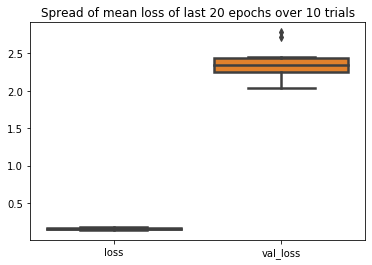

In [21]:
sns.boxplot(data=pd.DataFrame({'loss':[np.mean(h.history['loss'][-20:]) for h in histories],
                               'val_loss':[np.mean(h.history['val_loss'][-20:]) for h in histories]
                              }))
plt.title('Spread of mean loss of last 20 epochs over {} trials'.format(NUM_TRIALS))
plt.show()

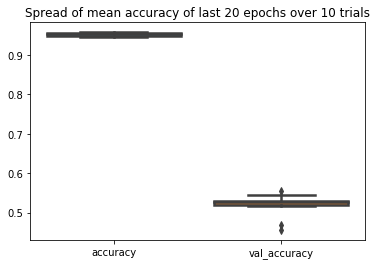

In [22]:
sns.boxplot(data=pd.DataFrame({'accuracy':[np.mean(h.history['accuracy'][-20:]) for h in histories],
                               'val_accuracy':[np.mean(h.history['val_accuracy'][-20:]) for h in histories]
                              }))
plt.title('Spread of mean accuracy of last 20 epochs over {} trials'.format(NUM_TRIALS))
plt.show()

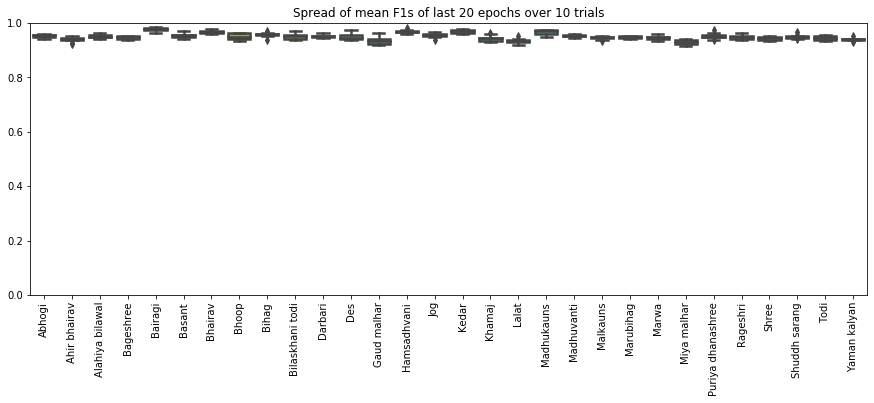

In [23]:
import seaborn as sns
fig=plt.figure(figsize=(15,5))
df=pd.DataFrame({ragas_reverse_idx[i]:[np.mean(h.history['F1_{}'.format(i)][-20:]) for h in histories] for i in range(30)})
ax=sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Spread of mean F1s of last 20 epochs over {} trials'.format(NUM_TRIALS))
plt.ylim(0,1)
plt.show()


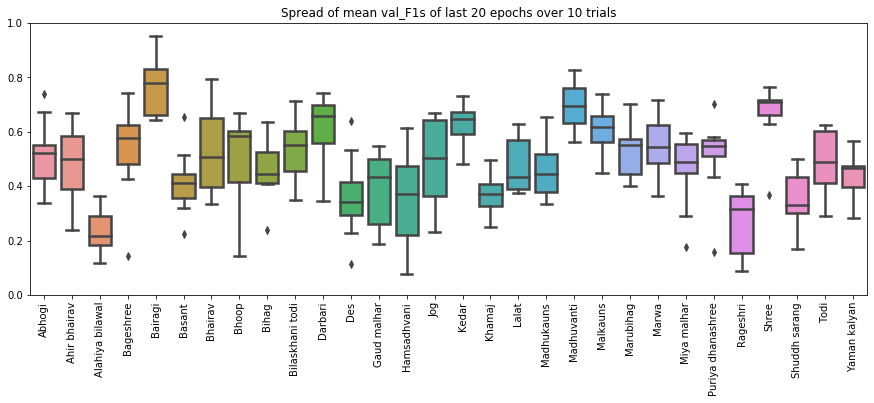

In [24]:
import seaborn as sns
fig=plt.figure(figsize=(15,5))
df=pd.DataFrame({ragas_reverse_idx[i]:[np.mean(h.history['val_F1_{}'.format(i)][-20:]) for h in histories] for i in range(30)})
ax=sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Spread of mean val_F1s of last 20 epochs over {} trials'.format(NUM_TRIALS))
plt.ylim(0,1)
plt.show()


In [25]:
cms=np.zeros(shape=(NUM_TRIALS,30,30))
for j,model in enumerate(models):
    y_pred=np.argmax(model.predict(X_val),axis=-1)
    y_true=y_val
    cms[j]=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)

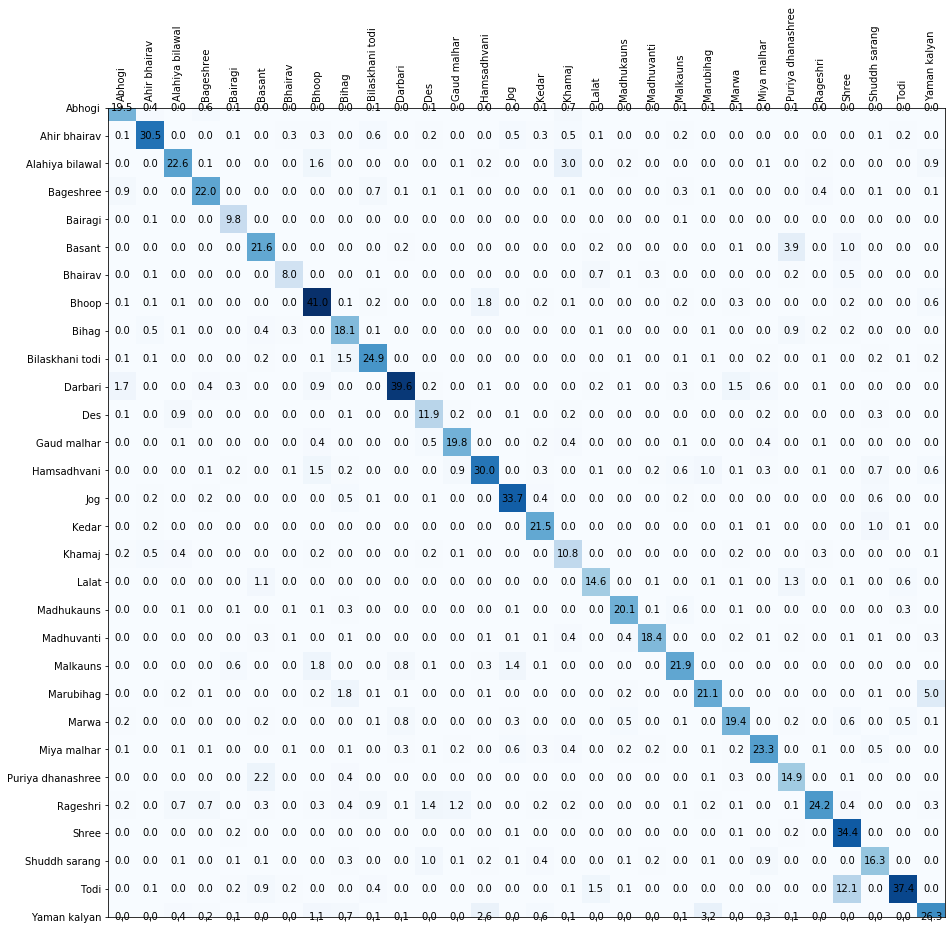

In [26]:
fig, ax = plt.subplots(figsize=(15,15))

cm_matrix=cms.mean(0)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, '{:.1f}'.format(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()


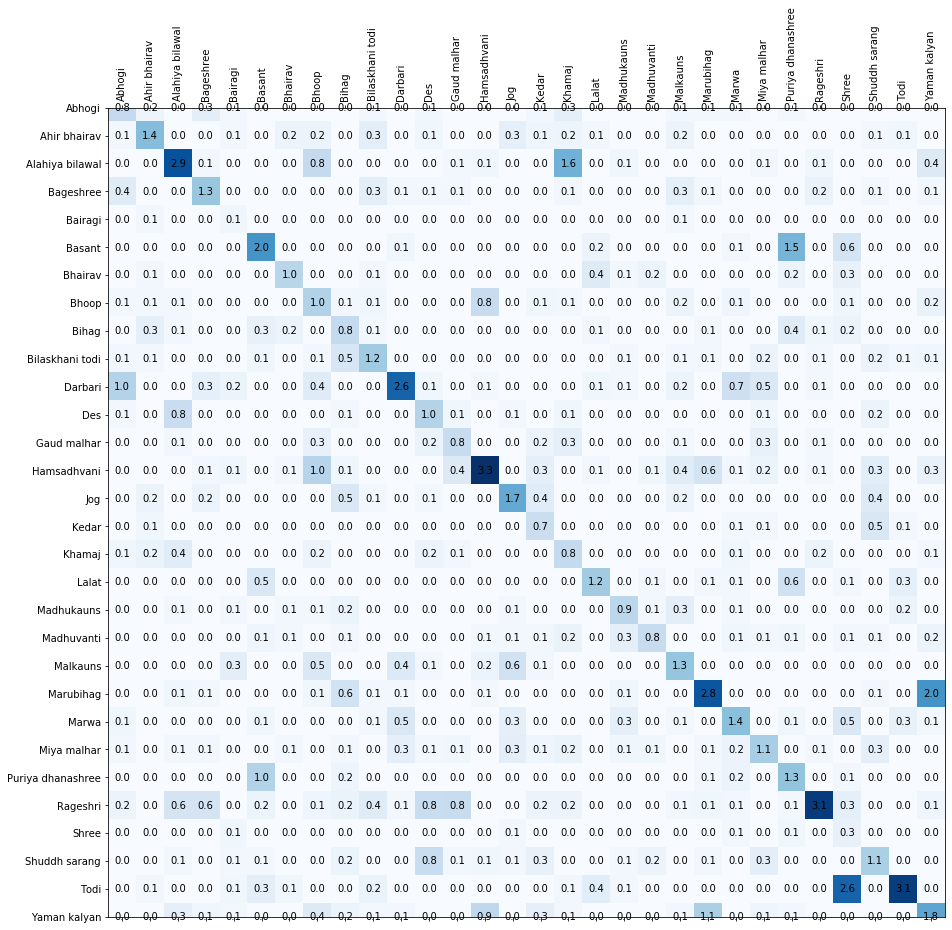

In [27]:
fig, ax = plt.subplots(figsize=(15,15))

cm_matrix=cms.std(0)/np.sqrt(NUM_TRIALS)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, '{:.1f}'.format(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()
